# Machine learning Project 1 : Higgs Boson

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import plotly.plotly as py
#import plotly.graph_objs as go
import datetime
%load_ext autoreload
%autoreload 2

In [6]:
from proj1_helpers import *
from implementations import *
from myhelpers import *

In [3]:
data_path = './datasets/train.csv'
yb, input_data, ids = load_csv_data(data_path, sub_sample = True)

In [4]:
input_data[np.where(input_data == -999)] = 0
means_by_columns = np.mean(input_data, axis=0)



for i in range(30):
    input_data[:,np.where(input_data[:,i]==-999)] = means_by_columns[i]
    
input_data = standardize(input_data)
rows, cols = input_data.shape[0], input_data.shape[1]


### Clean data 
We set to 0 the invalid values and standardize the data by columns in order to deal with dimensionless variables that span more or less the same range

First, we check whether there are any columns where there is no data available at all

We then check for columns where only some of the data are unavailable, and we replace the unavailable data by the mean of the column.

In [5]:
cleansubx = input_data
cleansubx[np.where(cleansubx == -999)] = 0
means_by_columns = np.mean(cleansubx, axis=0)

# remove all columns whose value is -999

for i in range(30):
    input_data[:,np.where(input_data[:,i]==-999)] = means_by_columns[i]
    
input_data = standardize(input_data)
rows, cols = input_data.shape[0], input_data.shape[1]


Correlation coefficients of the features, to understand if they are linearly correlated

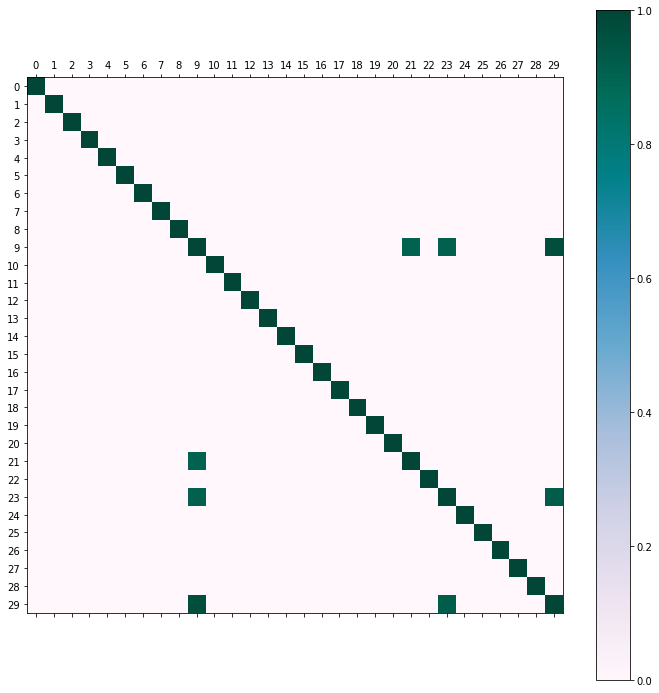

In [6]:
cor_matrix = np.corrcoef(input_data.T)

cor_matrix[cor_matrix < 0.9] = 0
plt.figure(1, figsize=(12,12))
plt.matshow(np.abs(cor_matrix),1)
plt.xticks(range(cols), range(cols))
plt.yticks(range(cols), range(cols))
plt.colorbar()
plt.set_cmap('PuBuGn')
plt.savefig('correlation_matrix'+'.png')

We decide to leave out columns 5, 9, 12, 21, 22, 23, 29 due to the high correlation with the others.

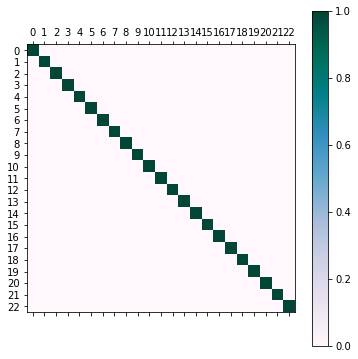

In [7]:
data = np.delete(input_data,[5,9,12,21,22,23,29],1)

#Compute again the correlation and check
cor_matrix = np.corrcoef(data.T)
cor_matrix[np.where(cor_matrix < 0.9)] = 0
plt.figure(2,figsize = (6,6))
plt.matshow(np.abs(cor_matrix),2)
plt.xticks(range(23), range(23))
plt.yticks(range(23), range(23))
plt.colorbar()
plt.set_cmap('PuBuGn')
plt.savefig('correlation_new'+'.png')

# Fitting a linear model
First of all we fit our linear model on the subset of data, and then use the whole train dataset to test it, at least at the beginning. In the end we will use the whole dataset to train the model. We try with 5 polynomial degrees per feature, otherwise the number of features becomes too large.
Compare the mse and the computational time of the 3 methods to get the least squares solution: the first one is the correct one, but maybe the others are faster.


1.Linear regression with mse and normal equations


2.Linear regression with mse and gradient descent


3.Linear regression with mse and stochastic gradient descent



In [9]:

def ls_polynomial_basis(yb, data, kfolds, degrees):
    """Builds a polynomial basis according to the chosen degree and solves the least squares problem
        with the normal equations, performing a k-fold cross validation to compute the rmse and the weights"""
    
    rmse_train=[]
    rmse_test=[]
    seed = 23467

    # Build indices to split data
    k_indices = build_k_indices(yb.shape[0], kfolds, seed)

    # Define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    std_tr = []
    std_te = []
    w_ls = []

    # Choose the degrees and loop over them
    for degree in degrees:
        rmse_tr_k=[]
        rmse_te_k=[]
        w_ls_deg = []
    
        # Build X matrix
        data1 = build_poly(data, degree)
    
        # Loop over the folds
        for k in range(kfolds):
            
            data_test_ls, y_test_ls, data_train_ls, y_train_ls = cross_validation(yb, data1, k, k_indices)   
        
            # Train and store rmse
            w_ls_k, mse_ls_k = least_squares(y_train_ls, data_train_ls)
            rmse_test = np.sqrt(2*compute_mse(y_test_ls, data_test_ls, w_ls_k))
            
            rmse_tr_k.append(np.sqrt(2*mse_ls_k))
            rmse_te_k.append(rmse_test)
            w_ls_deg.append(w_ls_k)
            
        
        # Append rmse (and std over the folds) in the vectors
        rmse_tr.append(np.mean(rmse_tr_k))
        rmse_te.append(np.mean(rmse_te_k))
        std_tr.append(np.std(rmse_tr_k))
        std_te.append(np.std(rmse_te_k))
        w_ls.append(np.mean(w_ls_deg, axis=0))
        

    return rmse_tr, rmse_te, std_tr, std_te, w_ls

We try this first simple model both on the matrix with all the features and on the reduced matrix, and compare the results.

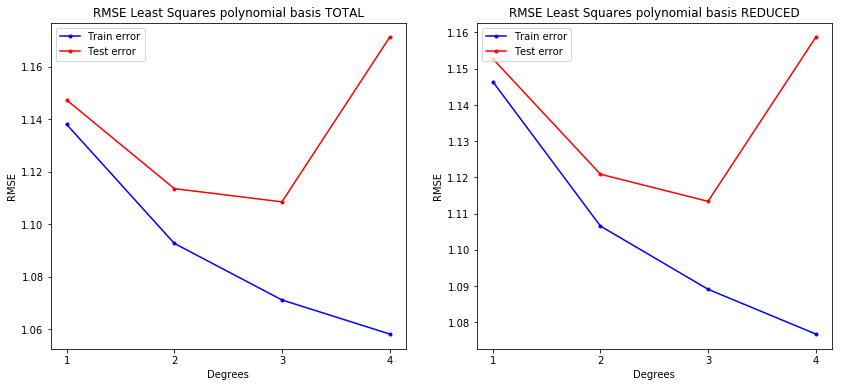

In [10]:
degrees = range(1,5)

rmse_train_tot, rmse_test_tot, std_train_tot, std_test_tot, w_tot = ls_polynomial_basis(yb, input_data, 5, degrees)
rmse_train_red, rmse_test_red, std_train_red, std_test_red, w_red = ls_polynomial_basis(yb, data, 5, degrees)

# Plot RMSE to compare the results
fig3, axs= plt.subplots(1,2, figsize=(14,6))
axs[0].plot(degrees, rmse_train_tot, marker=".", c='b', label='Train error')
axs[0].plot(degrees, rmse_test_tot, marker=".", c='r', label='Test error')
#plt.errorbar(degrees, rmse_tr, std_tr, marker=".", color='b', label='Train error')
#plt.errorbar(degrees, rmse_te, std_te, marker=".", color='r', label='Test error')
axs[0].set_xlabel("Degrees")
axs[0].set_ylabel("RMSE")
axs[0].set_title("RMSE Least Squares polynomial basis TOTAL")
axs[0].legend(loc=2)
axs[0].set_xticks(degrees)

axs[1].plot(degrees, rmse_train_red, marker=".", c='b', label='Train error')
axs[1].plot(degrees, rmse_test_red, marker=".", c='r', label='Test error')
axs[1].set_xlabel("Degrees")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE Least Squares polynomial basis REDUCED")
axs[1].legend(loc=2)
axs[1].set_xticks(degrees)
plt.savefig("rmse_ls")


The graphs below represent the mean test and train error when using different polynomial basis for our data. We have tried polynomial basis with degree  1 to 4.

In [11]:
print('Training RMSE LS with NORMAL EQUATIONS: {err1}'.format(err1=rmse_train_red))

Training RMSE LS with NORMAL EQUATIONS: [1.14642473341766, 1.1065857895906255, 1.0891389818496005, 1.0768095782800198]


In both cases we find a significant overfitting even at low degrees (3 and 4). In order to avoid overfitting we have to apply some regularization using the ridge regression algorithm.

### Gradient descent and stochastic gradient descent.

In [12]:
degree = 2
max_iters = 2000

# build the matrix and call the methods, after setting the parameters to ensure convergence
data2 = build_poly(data,2)
w_initial_red = np.zeros((data2.shape[1],1))

w_red_GD, mse_red_GD = least_squares_GD(yb, data2, w_initial_red, max_iters, 0.001, tol=1e-4)
w_red_SGD, mse_red_SGD = least_squares_SGD(yb, data2, w_initial_red, max_iters, 0.001, tol=1e-5)

rmse_train_red_GD = np.sqrt(2*mse_red_GD)
rmse_train_red_SGD = np.sqrt(2*mse_red_SGD)

print('Training RMSE LS with NORMAL EQUATIONS: {err1}'.format(err1=rmse_train_red[1]))
print('Training RMSE LS with GRADIENT DESCENT: {err2}'.format(err2=rmse_train_red_GD))
print('Training RMSE LS with STOCHASTIC GRADIENT DESCENT: {err3}'.format(err3=rmse_train_red_SGD))

Training RMSE LS with NORMAL EQUATIONS: 1.1065857895906255
Training RMSE LS with GRADIENT DESCENT: 1.132702532300935
Training RMSE LS with STOCHASTIC GRADIENT DESCENT: 2.3537517251337534


In [13]:
print('Distance between the weights normal equations/GD: {dist1}'.format(dist1=np.linalg.norm(w_red[1] - w_red_GD)))
print('Distance between the weights normal equations/SGD: {dist2}'.format(dist2=np.linalg.norm(w_red[1] - w_red_SGD)))

Distance between the weights normal equations/GD: 0.6560846886256457
Distance between the weights normal equations/SGD: 0.8171186410747912


We can't see any useful improvement by using the approximate methods to solve the minimization problem: the error on the training set is higher (correct) even if the one with GD is comparable, the computational time is even higher and moreover we need to run different attempts in order to decide the suitable parameters max_iters and gamma to obtain convergence. 

### Ridge regression.
Since we had the problem of overfitting, we try to introduce a regularization technique, based again on the mse loss function.
We try with different lambdas and do a 5 folds cross validation with a fixed degree (=2), then we try again changing the degree because this is exactly the purpose of the regularization technique.

In [14]:
# This method only finds the mean for all the models with different lambdas, but it doesn't indicate which one's best 

def ridge_lambda(yb, data, kfolds, degree, lambdas):
    """Builds a polynomial basis according to the chosen degree and solves the ridge regression
        with the normal equations for all the lambdas in lambdas, performing a k-fold cross validation 
        to compute the rmse and the weights"""
    
    rmse_train=[]
    rmse_test=[]
    seed = 3

    # Build indices to split data
    k_indices = build_k_indices(yb.shape[0], kfolds, seed)

    # Define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    std_tr = []
    std_te = []
    w_ridge = []
    accuracy = []

    # Loop over the lambdas
    for lam in lambdas:
        rmse_tr_k=[]
        rmse_te_k=[]
        w_ridge_lam = []
        accuracy_lam = []
        
        # Build X matrix
        data1 = build_poly(data, degree)
    
        # Loop over the folds
        for k in range(kfolds):
        
            data_test, y_test, data_train, y_train = cross_validation(yb, data1, k, k_indices)   
        
            # Train the model
            w_k, mse_k = ridge_regression(y_train, data_train, lam)
            rmse_test = np.sqrt(2*compute_mse(y_test, data_test, w_k))
            
            # Do the prediction on the test set and compute accuracy
            ypred = predict_labels(w_k, data_test)
            acc_k = compute_accuracy(ypred, y_test)
            
            # Store rmse, weights and accuracy
            rmse_tr_k.append(np.sqrt(2*mse_k))
            rmse_te_k.append(rmse_test)
            w_ridge_lam.append(w_k)
            accuracy_lam.append(acc_k)
        
        # Append rmse (and std over the folds) in the lists
        rmse_tr.append(np.mean(rmse_tr_k))
        rmse_te.append(np.mean(rmse_te_k))
        std_tr.append(np.std(rmse_tr_k))
        std_te.append(np.std(rmse_te_k))
        w_ridge.append(np.mean(w_ridge_lam, axis=0))
        accuracy.append(np.mean(accuracy_lam))
        

    return rmse_tr, rmse_te, std_tr, std_te, w_ridge, accuracy

In [15]:
def ridge_lambda_vis(lambdas, rmse_tr, rmse_te, std_train, std_test, acc, deg):
    """visualization of the curves of rmse_tr and rmse_te, and of the accuracy"""
    
    plt.figure(4, figsize=(16,5))
    plt.subplot(1,2,1)
    plt.semilogx(lambdas, rmse_tr, marker=".", color='b', label='Train error')
    plt.semilogx(lambdas, rmse_te, marker=".", color='r', label='Test error')
    #plt.errorbar(np.log10(lambdas), rmse_tr, std_train, label='Train error')
    #plt.errorbar(np.log10(lambdas), rmse_te, std_test, label='Test error')
    #plt.plot(lambdas, rmse_tr, marker=".", color='b', label='Train error')
    #plt.plot(lambdas, rmse_te, marker=".", color='r', label='Test error')
    plt.xlabel("Lambda")
    plt.ylabel("RMSE")
    plt.title("RMSE ridge regression with degree {ddd}".format(ddd=deg))
    plt.legend(loc=2)
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.semilogx(lambdas, acc,  marker=".", color='b', label='Accuracy')
    plt.xlabel("Lambda")
    plt.ylabel("Accuracy")
    plt.title("ACCURACY ridge regression with degree {ddd}".format(ddd=deg))
    plt.legend(loc=1)
    plt.grid(True)

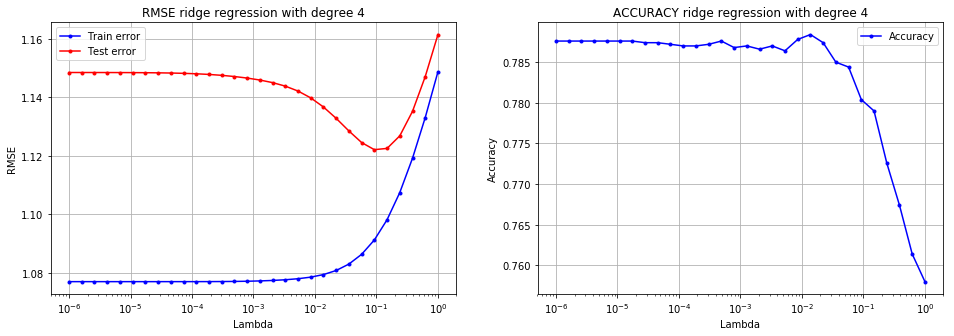

In [16]:
degree = 4
kfolds = 5
lambdas = np.logspace(-6,0,30)

rmse_ridge_train, rmse_ridge_test, std_train, std_test, w_ridge, accuracy = ridge_lambda(yb, data, kfolds, degree, lambdas)
ridge_lambda_vis(lambdas, rmse_ridge_train, rmse_ridge_test, std_train, std_test, accuracy, degree)

We notice that the test and train error get closer as we increase lambda, at the expense of an increase in training error and a decrease in our model's accuracy. This happens, because when lambda is 0 (no regularization is done), we encounter the problem of overflowing, where our model performs well in the training set, but its performance in the test set is quite bad. As we increase the lambdas, our model becomes less specific on the training set, thus increasing the training error, while minimizing the test error.

### Grid search.
To find the best couple (lambda, degree): I run it on a subset of the data (to save computational time) and then on the whole matrix, and check the difference in the rmse test.

1.Define ranges for lambda and degree.

2.Loop over the degrees.

3.Call the function ridge_lambda(). 

4.Save rmse test in a matrix: rows=degree, cols=lambdas.

5.Get the minimum and the associated parameters.

In [17]:
# load a subset of the engineered data to save computational time
yb_grid = yb[::25]
data_grid = data[::25]
ids_grid= ids[::25]

In [18]:
# Define the range for the parameters 
degree_grid = range(1,15)
lambdas_grid = np.linspace(0,1,100)
np.append(lambdas_grid,[0,1])
kfolds = 5

losses = np.zeros((len(degree_grid),len(lambdas_grid)))
accuracies = np.zeros((len(degree_grid),len(lambdas_grid)))

# Perform a grid search
for i, deg in enumerate(degree_grid):
        
        rmse_ridge_train, rmse_ridge_test, std_train, std_test, w_ridge, acc = ridge_lambda(yb_grid, data_grid, kfolds, deg, lambdas_grid)
        losses[i,:] = rmse_ridge_test
        accuracies[i,:] = acc
        
min_rmse_test, deg_opt_err, lam_opt_err = get_best_rmse(lambdas_grid, degree_grid, losses)  
max_accuracy, deg_opt_acc, lam_opt_acc = get_best_accuracy(lambdas_grid, degree_grid, accuracies)

print('Minimum Test RMSE (on the subset): {rmse}'.format(rmse=min_rmse_test))
print('Optimal degree: {d}'.format(d=deg_opt_err))
print('Optimal lambda: {l}'.format(l=lam_opt_err))

print('Maximum accuracy (on the subset): {acc}'.format(acc=max_accuracy))
print('Optimal degree: {d}'.format(d=deg_opt_acc))
print('Optimal lambda: {l}'.format(l=lam_opt_acc))

Minimum Test RMSE (on the subset): 1.237023559242023
Optimal degree: 1
Optimal lambda: 0.14141414141414144
Maximum accuracy (on the subset): 0.725
Optimal degree: 1
Optimal lambda: 0.0


In [19]:
def get_worst_parameters(lam, deg, losses):
 
    max_row, max_col = np.unravel_index(np.argmax(losses), losses.shape)
    return losses[max_row, max_col], deg[max_row], lam[max_col]

max_rmse, deg_wor, lam_wor = get_worst_parameters(lambdas_grid, degree_grid, losses)
print('Maximum Test RMSE (on the subset): {rmse}'.format(rmse=max_rmse))
print('Worst degree: {d}'.format(d=deg_wor))
print('Worst lambda: {l}'.format(l=lam_wor))

Maximum Test RMSE (on the subset): 483987024524.4534
Worst degree: 14
Worst lambda: 0.06060606060606061


In [20]:
def get_best_parameters(lam,deg,losses):
    
    """Get the worst parameters (lam, deg) from the result of grid search."""
    
    max_row, max_col = np.unravel_index(np.argmin(losses), losses.shape)
    
    return losses[max_row, max_col], deg[max_row], lam[max_col]

min_rmse, deg_best, lam_best = get_best_parameters(lambdas_grid, degree_grid, losses)
print('Minimum Test RMSE (on the subset): {rmse}'.format(rmse=min_rmse))
print('Best degree: {d}'.format(d=deg_best))
print('Best lambda: {l}'.format(l=lam_best))

Minimum Test RMSE (on the subset): 1.237023559242023
Best degree: 1
Best lambda: 0.14141414141414144


Now we try again with another subset of data and see the differences in the rmse.

In [21]:
# load another subset of the engineered data to save computational time
yb_grid1 = yb[::10]
data_grid1 = data[::10]
ids_grid1 = ids[::10]

# Define the range for the parameters 
degree_grid = range(1,10)
lambdas_grid = np.linspace(0,1,100)
np.append(lambdas_grid,[0,1])

kfolds = 5

losses = np.zeros((len(degree_grid),len(lambdas_grid)))
accuracies = np.zeros((len(degree_grid),len(lambdas_grid)))

# Perform a grid search
for i, deg in enumerate(degree_grid):
        
        rmse_ridge_train, rmse_ridge_test, std_train, std_test, w_ridge, acc = ridge_lambda(yb_grid1, data_grid1, kfolds, deg, lambdas_grid)
        losses[i,:] = rmse_ridge_test
        accuracies[i,:] = acc
        
min_rmse_test1, deg_opt1, lam_opt1 = get_best_rmse(lambdas_grid, degree_grid, losses)   
max_accuracy1, deg_opt_acc1, lam_opt_acc1 = get_best_accuracy(lambdas_grid, degree_grid, accuracies)

print('Minimum Test RMSE (on the second subset): {rmse}'.format(rmse=min_rmse_test1))
print('Optimal degree: {d}'.format(d=deg_opt1))
print('Optimal lambda: {l}'.format(l=lam_opt1))

print('Maximum accuracy (on the second subset): {acc}'.format(acc=max_accuracy1))
print('Optimal degree: {d}'.format(d=deg_opt_acc1))
print('Optimal lambda: {l}'.format(l=lam_opt_acc1))

Minimum Test RMSE (on the second subset): 1.1849988759063301
Optimal degree: 1
Optimal lambda: 0.020202020202020204
Maximum accuracy (on the second subset): 0.78
Optimal degree: 2
Optimal lambda: 0.030303030303030304


... I tried different dimensions of the subset (to get the best parameters) and even the total dataset, since the computational time wasn't too high. In the end I decided to keep the optimal values obtained with the whole dataset and perform another cross validation (same seed and kfolds) in order to get the best weights and used them in the prediction. If I use different seeds and kfolds I get different values for the error at each try, so I decided to keep the same, in order to doublecheck the results.

In [22]:
kfolds = 6

rmse_train=[]
rmse_test=[]
seed = 2

# Build indices to split data
k_indices = build_k_indices(yb.shape[0], kfolds, seed)

# Define lists to store the loss of training data and test data
rmse_opt_tr = []
rmse_opt_te = []
w_opt_ridge_list = []
acc_opt = []

# Build X matrix
data1 = build_poly(data, deg_opt_acc1)

# Loop over the folds
for k in range(kfolds):
    
    data_test, y_test, data_train, y_train = cross_validation(yb, data1, k, k_indices)   
        
    # Train the model
    w_k, mse_k = ridge_regression(y_train, data_train, lam_opt_acc1)
    rmse_test = np.sqrt(2*compute_mse(y_test, data_test, w_k))
    
    # Do the prediction on the test set and compute accuracy
    ypred = predict_labels(w_k, data_test)
    acc_k = compute_accuracy(ypred, y_test)
            
    # Store rmse and weights
    rmse_opt_tr.append(np.sqrt(2*mse_k))
    rmse_opt_te.append(rmse_test)
    w_opt_ridge_list.append(w_k)
    acc_opt.append(acc_k)
    
# Get the best weights and the errors
w_opt_ridge = np.mean(w_opt_ridge_list, axis=0)

print('Test RMSE: {te}'.format(te=np.mean(rmse_opt_te)))
print('Train RMSE: {tr}'.format(tr=np.mean(rmse_opt_tr)))
print('Accuracy: {acc}'.format(acc=np.mean(acc_opt)))

Test RMSE: 1.1290185786255065
Train RMSE: 1.1125752311021841
Accuracy: 0.7683073229291716


RMSE values with deg=2 and lambda=0.0011937766417144358, subset 1:25 :
Train RMSE: 0.8014915854773715
Test RMSE: 0.8305541106371641

RMSE values with deg=3 and lambda=0.007038135554931562, subset 1:20 :
Train RMSE: 0.793285618340946
Test RMSE: 1.3284903246013344

RMSE values with deg=2 and lambda=0.0002894266124716752, subset 1:15 :
Train RMSE: 0.801442221422809
Test RMSE: 0.8276588788503378

RMSE values with deg=4 and lambda=0.08376776400682924, subset 1:10 :
Train RMSE: 0.7945378819037896
Test RMSE: 17.95365044601708

RMSE values with deg=3 and lambda=0.11689518164985777, whole dataset:
Train RMSE: 0.8013123911573933
Test RMSE: 0.8075341744448667

## Logistic regression
We wrote the 4 functions (logistic, reg_logistic, logistic_newton, reg_logistic_newton) and they work.

## Create submission
Given the test data set, we need to split it according to the jet number (KEEPING THE ORIGINAL IDS), and then apply the same feature engineering techniques that we have on the train dataset (standardize, remove columns and build polynomials); make predictions according to the model and then rebuild the ypred.

In [62]:
def create_submission(y1, id1, y2, id2, y3, id3, y4, id4, total_ids, name_file):
    """Reconstruct the prediction on the whole dataset starting from the partial ones obtained with the different models
    the name_file should be in the string format 'name.csv' """
    
    ypred = np.zeros(len(total_ids))
    
    ypred[id1] = y1
    ypred[id2] = y2
    ypred[id3] = y3
    ypred[id4] = y4
    
    create_csv_submission(total_ids, ypred, name_file)    

In [63]:
#testing the function
tot = np.array(range(12))
id1 = np.array([2,7,5])
id2 = np.array([1,11,10])
id3 = np.array([3,9,0])
id4 = np.array([4,6,8])

y1 = np.array([1,1,1])
y2 = np.array([2,2,2])
y3 = np.array([3,3,3])
y4 = np.array([4,4,4])

create_submission(y1, id1, y2, id2, y3, id3, y4, id4, tot, 'prova.csv')

The code below tries to fit a regularized logistic regression method to our data. We are first going to test it using a random separation of the dataset in training and test data. Then, we are going to separate the data based on its jet num, because we noticed that there were some similarities among data that shared the same jet_num. We first define some helper function for the logistic regression.

In [24]:
jet_num = data[:,22]

If we plot the distribution of each column of our dataset, we will notice that columns 15,18,20,25,28 have a different distribution than other variables and their distribution is uniform. We noticed that these columns correspond to the variables: PRI_tau_phi, PRI_lep_phi, PRI_met_phi, PRI_jet_leading_phi and PRI_jet_subleading_phi, which are all phi variables. Hence we conclude that the category of phi variables does not provide much information about our dataset, so we can safely remove it.

In [202]:
degree = 9
alpha = 0.3
reg_parameter = 0.1

Above, we can observe that the accuracy we get when applying regularized logistic regression is 72.8 %. We will now further process the data by removing the columns that correspond to the phi_variables and by encoding the categorical variable jet_num.

jet_num is just a categorical variable which assumes values from 0 to 3. However, our model will assume that the data with jet_num = 3 is three times the data with jet_num = 1, which in this case is not true. We can fix this issue by adding 4 more columns to our dataset, named cat_0,cat_1,cat_2,cat_3 which assume the value 0 or 1 depending on the category to which our data belong. First, we will test our algorithm without performing this encoding, and we will then encode such values in order to determine whether the improve in efficiency justifies the added number of columns. Hence, we perform label encoding by adding 4 columns such that the particles with jet_num = 1 will have the first column equal to 1 and all the other columns equal to 0, the particles with jet_num = 2 will have the 2nd columns equal to 1 and all the other columns equal to 0.

In [188]:
X = input_data
yb[yb == -1] = 0

In [189]:
for i in range(4):
    X = np.c_[X,np.zeros(X.shape[0])]

In [190]:
newCols = []
for k in range(4):
    col = X[:,30+k]
    col[np.where(X[:,22] ==k)] = 1
    X[:,30+k] = col

In [191]:
cols_to_delete

[15, 18, 20, 25, 28, 22]

In [192]:
X = np.delete(X,cols_to_delete,1)

In [193]:
X = clean_data(X)

Inside clean_data


In [194]:
ind = build_k_indices(yb.shape[0], 4, 123237)
X_test, y_test, X_train, y_train = cross_validation(yb, X, 2, ind)

In [195]:
X_test = np.c_[X_test,np.ones(X_test.shape[0])]
X_train = np.c_[X_train,np.ones(X_train.shape[0])]

In [196]:
test_reg_logistic_regresion(X_train, y_train, X_test, y_test, alpha, reg_parameter)

loss  1.5291988424870067
loss  1.4363285398754257
loss  1.3567527915779751
loss  1.2868881131889853
loss  1.2246300835742439
loss  1.1687819942729818
loss  1.1185549097610763
loss  1.0733292665241692
loss  1.0326175033051928
loss  0.9960294657056669
loss  0.9632227319197456
loss  0.9338657602018694
loss  0.9076247380860669
loss  0.8841718579564006
loss  0.8631931756308706
loss  0.844390627903245
loss  0.8274880006043045
loss  0.812237646944511
loss  0.7984213168347258
loss  0.785847290187619
loss  0.7743474156483044
loss  0.7637748244921146
loss  0.7540020037337928
loss  0.74491902071182
loss  0.7364318085109572
loss  0.7284604530985803
loss  0.7209374754434268
loss  0.7138061543265233
loss  0.7070189517502744
loss  0.700536087832848
loss  0.6943242872814521
loss  0.68835569904729
loss  0.6826069783169133
loss  0.6770585141427384
loss  0.671693784262151
loss  0.6664988190669272
loss  0.6614617581009329
loss  0.6565724842688513
loss  0.6518223228260784
loss  0.6472037940408102
loss  0.6

loss  0.4819687974625686
loss  0.4819479781429868
loss  0.48192730032885334
loss  0.48190676279044997
loss  0.4818863643125906
loss  0.48186610369437183
loss  0.48184597974893023
loss  0.48182599130320486
loss  0.4818061371977055
loss  0.48178641628628677
loss  0.4817668274359272
loss  0.48174736952651304
loss  0.48172804145062853
loss  0.4817088421133489
loss  0.4816897704320401
loss  0.48167082533616173
loss  0.48165200576707495
loss  0.48163331067785486
loss  0.4816147390331068
loss  0.4815962898087863
loss  0.48157796199202413
loss  0.4815597545809539
loss  0.48154166658454445
loss  0.4815236970224353
loss  0.48150584492477544
loss  0.4814881093320662
loss  0.481470489295007
loss  0.48145298387434415
loss  0.48143559214072357
loss  0.48141831317454575
loss  0.481401146065824
loss  0.48138408991404597
loss  0.4813671438280373
loss  0.4813503069258286
loss  0.4813335783345247
loss  0.4813169571901769
loss  0.4813004426376574
loss  0.48128403383053636
loss  0.4812677299309614
loss  0.

loss  0.47887884985584867
loss  0.4788759279445878
loss  0.47887301887263234
loss  0.4788701225685625
loss  0.47886723896140143
loss  0.47886436798061166
loss  0.4788615095560927
loss  0.4788586636181769
loss  0.47885583009762783
loss  0.4788530089256361
loss  0.4788502000338172
loss  0.4788474033542081
loss  0.4788446188192647
loss  0.47884184636185884
loss  0.4788390859152752
loss  0.4788363374132086
loss  0.4788336007897617
loss  0.4788308759794412
loss  0.47882816291715585
loss  0.47882546153821354
loss  0.4788227717783184
loss  0.47882009357356825
loss  0.4788174268604518
loss  0.4788147715758462
loss  0.47881212765701386
loss  0.4788094950416008
loss  0.4788068736676329
loss  0.47880426347351446
loss  0.4788016643980245
loss  0.47879907638031505
loss  0.47879649935990826
loss  0.4787939332766942
loss  0.478791378070928
loss  0.4787888336832275
loss  0.478786300054571
loss  0.47878377712629466
loss  0.47878126484009004
loss  0.47877876313800194
loss  0.47877627196242584
loss  0.47

loss  0.4783059006983688
loss  0.47830506517685834
loss  0.478304231750384
loss  0.4783034004097862
loss  0.4783025711459531
loss  0.47830174394982095
loss  0.4783009188123734
loss  0.4783000957246415
loss  0.4782992746777031
loss  0.47829845566268286
loss  0.4782976386707518
loss  0.47829682369312754
loss  0.47829601072107314
loss  0.4782951997458976
loss  0.4782943907589555
loss  0.47829358375164643
loss  0.47829277871541487
loss  0.47829197564175
loss  0.4782911745221858
loss  0.4782903753482998
loss  0.47828957811171413
loss  0.4782887828040942
loss  0.47828798941714906
loss  0.47828719794263086
loss  0.47828640837233477
loss  0.4782856206980988
loss  0.47828483491180346
loss  0.4782840510053712
loss  0.478283268970767
loss  0.47828248879999735
loss  0.47828171048511026
loss  0.47828093401819527
loss  0.47828015939138296
loss  0.47827938659684466
loss  0.4782786156267925
loss  0.47827784647347904
loss  0.47827707912919704
loss  0.47827631358627903
loss  0.4782755498370977
loss  0.4

loss  0.47809238273189825
loss  0.4780919525823911
loss  0.4780915230052728
loss  0.4780910939989838
loss  0.47809066556197183
loss  0.4780902376926913
loss  0.4780898103896034
loss  0.4780893836511763
loss  0.47808895747588476
loss  0.47808853186221034
loss  0.47808810680864117
loss  0.4780876823136724
loss  0.47808725837580507
loss  0.4780868349935476
loss  0.4780864121654146
loss  0.478085989889927
loss  0.47808556816561276
loss  0.4780851469910055
loss  0.47808472636464616
loss  0.4780843062850814
loss  0.4780838867508644
loss  0.4780834677605548
loss  0.4780830493127185
loss  0.4780826314059274
loss  0.4780822140387599
loss  0.4780817972098005
loss  0.4780813809176399
loss  0.47808096516087484
loss  0.4780805499381083
loss  0.478080135247949
loss  0.4780797210890122
loss  0.4780793074599187
loss  0.47807889435929546
loss  0.4780784817857754
loss  0.4780780697379975
loss  0.4780776582146062
loss  0.47807724721425215
loss  0.47807683673559176
loss  0.4780764267772871
loss  0.4780760

loss  0.4779720667995655
loss  0.4779717718185143
loss  0.4779714771225298
loss  0.47797118271117905
loss  0.4779708885840312
loss  0.47797059474065595
loss  0.4779703011806249
loss  0.4779700079035107
loss  0.4779697149088872
loss  0.4779694221963299
loss  0.47796912976541506
loss  0.47796883761572057
loss  0.4779685457468255
loss  0.4779682541583102
loss  0.47796796284975634
loss  0.4779676718207466
loss  0.47796738107086517
loss  0.4779670905996974
loss  0.47796680040682976
loss  0.47796651049185007
loss  0.4779662208543475
loss  0.47796593149391203
loss  0.4779656424101353
loss  0.47796535360260983
loss  0.4779650650709294
loss  0.4779647768146894
loss  0.47796448883348586
loss  0.47796420112691607
loss  0.47796391369457886
loss  0.47796362653607394
loss  0.47796333965100224
loss  0.4779630530389659
loss  0.47796276669956805
loss  0.4779624806324135
loss  0.4779621948371074
loss  0.47796190931325666
loss  0.4779616240604691
loss  0.4779613390783538
loss  0.4779610543665208
loss  0.

loss  0.4778573226421683
loss  0.47785713023603393
loss  0.47785693799263107
loss  0.47785674591180266
loss  0.4778565539933924
loss  0.4778563622372434
loss  0.47785617064319996
loss  0.47785597921110595
loss  0.4778557879408056
loss  0.47785559683214335
loss  0.47785540588496406
loss  0.47785521509911244
loss  0.47785502447443373
loss  0.4778548340107732
loss  0.47785464370797665
loss  0.4778544535658895
loss  0.47785426358435823
loss  0.4778540737632285
loss  0.4778538841023471
loss  0.47785369460156046
loss  0.4778535052607156
loss  0.4778533160796595
loss  0.47785312705823935
loss  0.4778529381963027
loss  0.47785274949369727
loss  0.477852560950271
loss  0.4778523725658719
loss  0.4778521843403483
loss  0.47785199627354874
loss  0.47785180836532193
loss  0.47785162061551695
loss  0.47785143302398275
loss  0.4778512455905688
loss  0.4778510583151246
loss  0.47785087119749986
loss  0.47785068423754473
loss  0.47785049743510916
loss  0.47785031079004375
loss  0.4778501243021989
loss

loss  0.4778022627743833
loss  0.4778021162804753
loss  0.47780196990724616
loss  0.4778018236545899
loss  0.47780167752240044
loss  0.4778015315105719
loss  0.4778013856189987
loss  0.47780123984757505
loss  0.4778010941961954
loss  0.4778009486647544
loss  0.4778008032531466
loss  0.4778006579612669
loss  0.4778005127890103
loss  0.47780036773627166
loss  0.47780022280294615
loss  0.477800077988929
loss  0.47779993329411546
loss  0.4777997887184012
loss  0.4777996442616815
loss  0.47779949992385223
loss  0.477799355704809
loss  0.4777992116044478
loss  0.4777990676226647
loss  0.4777989237593555
loss  0.4777987800144167
loss  0.4777986363877445
loss  0.4777984928792352
loss  0.47779834948878547
loss  0.4777982062162919
loss  0.4777980630616512
loss  0.4777979200247601
loss  0.47779777710551574
loss  0.47779763430381517
loss  0.4777974916195553
loss  0.4777973490526336
loss  0.47779720660294756
loss  0.47779706427039426
loss  0.4777969220548715
loss  0.4777967799562771
loss  0.4777966

loss  0.4777558115298594
loss  0.47775570299330994
loss  0.4777555945447691
loss  0.47775548618416247
loss  0.47775537791141576
loss  0.4777552697264548
loss  0.47775516162920506
loss  0.4777550536195926
loss  0.4777549456975434
loss  0.47775483786298323
loss  0.47775473011583836
loss  0.4777546224560347
loss  0.4777545148834987
loss  0.4777544073981564
loss  0.4777542999999342
loss  0.4777541926887585
loss  0.4777540854645557
loss  0.4777539783272524
loss  0.47775387127677515
loss  0.47775376431305056
loss  0.4777536574360055
loss  0.4777535506455666
loss  0.4777534439416608
loss  0.47775333732421504
loss  0.4777532307931563
loss  0.4777531243484116
loss  0.47775301798990805
loss  0.4777529117175729
loss  0.47775280553133337
loss  0.4777526994311168
loss  0.47775259341685056
loss  0.4777524874884622
loss  0.4777523816458791
loss  0.47775227588902897
loss  0.4777521702178392
loss  0.47775206463223796
loss  0.4777519591321526
loss  0.4777518537175112
loss  0.4777517483882417
loss  0.477

0.7512

In [208]:
X = input_data
yb[yb == -1] = 0

In [209]:
for i in range(4):
    X = np.c_[X,np.zeros(X.shape[0])]

In [210]:
newCols = []
for k in range(4):
    col = X[:,30+k]
    col[np.where(X[:,22] ==k)] = 1
    X[:,30+k] = col

In [211]:
X = np.delete(X,cols_to_delete,1)

In [231]:
cols_to_delete

[15, 18, 20, 25, 28, 22]

In [212]:
X = clean_data(X)

Inside clean_data


In [230]:
best = gridSearchLogisticReg(X,yb)
print(best)

(3, 0.001, 0.1, 3, 0.819327731092437, 0.6203375987432008)


The above cell performed an iterative search in order to find the best parameters that maximize the performance of logistic regression in the test set. The parameters it found are: kfold = 3, gamma = 0.001, lambda_ = 0.1 and degree = 0.1. For such parameters, the model achieved a 81.9% accuracy in the test set and the average accuracy for all the loops is around 62%. We can try and get a closer look at how this model performs.

In [239]:
X = input_data
X = process_data(X,yb,cols_to_delete)

Inside clean_data


In [242]:
ind = build_k_indices(yb.shape[0], 3, 123237)
X_test, y_test, X_train, y_train = cross_validation(yb, X, 1, ind)
X_test = build_poly(X_test,3)
X_train = build_poly(X_train,3)
X_test = np.c_[np.ones(X_test.shape[0]),X_test]
X_train = np.c_[np.ones(X_train.shape[0]),X_train]
gamma = 0.001
lambda_ = 0.1

In [246]:
test_reg_logistic_regresion(X_train, y_train, X_test, y_test, gamma, lambda_)

loss  4.538266962382506
loss  4.5357905027594265
loss  4.5333112482060995
loss  4.530829587025926
loss  4.528347376217226
loss  4.525870036590205
loss  4.523409871187044
loss  4.52098728431701
loss  4.518620392627704
loss  4.516307186922296
loss  4.51402782070813
loss  4.511762567443463
loss  4.509499734166948
loss  4.507234158706558
loss  4.504964520361112
loss  4.502691771751066
loss  4.500418813162923
loss  4.498150867696439
loss  4.49589619745166
loss  4.4936651869094035
loss  4.491462214583411
loss  4.489253875453252
loss  4.4869180058392635
loss  4.484396968989732
loss  4.481807030059892
loss  4.47921427469372
loss  4.476631262407074
loss  4.474059431216279
loss  4.471499092397104
loss  4.46895071361701
loss  4.4664147934375755
loss  4.463891898504907
loss  4.461384104890308
loss  4.458904211509418
loss  4.456512845748128
loss  4.454329906390309
loss  4.4523328293488245
loss  4.450402121480587
loss  4.448488417025462
loss  4.446579980092019
loss  4.444674053949812
loss  4.4427697

loss  3.7309793409588745
loss  3.7288617885444246
loss  3.7267427368193737
loss  3.7246216504782343
loss  3.7224978733278826
loss  3.7203705486722303
loss  3.718238503752381
loss  3.7161000863952447
loss  3.7139530578557007
loss  3.711794541216679
loss  3.7096212283156786
loss  3.7074299543383087
loss  3.7052185101148822
loss  3.7029863680167523
loss  3.7007347346544037
loss  3.698465976787846
loss  3.696182755295666
loss  3.693887433793845
loss  3.691581781625914
loss  3.6892669447439097
loss  3.6869435704112337
loss  3.6846118987366103
loss  3.6822718624685162
loss  3.679923134524505
loss  3.6775651706579526
loss  3.675197190280488
loss  3.6728182383034818
loss  3.6704271630535334
loss  3.6680227363954603
loss  3.6656037316194974
loss  3.6631690890380364
loss  3.660718080761973
loss  3.6582504178649162
loss  3.655766323685914
loss  3.65326646142149
loss  3.650751828292626
loss  3.648223597568526
loss  3.645683009377841
loss  3.6431312778906073
loss  3.640569542493673
loss  3.63799884

loss  2.622442318717097
loss  2.6209151597607234
loss  2.6193943768032333
loss  2.6178799645417334
loss  2.6163719185635546
loss  2.614870226391309
loss  2.6133748714186016
loss  2.6118858405604346
loss  2.6104031075996783
loss  2.608926644757411
loss  2.607456414159535
loss  2.6059923715560718
loss  2.6045344654239266
loss  2.603082635686886
loss  2.6016368183277447
loss  2.6001969335056305
loss  2.5987629035595066
loss  2.5973346378110707
loss  2.5959120462881238
loss  2.5944950338305857
loss  2.5930835034176605
loss  2.591677355400464
loss  2.590276489009825
loss  2.58888080769894
loss  2.5874902166813682
loss  2.5861046168222983
loss  2.584723921025791
loss  2.5833480397948674
loss  2.5819768865770323
loss  2.580610380595322
loss  2.5792484452634894
loss  2.577891006140617
loss  2.576537993299813
loss  2.5751893406281594
loss  2.5738449832801433
loss  2.5725048621313564
loss  2.5711689205118633
loss  2.569837100523373
loss  2.568509353752837
loss  2.5671856322680306
loss  2.5658658

loss  2.1525371924206023
loss  2.1519117763748197
loss  2.1512869589900387
loss  2.150662739432829
loss  2.1500391114789803
loss  2.1494160730879157
loss  2.148793624884027
loss  2.148171760257547
loss  2.1475504787205724
loss  2.1469297784899024
loss  2.1463096563286395
loss  2.145690110778736
loss  2.145071137112373
loss  2.1444527375501194
loss  2.1438349078356658
loss  2.14321764535399
loss  2.142600950737466
loss  2.14198482000591
loss  2.1413692523590333
loss  2.140754248016239
loss  2.140139801492102
loss  2.1395259128864117
loss  2.1389125835344815
loss  2.138299808553095
loss  2.13768758806551
loss  2.1370759202371215
loss  2.1364648056215696
loss  2.1358542410345764
loss  2.135244227295269
loss  2.1346347615479853
loss  2.1340258420910194
loss  2.1334174700856217
loss  2.1328096437968926
loss  2.132202361399827
loss  2.1315956238634657
loss  2.130989430305153
loss  2.1303837765847464
loss  2.1297786645774512
loss  2.1291740940909882
loss  2.128570063001021
loss  2.12796657108

loss  1.9154048388463742
loss  1.91500851355226
loss  1.9146125595098364
loss  1.9142169809780372
loss  1.9138217752048337
loss  1.913426942600022
loss  1.9130324844127986
loss  1.9126383965470046
loss  1.9122446843859104
loss  1.9118513427049886
loss  1.9114583742166054
loss  1.9110657789978578
loss  1.910673554524243
loss  1.910281702633677
loss  1.9098902228367245
loss  1.9094991128824368
loss  1.9091083765000998
loss  1.9087180099582843
loss  1.9083280148739945
loss  1.9079383905479947
loss  1.9075491357642196
loss  1.9071602515166097
loss  1.9067717368489652
loss  1.906383592045453
loss  1.9059958159442216
loss  1.9056084101122848
loss  1.905221371949031
loss  1.9048347029212775
loss  1.9044484002999382
loss  1.9040624671307238
loss  1.9036768984705037
loss  1.9032917003623968
loss  1.90290686704985
loss  1.9025224014460043
loss  1.90213829936491
loss  1.9017545651433199
loss  1.9013711939260336
loss  1.900988189407283
loss  1.9006055463590266
loss  1.9002232701824904
loss  1.8998

loss  1.7686186122973468
loss  1.7683509891344975
loss  1.768083680475772
loss  1.7678166937682156
loss  1.767550030147913
loss  1.7672836922627522
loss  1.767017681085944
loss  1.7667520018768526
loss  1.7664866526523708
loss  1.7662216400747963
loss  1.7659569616843833
loss  1.7656926189101205
loss  1.765428612903345
loss  1.7651649442981419
loss  1.7649016129717618
loss  1.7646386173665287
loss  1.7643759573364617
loss  1.7641136310652097
loss  1.7638516371411401
loss  1.763589972051141
loss  1.7633286337246683
loss  1.7630676196516342
loss  1.7628069253832888
loss  1.7625465464861945
loss  1.7622864791664272
loss  1.7620267177510243
loss  1.7617672591840718
loss  1.761508095534323
loss  1.7612492241076323
loss  1.7609906371456157
loss  1.76073233056256
loss  1.7604742958129738
loss  1.7602165272939845
loss  1.7599590210582428
loss  1.7597017699036543
loss  1.7594447667522097
loss  1.759188004756768
loss  1.7589314805383622
loss  1.7586751862809549
loss  1.758419115379319
loss  1.75

loss  1.6885696028348607
loss  1.6883490674461399
loss  1.6881286512873712
loss  1.6879083550090404
loss  1.6876881763813028
loss  1.6874681160308256
loss  1.6872481739257232
loss  1.6870283497890421
loss  1.6868086444482093
loss  1.686589057701072
loss  1.6863695892656725
loss  1.6861502374941557
loss  1.685931002361662
loss  1.6857118849404658
loss  1.685492885588319
loss  1.6852740059729132
loss  1.6850552407608228
loss  1.6848365908347231
loss  1.6846180619595477
loss  1.6843996466741449
loss  1.684181349434343
loss  1.6839631689612025
loss  1.6837451048831042
loss  1.683527156619267
loss  1.683309325323241
loss  1.6830916096031767
loss  1.6828740105160813
loss  1.682656526274194
loss  1.6824391577440645
loss  1.6822219060435197
loss  1.682004768508091
loss  1.681787746545227
loss  1.6815708405507117
loss  1.6813540498179227
loss  1.6811373737227493
loss  1.680920811214452
loss  1.680704366648283
loss  1.680488034012527
loss  1.6802718151325315
loss  1.6800557145141213
loss  1.6798

loss  1.6203478841891013
loss  1.6201598820383174
loss  1.619971955232801
loss  1.6197841028377538
loss  1.6195963257278523
loss  1.6194086215020547
loss  1.6192209913283675
loss  1.6190334360366978
loss  1.6188459536663773
loss  1.618658546335348
loss  1.6184712115354294
loss  1.6182839512588119
loss  1.6180967628423693
loss  1.6179096496351975
loss  1.6177226091367987
loss  1.617535642509919
loss  1.6173487470653403
loss  1.6171619263668624
loss  1.6169751774936587
loss  1.616788501417579
loss  1.6166018980374623
loss  1.6164153672490749
loss  1.6162289085748094
loss  1.6160425219183998
loss  1.6158562079958985
loss  1.6156699664527039
loss  1.6154837956405705
loss  1.6152976985556584
loss  1.6151116720572987
loss  1.6149257171892273
loss  1.6147398336095224
loss  1.614554022866808
loss  1.614368282528702
loss  1.6141826138585904
loss  1.6139970156452899
loss  1.6138114896543159
loss  1.6136260338967248
loss  1.6134406495668736
loss  1.6132553350289354
loss  1.6130700920391312
loss  

loss  1.5394370011428307
loss  1.5392793676434788
loss  1.5391217893971783
loss  1.5389642676028032
loss  1.5388067979379014
loss  1.5386493877122212
loss  1.5384920295071969
loss  1.5383347279684392
loss  1.538177479398646
loss  1.5380202873174778
loss  1.5378631485470133
loss  1.537706065662186
loss  1.5375490368691749
loss  1.5373920612103669
loss  1.5372351395523816
loss  1.5370782737395943
loss  1.5369214605108423
loss  1.5367647009948948
loss  1.5366079953069949
loss  1.5364513436134493
loss  1.536294745192828
loss  1.5361381995746852
loss  1.5359817090289873
loss  1.5358252691287475
loss  1.5356688824051334
loss  1.535512550445741
loss  1.5353562699714394
loss  1.5352000424775358
loss  1.535043867444947
loss  1.534887745323802
loss  1.5347316752277467
loss  1.5345756563214223
loss  1.5344196913763901
loss  1.5342637771036207
loss  1.5341079144545628
loss  1.5339521043617579
loss  1.5337963468225624
loss  1.5336406398187348
loss  1.533484984095536
loss  1.5333293794480347
loss  1

loss  1.4694241812005324
loss  1.469287432304409
loss  1.4691507222528422
loss  1.4690140531870703
loss  1.4688774252757824
loss  1.4687408373535427
loss  1.468604290058628
loss  1.468467783072784
loss  1.4683313176116082
loss  1.468194890845521
loss  1.4680585067749268
loss  1.4679221617799898
loss  1.4677858572088696
loss  1.4676495923690496
loss  1.4675133692252318
loss  1.4673771844805852
loss  1.4672410414609691
loss  1.4671049392856295
loss  1.466968876743031
loss  1.4668328545826232
loss  1.4666968734897112
loss  1.4665609318671848
loss  1.4664250295598182
loss  1.4662891695656162
loss  1.4661533487339482
loss  1.4660175680880476
loss  1.465881828348314
loss  1.4657461283445299
loss  1.4656104683448463
loss  1.4654748475954764
loss  1.4653392671790202
loss  1.4652037291576478
loss  1.4650682291530275
loss  1.4649327709154398
loss  1.4647973515260866
loss  1.464661971596685
loss  1.4645266336468787
loss  1.4643913345156294
loss  1.4642560759755894
loss  1.4641208569310928
loss  1

loss  1.4100353313286618
loss  1.4099153912636753
loss  1.4097954824861338
loss  1.4096756042240473
loss  1.409555757993929
loss  1.4094359421681433
loss  1.4093161576035007
loss  1.4091964053584258
loss  1.4090766828929813
loss  1.4089569916518163
loss  1.4088373322132721
loss  1.4087177036720793
loss  1.4085981061845434
loss  1.408478539210211
loss  1.408359004681347
loss  1.4082395000501509
loss  1.408120025829294
loss  1.4080005832917997
loss  1.4078811713858013
loss  1.4077617913840001
loss  1.407642441389335
loss  1.4075231210168013
loss  1.407403833297336
loss  1.4072845769073539
loss  1.4071653494079177
loss  1.4070461541496635
loss  1.4069269888020575
loss  1.406807854689505
loss  1.406688752132728
loss  1.4065696796616245
loss  1.4064506362239961
loss  1.406331625263611
loss  1.4062126439466955
loss  1.406093693745034
loss  1.4059747752030687
loss  1.4058558864298354
loss  1.4057370280498434
loss  1.4056182005600764
loss  1.4054994037037276
loss  1.4053806362433243
loss  1.40

loss  1.3559792378579796
loss  1.3558725410405181
loss  1.355765868288412
loss  1.355659219722296
loss  1.3555525966860598
loss  1.3554459988403287
loss  1.3553394245609371
loss  1.3552328749027924
loss  1.3551263489533631
loss  1.3550198483589426
loss  1.354913373133588
loss  1.3548069215783987
loss  1.3547004946907004
loss  1.3545940923415598
loss  1.3544877147004202
loss  1.3543813619871985
loss  1.354275032735683
loss  1.354168728168222
loss  1.3540624487835347
loss  1.3539561918399778
loss  1.3538499595758482
loss  1.353743754457745
loss  1.3536375706989778
loss  1.3535314124417834
loss  1.3534252783715872
loss  1.353319168300099
loss  1.3532130837373126
loss  1.35310702260266
loss  1.3530009867586796
loss  1.3528949722930208
loss  1.3527889848100185
loss  1.3526830208240437
loss  1.3525770802323815
loss  1.352471165324463
loss  1.3523652741206262
loss  1.3522594060755604
loss  1.3521535623377672
loss  1.3520477433802758
loss  1.3519419480888946
loss  1.3518361780435728
loss  1.35

loss  1.3081958424935007
loss  1.3080990972087698
loss  1.3080023680896802
loss  1.3079056559620603
loss  1.30780896212286
loss  1.3077122844092808
loss  1.3076156246760071
loss  1.3075189815640704
loss  1.30742235631869
loss  1.3073257468143828
loss  1.3072291554565705
loss  1.3071325809343588
loss  1.3070360247258535
loss  1.306939483983589
loss  1.3068429601191345
loss  1.3067464537285496
loss  1.306649964367936
loss  1.306553492265433
loss  1.3064570373196938
loss  1.3063605983206361
loss  1.3062641773506558
loss  1.3061677722241511
loss  1.3060713842203127
loss  1.3059750139650659
loss  1.3058786583922584
loss  1.3057823211898862
loss  1.3056860011160896
loss  1.3055896974848253
loss  1.3054934099200721
loss  1.305397140127429
loss  1.3053008869223504
loss  1.3052046494381668
loss  1.3051084292912476
loss  1.3050122257330992
loss  1.3049160396928845
loss  1.304819867177384
loss  1.3047237151115982
loss  1.3046275779038567
loss  1.3045314568096684
loss  1.3044353508956616
loss  1.3

loss  1.2653957714359927
loss  1.2653060061017722
loss  1.2652162565986813
loss  1.2651265214490648
loss  1.2650368026588312
loss  1.2649470973919648
loss  1.2648574079372072
loss  1.2647677337727623
loss  1.2646780734092133
loss  1.2645884288981168
loss  1.2644987993243846
loss  1.2644091837899272
loss  1.2643195830952902
loss  1.2642299975825695
loss  1.264140426610691
loss  1.2640508696587869
loss  1.2639613265818204
loss  1.2638718004574867
loss  1.26378228692636
loss  1.2636927890330487
loss  1.2636033048687734
loss  1.263513834293625
loss  1.2634243781492382
loss  1.2633349371426008
loss  1.26324550979039
loss  1.2631560972151104
loss  1.2630666966621837
loss  1.262977311932388
loss  1.2628879410584803
loss  1.2627985835455957
loss  1.2627092397159652
loss  1.2626199097699862
loss  1.2625305934332367
loss  1.2624412912308234
loss  1.262352001943777
loss  1.2622627261872081
loss  1.262173463797765
loss  1.2620842148556022
loss  1.261994979239912
loss  1.2619057573421273
loss  1.26

loss  1.2239078575055093
loss  1.2238243583222148
loss  1.2237408827110454
loss  1.2236574314407778
loss  1.2235740055977835
loss  1.223490601029785
loss  1.2234072220518948
loss  1.2233238675818547
loss  1.2232405353071412
loss  1.2231572282711944
loss  1.2230739447926708
loss  1.2229906866660023
loss  1.2229074514397213
loss  1.222824240449902
loss  1.2227410548682216
loss  1.2226578909256385
loss  1.2225747523716726
loss  1.2224916386368128
loss  1.222408548125133
loss  1.2223254816691163
loss  1.2222424394441875
loss  1.2221594210609026
loss  1.2220764286619155
loss  1.2219934593925967
loss  1.2219105127384282
loss  1.2218275914069978
loss  1.2217446946839323
loss  1.2216618211039691
loss  1.2215789729438826
loss  1.2214961488270533
loss  1.221413348958724
loss  1.2213305724426986
loss  1.2212478196077052
loss  1.221165092550477
loss  1.2210823885863136
loss  1.2209997087023579
loss  1.220917052678437
loss  1.2208344227653563
loss  1.2207518170599285
loss  1.2206692339209981
loss  

loss  1.1878681853352568
loss  1.187794310219376
loss  1.1877204500520877
loss  1.1876466059200819
loss  1.187572776697976
loss  1.187498965260079
loss  1.187425167004782
loss  1.187351386290099
loss  1.1872776210691682
loss  1.1872038698592184
loss  1.1871301362374065
loss  1.1870564161144075
loss  1.1869827126493862
loss  1.186909024848915
loss  1.1868353518716082
loss  1.1867616944629211
loss  1.1866880530117299
loss  1.1866144271354913
loss  1.1865408148206513
loss  1.1864672197103783
loss  1.1863936389162437
loss  1.1863200727672214
loss  1.186246522962142
loss  1.1861729877482963
loss  1.1860994674650884
loss  1.1860259632561894
loss  1.1859524733679312
loss  1.185878998248564
loss  1.185805539081045
loss  1.1857320937942042
loss  1.1856586642276272
loss  1.185585249335528
loss  1.1855118505018982
loss  1.1854384642741669
loss  1.185365094161854
loss  1.1852917383665884
loss  1.1852183984752918
loss  1.185145072803611
loss  1.185071761526364
loss  1.1849984634736355
loss  1.18492

loss  1.1557187669864322
loss  1.1556491700255778
loss  1.1555795820313466
loss  1.1555100027421958
loss  1.1554404320396785
loss  1.1553708706574435
loss  1.155301317886249
loss  1.155231775304759
loss  1.155162240316705
loss  1.1550927147618772
loss  1.1550231970827738
loss  1.154953689583607
loss  1.1548841906212388
loss  1.1548147008848146
loss  1.154745219910337
loss  1.154675746807814
loss  1.1546062828953751
loss  1.1545368284320865
loss  1.1544673824427796
loss  1.1543979457438327
loss  1.1543285183312366
loss  1.154259098692903
loss  1.1541896885122498
loss  1.1541202861037207
loss  1.1540508943974146
loss  1.1539815097880155
loss  1.153912135993416
loss  1.1538427697247413
loss  1.1537734114098748
loss  1.1537040630265014
loss  1.153634723334841
loss  1.1535653917268558
loss  1.1534960687601539
loss  1.153426756445836
loss  1.153357451080384
loss  1.1532881543404245
loss  1.1532188670535473
loss  1.1531495885155827
loss  1.1530803181580878
loss  1.1530110555764697
loss  1.152

loss  1.122433256111693
loss  1.122364575913042
loss  1.1222959032362714
loss  1.122227236826952
loss  1.1221585772513312
loss  1.1220899234977038
loss  1.122021276792855
loss  1.1219526357590432
loss  1.1218840025189767
loss  1.1218153750656696
loss  1.1217467552619154
loss  1.1216781415309365
loss  1.1216095349121398
loss  1.1215409349060774
loss  1.121472341942079
loss  1.1214037557616825
loss  1.1213351754908785
loss  1.1212666021554976
loss  1.1211980364192597
loss  1.1211294771119393
loss  1.1210609250578243
loss  1.1209923798472867
loss  1.1209238414245832
loss  1.1208553103426295
loss  1.1207867856506815
loss  1.1207182677266783
loss  1.1206497573734142
loss  1.1205812545005234
loss  1.1205127581385366
loss  1.1204442691318797
loss  1.1203757868080997
loss  1.1203073124984866
loss  1.1202388440420066
loss  1.1201703827497744
loss  1.1201019291019003
loss  1.1200334826908478
loss  1.1199650438534456
loss  1.1198966111478021
loss  1.1198281867161546
loss  1.119759768151828
loss  

loss  1.0922554059591438
loss  1.092190345743792
loss  1.0921252923877662
loss  1.092060247634542
loss  1.0919952112966373
loss  1.091930182736952
loss  1.0918651630163683
loss  1.0918001503817774
loss  1.0917351457707698
loss  1.091670150470752
loss  1.0916051618776357
loss  1.0915401818607737
loss  1.0914752106505008
loss  1.0914102465584148
loss  1.091345291413213
loss  1.0912803437975804
loss  1.091215403884152
loss  1.0911504730324633
loss  1.0910855497172118
loss  1.0910206348908373
loss  1.0909557277492543
loss  1.0908908279506926
loss  1.0908259379397254
loss  1.090761054365284
loss  1.0906961796506893
loss  1.0906313132638064
loss  1.0905664544017082
loss  1.0905016042982825
loss  1.0904367611442793
loss  1.0903719268949776
loss  1.0903071007455962
loss  1.090242282248221
loss  1.0901774715578432
loss  1.090112669621628
loss  1.0900478756051724
loss  1.0899830895092548
loss  1.0899183115155238
loss  1.0898535412216095
loss  1.0897887797150383
loss  1.0897240254833798
loss  1.0

loss  1.0709099711392354
loss  1.070847621362622
loss  1.0707852800910744
loss  1.0707229473156665
loss  1.07066062276852
loss  1.070598306971135
loss  1.0705360000986408
loss  1.0704737010006355
loss  1.070411410683501
loss  1.0703491284741935
loss  1.0702868548723556
loss  1.0702245898418723
loss  1.0701623337007644
loss  1.0701000853646765
loss  1.0700378457047728
loss  1.0699756144551178
loss  1.069913391708069
loss  1.069851177559233
loss  1.0697889718820779
loss  1.0697267751382984
loss  1.0696645865098193
loss  1.0696024064164307
loss  1.0695402347090064
loss  1.0694780716331587
loss  1.0694159168492432
loss  1.0693537715230075
loss  1.0692916339964458
loss  1.0692295048907343
loss  1.0691673845577119
loss  1.0691052722093317
loss  1.0690431689949926
loss  1.068981073938013
loss  1.068918988586338
loss  1.06885691068806
loss  1.0687948418577269
loss  1.0687327813212228
loss  1.0686707292827493
loss  1.0686086858437767
loss  1.0685466511482364
loss  1.0684846257289584
loss  1.068

loss  1.0438301705813227
loss  1.0437719919634787
loss  1.0437138224266296
loss  1.0436556621584177
loss  1.0435975107068036
loss  1.0435393690674566
loss  1.0434812366517796
loss  1.0434231135350966
loss  1.0433649999109063
loss  1.0433068952722362
loss  1.043248799994551
loss  1.0431907139638272
loss  1.043132637184745
loss  1.043074569599693
loss  1.0430165106640032
loss  1.0429584615939451
loss  1.042900421540273
loss  1.0428423909983526
loss  1.0427843694713832
loss  1.0427263571090841
loss  1.042668354019111
loss  1.0426103601415286
loss  1.0425523753795547
loss  1.042494399950498
loss  1.0424364327771554
loss  1.042378475495955
loss  1.0423205273934872
loss  1.0422625885170411
loss  1.0422046587132823
loss  1.042146738000967
loss  1.0420888263676868
loss  1.0420309239111933
loss  1.0419730306429333
loss  1.0419151456524378
loss  1.0418572705080742
loss  1.0417994044457826
loss  1.041741547472422
loss  1.0416836994859238
loss  1.0416258606485664
loss  1.0415680307013784
loss  1.0

loss  1.024893673809116
loss  1.0248377659948502
loss  1.024781861543387
loss  1.0247259598065552
loss  1.024670062025511
loss  1.0246141676463638
loss  1.0245582758360126
loss  1.02450238805099
loss  1.024446503547992
loss  1.0243906215384424
loss  1.024334743586672
loss  1.024278868868804
loss  1.024222996729736
loss  1.0241671285998966
loss  1.0241112636579626
loss  1.0240554012267808
loss  1.023999542726821
loss  1.0239436874643537
loss  1.0238878348014078
loss  1.0238319859212754
loss  1.0237761402211867
loss  1.0237202970898014
loss  1.0236644578674927
loss  1.0236086217492777
loss  1.023552788232929
loss  1.023496958490584
loss  1.0234411313032137
loss  1.0233853078970438
loss  1.0233294877062311
loss  1.0232736700091016
loss  1.0232178561520051
loss  1.0231620455085455
loss  1.0231062372476667
loss  1.0230504328545753
loss  1.0229946317701384
loss  1.0229388329771896
loss  1.0228830381225407
loss  1.0228272463435788
loss  1.0227714571327333
loss  1.0227156717157495
loss  1.0226

loss  0.9994153559137793
loss  0.9993629877510549
loss  0.9993106317410436
loss  0.9992582877033939
loss  0.9992059557047178
loss  0.9991536357070678
loss  0.9991013271643389
loss  0.9990490313156706
loss  0.9989967475831115
loss  0.9989444758992668
loss  0.9988922162612036
loss  0.9988399687654912
loss  0.9987877333397958
loss  0.998735509376945
loss  0.9986832981749653
loss  0.9986310990419425
loss  0.9985789120846634
loss  0.9985267372673755
loss  0.9984745746005044
loss  0.9984224234086319
loss  0.9983702849754788
loss  0.99831815876385
loss  0.9982660446982171
loss  0.9982139427741307
loss  0.9981618524191386
loss  0.9981097748999842
loss  0.9980577095511879
loss  0.99800565640591
loss  0.9979536154337808
loss  0.997901586050876
loss  0.9978495695233178
loss  0.9977975652066648
loss  0.9977455731426661
loss  0.9976935932868772
loss  0.9976416250401274
loss  0.9975896696343521
loss  0.997537726502738
loss  0.9974857956376857
loss  0.9974338763865477
loss  0.9973819700013111
loss  0

loss  0.982704159106762
loss  0.9826558293736715
loss  0.9826075103407841
loss  0.9825592034017594
loss  0.9825109078205919
loss  0.9824626229151706
loss  0.9824143500659659
loss  0.9823660878928059
loss  0.9823178377521357
loss  0.9822695982621531
loss  0.9822213707528769
loss  0.9821731539081235
loss  0.9821249490434467
loss  0.9820767548211353
loss  0.9820285725669475
loss  0.9819804008940516
loss  0.981932241190019
loss  0.9818840920912886
loss  0.9818359542329557
loss  0.9817878283259879
loss  0.9817397129714898
loss  0.9816916094835854
loss  0.9816435166221567
loss  0.9815954355975101
loss  0.9815473651450417
loss  0.9814993065186299
loss  0.9814512584326908
loss  0.9814032215417986
loss  0.9813551964763575
loss  0.9813071819162678
loss  0.9812591791500683
loss  0.9812111868886949
loss  0.9811632057670227
loss  0.9811152364468742
loss  0.9810672775415643
loss  0.9810193304689838
loss  0.9809713937729977
loss  0.9809234682262866
loss  0.9808755544050923
loss  0.9808276509773579
lo

loss  0.9670949106809428
loss  0.9670498894787037
loss  0.9670048773216674
loss  0.9669598735248697
loss  0.9669148780813072
loss  0.9668698909858282
loss  0.966824912250188
loss  0.9667799411799319
loss  0.9667349790863179
loss  0.9666900253095241
loss  0.966645079853133
loss  0.9666001426884101
loss  0.9665552138085748
loss  0.9665102925699391
loss  0.9664653802485463
loss  0.9664204762209998
loss  0.9663755804313795
loss  0.9663306922216826
loss  0.9662858129325747
loss  0.9662409418618222
loss  0.9661960790257794
loss  0.9661512237608418
loss  0.9661063773457158
loss  0.9660615391438948
loss  0.9660167091320694
loss  0.9659718866367832
loss  0.9659270729938737
loss  0.9658822675077011
loss  0.965837469530713
loss  0.9657926803538462
loss  0.96574789932994
loss  0.9657031264333401
loss  0.9656583610289045
loss  0.9656136043808085
loss  0.9655688558453585
loss  0.96552411476701
loss  0.9654793824219328
loss  0.9654346581923156
loss  0.9653899413450586
loss  0.9653452332636671
loss  0

loss  0.9523492391238089
loss  0.9523066304949872
loss  0.9522640286980257
loss  0.9522214324066993
loss  0.952178842944301
loss  0.9521362596222132
loss  0.9520936818127268
loss  0.9520511107875065
loss  0.9520085452630266
loss  0.9519659865424275
loss  0.9519234332897684
loss  0.9518808868253334
loss  0.9518383458315434
loss  0.9517958116115216
loss  0.9517532828629133
loss  0.9517107608770957
loss  0.9516682443561884
loss  0.9516257345881611
loss  0.9515832302538213
loss  0.9515407326863581
loss  0.9514982405622323
loss  0.9514557545021879
loss  0.9514132752074368
loss  0.951370801310702
loss  0.9513283341734057
loss  0.9512858724271916
loss  0.9512434167677812
loss  0.9512009678108678
loss  0.9511585242796556
loss  0.9511160874380521
loss  0.9510736559955664
loss  0.9510312306074993
loss  0.9509888119161415
loss  0.9509463986074835
loss  0.9509039913333367
loss  0.9508615907511074
loss  0.9508191955332337
loss  0.9507768063289017
loss  0.9507344238094287
loss  0.9506920466516571
lo

loss  0.9337438882297097
loss  0.9337036770638667
loss  0.9336634705499526
loss  0.9336232673724608
loss  0.933583068156557
loss  0.9335428735513795
loss  0.9335026822254329
loss  0.9334624948147575
loss  0.9334223112990454
loss  0.9333821323305707
loss  0.9333419565656731
loss  0.9333017846591721
loss  0.9332616165670472
loss  0.9332214523068209
loss  0.933181291826889
loss  0.9331411357871755
loss  0.9331009828419292
loss  0.9330608336329403
loss  0.9330206881557827
loss  0.9329805463695389
loss  0.932940408259135
loss  0.9329002738162122
loss  0.9328601430116537
loss  0.9328200158196936
loss  0.9327798922404693
loss  0.9327397722199319
loss  0.9326996551114681
loss  0.9326595421907539
loss  0.9326194327788352
loss  0.9325793268533115
loss  0.9325392244026032
loss  0.9324991254042487
loss  0.9324590291642384
loss  0.9324189369788273
loss  0.9323788481594616
loss  0.9323387620517932
loss  0.9322986799173404
loss  0.9322586010865401
loss  0.9322185248782072
loss  0.9321784525755782
los

loss  0.9147488642639205
loss  0.9147067537441531
loss  0.9146646440403463
loss  0.9146225364835004
loss  0.9145804298270185
loss  0.9145383254052171
loss  0.9144962219816569
loss  0.9144541202323351
loss  0.9144120208453178
loss  0.9143699225823375
loss  0.9143278261239964
loss  0.9142857315119206
loss  0.9142436387853596
loss  0.9142015473425117
loss  0.9141594585082855
loss  0.9141173716802607
loss  0.9140752862542444
loss  0.9140332035476691
loss  0.9139911223248577
loss  0.913949043892747
loss  0.9139069670209181
loss  0.9138648923725426
loss  0.9138228199928065
loss  0.9137807499143024
loss  0.9137386821693813
loss  0.9136966167971187
loss  0.9136545538257679
loss  0.9136124932970512
loss  0.91357043459662
loss  0.9135283790375782
loss  0.913486325379116
loss  0.9134442749255351
loss  0.9134022264310648
loss  0.9133601805694348
loss  0.9133181373718727
loss  0.9132760968555594
loss  0.9132340590708102
loss  0.9131920240310688
loss  0.913149991776078
loss  0.9131079623256297
loss 

loss  0.8955082205177872
loss  0.8954681001481531
loss  0.8954279846052338
loss  0.895387873889375
loss  0.8953477673900182
loss  0.8953076663201567
loss  0.8952675694673458
loss  0.8952274768356939
loss  0.8951873896299098
loss  0.8951473072434878
loss  0.8951072290769725
loss  0.8950671557304155
loss  0.8950270872036133
loss  0.8949870228914457
loss  0.894946964001005
loss  0.8949069093282398
loss  0.8948668594711193
loss  0.8948268144306061
loss  0.8947867742063472
loss  0.8947467381941884
loss  0.8947067069968416
loss  0.8946666806146197
loss  0.894626659047217
loss  0.8945866422911559
loss  0.8945466297458492
loss  0.8945066226144117
loss  0.8944666196941258
loss  0.8944266209778415
loss  0.8943866276749178
loss  0.8943466385804228
loss  0.8943066548955039
loss  0.8942666754170129
loss  0.8942267001454888
loss  0.8941867302796563
loss  0.8941467646193263
loss  0.8941068043643359
loss  0.8940668483121985
loss  0.894026896465361
loss  0.8939869500201045
loss  0.8939470077774627
loss

loss  0.8778736342781577
loss  0.8778355073956049
loss  0.8777973842853958
loss  0.8777592654775774
loss  0.8777211509733094
loss  0.8776830402392306
loss  0.8776449332755181
loss  0.8776068306094332
loss  0.8775687322427718
loss  0.8775306381719545
loss  0.8774925478692092
loss  0.8774544613311269
loss  0.8774163790859216
loss  0.8773783011351028
loss  0.8773402269482011
loss  0.8773021570526233
loss  0.8772640909178593
loss  0.8772260290736638
loss  0.8771879715168118
loss  0.8771499177184546
loss  0.8771118676789895
loss  0.8770738224540757
loss  0.8770357804583848
loss  0.8769977432720413
loss  0.876959709843493
loss  0.8769216801679296
loss  0.8768836547737027
loss  0.8768456336597623
loss  0.8768076162985535
loss  0.8767696026887155
loss  0.8767315938811923
loss  0.876693588826487
loss  0.8766555875203028
loss  0.8766175904896818
loss  0.8765795972061736
loss  0.8765416081960938
loss  0.8765036234578462
loss  0.8764656424656917
loss  0.8764276657443082
loss  0.876389692766283
los

loss  0.8609700960184881
loss  0.8609337454108508
loss  0.860897398597275
loss  0.8608610555787835
loss  0.8608247163557201
loss  0.8607883813417205
loss  0.8607520497113756
loss  0.8607157222909626
loss  0.8606793986668594
loss  0.8606430788420849
loss  0.8606067628150973
loss  0.8605704505859798
loss  0.8605341421575623
loss  0.8604978375287917
loss  0.8604615371124602
loss  0.8604252400857368
loss  0.8603889472709354
loss  0.8603526582579566
loss  0.8603163726385308
loss  0.8602800912313961
loss  0.8602438136279744
loss  0.8602075402375259
loss  0.8601712702423266
loss  0.8601350040521163
loss  0.8600987416685422
loss  0.8600624834989054
loss  0.8600262287285407
loss  0.8599899781723045
loss  0.8599537314235531
loss  0.8599174884829595
loss  0.8598812489448886
loss  0.8598450136229758
loss  0.8598087821106565
loss  0.859772554813808
loss  0.8597363309226118
loss  0.859700110841986
loss  0.8596638945744943
loss  0.8596276825229652
loss  0.8595914738814138
loss  0.8595552687891712
los

loss  0.8491122840277602
loss  0.849077203532583
loss  0.8490421266559017
loss  0.8490070533976062
loss  0.8489719840736933
loss  0.8489369186841662
loss  0.8489018569150281
loss  0.8488667990806349
loss  0.8488317448674925
loss  0.8487966945905869
loss  0.8487616479357134
loss  0.8487266052174424
loss  0.8486915664352596
loss  0.8486565312779325
loss  0.8486214997454335
loss  0.8485864721502859
loss  0.8485514484923805
loss  0.8485164277951551
loss  0.8484814117023278
loss  0.8484463992372868
loss  0.8484113907102451
loss  0.8483763858136295
loss  0.8483413848544347
loss  0.8483063878349022
loss  0.848271394137695
loss  0.8482364046890449
loss  0.8482014188719736
loss  0.8481664366876278
loss  0.8481314584438373
loss  0.8480964841401656
loss  0.8480615134716748
loss  0.8480265464365738
loss  0.8479915833445031
loss  0.8479566241937349
loss  0.8479216686797362
loss  0.8478867168020987
loss  0.847851768868011
loss  0.8478168248765449
loss  0.8477818845231145
loss  0.8477469478093532
los

loss  0.8343409905637553
loss  0.8343075218991286
loss  0.8342740570200398
loss  0.8342405950599546
loss  0.8342071373516362
loss  0.8341736834292898
loss  0.8341402332926169
loss  0.8341067867427585
loss  0.8340733437798153
loss  0.8340399046037615
loss  0.8340064690149188
loss  0.8339730370154235
loss  0.8339396081363745
loss  0.8339061837105282
loss  0.8338727628736363
loss  0.833839345627268
loss  0.8338059319709723
loss  0.8337725221026991
loss  0.8337391160217351
loss  0.8337057133361834
loss  0.8336723146346272
loss  0.8336389193294542
loss  0.8336055271470894
loss  0.833572139223425
loss  0.8335387550882862
loss  0.833505374547018
loss  0.8334719976001572
loss  0.833438624442322
loss  0.8334052548792691
loss  0.8333718891055706
loss  0.833338526733294
loss  0.8333051674852375
loss  0.8332718126932777
loss  0.8332384614975887
loss  0.8332051138987565
loss  0.8331717698974237
loss  0.8331384296867193
loss  0.8331050930743983
loss  0.8330717602524956
loss  0.8330384303633973
loss 

loss  0.8193583403417624
loss  0.8193265120929003
loss  0.8192946872385278
loss  0.8192628652267736
loss  0.8192310472749446
loss  0.8191992328316011
loss  0.8191674211165973
loss  0.8191356135750858
loss  0.8191038087621733
loss  0.8190720081224682
loss  0.8190402108771441
loss  0.8190084163603113
loss  0.8189766260166307
loss  0.8189448391796651
loss  0.8189130549585456
loss  0.818881275022624
loss  0.8188494977024555
loss  0.8188177246668579
loss  0.8187859549131151
loss  0.8187541879996453
loss  0.8187224251460579
loss  0.818690665132475
loss  0.818658909178779
loss  0.8186271567304012
loss  0.8185954070098274
loss  0.8185636613491251
loss  0.8185319190822409
loss  0.818500179654407
loss  0.8184684443966588
loss  0.8184367117563575
loss  0.818404983286126
loss  0.8183732583196077
loss  0.8183415359706745
loss  0.8183098177911934
loss  0.8182781024491245
loss  0.8182463910563444
loss  0.8182146831666942
loss  0.8181829781137774
loss  0.8181512770105324
loss  0.8181195787439145
loss 

loss  0.803765020655403
loss  0.8037347974354494
loss  0.8037045769313055
loss  0.8036743585360565
loss  0.8036441435778172
loss  0.8036139307244856
loss  0.803583721363925
loss  0.8035535147092534
loss  0.8035233101529224
loss  0.8034931090830816
loss  0.8034629107130211
loss  0.803432714434922
loss  0.8034025215771755
loss  0.8033723315318255
loss  0.8033421435126351
loss  0.8033119589074705
loss  0.803281777048708
loss  0.8032515972690588
loss  0.8032214208966602
loss  0.8031912465988895
loss  0.8031610756453543
loss  0.8031309074859971
loss  0.8031007413360836
loss  0.8030705786407963
loss  0.8030404179507766
loss  0.8030102606523809
loss  0.8029801060781574
loss  0.8029499535605585
loss  0.802919804369832
loss  0.802889657231391
loss  0.8028595135313
loss  0.8028293718206668
loss  0.8027992334277814
loss  0.8027690978008496
loss  0.8027389641568798
loss  0.8027088338815733
loss  0.802678705642083
loss  0.8026485807664203
loss  0.8026184578645343
loss  0.802588338321771
loss  0.802

loss  0.7900088747161613
loss  0.7899795129863286
loss  0.7899501519487839
loss  0.7899207915986238
loss  0.789891431931138
loss  0.7898620729415283
loss  0.789832714625067
loss  0.789803356977095
loss  0.7897739999927281
loss  0.7897446436672819
loss  0.7897152879629407
loss  0.7896859329412865
loss  0.78965657853145
loss  0.7896272247618086
loss  0.7895978709641635
loss  0.7895685184609029
loss  0.7895391665838046
loss  0.7895098152953849
loss  0.789480464656661
loss  0.7894511145975851
loss  0.7894217651133735
loss  0.7893924156015972
loss  0.7893630673190816
loss  0.7893337196306404
loss  0.7893043725314844
loss  0.7892750259846273
loss  0.7892456793547137
loss  0.7892163339639795
loss  0.7891869891120646
loss  0.7891576448268476
loss  0.789128300440595
loss  0.7890989572431715
loss  0.7890696145991338
loss  0.7890402724716896
loss  0.7890109302253602
loss  0.7889815891502301
loss  0.788952248610811
loss  0.7889229079391302
loss  0.7888935684255894
loss  0.7888642294025588
loss  0.

loss  0.7758245184376964
loss  0.775795277144795
loss  0.7757660366662185
loss  0.7757367970078921
loss  0.7757075581941913
loss  0.7756783208710304
loss  0.7756490837088446
loss  0.7756198474091666
loss  0.7755906119593783
loss  0.7755613773837896
loss  0.775532143651639
loss  0.775502910787203
loss  0.7754736787964838
loss  0.775444447703714
loss  0.7754152174782134
loss  0.7753859881443934
loss  0.7753567590498421
loss  0.775327531517105
loss  0.7752983048938606
loss  0.7752690791679776
loss  0.7752398543817233
loss  0.7752106298466392
loss  0.7751814069032203
loss  0.7751521848992146
loss  0.7751229631645472
loss  0.7750937430393926
loss  0.7750645238716882
loss  0.7750353050093978
loss  0.775006087756618
loss  0.7749768708032791
loss  0.77494765550748
loss  0.7749184405052352
loss  0.7748892271723874
loss  0.7748600141453102
loss  0.7748308021416928
loss  0.7748015917717778
loss  0.7747723817793651
loss  0.7747431727748642
loss  0.7747139654578782
loss  0.7746847585008756
loss  0.

loss  0.7629086697648676
loss  0.7628802614483947
loss  0.7628518564340387
loss  0.7628234534432732
loss  0.7627950531136356
loss  0.7627666554584233
loss  0.7627382604691968
loss  0.7627098681592428
loss  0.7626814785201077
loss  0.7626530915542219
loss  0.762624707263936
loss  0.7625963250062069
loss  0.7625679460852132
loss  0.7625395698362021
loss  0.7625111956377805
loss  0.7624828247722772
loss  0.7624544559405436
loss  0.7624260898118846
loss  0.762397727012311
loss  0.76236936626445
loss  0.7623410082158335
loss  0.7623126528581322
loss  0.762284300214973
loss  0.7622559502566638
loss  0.7622276030174974
loss  0.7621992584784193
loss  0.7621709159968107
loss  0.7621425768754327
loss  0.7621142404715839
loss  0.7620859061215696
loss  0.7620575751383472
loss  0.7620292462241656
loss  0.7620009200365601
loss  0.7619725965566264
loss  0.761944276452177
loss  0.7619159584258618
loss  0.7618876431243595
loss  0.761859330549952
loss  0.7618310206943301
loss  0.7618027129363024
loss  0

loss  0.7506791596646113
loss  0.7506520036077913
loss  0.7506248499635202
loss  0.7505976999651824
loss  0.7505705523739981
loss  0.7505434078134947
loss  0.750516266284035
loss  0.7504891277861768
loss  0.7504619916981037
loss  0.750434859251908
loss  0.7504077292166369
loss  0.750380602215052
loss  0.7503534782410995
loss  0.7503263566800064
loss  0.7502992387693319
loss  0.7502721232661262
loss  0.7502450114076017
loss  0.7502179019641434
loss  0.7501907955448114
loss  0.7501636915418644
loss  0.7501365911851535
loss  0.750109493245854
loss  0.7500823983262674
loss  0.7500553064396533
loss  0.750028217586408
loss  0.7500011317542074
loss  0.7499740489562163
loss  0.7499469685726007
loss  0.7499198912114862
loss  0.7498928168860157
loss  0.749865745583882
loss  0.7498386773181525
loss  0.7498116114632416
loss  0.7497845486330642
loss  0.749757489447514
loss  0.7497304326742426
loss  0.7497033783202777
loss  0.7496763276056582
loss  0.7496492793049883
loss  0.7496222346504999
loss  0

loss  0.7384328905136843
loss  0.738406978102496
loss  0.7383810674966083
loss  0.7383551597964205
loss  0.738329253350088
loss  0.7383033497939129
loss  0.7382774480361366
loss  0.7382515480619418
loss  0.7382256504263622
loss  0.738199755113945
loss  0.7381738615816854
loss  0.7381479703686978
loss  0.7381220809247574
loss  0.7380961937923168
loss  0.7380703089635081
loss  0.738044425892407
loss  0.7380185445717196
loss  0.7379926655468046
loss  0.7379667888096618
loss  0.7379409138113994
loss  0.7379150410929322
loss  0.7378891701056799
loss  0.7378633013901217
loss  0.7378374343943384
loss  0.7378115696583271
loss  0.7377857071814931
loss  0.7377598464125393
loss  0.7377339878907636
loss  0.7377081310689644
loss  0.7376822764859863
loss  0.7376564235913261
loss  0.7376305729270566
loss  0.7376047239430867
loss  0.7375788771810027
loss  0.7375530320910829
loss  0.7375271892071286
loss  0.7375013485319598
loss  0.7374755095127845
loss  0.7374496721493888
loss  0.7374238375187094
loss

loss  0.7293753638312884
loss  0.7293498345112708
loss  0.7293243057863072
loss  0.7292987767417834
loss  0.7292732482891331
loss  0.7292477199725586
loss  0.7292221913349592
loss  0.7291966632861644
loss  0.7291711353739355
loss  0.7291456075960372
loss  0.7291200799502664
loss  0.7290945524395518
loss  0.7290690250617796
loss  0.7290434982725369
loss  0.729017971161937
loss  0.7289924441859369
loss  0.7289669177968552
loss  0.7289413910868
loss  0.7289158649670064
loss  0.728890338979176
loss  0.7288648126762369
loss  0.7288392869578129
loss  0.7288137613790963
loss  0.7287882354816955
loss  0.728762710174727
loss  0.7287371850045549
loss  0.72871165997115
loss  0.7286861350782294
loss  0.7286606103246593
loss  0.728635085711783
loss  0.7286095612410232
loss  0.7285840369114266
loss  0.7285585127269639
loss  0.7285329891332499
loss  0.7285074652386483
loss  0.7284819414892164
loss  0.7284564178891508
loss  0.7284308944402204
loss  0.7284053715868338
loss  0.7283798484406953
loss  0.7

loss  0.7186307320197635
loss  0.7186056242458232
loss  0.7185805184359615
loss  0.7185554149096117
loss  0.7185303136759473
loss  0.7185052144233794
loss  0.7184801174732907
loss  0.7184550228317308
loss  0.7184299305047155
loss  0.7184048401835268
loss  0.7183797521880338
loss  0.7183546662101977
loss  0.7183295828827861
loss  0.718304501584057
loss  0.7182794223240192
loss  0.718254345416085
loss  0.7182292708691772
loss  0.7182041986860563
loss  0.7181791285625352
loss  0.7181540608166262
loss  0.7181289951417419
loss  0.7181039321641344
loss  0.7180788709611214
loss  0.7180538124637772
loss  0.718028756063181
loss  0.7180037017630133
loss  0.717978649876441
loss  0.7179536004105632
loss  0.7179285533709773
loss  0.7179035081464503
loss  0.7178784656665427
loss  0.7178534253203366
loss  0.7178283874209886
loss  0.7178033516692396
loss  0.7177783183730129
loss  0.7177532872366931
loss  0.717728258567472
loss  0.7177032323707405
loss  0.7176782083489034
loss  0.7176531865068911
loss 

loss  0.7097566992196115
loss  0.7097325509818069
loss  0.7097084056494138
loss  0.7096842632245737
loss  0.7096601237104349
loss  0.7096359871091209
loss  0.7096118536178908
loss  0.7095877228502844
loss  0.709563595003832
loss  0.7095394700806048
loss  0.7095153480841998
loss  0.709491229015644
loss  0.7094671128785162
loss  0.7094429996758386
loss  0.7094188892158418
loss  0.7093947818884297
loss  0.7093706775015118
loss  0.7093465758671671
loss  0.7093224773714897
loss  0.7092983816339116
loss  0.7092742888473095
loss  0.7092501990161173
loss  0.7092261119498339
loss  0.7092020280350456
loss  0.7091779468910794
loss  0.7091538687122616
loss  0.709129793499497
loss  0.7091057212576394
loss  0.7090816517978658
loss  0.7090575855017169
loss  0.7090335219929297
loss  0.7090094612776456
loss  0.7089854037307338
loss  0.7089613489810423
loss  0.7089372972182354
loss  0.7089132482574163
loss  0.708889202289581
loss  0.7088651593155332
loss  0.7088411191521764
loss  0.7088170821741838
loss

loss  0.6992791369003215
loss  0.6992563038518954
loss  0.6992334737118259
loss  0.6992106465737526
loss  0.6991878222564846
loss  0.6991650009452032
loss  0.6991421825512021
loss  0.6991193670757185
loss  0.6990965545214773
loss  0.6990737448908726
loss  0.6990509381860022
loss  0.6990281344092484
loss  0.6990053334715349
loss  0.6989825355576353
loss  0.6989597405771134
loss  0.6989369485340713
loss  0.6989141593394659
loss  0.6988913730863864
loss  0.698868589776214
loss  0.6988458094112314
loss  0.698823031994858
loss  0.6988002574376571
loss  0.6987774858329847
loss  0.6987547170934609
loss  0.6987319513103268
loss  0.6987091884854648
loss  0.6986864286210452
loss  0.6986636715428529
loss  0.6986409175170664
loss  0.6986181663707668
loss  0.6985954181048217
loss  0.6985726727235504
loss  0.6985499304019761
loss  0.6985271908816358
loss  0.6985044543385083
loss  0.6984817206878967
loss  0.6984589899326167
loss  0.6984362621604397
loss  0.6984135372876946
loss  0.6983908153159902
lo

loss  0.6887355795348241
loss  0.688714099441456
loss  0.6886926220458931
loss  0.6886711474236032
loss  0.6886496755392542
loss  0.6886282063583041
loss  0.6886067399564281
loss  0.6885852762620137
loss  0.6885638153141911
loss  0.6885423570777996
loss  0.6885209015916268
loss  0.6884994488213069
loss  0.6884779988051152
loss  0.6884565514729378
loss  0.6884351069344907
loss  0.6884136650838273
loss  0.6883922259595935
loss  0.6883707895986101
loss  0.6883493559324301
loss  0.688327924997747
loss  0.6883064967967789
loss  0.6882850713322397
loss  0.6882636486049764
loss  0.6882422285825244
loss  0.6882208112664143
loss  0.6881993966941754
loss  0.6881779848672663
loss  0.6881565757531064
loss  0.6881351693533365
loss  0.6881137656700868
loss  0.6880923647054655
loss  0.6880709664615676
loss  0.688049570974659
loss  0.688028178177544
loss  0.6880067881068541
loss  0.6879854007301482
loss  0.6879640161184715
loss  0.6879426342046108
loss  0.687921254990769
loss  0.6878998785129934
loss 

loss  0.6793175772399949
loss  0.6792972761736322
loss  0.6792769775822742
loss  0.679256681496891
loss  0.679236387889937
loss  0.6792160967627088
loss  0.6791958081322296
loss  0.6791755219704748
loss  0.6791552383088428
loss  0.6791349571195997
loss  0.6791146784190758
loss  0.6790944021948064
loss  0.6790741284626357
loss  0.6790538572099263
loss  0.6790335884243418
loss  0.6790133221360537
loss  0.6789930583181325
loss  0.6789727969723831
loss  0.6789525381149802
loss  0.6789322817329616
loss  0.6789120278285918
loss  0.678891776403522
loss  0.6788715274449219
loss  0.6788512809690385
loss  0.6788310369633668
loss  0.6788107954437742
loss  0.6787905563837294
loss  0.6787703197993986
loss  0.6787500856921147
loss  0.6787298540637052
loss  0.6787096249020406
loss  0.6786893981947915
loss  0.6786691739717678
loss  0.6786489522205892
loss  0.678628732942893
loss  0.678608516126901
loss  0.6785883017742091
loss  0.6785680899002433
loss  0.6785478804793537
loss  0.6785276735270599
loss 

loss  0.6705982073273871
loss  0.6705789495037981
loss  0.670559693933568
loss  0.6705404406060754
loss  0.6705211895226753
loss  0.6705019406913817
loss  0.6704826941012761
loss  0.6704634497602406
loss  0.6704442076635575
loss  0.6704249678129259
loss  0.6704057302039119
loss  0.6703864948381042
loss  0.6703672617169502
loss  0.6703480308421994
loss  0.6703288022031331
loss  0.670309575807605
loss  0.6702903516569296
loss  0.6702711297410733
loss  0.6702519100671755
loss  0.6702326926313328
loss  0.6702134774405187
loss  0.670194264478971
loss  0.6701750537597834
loss  0.6701558452788401
loss  0.6701366390375834
loss  0.6701174350318123
loss  0.6700982332571142
loss  0.6700790337210044
loss  0.6700598364248577
loss  0.6700406413530686
loss  0.6700214485244399
loss  0.6700022579232321
loss  0.6699830695566713
loss  0.6699638834263805
loss  0.6699446995225311
loss  0.6699255178579001
loss  0.6699063384170478
loss  0.6698871612072693
loss  0.6698679862300123
loss  0.6698488134812901
los

loss  0.661658835306549
loss  0.6616405964687165
loss  0.661622359664993
loss  0.6616041248918514
loss  0.6615858921532689
loss  0.6615676614432315
loss  0.6615494327632531
loss  0.6615312061170433
loss  0.6615129814988399
loss  0.6614947589099386
loss  0.6614765383494369
loss  0.6614583198187319
loss  0.6614401033167426
loss  0.6614218888425368
loss  0.6614036763951224
loss  0.6613854659758623
loss  0.6613672575837978
loss  0.6613490512179112
loss  0.6613308468772947
loss  0.661312644560947
loss  0.6612944442726255
loss  0.6612762460066045
loss  0.6612580497667799
loss  0.6612398555520116
loss  0.6612216633591047
loss  0.661203473189424
loss  0.6611852850432477
loss  0.6611670989195629
loss  0.6611489148185795
loss  0.661130732737149
loss  0.6611125526789895
loss  0.6610943746407856
loss  0.6610761986216259
loss  0.6610580246251763
loss  0.661039852646022
loss  0.6610216826877877
loss  0.6610035147495987
loss  0.6609853488282008
loss  0.6609671849250945
loss  0.6609490230393216
loss  

loss  0.6534427658717957
loss  0.6534254265980397
loss  0.6534080891926538
loss  0.6533907536552985
loss  0.6533734199841008
loss  0.653356088180293
loss  0.6533387582430622
loss  0.653321430171494
loss  0.6533041039673407
loss  0.6532867796267489
loss  0.6532694571523647
loss  0.6532521365434591
loss  0.6532348177981997
loss  0.6532175009176664
loss  0.6532001859011816
loss  0.6531828727494113
loss  0.6531655614595104
loss  0.6531482520332044
loss  0.6531309444696796
loss  0.6531136387691543
loss  0.6530963349298184
loss  0.6530790329528564
loss  0.6530617328380423
loss  0.6530444345835175
loss  0.6530271381890883
loss  0.6530098436558768
loss  0.6529925509831572
loss  0.6529752601701047
loss  0.652957971217461
loss  0.6529406841234798
loss  0.6529233988879185
loss  0.6529061155119379
loss  0.6528888339937657
loss  0.652871554333709
loss  0.6528542765319245
loss  0.6528370005871994
loss  0.6528197264988065
loss  0.6528024542684229
loss  0.6527851838933338
loss  0.652767915375757
loss 

loss  0.6457415962434999
loss  0.6457250760618678
loss  0.6457085576169844
loss  0.6456920409077842
loss  0.6456755259348451
loss  0.6456590126966439
loss  0.6456425011946475
loss  0.6456259914269287
loss  0.6456094833942693
loss  0.6455929770958566
loss  0.645576472531985
loss  0.6455599697017197
loss  0.6455434686055371
loss  0.6455269692424304
loss  0.6455104716123472
loss  0.6454939757157916
loss  0.6454774815512978
loss  0.6454609891194674
loss  0.6454444984192533
loss  0.6454280094512458
loss  0.6454115222149074
loss  0.6453950367098602
loss  0.6453785529356293
loss  0.6453620708922869
loss  0.6453455905797058
loss  0.6453291119969676
loss  0.6453126351445722
loss  0.6452961600215952
loss  0.6452796866285767
loss  0.6452632149641265
loss  0.6452467450288004
loss  0.6452302768224929
loss  0.6452138103444841
loss  0.6451973455946852
loss  0.6451808825727589
loss  0.6451644212782175
loss  0.6451479617112206
loss  0.6451315038711944
loss  0.6451150477583116
loss  0.6450985933720557
l

loss  0.6387631155270542
loss  0.6387473219307901
loss  0.6387315299642957
loss  0.6387157396271538
loss  0.6386999509191338
loss  0.6386841638399573
loss  0.6386683783893545
loss  0.6386525945673641
loss  0.6386368123735376
loss  0.6386210318076839
loss  0.638605252869573
loss  0.6385894755589264
loss  0.6385736998754932
loss  0.6385579258192268
loss  0.6385421533898609
loss  0.6385263825868213
loss  0.6385106134103039
loss  0.638494845860127
loss  0.6384790799356495
loss  0.6384633156368
loss  0.6384475529633638
loss  0.6384317919152698
loss  0.6384160324920799
loss  0.6384002746935498
loss  0.6383845185196471
loss  0.6383687639699293
loss  0.638353011044332
loss  0.638337259742651
loss  0.6383215100644244
loss  0.6383057620096076
loss  0.6382900155777946
loss  0.6382742707691318
loss  0.638258527582976
loss  0.6382427860194236
loss  0.638227046077842
loss  0.6382113077584709
loss  0.6381955710607229
loss  0.6381798359845298
loss  0.6381641025294985
loss  0.6381483706957992
loss  0.6

loss  0.6315459737698947
loss  0.6315309184835319
loss  0.6315158647244998
loss  0.6315008124926099
loss  0.6314857617876694
loss  0.6314707126093723
loss  0.6314556649576365
loss  0.6314406188321856
loss  0.6314255742327983
loss  0.6314105311593196
loss  0.6313954896115448
loss  0.6313804495891882
loss  0.6313654110921754
loss  0.6313503741202218
loss  0.6313353386731732
loss  0.6313203047506668
loss  0.6313052723526678
loss  0.6312902414789902
loss  0.6312752121293043
loss  0.6312601843034316
loss  0.6312451580011997
loss  0.6312301332223279
loss  0.6312151099668288
loss  0.6312000882342512
loss  0.6311850680244936
loss  0.6311700493373494
loss  0.6311550321724946
loss  0.6311400165299546
loss  0.631125002409402
loss  0.6311099898106722
loss  0.6310949787334444
loss  0.6310799691775522
loss  0.6310649611428788
loss  0.6310499546292525
loss  0.6310349496363094
loss  0.6310199461639007
loss  0.6310049442118334
loss  0.6309899437799561
loss  0.6309749448680703
loss  0.6309599474758975
l

loss  0.6252681134506936
loss  0.6252536907867042
loss  0.6252392695667649
loss  0.6252248497907074
loss  0.6252104314583797
loss  0.6251960145695715
loss  0.6251815991240974
loss  0.6251671851218592
loss  0.6251527725625521
loss  0.6251383614460239
loss  0.6251239517721703
loss  0.6251095435407459
loss  0.625095136751523
loss  0.6250807314043693
loss  0.6250663274990895
loss  0.6250519250355533
loss  0.6250375240134971
loss  0.6250231244327417
loss  0.6250087262931892
loss  0.6249943295945629
loss  0.6249799343367463
loss  0.6249655405194713
loss  0.6249511481426374
loss  0.6249367572060728
loss  0.6249223677094888
loss  0.6249079796528348
loss  0.6248935930358139
loss  0.6248792078583216
loss  0.6248648241201236
loss  0.6248504418211157
loss  0.6248360609609969
loss  0.6248216815396437
loss  0.6248073035569437
loss  0.624792927012564
loss  0.6247785519064558
loss  0.6247641782383764
loss  0.6247498060081456
loss  0.6247354352156228
loss  0.6247210658605747
loss  0.6247066979428302
lo

loss  0.6205859624148894
loss  0.6205720066597006
loss  0.6205580522911416
loss  0.6205440993090587
loss  0.6205301477133268
loss  0.6205161975037109
loss  0.6205022486801323
loss  0.6204883012423854
loss  0.6204743551902775
loss  0.6204604105237209
loss  0.6204464672424759
loss  0.6204325253464404
loss  0.6204185848353811
loss  0.6204046457092373
loss  0.6203907079677533
loss  0.6203767716108111
loss  0.6203628366382355
loss  0.620348903049895
loss  0.6203349708455996
loss  0.6203210400251635
loss  0.6203071105884828
loss  0.6202931825353517
loss  0.6202792558656334
loss  0.6202653305791294
loss  0.6202514066757266
loss  0.6202374841552424
loss  0.6202235630174827
loss  0.6202096432623496
loss  0.6201957248896109
loss  0.620181807899196
loss  0.62016789229087
loss  0.6201539780644649
loss  0.6201400652198763
loss  0.6201261537569167
loss  0.6201122436754336
loss  0.6200983349752451
loss  0.6200844276562145
loss  0.6200705217181394
loss  0.620056617160883
loss  0.6200427139843251
loss 

loss  0.6145504510258339
loss  0.6145370933706406
loss  0.6145237370375645
loss  0.614510382026439
loss  0.6144970283371719
loss  0.6144836759696081
loss  0.6144703249236362
loss  0.6144569751991097
loss  0.614443626795918
loss  0.614430279713921
loss  0.6144169339529976
loss  0.6144035895130167
loss  0.6143902463938575
loss  0.6143769045953716
loss  0.6143635641174598
loss  0.6143502249599672
loss  0.6143368871227871
loss  0.6143235506057626
loss  0.6143102154088014
loss  0.6142968815317499
loss  0.6142835489745153
loss  0.6142702177369217
loss  0.6142568878188619
loss  0.6142435592202306
loss  0.6142302319408665
loss  0.6142169059806668
loss  0.614203581339501
loss  0.614190258017225
loss  0.6141769360137397
loss  0.614163615328882
loss  0.6141502959625648
loss  0.6141369779146116
loss  0.614123661184957
loss  0.6141103457734205
loss  0.6140970316799158
loss  0.6140837189042921
loss  0.6140704074464298
loss  0.6140570973062042
loss  0.6140437884834836
loss  0.6140304809781406
loss  0

loss  0.6084797413529698
loss  0.6084669855156386
loss  0.6084542309457529
loss  0.6084414776432105
loss  0.6084287256078975
loss  0.6084159748397011
loss  0.608403225338496
loss  0.6083904771041663
loss  0.6083777301366176
loss  0.608364984435727
loss  0.6083522400013756
loss  0.6083394968334487
loss  0.6083267549318384
loss  0.6083140142964342
loss  0.6083012749271005
loss  0.608288536823756
loss  0.6082757999862629
loss  0.6082630644145064
loss  0.6082503301083776
loss  0.6082375970677668
loss  0.6082248652925661
loss  0.6082121347826404
loss  0.608199405537888
loss  0.6081866775581871
loss  0.6081739508434395
loss  0.6081612253935139
loss  0.6081485012082953
loss  0.6081357782876833
loss  0.6081230566315556
loss  0.6081103362398023
loss  0.6080976171122972
loss  0.6080848992489395
loss  0.6080721826496016
loss  0.6080594673141696
loss  0.6080467532425488
loss  0.6080340404345955
loss  0.6080213288902189
loss  0.6080086186092852
loss  0.607995909591695
loss  0.6079832018373348
loss 

loss  0.6031345264304625
loss  0.6031223020826703
loss  0.6031100789490823
loss  0.6030978570295611
loss  0.6030856363239622
loss  0.6030734168321522
loss  0.6030611985539973
loss  0.6030489814893585
loss  0.603036765638086
loss  0.6030245510000536
loss  0.6030123375751064
loss  0.6030001253631236
loss  0.6029879143639592
loss  0.6029757045774661
loss  0.6029634960035182
loss  0.6029512886419716
loss  0.6029390824926788
loss  0.6029268775555112
loss  0.6029146738303245
loss  0.6029024713169867
loss  0.6028902700153419
loss  0.602878069925266
loss  0.6028658710466162
loss  0.6028536733792433
loss  0.6028414769230214
loss  0.6028292816778049
loss  0.6028170876434416
loss  0.602804894819818
loss  0.6027927032067681
loss  0.6027805128041603
loss  0.6027683236118636
loss  0.6027561356297262
loss  0.6027439488576185
loss  0.602731763295385
loss  0.6027195789428996
loss  0.6027073958000086
loss  0.6026952138665859
loss  0.6026830331424788
loss  0.6026708536275516
loss  0.6026586753216651
loss

loss  0.5976488475775449
loss  0.5976371650430619
loss  0.5976254836533719
loss  0.5976138034083185
loss  0.5976021243077438
loss  0.5975904463514805
loss  0.5975787695393774
loss  0.5975670938712637
loss  0.5975554193469872
loss  0.5975437459663896
loss  0.5975320737293011
loss  0.5975204026355656
loss  0.5975087326850252
loss  0.5974970638775176
loss  0.5974853962128788
loss  0.5974737296909537
loss  0.5974620643115807
loss  0.597450400074595
loss  0.597438736979844
loss  0.5974270750271568
loss  0.5974154142163797
loss  0.5974037545473518
loss  0.5973920960199107
loss  0.5973804386338997
loss  0.5973687823891498
loss  0.5973571272855073
loss  0.5973454733228091
loss  0.5973338205008916
loss  0.5973221688196008
loss  0.5973105182787706
loss  0.5972988688782421
loss  0.5972872206178539
loss  0.5972755734974465
loss  0.5972639275168591
loss  0.5972522826759249
loss  0.5972406389744889
loss  0.5972289964123935
loss  0.5972173549894663
loss  0.5972057147055577
loss  0.5971940755605051
lo

loss  0.5927736517128465
loss  0.5927624422030138
loss  0.5927512337689027
loss  0.592740026410349
loss  0.592728820127196
loss  0.592717614919279
loss  0.5927064107864337
loss  0.5926952077285031
loss  0.5926840057453239
loss  0.5926728048367357
loss  0.5926616050025733
loss  0.592650406242674
loss  0.5926392085568829
loss  0.5926280119450349
loss  0.5926168164069653
loss  0.5926056219425131
loss  0.5925944285515237
loss  0.5925832362338269
loss  0.5925720449892659
loss  0.5925608548176772
loss  0.5925496657189042
loss  0.5925384776927785
loss  0.5925272907391399
loss  0.5925161048578301
loss  0.5925049200486832
loss  0.5924937363115419
loss  0.5924825536462444
loss  0.5924713720526282
loss  0.5924601915305311
loss  0.5924490120797901
loss  0.5924378337002468
loss  0.592426656391738
loss  0.5924154801541042
loss  0.5924043049871817
loss  0.5923931308908112
loss  0.5923819578648299
loss  0.5923707859090777
loss  0.5923596150233895
loss  0.5923484452076115
loss  0.5923372764615734
loss 

loss  0.5878571170659257
loss  0.5878463735077525
loss  0.5878356309544627
loss  0.5878248894059023
loss  0.5878141488619204
loss  0.5878034093223609
loss  0.5877926707870704
loss  0.5877819332558963
loss  0.5877711967286833
loss  0.5877604612052826
loss  0.5877497266855352
loss  0.5877389931692925
loss  0.587728260656399
loss  0.5877175291467032
loss  0.5877067986400492
loss  0.5876960691362821
loss  0.5876853406352545
loss  0.5876746131368099
loss  0.587663886640794
loss  0.587653161147057
loss  0.5876424366554425
loss  0.5876317131657997
loss  0.5876209906779737
loss  0.587610269191814
loss  0.587599548707163
loss  0.587588829223872
loss  0.5875781107417852
loss  0.587567393260755
loss  0.5875566767806212
loss  0.5875459613012359
loss  0.5875352468224448
loss  0.5875245333440922
loss  0.587513820866031
loss  0.5875031093881037
loss  0.5874923989101598
loss  0.587481689432045
loss  0.5874709809536083
loss  0.5874602734746963
loss  0.5874495669951558
loss  0.587438861514833
loss  0.58

loss  0.5830496341010163
loss  0.5830393341725415
loss  0.5830290351814245
loss  0.5830187371275181
loss  0.5830084400106846
loss  0.5829981438307816
loss  0.5829878485876646
loss  0.5829775542811981
loss  0.5829672609112344
loss  0.5829569684776356
loss  0.5829466769802581
loss  0.5829363864189594
loss  0.5829260967936027
loss  0.5829158081040409
loss  0.5829055203501367
loss  0.5828952335317454
loss  0.582884947648729
loss  0.5828746627009442
loss  0.5828643786882514
loss  0.5828540956105056
loss  0.5828438134675665
loss  0.5828335322592969
loss  0.5828232519855501
loss  0.5828129726461893
loss  0.5828026942410696
loss  0.5827924167700546
loss  0.5827821402329976
loss  0.5827718646297606
loss  0.5827615899602013
loss  0.5827513162241821
loss  0.5827410434215566
loss  0.5827307715521892
loss  0.5827205006159347
loss  0.5827102306126539
loss  0.582699961542205
loss  0.5826896934044482
loss  0.5826794261992423
loss  0.5826691599264465
loss  0.5826588945859194
loss  0.5826486301775207
lo

loss  0.5784479302333965
loss  0.5784380434542415
loss  0.578428157550577
loss  0.5784182725222721
loss  0.5784083883691987
loss  0.5783985050912267
loss  0.5783886226882263
loss  0.5783787411600686
loss  0.5783688605066233
loss  0.5783589807277604
loss  0.5783491018233534
loss  0.5783392237932687
loss  0.5783293466373796
loss  0.5783194703555568
loss  0.5783095949476704
loss  0.5782997204135895
loss  0.5782898467531884
loss  0.5782799739663338
loss  0.5782701020528997
loss  0.5782602310127539
loss  0.5782503608457699
loss  0.5782404915518188
loss  0.578230623130768
loss  0.5782207555824931
loss  0.5782108889068613
loss  0.5782010231037441
loss  0.578191158173014
loss  0.5781812941145393
loss  0.5781714309281946
loss  0.5781615686138489
loss  0.5781517071713737
loss  0.5781418466006397
loss  0.578131986901518
loss  0.5781221280738805
loss  0.5781122701175972
loss  0.5781024130325416
loss  0.5780925568185817
loss  0.5780827014755919
loss  0.5780728470034397
loss  0.578062993402001
loss 

loss  0.5739239311774008
loss  0.5739144395775093
loss  0.573904948795331
loss  0.5738954588307447
loss  0.5738859696836344
loss  0.5738764813538804
loss  0.573866993841365
loss  0.5738575071459733
loss  0.5738480212675842
loss  0.5738385362060805
loss  0.5738290519613455
loss  0.5738195685332605
loss  0.5738100859217078
loss  0.5738006041265703
loss  0.5737911231477292
loss  0.5737816429850684
loss  0.5737721636384702
loss  0.5737626851078149
loss  0.5737532073929861
loss  0.5737437304938655
loss  0.5737342544103378
loss  0.573724779142284
loss  0.5737153046895855
loss  0.5737058310521272
loss  0.5736963582297893
loss  0.5736868862224561
loss  0.573677415030008
loss  0.5736679446523303
loss  0.5736584750893043
loss  0.5736490063408133
loss  0.573639538406739
loss  0.5736300712869646
loss  0.573620604981373
loss  0.573611139489846
loss  0.5736016748122674
loss  0.5735922109485195
loss  0.5735827478984858
loss  0.5735732856620491
loss  0.5735638242390909
loss  0.5735543636294955
loss  0

loss  0.569824974529745
loss  0.5698158316589537
loss  0.5698066895562052
loss  0.5697975482213937
loss  0.5697884076544085
loss  0.5697792678551432
loss  0.5697701288234903
loss  0.5697609905593405
loss  0.5697518530625877
loss  0.5697427163331228
loss  0.5697335803708389
loss  0.5697244451756271
loss  0.5697153107473807
loss  0.5697061770859916
loss  0.5696970441913527
loss  0.5696879120633563
loss  0.5696787807018934
loss  0.569669650106857
loss  0.5696605202781402
loss  0.5696513912156351
loss  0.5696422629192329
loss  0.569633135388828
loss  0.5696240086243122
loss  0.5696148826255767
loss  0.5696057573925155
loss  0.5695966329250209
loss  0.569587509222986
loss  0.5695783862863013
loss  0.5695692641148612
loss  0.5695601427085583
loss  0.5695510220672846
loss  0.569541902190933
loss  0.5695327830793964
loss  0.5695236647325664
loss  0.5695145471503382
loss  0.569505430332602
loss  0.5694963142792516
loss  0.5694871989901797
loss  0.569478084465279
loss  0.569468970704444
loss  0.

loss  0.565918885947909
loss  0.5659100672759112
loss  0.5659012493269877
loss  0.5658924321010407
loss  0.5658836155979688
loss  0.5658747998176746
loss  0.5658659847600596
loss  0.5658571704250243
loss  0.56584835681247
loss  0.5658395439222978
loss  0.5658307317544088
loss  0.5658219203087049
loss  0.5658131095850857
loss  0.5658042995834541
loss  0.5657954903037112
loss  0.5657866817457566
loss  0.565777873909495
loss  0.5657690667948246
loss  0.5657602604016475
loss  0.5657514547298649
loss  0.565742649779379
loss  0.5657338455500923
loss  0.5657250420419035
loss  0.5657162392547153
loss  0.5657074371884296
loss  0.5656986358429477
loss  0.5656898352181704
loss  0.5656810353140004
loss  0.5656722361303373
loss  0.5656634376670853
loss  0.5656546399241439
loss  0.5656458429014165
loss  0.5656370465988025
loss  0.5656282510162053
loss  0.5656194561535256
loss  0.5656106620106658
loss  0.5656018685875273
loss  0.5655930758840113
loss  0.5655842839000207
loss  0.5655754926354566
loss 

loss  0.5630388131324833
loss  0.5630302285100506
loss  0.5630216445789914
loss  0.563013061339212
loss  0.5630044787906207
loss  0.5629958969331242
loss  0.5629873157666313
loss  0.5629787352910477
loss  0.5629701555062812
loss  0.56296157641224
loss  0.5629529980088314
loss  0.5629444202959614
loss  0.5629358432735403
loss  0.562927266941473
loss  0.5629186912996678
loss  0.5629101163480328
loss  0.5629015420864758
loss  0.5628929685149032
loss  0.5628843956332238
loss  0.5628758234413443
loss  0.5628672519391726
loss  0.5628586811266167
loss  0.5628501110035841
loss  0.5628415415699828
loss  0.5628329728257201
loss  0.5628244047707035
loss  0.562815837404841
loss  0.5628072707280409
loss  0.5627987047402108
loss  0.5627901394412581
loss  0.5627815748310909
loss  0.5627730109096168
loss  0.5627644476767434
loss  0.56275588513238
loss  0.5627473232764325
loss  0.5627387621088101
loss  0.5627302016294201
loss  0.5627216418381721
loss  0.562713082734972
loss  0.5627045243197287
loss  0.

loss  0.5593022076903359
loss  0.5592939205309349
loss  0.5592856340235905
loss  0.5592773481682166
loss  0.5592690629647284
loss  0.5592607784130418
loss  0.559252494513071
loss  0.5592442112647326
loss  0.5592359286679395
loss  0.5592276467226087
loss  0.5592193654286542
loss  0.5592110847859918
loss  0.5592028047945364
loss  0.5591945254542038
loss  0.559186246764908
loss  0.5591779687265659
loss  0.5591696913390914
loss  0.5591614146024002
loss  0.5591531385164087
loss  0.5591448630810301
loss  0.5591365882961816
loss  0.559128314161777
loss  0.5591200406777334
loss  0.5591117678439643
loss  0.5591034956603872
loss  0.5590952241269155
loss  0.5590869532434656
loss  0.5590786830099532
loss  0.5590704134262928
loss  0.5590621444924008
loss  0.5590538762081927
loss  0.5590456085735831
loss  0.5590373415884883
loss  0.5590290752528241
loss  0.5590208095665046
loss  0.5590125445294472
loss  0.5590042801415667
loss  0.5589960164027787
loss  0.5589877533129989
loss  0.5589794908721426
los

loss  0.5554377383915367
loss  0.5554297516823085
loss  0.5554217655865887
loss  0.5554137801042995
loss  0.5554057952353639
loss  0.5553978109797042
loss  0.5553898273372433
loss  0.5553818443079036
loss  0.5553738618916072
loss  0.5553658800882775
loss  0.5553578988978368
loss  0.555349918320208
loss  0.5553419383553131
loss  0.5553339590030757
loss  0.5553259802634175
loss  0.555318002136262
loss  0.5553100246215315
loss  0.5553020477191493
loss  0.5552940714290375
loss  0.5552860957511192
loss  0.5552781206853168
loss  0.5552701462315531
loss  0.5552621723897515
loss  0.5552541991598349
loss  0.5552462265417255
loss  0.5552382545353465
loss  0.5552302831406203
loss  0.5552223123574705
loss  0.5552143421858198
loss  0.5552063726255908
loss  0.5551984036767067
loss  0.5551904353390906
loss  0.5551824676126652
loss  0.5551745004973536
loss  0.5551665339930787
loss  0.5551585680997628
loss  0.5551506028173303
loss  0.5551426381457034
loss  0.5551346740848057
loss  0.5551267106345598
lo

loss  0.5519585987959865
loss  0.5519508764964197
loss  0.5519431547774594
loss  0.5519354336390335
loss  0.5519277130810724
loss  0.5519199931035038
loss  0.5519122737062572
loss  0.5519045548892613
loss  0.5518968366524449
loss  0.5518891189957368
loss  0.5518814019190666
loss  0.5518736854223625
loss  0.5518659695055537
loss  0.5518582541685698
loss  0.5518505394113385
loss  0.5518428252337901
loss  0.5518351116358532
loss  0.5518273986174563
loss  0.5518196861785286
loss  0.551811974319
loss  0.5518042630387984
loss  0.5517965523378539
loss  0.5517888422160949
loss  0.5517811326734509
loss  0.5517734237098506
loss  0.551765715325224
loss  0.5517580075194992
loss  0.5517503002926056
loss  0.551742593644473
loss  0.5517348875750305
loss  0.5517271820842063
loss  0.551719477171931
loss  0.5517117728381328
loss  0.5517040690827416
loss  0.5516963659056858
loss  0.5516886633068957
loss  0.5516809612863004
loss  0.5516732598438284
loss  0.5516655589794096
loss  0.5516578586929735
loss  0

loss  0.548466513224297
loss  0.548459050704668
loss  0.5484515887342978
loss  0.5484441273131204
loss  0.5484366664410718
loss  0.5484292061180862
loss  0.5484217463440978
loss  0.5484142871190426
loss  0.5484068284428547
loss  0.5483993703154693
loss  0.5483919127368211
loss  0.5483844557068448
loss  0.5483769992254754
loss  0.5483695432926482
loss  0.5483620879082975
loss  0.548354633072359
loss  0.5483471787847667
loss  0.548339725045456
loss  0.5483322718543618
loss  0.5483248192114194
loss  0.5483173671165633
loss  0.5483099155697292
loss  0.548302464570851
loss  0.5482950141198648
loss  0.5482875642167048
loss  0.5482801148613065
loss  0.5482726660536049
loss  0.5482652177935352
loss  0.5482577700810326
loss  0.5482503229160316
loss  0.5482428762984676
loss  0.548235430228276
loss  0.5482279847053916
loss  0.5482205397297495
loss  0.5482130953012851
loss  0.5482056514199335
loss  0.5481982080856297
loss  0.5481907652983095
loss  0.548183323057907
loss  0.5481758813643584
loss  0

loss  0.545329149035938
loss  0.5453219152720961
loss  0.545314682030744
loss  0.5453074493118214
loss  0.5453002171152682
loss  0.5452929854410246
loss  0.5452857542890299
loss  0.5452785236592242
loss  0.545271293551547
loss  0.5452640639659388
loss  0.5452568349023386
loss  0.5452496063606869
loss  0.5452423783409234
loss  0.5452351508429878
loss  0.5452279238668201
loss  0.54522069741236
loss  0.5452134714795482
loss  0.5452062460683241
loss  0.5451990211786273
loss  0.5451917968103982
loss  0.5451845729635769
loss  0.5451773496381027
loss  0.5451701268339162
loss  0.5451629045509573
loss  0.5451556827891662
loss  0.5451484615484823
loss  0.5451412408288456
loss  0.545134020630197
loss  0.545126800952476
loss  0.5451195817956228
loss  0.5451123631595773
loss  0.5451051450442794
loss  0.5450979274496697
loss  0.5450907103756882
loss  0.545083493822275
loss  0.5450762777893701
loss  0.5450690622769134
loss  0.5450618472848454
loss  0.5450546328131063
loss  0.5450474188616363
loss  0.

loss  0.5421678874996962
loss  0.5421608799560511
loss  0.5421538729092169
loss  0.5421468663591379
loss  0.5421398603057586
loss  0.5421328547490236
loss  0.5421258496888774
loss  0.5421188451252643
loss  0.5421118410581293
loss  0.5421048374874164
loss  0.5420978344130706
loss  0.5420908318350363
loss  0.5420838297532583
loss  0.5420768281676807
loss  0.5420698270782482
loss  0.5420628264849059
loss  0.5420558263875976
loss  0.5420488267862691
loss  0.5420418276808636
loss  0.5420348290713269
loss  0.5420278309576032
loss  0.5420208333396369
loss  0.5420138362173734
loss  0.542006839590757
loss  0.5419998434597323
loss  0.541992847824244
loss  0.5419858526842366
loss  0.5419788580396555
loss  0.5419718638904448
loss  0.5419648702365496
loss  0.5419578770779143
loss  0.5419508844144846
loss  0.5419438922462043
loss  0.5419369005730185
loss  0.5419299093948716
loss  0.5419229187117093
loss  0.5419159285234758
loss  0.5419089388301158
loss  0.5419019496315745
loss  0.5418949609277967
lo

loss  0.5389349437699238
loss  0.5389281633057516
loss  0.5389213833134212
loss  0.5389146037928826
loss  0.5389078247440838
loss  0.5389010461669743
loss  0.5388942680615033
loss  0.5388874904276194
loss  0.5388807132652716
loss  0.5388739365744093
loss  0.5388671603549811
loss  0.5388603846069363
loss  0.538853609330224
loss  0.5388468345247932
loss  0.5388400601905927
loss  0.538833286327572
loss  0.5388265129356797
loss  0.5388197400148653
loss  0.5388129675650777
loss  0.5388061955862663
loss  0.5387994240783799
loss  0.5387926530413678
loss  0.5387858824751791
loss  0.5387791123797628
loss  0.5387723427550682
loss  0.5387655736010444
loss  0.5387588049176408
loss  0.5387520367048063
loss  0.5387452689624902
loss  0.5387385016906416
loss  0.5387317348892099
loss  0.5387249685581442
loss  0.5387182026973937
loss  0.538711437306908
loss  0.5387046723866359
loss  0.5386979079365267
loss  0.5386911439565297
loss  0.5386843804465944
loss  0.53867761740667
loss  0.5386708548367056
loss 

loss  0.535622194816908
loss  0.5356156427470569
loss  0.5356090911247581
loss  0.5356025399499645
loss  0.5355959892226293
loss  0.5355894389427059
loss  0.5355828891101475
loss  0.5355763397249073
loss  0.5355697907869386
loss  0.5355632422961946
loss  0.5355566942526284
loss  0.5355501466561937
loss  0.5355435995068434
loss  0.5355370528045311
loss  0.5355305065492098
loss  0.5355239607408329
loss  0.5355174153793537
loss  0.5355108704647258
loss  0.535504325996902
loss  0.5354977819758362
loss  0.5354912384014814
loss  0.535484695273791
loss  0.5354781525927185
loss  0.5354716103582172
loss  0.5354650685702406
loss  0.5354585272287415
loss  0.5354519863336741
loss  0.5354454458849914
loss  0.5354389058826468
loss  0.5354323663265937
loss  0.5354258272167857
loss  0.5354192885531762
loss  0.5354127503357184
loss  0.535406212564366
loss  0.5353996752390726
loss  0.5353931383597912
loss  0.5353866019264755
loss  0.5353800659390794
loss  0.5353735303975554
loss  0.5353669953018582
loss

loss  0.5327945814309825
loss  0.5327882210200888
loss  0.5327818610369973
loss  0.5327755014816644
loss  0.5327691423540472
loss  0.5327627836541013
loss  0.532756425381784
loss  0.5327500675370516
loss  0.5327437101198609
loss  0.5327373531301682
loss  0.5327309965679305
loss  0.5327246404331043
loss  0.5327182847256458
loss  0.5327119294455122
loss  0.5327055745926597
loss  0.5326992201670452
loss  0.5326928661686253
loss  0.5326865125973567
loss  0.5326801594531958
loss  0.5326738067360998
loss  0.5326674544460248
loss  0.5326611025829278
loss  0.5326547511467655
loss  0.5326484001374944
loss  0.5326420495550713
loss  0.5326356993994532
loss  0.5326293496705967
loss  0.532623000368458
loss  0.5326166514929944
loss  0.5326103030441627
loss  0.5326039550219192
loss  0.532597607426221
loss  0.5325912602570247
loss  0.5325849135142872
loss  0.532578567197965
loss  0.5325722213080155
loss  0.5325658758443949
loss  0.5325595308070602
loss  0.5325531861959685
loss  0.5325468420110759
loss

loss  0.5298947653090745
loss  0.5298885984400337
loss  0.5298824319794283
loss  0.5298762659272175
loss  0.5298701002833611
loss  0.529863935047819
loss  0.5298577702205511
loss  0.5298516058015168
loss  0.529845441790676
loss  0.5298392781879888
loss  0.5298331149934143
loss  0.5298269522069127
loss  0.5298207898284439
loss  0.5298146278579675
loss  0.5298084662954433
loss  0.5298023051408313
loss  0.5297961443940911
loss  0.5297899840551825
loss  0.5297838241240654
loss  0.5297776646006999
loss  0.5297715054850454
loss  0.5297653467770621
loss  0.5297591884767098
loss  0.5297530305839481
loss  0.5297468730987371
loss  0.5297407160210366
loss  0.5297345593508066
loss  0.5297284030880068
loss  0.5297222472325972
loss  0.5297160917845378
loss  0.5297099367437885
loss  0.5297037821103088
loss  0.5296976278840589
loss  0.529691474064999
loss  0.5296853206530886
loss  0.5296791676482878
loss  0.529673015050557
loss  0.5296668628598551
loss  0.5296607110761431
loss  0.5296545596993806
loss

loss  0.5271543525638831
loss  0.5271483659088709
loss  0.5271423796447687
loss  0.527136393771539
loss  0.5271304082891443
loss  0.5271244231975469
loss  0.5271184384967098
loss  0.5271124541865949
loss  0.5271064702671655
loss  0.5271004867383834
loss  0.5270945036002117
loss  0.5270885208526126
loss  0.527082538495549
loss  0.5270765565289831
loss  0.5270705749528777
loss  0.5270645937671952
loss  0.5270586129718985
loss  0.5270526325669499
loss  0.5270466525523121
loss  0.5270406729279477
loss  0.5270346936938192
loss  0.5270287148498893
loss  0.5270227363961205
loss  0.527016758332476
loss  0.5270107806589176
loss  0.5270048033754084
loss  0.5269988264819111
loss  0.526992849978388
loss  0.5269868738648018
loss  0.5269808981411156
loss  0.5269749228072916
loss  0.5269689478632928
loss  0.5269629733090817
loss  0.5269569991446209
loss  0.5269510253698733
loss  0.5269450519848015
loss  0.526939078989368
loss  0.5269331063835359
loss  0.5269271341672677
loss  0.526921162340526
loss  

loss  0.524755500573341
loss  0.5247496696083975
loss  0.524743839019607
loss  0.5247380088069337
loss  0.5247321789703427
loss  0.5247263495097988
loss  0.5247205204252665
loss  0.5247146917167106
loss  0.5247088633840964
loss  0.5247030354273883
loss  0.524697207846551
loss  0.5246913806415496
loss  0.5246855538123489
loss  0.5246797273589133
loss  0.524673901281208
loss  0.5246680755791978
loss  0.5246622502528476
loss  0.5246564253021221
loss  0.524650600726986
loss  0.5246447765274045
loss  0.5246389527033422
loss  0.5246331292547641
loss  0.524627306181635
loss  0.5246214834839197
loss  0.5246156611615833
loss  0.5246098392145904
loss  0.5246040176429062
loss  0.5245981964464953
loss  0.5245923756253229
loss  0.5245865551793536
loss  0.5245807351085524
loss  0.5245749154128841
loss  0.5245690960923142
loss  0.5245632771468068
loss  0.5245574585763275
loss  0.524551640380841
loss  0.5245458225603119
loss  0.5245400051147058
loss  0.524534188043987
loss  0.5245283713481209
loss  0.

loss  0.5219935915150574
loss  0.5219879375073764
loss  0.5219822838594914
loss  0.5219766305713698
loss  0.5219709776429787
loss  0.5219653250742853
loss  0.5219596728652568
loss  0.5219540210158604
loss  0.5219483695260635
loss  0.5219427183958328
loss  0.5219370676251363
loss  0.5219314172139404
loss  0.5219257671622131
loss  0.5219201174699208
loss  0.5219144681370315
loss  0.5219088191635121
loss  0.5219031705493297
loss  0.5218975222944517
loss  0.5218918743988455
loss  0.5218862268624781
loss  0.5218805796853172
loss  0.5218749328673296
loss  0.5218692864084826
loss  0.5218636403087437
loss  0.52185799456808
loss  0.5218523491864591
loss  0.521846704163848
loss  0.5218410595002141
loss  0.5218354151955248
loss  0.521829771249747
loss  0.5218241276628486
loss  0.5218184844347965
loss  0.5218128415655582
loss  0.5218071990551011
loss  0.5218015569033921
loss  0.521795915110399
loss  0.521790273676089
loss  0.5217846326004294
loss  0.5217789918833876
loss  0.521773351524931
loss  0

loss  0.5194247194712928
loss  0.5194192279255042
loss  0.5194137367248719
loss  0.5194082458693653
loss  0.5194027553589535
loss  0.5193972651936059
loss  0.5193917753732916
loss  0.51938628589798
loss  0.5193807967676405
loss  0.5193753079822421
loss  0.5193698195417543
loss  0.5193643314461466
loss  0.519358843695388
loss  0.5193533562894479
loss  0.5193478692282958
loss  0.5193423825119007
loss  0.519336896140232
loss  0.5193314101132593
loss  0.5193259244309517
loss  0.5193204390932785
loss  0.5193149541002093
loss  0.5193094694517134
loss  0.5193039851477599
loss  0.5192985011883183
loss  0.519293017573358
loss  0.5192875343028484
loss  0.5192820513767586
loss  0.5192765687950585
loss  0.5192710865577168
loss  0.5192656046647035
loss  0.5192601231159878
loss  0.5192546419115388
loss  0.5192491610513262
loss  0.5192436805353193
loss  0.5192382003634876
loss  0.5192327205358004
loss  0.5192272410522272
loss  0.5192217619127373
loss  0.5192162831173002
loss  0.5192108046658853
loss 

loss  0.5168598859453046
loss  0.5168545546330662
loss  0.5168492236518862
loss  0.5168438930017357
loss  0.5168385626825862
loss  0.5168332326944087
loss  0.5168279030371746
loss  0.516822573710855
loss  0.5168172447154213
loss  0.5168119160508444
loss  0.516806587717096
loss  0.5168012597141468
loss  0.5167959320419686
loss  0.5167906047005323
loss  0.5167852776898093
loss  0.516779951009771
loss  0.5167746246603883
loss  0.5167692986416327
loss  0.5167639729534754
loss  0.5167586475958877
loss  0.5167533225688411
loss  0.5167479978723066
loss  0.5167426735062557
loss  0.5167373494706593
loss  0.516732025765489
loss  0.5167267023907164
loss  0.5167213793463122
loss  0.5167160566322481
loss  0.5167107342484952
loss  0.516705412195025
loss  0.5167000904718088
loss  0.5166947690788177
loss  0.5166894480160232
loss  0.5166841272833967
loss  0.5166788068809094
loss  0.5166734868085329
loss  0.5166681670662381
loss  0.5166628476539966
loss  0.5166575285717799
loss  0.5166522098195591
loss 

loss  0.5143953487253541
loss  0.5143901695857214
loss  0.5143849907640625
loss  0.5143798122603508
loss  0.5143746340745591
loss  0.5143694562066601
loss  0.5143642786566271
loss  0.514359101424433
loss  0.5143539245100507
loss  0.5143487479134532
loss  0.5143435716346137
loss  0.5143383956735049
loss  0.5143332200300998
loss  0.5143280447043718
loss  0.5143228696962934
loss  0.5143176950058379
loss  0.5143125206329782
loss  0.5143073465776875
loss  0.5143021728399385
loss  0.5142969994197043
loss  0.5142918263169581
loss  0.5142866535316729
loss  0.5142814810638218
loss  0.5142763089133775
loss  0.5142711370803134
loss  0.5142659655646021
loss  0.5142607943662172
loss  0.5142556234851314
loss  0.5142504529213178
loss  0.5142452826747496
loss  0.5142401127453997
loss  0.5142349431332411
loss  0.5142297738382472
loss  0.5142246048603907
loss  0.5142194361996447
loss  0.5142142678559827
loss  0.5142090998293773
loss  0.514203932119802
loss  0.5141987647272294
loss  0.5141935976516329
lo

loss  0.5120914185110201
loss  0.5120863800871251
loss  0.5120813419693622
loss  0.5120763041577058
loss  0.5120712666521302
loss  0.5120662294526103
loss  0.5120611925591202
loss  0.5120561559716349
loss  0.5120511196901284
loss  0.5120460837145755
loss  0.5120410480449508
loss  0.5120360126812287
loss  0.5120309776233838
loss  0.5120259428713905
loss  0.5120209084252233
loss  0.5120158742848571
loss  0.5120108404502661
loss  0.512005806921425
loss  0.5120007736983083
loss  0.5119957407808907
loss  0.5119907081691465
loss  0.5119856758630504
loss  0.511980643862577
loss  0.5119756121677008
loss  0.5119705807783965
loss  0.5119655496946385
loss  0.5119605189164014
loss  0.5119554884436599
loss  0.5119504582763885
loss  0.5119454284145618
loss  0.5119403988581543
loss  0.5119353696071409
loss  0.5119303406614959
loss  0.5119253120211941
loss  0.5119202836862098
loss  0.5119152556565179
loss  0.511910227932093
loss  0.5119052005129093
loss  0.511900173398942
loss  0.5118951465901654
loss

loss  0.5097174975612139
loss  0.5097126026196074
loss  0.5097077079723079
loss  0.5097028136192913
loss  0.5096979195605338
loss  0.5096930257960112
loss  0.5096881323256995
loss  0.509683239149575
loss  0.5096783462676134
loss  0.5096734536797908
loss  0.5096685613860834
loss  0.5096636693864671
loss  0.5096587776809177
loss  0.5096538862694115
loss  0.5096489951519246
loss  0.5096441043284329
loss  0.5096392137989124
loss  0.5096343235633393
loss  0.5096294336216893
loss  0.5096245439739389
loss  0.5096196546200639
loss  0.5096147655600404
loss  0.5096098767938444
loss  0.5096049883214523
loss  0.5096001001428395
loss  0.5095952122579827
loss  0.5095903246668577
loss  0.5095854373694406
loss  0.5095805503657074
loss  0.5095756636556343
loss  0.5095707772391975
loss  0.5095658911163727
loss  0.5095610052871364
loss  0.5095561197514644
loss  0.5095512345093329
loss  0.5095463495607181
loss  0.5095414649055958
loss  0.5095365805439425
loss  0.509531696475734
loss  0.5095268127009467
lo

loss  0.5074060826596726
loss  0.5074013259973248
loss  0.5073965696181232
loss  0.5073918135220455
loss  0.5073870577090692
loss  0.5073823021791715
loss  0.5073775469323296
loss  0.5073727919685211
loss  0.5073680372877234
loss  0.5073632828899141
loss  0.50735852877507
loss  0.507353774943169
loss  0.5073490213941885
loss  0.5073442681281058
loss  0.5073395151448984
loss  0.5073347624445435
loss  0.5073300100270186
loss  0.5073252578923012
loss  0.5073205060403689
loss  0.5073157544711987
loss  0.5073110031847683
loss  0.5073062521810552
loss  0.5073015014600365
loss  0.5072967510216901
loss  0.507292000865993
loss  0.507287250992923
loss  0.5072825014024575
loss  0.5072777520945736
loss  0.5072730030692492
loss  0.5072682543264613
loss  0.5072635058661878
loss  0.507258757688406
loss  0.5072540097930933
loss  0.5072492621802271
loss  0.5072445148497849
loss  0.5072397678017444
loss  0.5072350210360829
loss  0.5072302745527779
loss  0.5072255283518068
loss  0.5072207824331472
loss  

loss  0.5052614381668752
loss  0.5052568085887815
loss  0.5052521792837794
loss  0.5052475502518478
loss  0.5052429214929651
loss  0.5052382930071099
loss  0.505233664794261
loss  0.5052290368543968
loss  0.5052244091874959
loss  0.505219781793537
loss  0.505215154672499
loss  0.5052105278243599
loss  0.5052059012490989
loss  0.5052012749466943
loss  0.5051966489171248
loss  0.5051920231603692
loss  0.5051873976764056
loss  0.5051827724652135
loss  0.5051781475267708
loss  0.5051735228610565
loss  0.5051688984680491
loss  0.5051642743477274
loss  0.50515965050007
loss  0.5051550269250553
loss  0.5051504036226624
loss  0.5051457805928694
loss  0.5051411578356555
loss  0.5051365353509991
loss  0.5051319131388788
loss  0.5051272911992736
loss  0.5051226695321618
loss  0.5051180481375221
loss  0.5051134270153335
loss  0.5051088061655744
loss  0.5051041855882235
loss  0.5050995652832595
loss  0.5050949452506611
loss  0.5050903254904072
loss  0.5050857060024762
loss  0.5050810867868468
loss 

loss  0.5033453025905347
loss  0.5033407855946528
loss  0.5033362688631159
loss  0.503331752395904
loss  0.5033272361929966
loss  0.5033227202543731
loss  0.5033182045800135
loss  0.5033136891698973
loss  0.503309174024004
loss  0.5033046591423135
loss  0.5033001445248052
loss  0.503295630171459
loss  0.5032911160822544
loss  0.5032866022571714
loss  0.5032820886961891
loss  0.5032775753992876
loss  0.5032730623664463
loss  0.5032685495976453
loss  0.5032640370928638
loss  0.5032595248520817
loss  0.5032550128752785
loss  0.5032505011624342
loss  0.5032459897135284
loss  0.5032414785285404
loss  0.5032369676074503
loss  0.5032324569502378
loss  0.5032279465568825
loss  0.503223436427364
loss  0.5032189265616619
loss  0.5032144169597564
loss  0.5032099076216267
loss  0.5032053985472527
loss  0.503200889736614
loss  0.5031963811896906
loss  0.5031918729064618
loss  0.5031873648869076
loss  0.5031828571310077
loss  0.5031783496387418
loss  0.5031738424100897
loss  0.5031693354450307
loss 

loss  0.5013170589687443
loss  0.5013126601836241
loss  0.5013082616538259
loss  0.5013038633793309
loss  0.5012994653601193
loss  0.5012950675961722
loss  0.5012906700874701
loss  0.5012862728339935
loss  0.5012818758357236
loss  0.5012774790926409
loss  0.5012730826047257
loss  0.5012686863719594
loss  0.501264290394322
loss  0.5012598946717948
loss  0.5012554992043582
loss  0.5012511039919929
loss  0.5012467090346799
loss  0.5012423143323995
loss  0.5012379198851328
loss  0.5012335256928604
loss  0.5012291317555628
loss  0.501224738073221
loss  0.5012203446458157
loss  0.5012159514733276
loss  0.5012115585557374
loss  0.5012071658930257
loss  0.5012027734851736
loss  0.5011983813321614
loss  0.5011939894339703
loss  0.5011895977905808
loss  0.5011852064019736
loss  0.5011808152681296
loss  0.5011764243890294
loss  0.5011720337646538
loss  0.5011676433949837
loss  0.5011632532799997
loss  0.5011588634196826
loss  0.5011544738140131
loss  0.501150084462972
loss  0.5011456953665403
los

loss  0.49925176109395736
loss  0.49924748169782585
loss  0.49924320254806803
loss  0.49923892364466566
loss  0.49923464498760023
loss  0.49923036657685366
loss  0.49922608841240756
loss  0.49922181049424375
loss  0.4992175328223437
loss  0.49921325539668926
loss  0.4992089782172621
loss  0.49920470128404415
loss  0.4992004245970167
loss  0.49919614815616187
loss  0.49919187196146125
loss  0.49918759601289653
loss  0.4991833203104495
loss  0.49917904485410175
loss  0.4991747696438352
loss  0.4991704946796315
loss  0.49916621996147237
loss  0.49916194548933956
loss  0.49915767126321475
loss  0.4991533972830798
loss  0.4991491235489163
loss  0.49914485006070614
loss  0.4991405768184311
loss  0.49913630382207275
loss  0.4991320310716129
loss  0.49912775856703345
loss  0.49912348630831593
loss  0.49911921429544226
loss  0.4991149425283942
loss  0.4991106710071533
loss  0.49910639973170157
loss  0.49910212870202075
loss  0.4990978579180926
loss  0.49909358737989873
loss  0.499089317087421
l

loss  0.497350650038
loss  0.4973464796914069
loss  0.4973423095831528
loss  0.4973381397132204
loss  0.49733397008159197
loss  0.4973298006882505
loss  0.4973256315331783
loss  0.497321462616358
loss  0.49731729393777224
loss  0.4973131254974035
loss  0.49730895729523455
loss  0.49730478933124783
loss  0.49730062160542604
loss  0.4972964541177517
loss  0.49729228686820737
loss  0.49728811985677585
loss  0.49728395308343953
loss  0.4972797865481812
loss  0.4972756202509834
loss  0.4972714541918286
loss  0.4972672883706995
loss  0.49726312278757884
loss  0.497258957442449
loss  0.49725479233529274
loss  0.4972506274660929
loss  0.49724646283483154
loss  0.49724229844149176
loss  0.497238134286056
loss  0.497233970368507
loss  0.4972298066888272
loss  0.4972256432469994
loss  0.49722148004300604
loss  0.49721731707683
loss  0.4972131543484537
loss  0.49720899185785994
loss  0.49720482960503126
loss  0.49720066758995035
loss  0.49719650581259983
loss  0.49719234427296227
loss  0.497188182

loss  0.49547749071840264
loss  0.49547342704521036
loss  0.4954693636026175
loss  0.4954653003906076
loss  0.49546123740916403
loss  0.49545717465827005
loss  0.49545311213790927
loss  0.4954490498480649
loss  0.49544498778872037
loss  0.49544092595985934
loss  0.4954368643614647
loss  0.4954328029935204
loss  0.4954287418560095
loss  0.4954246809489155
loss  0.49542062027222183
loss  0.49541655982591193
loss  0.4954124996099691
loss  0.49540843962437675
loss  0.4954043798691184
loss  0.4954003203441775
loss  0.49539626104953743
loss  0.4953922019851814
loss  0.49538814315109314
loss  0.49538408454725597
loss  0.4953800261736531
loss  0.49537596803026834
loss  0.49537191011708476
loss  0.4953678524340861
loss  0.49536379498125555
loss  0.49535973775857667
loss  0.4953556807660329
loss  0.4953516240036076
loss  0.4953475674712842
loss  0.4953435111690463
loss  0.49533945509687716
loss  0.49533539925476033
loss  0.49533134364267917
loss  0.4953272882606172
loss  0.49532323310855786
loss

loss  0.4935926975829007
loss  0.4935887404891314
loss  0.4935847836183349
loss  0.4935808269704953
loss  0.4935768705455967
loss  0.4935729143436233
loss  0.4935689583645592
loss  0.49356500260838865
loss  0.4935610470750957
loss  0.49355709176466456
loss  0.4935531366770793
loss  0.49354918181232416
loss  0.4935452271703832
loss  0.4935412727512407
loss  0.4935373185548807
loss  0.4935333645812875
loss  0.4935294108304452
loss  0.49352545730233793
loss  0.4935215039969499
loss  0.4935175509142652
loss  0.4935135980542681
loss  0.4935096454169427
loss  0.49350569300227315
loss  0.49350174081024367
loss  0.4934977888408385
loss  0.4934938370940418
loss  0.49348988556983764
loss  0.49348593426821025
loss  0.4934819831891437
loss  0.4934780323326225
loss  0.49347408169863055
loss  0.49347013128715206
loss  0.49346618109817136
loss  0.4934622311316724
loss  0.4934582813876397
loss  0.4934543318660571
loss  0.4934503825669091
loss  0.4934464334901797
loss  0.4934424846358531
loss  0.493438

loss  0.49173790084092817
loss  0.4917340479001466
loss  0.491730195174969
loss  0.49172634266538023
loss  0.4917224903713651
loss  0.49171863829290846
loss  0.491714786429995
loss  0.4917109347826098
loss  0.49170708335073743
loss  0.4917032321343628
loss  0.4916993811334708
loss  0.49169553034804614
loss  0.49169167977807376
loss  0.4916878294235384
loss  0.491683979284425
loss  0.4916801293607183
loss  0.49167627965240307
loss  0.4916724301594643
loss  0.49166858088188675
loss  0.49166473181965537
loss  0.4916608829727549
loss  0.49165703434117014
loss  0.491653185924886
loss  0.4916493377238872
loss  0.49164548973815875
loss  0.49164164196768534
loss  0.4916377944124521
loss  0.49163394707244357
loss  0.4916300999476448
loss  0.4916262530380405
loss  0.49162240634361554
loss  0.4916185598643548
loss  0.4916147136002433
loss  0.4916108675512656
loss  0.4916070217174067
loss  0.49160317609865173
loss  0.491599330694985
loss  0.4915954855063918
loss  0.49159164053285687
loss  0.491587

loss  0.4899430167050466
loss  0.4899392638640056
loss  0.48993551123154333
loss  0.4899317588076448
loss  0.48992800659229546
loss  0.4899242545854809
loss  0.48992050278718635
loss  0.48991675119739725
loss  0.48991299981609904
loss  0.4899092486432772
loss  0.48990549767891695
loss  0.48990174692300387
loss  0.48989799637552317
loss  0.48989424603646053
loss  0.4898904959058013
loss  0.48988674598353066
loss  0.4898829962696342
loss  0.4898792467640973
loss  0.4898754974669055
loss  0.48987174837804415
loss  0.4898679994974986
loss  0.4898642508252543
loss  0.4898605023612967
loss  0.4898567541056111
loss  0.4898530060581832
loss  0.48984925821899816
loss  0.4898455105880415
loss  0.4898417631652986
loss  0.48983801595075505
loss  0.4898342689443962
loss  0.4898305221462073
loss  0.4898267755561741
loss  0.48982302917428183
loss  0.4898192830005159
loss  0.48981553703486186
loss  0.4898117912773051
loss  0.48980804572783104
loss  0.4898043003864252
loss  0.4898005552530729
loss  0.4

loss  0.48818364113204216
loss  0.4881799857418442
loss  0.48817633055341286
loss  0.48817267556673377
loss  0.48816902078179303
loss  0.48816536619857653
loss  0.48816171181707024
loss  0.4881580576372598
loss  0.4881544036591313
loss  0.4881507498826707
loss  0.4881470963078638
loss  0.48814344293469664
loss  0.48813978976315503
loss  0.4881361367932249
loss  0.4881324840248921
loss  0.48812883145814284
loss  0.4881251790929627
loss  0.4881215269293377
loss  0.4881178749672539
loss  0.488114223206697
loss  0.48811057164765304
loss  0.48810692029010794
loss  0.48810326913404756
loss  0.4880996181794579
loss  0.4880959674263249
loss  0.4880923168746345
loss  0.4880886665243725
loss  0.4880850163755249
loss  0.48808136642807765
loss  0.48807771668201677
loss  0.488074067137328
loss  0.48807041779399735
loss  0.4880667686520107
loss  0.4880631197113542
loss  0.4880594709720135
loss  0.48805582243397483
loss  0.48805217409722385
loss  0.48804852596174664
loss  0.4880448780275291
loss  0.4

loss  0.48645911368878486
loss  0.4864555531531623
loss  0.4864519928126749
loss  0.486448432667309
loss  0.4864448727170511
loss  0.48644131296188725
loss  0.486437753401804
loss  0.4864341940367877
loss  0.48643063486682453
loss  0.48642707589190093
loss  0.4864235171120034
loss  0.4864199585271179
loss  0.48641640013723114
loss  0.48641284194232925
loss  0.48640928394239874
loss  0.48640572613742583
loss  0.4864021685273969
loss  0.48639861111229854
loss  0.48639505389211657
loss  0.4863914968668378
loss  0.4863879400364485
loss  0.48638438340093476
loss  0.4863808269602833
loss  0.4863772707144803
loss  0.486373714663512
loss  0.48637015880736495
loss  0.4863666031460254
loss  0.4863630476794797
loss  0.48635949240771437
loss  0.48635593733071564
loss  0.48635238244846984
loss  0.48634882776096333
loss  0.4863452732681826
loss  0.4863417189701139
loss  0.4863381648667437
loss  0.4863346109580581
loss  0.48633105724404374
loss  0.4863275037246869
loss  0.48632395039997395
loss  0.48

loss  0.48484164902992316
loss  0.48483817682718955
loss  0.4848347048133908
loss  0.48483123298851355
loss  0.48482776135254446
loss  0.4848242899054702
loss  0.48482081864727755
loss  0.48481734757795325
loss  0.4848138766974838
loss  0.48481040600585606
loss  0.48480693550305676
loss  0.48480346518907247
loss  0.48479999506389
loss  0.484796525127496
loss  0.4847930553798772
loss  0.48478958582102033
loss  0.4847861164509121
loss  0.48478264726953896
loss  0.48477917827688805
loss  0.4847757094729456
loss  0.48477224085769877
loss  0.4847687724311341
loss  0.48476530419323816
loss  0.4847618361439978
loss  0.48475836828339974
loss  0.48475490061143073
loss  0.4847514331280773
loss  0.48474796583332624
loss  0.4847444987271644
loss  0.48474103180957834
loss  0.4847375650805548
loss  0.48473409854008054
loss  0.4847306321881423
loss  0.4847271660247268
loss  0.48472370004982057
loss  0.48472023426341065
loss  0.4847167686654834
loss  0.4847133032560259
loss  0.4847098380350246
loss  0

loss  0.48325062285234377
loss  0.48324723689791194
loss  0.48324385112631657
loss  0.4832404655375447
loss  0.48323708013158334
loss  0.48323369490841955
loss  0.4832303098680402
loss  0.48322692501043246
loss  0.4832235403355833
loss  0.48322015584347966
loss  0.48321677153410875
loss  0.48321338740745745
loss  0.48321000346351267
loss  0.48320661970226164
loss  0.4832032361236913
loss  0.48319985272778865
loss  0.4831964695145407
loss  0.4831930864839345
loss  0.4831897036359571
loss  0.4831863209705955
loss  0.4831829384878367
loss  0.48317955618766767
loss  0.48317617407007574
loss  0.48317279213504744
loss  0.4831694103825701
loss  0.4831660288126308
loss  0.4831626474252164
loss  0.48315926622031413
loss  0.48315588519791075
loss  0.48315250435799345
loss  0.48314912370054935
loss  0.48314574322556525
loss  0.48314236293302826
loss  0.48313898282292556
loss  0.4831356028952441
loss  0.48313222314997084
loss  0.48312884358709285
loss  0.4831254642065971
loss  0.48312208500847087


loss  0.48173530514649443
loss  0.4817320006971385
loss  0.4817286964248004
loss  0.4817253923294672
loss  0.4817220884111264
loss  0.4817187846697652
loss  0.48171548110537077
loss  0.4817121777179307
loss  0.48170887450743205
loss  0.48170557147386217
loss  0.48170226861720833
loss  0.481698965937458
loss  0.48169566343459824
loss  0.4816923611086166
loss  0.4816890589595
loss  0.4816857569872362
loss  0.48168245519181213
loss  0.48167915357321534
loss  0.4816758521314331
loss  0.4816725508664526
loss  0.4816692497782613
loss  0.4816659488668463
loss  0.4816626481321951
loss  0.4816593475742948
loss  0.4816560471931329
loss  0.48165274698869665
loss  0.4816494469609734
loss  0.4816461471099503
loss  0.48164284743561475
loss  0.48163954793795416
loss  0.4816362486169556
loss  0.48163294947260676
loss  0.48162965050489465
loss  0.4816263517138066
loss  0.48162305309933
loss  0.48161975466145207
loss  0.4816164564001603
loss  0.48161315831544194
loss  0.48160986040728415
loss  0.4816065

loss  0.48058298322255183
loss  0.4805797403028201
loss  0.4805764975556705
loss  0.4805732549810903
loss  0.4805700125790673
loss  0.4805667703495887
loss  0.4805635282926422
loss  0.48056028640821535
loss  0.48055704469629545
loss  0.48055380315687
loss  0.48055056178992683
loss  0.4805473205954531
loss  0.48054407957343637
loss  0.4805408387238643
loss  0.48053759804672436
loss  0.480534357542004
loss  0.48053111720969094
loss  0.4805278770497723
loss  0.48052463706223586
loss  0.4805213972470691
loss  0.48051815760425937
loss  0.4805149181337945
loss  0.4805116788356617
loss  0.4805084397098487
loss  0.48050520075634273
loss  0.4805019619751317
loss  0.4804987233662028
loss  0.4804954849295438
loss  0.480492246665142
loss  0.48048900857298504
loss  0.48048577065306025
loss  0.4804825329053555
loss  0.48047929532985806
loss  0.4804760579265553
loss  0.4804728206954351
loss  0.4804695836364849
loss  0.480466346749692
loss  0.4804631100350441
loss  0.4804598734925288
loss  0.480456637

loss  0.47912508599492637
loss  0.47912192031829626
loss  0.4791187548086219
loss  0.47911558946589117
loss  0.47911242429009165
loss  0.47910925928121134
loss  0.4791060944392378
loss  0.47910292976415886
loss  0.4790997652559623
loss  0.47909660091463596
loss  0.47909343674016747
loss  0.4790902727325448
loss  0.47908710889175543
loss  0.4790839452177874
loss  0.47908078171062846
loss  0.4790776183702663
loss  0.4790744551966887
loss  0.4790712921898834
loss  0.47906812934983817
loss  0.47906496667654086
loss  0.4790618041699793
loss  0.47905864183014124
loss  0.4790554796570144
loss  0.4790523176505864
loss  0.4790491558108454
loss  0.4790459941377788
loss  0.47904283263137454
loss  0.4790396712916205
loss  0.4790365101185044
loss  0.47903334911201395
loss  0.479030188272137
loss  0.4790270275988613
loss  0.47902386709217476
loss  0.4790207067520648
loss  0.4790175465785196
loss  0.4790143865715268
loss  0.47901122673107427
loss  0.47900806705714954
loss  0.4790049075497406
loss  0.

loss  0.47771412287939696
loss  0.4777110312673652
loss  0.47770793981683146
loss  0.47770484852778405
loss  0.47770175740021076
loss  0.4776986664340997
loss  0.4776955756294388
loss  0.4776924849862164
loss  0.4776893945044202
loss  0.4776863041840384
loss  0.47768321402505903
loss  0.47768012402747007
loss  0.4776770341912597
loss  0.47767394451641565
loss  0.4776708550029263
loss  0.47766776565077945
loss  0.4776646764599633
loss  0.47766158743046583
loss  0.477658498562275
loss  0.47765540985537913
loss  0.4776523213097659
loss  0.47764923292542355
loss  0.47764614470234007
loss  0.4776430566405036
loss  0.47763996873990194
loss  0.47763688100052343
loss  0.477633793422356
loss  0.47763070600538765
loss  0.47762761874960646
loss  0.47762453165500046
loss  0.47762144472155765
loss  0.47761835794926627
loss  0.47761527133811416
loss  0.47761218488808943
loss  0.4776090985991802
loss  0.4776060124713745
loss  0.47760292650466035
loss  0.4775998406990258
loss  0.4775967550544588
loss 

loss  0.4762575443273317
loss  0.47625452840200166
loss  0.4762515126325294
loss  0.47624849701890304
loss  0.47624548156111096
loss  0.47624246625914146
loss  0.4762394511129829
loss  0.4762364361226235
loss  0.4762334212880517
loss  0.4762304066092558
loss  0.47622739208622406
loss  0.4762243777189449
loss  0.47622136350740646
loss  0.4762183494515974
loss  0.4762153355515058
loss  0.47621232180712003
loss  0.4762093082184284
loss  0.4762062947854193
loss  0.47620328150808094
loss  0.47620026838640184
loss  0.47619725542037017
loss  0.47619424260997434
loss  0.47619122995520263
loss  0.4761882174560435
loss  0.47618520511248513
loss  0.4761821929245158
loss  0.47617918089212413
loss  0.47617616901529825
loss  0.4761731572940264
loss  0.4761701457282972
loss  0.4761671343180987
loss  0.4761641230634195
loss  0.47616111196424765
loss  0.47615810102057177
loss  0.47615509023238006
loss  0.4761520795996609
loss  0.47614906912240257
loss  0.47614605880059335
loss  0.47614304863422174
loss

loss  0.47527661138108235
loss  0.47527364595431043
loss  0.4752706806795985
loss  0.47526771555693526
loss  0.4752647505863089
loss  0.47526178576770817
loss  0.47525882110112155
loss  0.47525585658653763
loss  0.4752528922239449
loss  0.4752499280133318
loss  0.4752469639546869
loss  0.4752440000479989
loss  0.4752410362932561
loss  0.47523807269044704
loss  0.4752351092395606
loss  0.4752321459405847
loss  0.47522918279350834
loss  0.47522621979832
loss  0.4752232569550081
loss  0.4752202942635613
loss  0.47521733172396796
loss  0.47521436933621675
loss  0.4752114071002962
loss  0.47520844501619475
loss  0.47520548308390104
loss  0.47520252130340357
loss  0.47519955967469096
loss  0.4751965981977517
loss  0.4751936368725742
loss  0.47519067569914697
loss  0.4751877146774589
loss  0.47518475380749825
loss  0.4751817930892537
loss  0.47517883252271365
loss  0.4751758721078668
loss  0.4751729118447015
loss  0.47516995173320653
loss  0.47516699177337024
loss  0.47516403196518125
loss  0

loss  0.4739167984276101
loss  0.4739139023346098
loss  0.4739110063884136
loss  0.47390811058901033
loss  0.4739052149363888
loss  0.47390231943053807
loss  0.4738994240714467
loss  0.47389652885910355
loss  0.4738936337934975
loss  0.4738907388746175
loss  0.4738878441024522
loss  0.4738849494769905
loss  0.4738820549982213
loss  0.4738791606661332
loss  0.4738762664807153
loss  0.47387337244195615
loss  0.47387047854984476
loss  0.4738675848043701
loss  0.4738646912055206
loss  0.4738617977532855
loss  0.47385890444765344
loss  0.47385601128861327
loss  0.47385311827615373
loss  0.4738502254102639
loss  0.47384733269093243
loss  0.4738444401181483
loss  0.47384154769190007
loss  0.4738386554121769
loss  0.4738357632789674
loss  0.47383287129226065
loss  0.47382997945204525
loss  0.47382708775831006
loss  0.4738241962110441
loss  0.47382130481023604
loss  0.4738184135558748
loss  0.4738155224479493
loss  0.47381263148644814
loss  0.47380974067136034
loss  0.4738068500026748
loss  0.4

loss  0.47298038541341514
loss  0.47297753659019975
loss  0.47297468791017966
loss  0.4729718393733436
loss  0.47296899097968065
loss  0.47296614272918003
loss  0.47296329462183057
loss  0.47296044665762144
loss  0.47295759883654165
loss  0.4729547511585802
loss  0.47295190362372613
loss  0.47294905623196865
loss  0.47294620898329653
loss  0.47294336187769903
loss  0.4729405149151651
loss  0.47293766809568377
loss  0.47293482141924414
loss  0.4729319748858352
loss  0.47292912849544605
loss  0.47292628224806577
loss  0.47292343614368326
loss  0.47292059018228777
loss  0.47291774436386813
loss  0.4729148986884137
loss  0.4729120531559131
loss  0.47290920776635575
loss  0.47290636251973056
loss  0.47290351741602654
loss  0.4729006724552328
loss  0.47289782763733845
loss  0.4728949829623325
loss  0.4728921384302039
loss  0.47288929404094193
loss  0.47288644979453537
loss  0.47288360569097354
loss  0.47288076173024535
loss  0.4728779179123398
loss  0.47287507423724606
loss  0.47287223070495

loss  0.4720619952483999
loss  0.47205919239016064
loss  0.47205638967158864
loss  0.472053587092673
loss  0.47205078465340294
loss  0.472047982353768
loss  0.4720451801937571
loss  0.47204237817335964
loss  0.472039576292565
loss  0.47203677455136234
loss  0.47203397294974087
loss  0.4720311714876898
loss  0.4720283701651986
loss  0.47202556898225634
loss  0.4720227679388524
loss  0.47201996703497595
loss  0.47201716627061624
loss  0.47201436564576266
loss  0.4720115651604043
loss  0.47200876481453063
loss  0.47200596460813077
loss  0.472003164541194
loss  0.4720003646137096
loss  0.4719975648256669
loss  0.47199476517705513
loss  0.4719919656678634
loss  0.4719891662980813
loss  0.47198636706769775
loss  0.47198356797670243
loss  0.4719807690250842
loss  0.47197797021283244
loss  0.47197517153993657
loss  0.47197237300638584
loss  0.47196957461216943
loss  0.4719667763572766
loss  0.47196397824169667
loss  0.471961180265419
loss  0.47195838242843274
loss  0.47195558473072724
loss  0.

loss  0.47075438523598473
loss  0.47075164711784767
loss  0.47074890913438017
loss  0.4707461712855721
loss  0.47074343357141285
loss  0.470740695991892
loss  0.4707379585469992
loss  0.4707352212367239
loss  0.4707324840610558
loss  0.4707297470199845
loss  0.4707270101134993
loss  0.47072427334159017
loss  0.4707215367042465
loss  0.4707188002014578
loss  0.47071606383321374
loss  0.47071332759950385
loss  0.4707105915003177
loss  0.470707855535645
loss  0.47070511970547524
loss  0.4707023840097979
loss  0.4706996484486028
loss  0.47069691302187927
loss  0.4706941777296171
loss  0.4706914425718058
loss  0.47068870754843484
loss  0.47068597265949397
loss  0.4706832379049727
loss  0.4706805032848606
loss  0.47067776879914736
loss  0.4706750344478226
loss  0.47067230023087564
loss  0.47066956614829636
loss  0.4706668322000742
loss  0.47066409838619877
loss  0.4706613647066597
loss  0.4706586311614466
loss  0.47065589775054895
loss  0.47065316447395644
loss  0.47065043133165857
loss  0.4

loss  0.46986883349964526
loss  0.4698661387352573
loss  0.4698634441021753
loss  0.4698607496003888
loss  0.4698580552298878
loss  0.469855360990662
loss  0.4698526668827013
loss  0.4698499729059954
loss  0.46984727906053414
loss  0.4698445853463072
loss  0.46984189176330454
loss  0.4698391983115159
loss  0.4698365049909311
loss  0.4698338118015399
loss  0.469831118743332
loss  0.4698284258162974
loss  0.4698257330204258
loss  0.46982304035570693
loss  0.46982034782213067
loss  0.4698176554196869
loss  0.4698149631483654
loss  0.46981227100815576
loss  0.469809578999048
loss  0.46980688712103197
loss  0.46980419537409723
loss  0.4698015037582338
loss  0.46979881227343145
loss  0.4697961209196799
loss  0.469793429696969
loss  0.4697907386052887
loss  0.4697880476446286
loss  0.46978535681497857
loss  0.46978266611632835
loss  0.46977997554866807
loss  0.46977728511198713
loss  0.4697745948062757
loss  0.4697719046315234
loss  0.46976921458772003
loss  0.4697665246748554
loss  0.4697638

loss  0.46866402856452083
loss  0.4686613921202247
loss  0.46865875580268873
loss  0.4686561196119035
loss  0.4686534835478591
loss  0.46865084761054543
loss  0.4686482117999527
loss  0.468645576116071
loss  0.46864294055889055
loss  0.46864030512840116
loss  0.4686376698245932
loss  0.4686350346474567
loss  0.4686323995969816
loss  0.4686297646731583
loss  0.46862712987597666
loss  0.46862449520542687
loss  0.468621860661499
loss  0.4686192262441833
loss  0.46861659195346966
loss  0.4686139577893484
loss  0.46861132375180936
loss  0.4686086898408429
loss  0.468606056056439
loss  0.46860342239858793
loss  0.4686007888672795
loss  0.4685981554625041
loss  0.4685955221842517
loss  0.46859288903251256
loss  0.46859025600727666
loss  0.4685876231085341
loss  0.46858499033627493
loss  0.4685823576904895
loss  0.46857972517116775
loss  0.4685770927782999
loss  0.4685744605118759
loss  0.4685718283718861
loss  0.46856919635832045
loss  0.46856656447116923
loss  0.4685639327104223
loss  0.4685

loss  0.4674670672119043
loss  0.467464487920482
loss  0.46746190875134497
loss  0.4674593297044838
loss  0.46745675077988885
loss  0.4674541719775505
loss  0.4674515932974591
loss  0.46744901473960526
loss  0.4674464363039791
loss  0.4674438579905712
loss  0.46744127979937206
loss  0.46743870173037183
loss  0.4674361237835611
loss  0.46743354595893033
loss  0.4674309682564697
loss  0.46742839067616987
loss  0.46742581321802107
loss  0.4674232358820139
loss  0.46742065866813853
loss  0.46741808157638576
loss  0.46741550460674547
loss  0.4674129277592085
loss  0.4674103510337651
loss  0.46740777443040576
loss  0.46740519794912083
loss  0.4674026215899008
loss  0.467400045352736
loss  0.46739746923761694
loss  0.46739489324453404
loss  0.46739231737347764
loss  0.46738974162443814
loss  0.4673871659974061
loss  0.4673845904923718
loss  0.4673820151093258
loss  0.4673794398482584
loss  0.46737686470916023
loss  0.4673742896920214
loss  0.4673717147968326
loss  0.4673691400235841
loss  0.4

loss  0.46625550115058056
loss  0.4662529788763789
loss  0.46625045671998006
loss  0.4662479346813748
loss  0.466245412760554
loss  0.4662428909575082
loss  0.4662403692722283
loss  0.4662378477047049
loss  0.4662353262549287
loss  0.4662328049228905
loss  0.466230283708581
loss  0.46622776261199095
loss  0.4662252416331111
loss  0.4662227207719321
loss  0.4662202000284447
loss  0.46621767940263964
loss  0.4662151588945077
loss  0.4662126385040396
loss  0.466210118231226
loss  0.46620759807605777
loss  0.4662050780385254
loss  0.46620255811862
loss  0.46620003831633194
loss  0.46619751863165226
loss  0.46619499906457135
loss  0.46619247961508026
loss  0.4661899602831696
loss  0.46618744106883003
loss  0.4661849219720526
loss  0.4661824029928276
loss  0.4661798841311461
loss  0.4661773653869986
loss  0.4661748467603761
loss  0.4661723282512693
loss  0.46616980985966894
loss  0.4661672915855656
loss  0.4661647734289501
loss  0.4661622553898131
loss  0.46615973746814565
loss  0.4661572196

loss  0.4651149510409086
loss  0.4651124816467173
loss  0.46511001236616
loss  0.46510754319922787
loss  0.46510507414591185
loss  0.4651026052062031
loss  0.46510013638009257
loss  0.46509766766757116
loss  0.4650951990686301
loss  0.46509273058326034
loss  0.465090262211453
loss  0.4650877939531991
loss  0.4650853258084896
loss  0.4650828577773157
loss  0.46508038985966826
loss  0.46507792205553844
loss  0.46507545436491726
loss  0.4650729867877956
loss  0.46507051932416477
loss  0.4650680519740157
loss  0.4650655847373394
loss  0.465063117614127
loss  0.4650606506043696
loss  0.46505818370805807
loss  0.46505571692518344
loss  0.46505325025573696
loss  0.46505078369970954
loss  0.4650483172570923
loss  0.46504585092787626
loss  0.46504338471205253
loss  0.46504091860961205
loss  0.4650384526205459
loss  0.4650359867448453
loss  0.4650335209825011
loss  0.4650310553335044
loss  0.4650285897978463
loss  0.465026124375518
loss  0.4650236590665102
loss  0.46502119387081425
loss  0.46501

loss  0.4640126503116621
loss  0.46401023126736163
loss  0.4640078123327235
loss  0.464005393507739
loss  0.4640029747923996
loss  0.4640005561866967
loss  0.4639981376906216
loss  0.4639957193041656
loss  0.4639933010273201
loss  0.4639908828600765
loss  0.4639884648024262
loss  0.4639860468543604
loss  0.4639836290158706
loss  0.4639812112869481
loss  0.46397879366758427
loss  0.4639763761577705
loss  0.46397395875749825
loss  0.4639715414667587
loss  0.46396912428554327
loss  0.4639667072138434
loss  0.4639642902516504
loss  0.4639618733989556
loss  0.46395945665575056
loss  0.46395704002202653
loss  0.4639546234977747
loss  0.4639522070829868
loss  0.46394979077765386
loss  0.4639473745817675
loss  0.46394495849531897
loss  0.4639425425182997
loss  0.463940126650701
loss  0.46393771089251434
loss  0.46393529524373095
loss  0.4639328797043424
loss  0.46393046427434
loss  0.46392804895371503
loss  0.46392563374245904
loss  0.46392321864056324
loss  0.46392080364801913
loss  0.4639183

loss  0.4628852703672889
loss  0.4628829020302115
loss  0.46288053379880884
loss  0.46287816567307283
loss  0.4628757976529952
loss  0.4628734297385675
loss  0.4628710619297816
loss  0.46286869422662913
loss  0.4628663266291018
loss  0.46286395913719147
loss  0.46286159175088976
loss  0.4628592244701883
loss  0.46285685729507914
loss  0.4628544902255537
loss  0.46285212326160374
loss  0.4628497564032211
loss  0.4628473896503974
loss  0.4628450230031245
loss  0.462842656461394
loss  0.46284029002519766
loss  0.4628379236945273
loss  0.46283555746937455
loss  0.4628331913497313
loss  0.46283082533558906
loss  0.46282845942693973
loss  0.46282609362377486
loss  0.4628237279260865
loss  0.46282136233386617
loss  0.4628189968471056
loss  0.4628166314657965
loss  0.4628142661899307
loss  0.4628119010194999
loss  0.462809535954496
loss  0.4628071709949106
loss  0.4628048061407354
loss  0.46280244139196214
loss  0.46280007674858276
loss  0.4627977122105887
loss  0.462795347777972
loss  0.46279

loss  0.4618068594461832
loss  0.46180453885858186
loss  0.4618022183729339
loss  0.46179989798923154
loss  0.4617975777074668
loss  0.46179525752763195
loss  0.4617929374497189
loss  0.4617906174737199
loss  0.461788297599627
loss  0.46178597782743236
loss  0.461783658157128
loss  0.4617813385887063
loss  0.46177901912215896
loss  0.4617766997574784
loss  0.4617743804946567
loss  0.46177206133368587
loss  0.46176974227455825
loss  0.4617674233172657
loss  0.4617651044618006
loss  0.46176278570815477
loss  0.46176046705632057
loss  0.46175814850629004
loss  0.46175583005805537
loss  0.46175351171160856
loss  0.4617511934669419
loss  0.4617488753240474
loss  0.46174655728291714
loss  0.46174423934354347
loss  0.46174192150591836
loss  0.461739603770034
loss  0.46173728613588244
loss  0.46173496860345586
loss  0.4617326511727464
loss  0.4617303338437463
loss  0.4617280166164476
loss  0.4617256994908424
loss  0.46172338246692285
loss  0.4617210655446811
loss  0.46171874872410934
loss  0.4

loss  0.46074775238420335
loss  0.46074547797545456
loss  0.4607432036651201
loss  0.46074092945319267
loss  0.4607386553396647
loss  0.4607363813245288
loss  0.4607341074077774
loss  0.46073183358940323
loss  0.46072955986939873
loss  0.46072728624775644
loss  0.4607250127244691
loss  0.4607227392995289
loss  0.46072046597292865
loss  0.4607181927446608
loss  0.46071591961471803
loss  0.46071364658309294
loss  0.4607113736497777
loss  0.46070910081476535
loss  0.4607068280780482
loss  0.4607045554396188
loss  0.46070228289946985
loss  0.46070001045759373
loss  0.4606977381139831
loss  0.46069546586863064
loss  0.46069319372152867
loss  0.46069092167266995
loss  0.460688649722047
loss  0.46068637786965233
loss  0.4606841061154785
loss  0.4606818344595182
loss  0.46067956290176393
loss  0.4606772914422082
loss  0.46067502008084377
loss  0.460672748817663
loss  0.4606704776526585
loss  0.46066820658582297
loss  0.460665935617149
loss  0.46066366474662895
loss  0.46066139397425565
loss  0

loss  0.45968504302884544
loss  0.4596828142605622
loss  0.4596805855872872
loss  0.45967835700901344
loss  0.45967612852573414
loss  0.4596739001374422
loss  0.45967167184413066
loss  0.45966944364579254
loss  0.459667215542421
loss  0.459664987534009
loss  0.45966275962054937
loss  0.4596605318020355
loss  0.45965830407846014
loss  0.45965607644981654
loss  0.4596538489160975
loss  0.45965162147729643
loss  0.4596493941334061
loss  0.4596471668844195
loss  0.4596449397303299
loss  0.45964271267113016
loss  0.45964048570681343
loss  0.45963825883737264
loss  0.45963603206280096
loss  0.4596338053830915
loss  0.45963157879823713
loss  0.459629352308231
loss  0.45962712591306615
loss  0.4596248996127356
loss  0.4596226734072326
loss  0.4596204472965499
loss  0.4596182212806807
loss  0.45961599535961806
loss  0.45961376953335503
loss  0.4596115438018847
loss  0.4596093181652002
loss  0.4596070926232944
loss  0.4596048671761605
loss  0.45960264182379157
loss  0.45960041656618056
loss  0.4

loss  0.45874847871408153
loss  0.45874628961758623
loss  0.458744100613239
loss  0.4587419117010332
loss  0.45873972288096243
loss  0.45873753415302015
loss  0.4587353455171999
loss  0.4587331569734951
loss  0.4587309685218993
loss  0.4587287801624059
loss  0.4587265918950083
loss  0.45872440371970036
loss  0.4587222156364751
loss  0.4587200276453264
loss  0.4587178397462475
loss  0.4587156519392321
loss  0.4587134642242735
loss  0.45871127660136524
loss  0.45870908907050095
loss  0.458706901631674
loss  0.4587047142848779
loss  0.4587025270301062
loss  0.4587003398673524
loss  0.45869815279661
loss  0.45869596581787253
loss  0.45869377893113333
loss  0.45869159213638616
loss  0.4586894054336243
loss  0.45868721882284136
loss  0.4586850323040309
loss  0.4586828458771863
loss  0.4586806595423012
loss  0.45867847329936906
loss  0.4586762871483834
loss  0.4586741010893377
loss  0.45867191512222555
loss  0.4586697292470404
loss  0.4586675434637757
loss  0.4586653577724252
loss  0.45866317

loss  0.457789787403137
loss  0.4577876384160338
loss  0.4577854895183011
loss  0.45778334070993304
loss  0.45778119199092354
loss  0.45777904336126646
loss  0.4577768948209558
loss  0.4577747463699855
loss  0.4577725980083496
loss  0.457770449736042
loss  0.45776830155305664
loss  0.4577661534593875
loss  0.45776400545502854
loss  0.45776185753997356
loss  0.45775970971421687
loss  0.4577575619777521
loss  0.45775541433057343
loss  0.45775326677267464
loss  0.4577511193040499
loss  0.45774897192469305
loss  0.457746824634598
loss  0.4577446774337589
loss  0.4577425303221695
loss  0.4577403832998239
loss  0.4577382363667161
loss  0.45773608952284006
loss  0.45773394276818974
loss  0.45773179610275905
loss  0.457729649526542
loss  0.45772750303953247
loss  0.45772535664172476
loss  0.4577232103331126
loss  0.45772106411368996
loss  0.45771891798345077
loss  0.4577167719423892
loss  0.45771462599049895
loss  0.4577124801277744
loss  0.4577103343542093
loss  0.45770818866979757
loss  0.45

loss  0.45683801093869764
loss  0.45683590131222723
loss  0.4568337917725239
loss  0.45683168231958216
loss  0.45682957295339627
loss  0.45682746367396065
loss  0.45682535448126976
loss  0.456823245375318
loss  0.45682113635609967
loss  0.4568190274236094
loss  0.4568169185778414
loss  0.45681480981879
loss  0.45681270114644984
loss  0.4568105925608152
loss  0.45680848406188046
loss  0.45680637564964005
loss  0.4568042673240884
loss  0.45680215908522
loss  0.4568000509330291
loss  0.4567979428675102
loss  0.4567958348886577
loss  0.456793726996466
loss  0.45679161919092953
loss  0.45678951147204266
loss  0.45678740383979993
loss  0.4567852962941958
loss  0.4567831888352243
loss  0.45678108146288027
loss  0.45677897417715796
loss  0.4567768669780518
loss  0.4567747598655562
loss  0.4567726528396657
loss  0.4567705459003745
loss  0.4567684390476773
loss  0.4567663322815683
loss  0.45676422560204205
loss  0.4567621190090929
loss  0.45676001250271536
loss  0.45675790608290384
loss  0.45675

loss  0.4561173812016696
loss  0.45611530109883675
loss  0.4561132210808987
loss  0.4561111411478499
loss  0.4561090612996851
loss  0.4561069815363992
loss  0.4561049018579867
loss  0.4561028222644425
loss  0.4561007427557611
loss  0.45609866333193744
loss  0.45609658399296626
loss  0.456094504738842
loss  0.4560924255695596
loss  0.4560903464851137
loss  0.45608826748549913
loss  0.4560861885707105
loss  0.45608410974074254
loss  0.45608203099559
loss  0.4560799523352477
loss  0.45607787375971015
loss  0.4560757952689723
loss  0.4560737168630287
loss  0.4560716385418743
loss  0.4560695603055036
loss  0.45606748215391135
loss  0.45606540408709256
loss  0.45606332610504163
loss  0.45606124820775346
loss  0.45605917039522276
loss  0.4560570926674442
loss  0.45605501502441265
loss  0.45605293746612274
loss  0.4560508599925693
loss  0.456048782603747
loss  0.4560467052996505
loss  0.4560446280802747
loss  0.4560425509456143
loss  0.4560404738956639
loss  0.4560383969304185
loss  0.45603632

loss  0.45520208935434875
loss  0.45520004643711526
loss  0.4551980036025118
loss  0.4551959608505333
loss  0.4551939181811751
loss  0.4551918755944322
loss  0.4551898330902995
loss  0.4551877906687723
loss  0.45518574832984543
loss  0.45518370607351427
loss  0.45518166389977366
loss  0.4551796218086189
loss  0.45517757980004486
loss  0.45517553787404674
loss  0.45517349603061974
loss  0.45517145426975864
loss  0.4551694125914588
loss  0.4551673709957152
loss  0.455165329482523
loss  0.4551632880518772
loss  0.455161246703773
loss  0.45515920543820526
loss  0.45515716425516933
loss  0.4551551231546602
loss  0.455153082136673
loss  0.45515104120120276
loss  0.45514900034824457
loss  0.45514695957779383
loss  0.4551449188898451
loss  0.45514287828439387
loss  0.4551408377614351
loss  0.4551387973209639
loss  0.45513675696297545
loss  0.4551347166874648
loss  0.455132676494427
loss  0.45513063638385715
loss  0.45512859635575054
loss  0.45512655641010197
loss  0.4551245165469067
loss  0.45

loss  0.4542349075566124
loss  0.4542329035887747
loss  0.45423089970129754
loss  0.4542288958941761
loss  0.45422689216740586
loss  0.4542248885209824
loss  0.45422288495490093
loss  0.45422088146915685
loss  0.4542188780637457
loss  0.45421687473866285
loss  0.4542148714939037
loss  0.4542128683294638
loss  0.4542108652453384
loss  0.45420886224152296
loss  0.454206859318013
loss  0.45420485647480396
loss  0.4542028537118912
loss  0.45420085102927
loss  0.45419884842693603
loss  0.45419684590488457
loss  0.45419484346311106
loss  0.454192841101611
loss  0.45419083882037986
loss  0.45418883661941284
loss  0.4541868344987056
loss  0.4541848324582534
loss  0.4541828304980519
loss  0.4541808286180964
loss  0.45417882681838223
loss  0.4541768250989049
loss  0.45417482345966
loss  0.4541728219006426
loss  0.45417082042184853
loss  0.454168819023273
loss  0.4541668177049115
loss  0.45416481646675955
loss  0.4541628153088124
loss  0.4541608142310658
loss  0.4541588132335148
loss  0.454156812

loss  0.45333133184179764
loss  0.4533293639742979
loss  0.45332739618513695
loss  0.45332542847431034
loss  0.4533234608418138
loss  0.4533214932876431
loss  0.45331952581179386
loss  0.4533175584142618
loss  0.4533155910950425
loss  0.4533136238541318
loss  0.4533116566915253
loss  0.45330968960721874
loss  0.4533077226012079
loss  0.4533057556734883
loss  0.4533037888240557
loss  0.45330182205290587
loss  0.4532998553600345
loss  0.45329788874543714
loss  0.45329592220910964
loss  0.4532939557510476
loss  0.4532919893712467
loss  0.45329002306970284
loss  0.45328805684641155
loss  0.45328609070136855
loss  0.45328412463456963
loss  0.45328215864601035
loss  0.45328019273568654
loss  0.4532782269035938
loss  0.45327626114972785
loss  0.45327429547408443
loss  0.45327232987665944
loss  0.45327036435744816
loss  0.45326839891644655
loss  0.45326643355365037
loss  0.4532644682690552
loss  0.45326250306265675
loss  0.4532605379344509
loss  0.4532585728844332
loss  0.4532566079125993
loss

loss  0.45246524137759103
loss  0.45246330787632605
loss  0.4524613744515379
loss  0.45245944110322245
loss  0.4524575078313756
loss  0.4524555746359934
loss  0.4524536415170716
loss  0.45245170847460625
loss  0.45244977550859317
loss  0.45244784261902843
loss  0.4524459098059077
loss  0.4524439770692271
loss  0.45244204440898267
loss  0.45244011182517
loss  0.4524381793177852
loss  0.4524362468868242
loss  0.4524343145322829
loss  0.4524323822541572
loss  0.45243045005244303
loss  0.45242851792713645
loss  0.45242658587823315
loss  0.4524246539057292
loss  0.4524227220096206
loss  0.452420790189903
loss  0.4524188584465727
loss  0.45241692677962536
loss  0.45241499518905687
loss  0.4524130636748634
loss  0.4524111322370408
loss  0.4524092008755848
loss  0.4524072695904916
loss  0.45240533838175695
loss  0.4524034072493769
loss  0.4524014761933473
loss  0.4523995452136641
loss  0.45239761431032316
loss  0.4523956834833207
loss  0.4523937527326523
loss  0.4523918220583141
loss  0.452389

loss  0.451606630276849
loss  0.4516047306352583
loss  0.45160283106836097
loss  0.45160093157615305
loss  0.4515990321586305
loss  0.45159713281578956
loss  0.4515952335476263
loss  0.4515933343541369
loss  0.4515914352353175
loss  0.4515895361911641
loss  0.45158763722167283
loss  0.4515857383268399
loss  0.4515838395066613
loss  0.45158194076113334
loss  0.45158004209025193
loss  0.45157814349401343
loss  0.45157624497241367
loss  0.451574346525449
loss  0.4515724481531155
loss  0.4515705498554092
loss  0.4515686516323263
loss  0.4515667534838629
loss  0.45156485541001506
loss  0.45156295741077906
loss  0.45156105948615094
loss  0.45155916163612675
loss  0.45155726386070266
loss  0.45155536615987496
loss  0.45155346853363953
loss  0.45155157098199256
loss  0.4515496735049303
loss  0.4515477761024488
loss  0.4515458787745441
loss  0.45154398152121256
loss  0.45154208434245
loss  0.45154018723825273
loss  0.45153829020861697
loss  0.45153639325353867
loss  0.45153449637301396
loss  0.

loss  0.45072942561608953
loss  0.45072756036733447
loss  0.4507256951915049
loss  0.45072383008859734
loss  0.450721965058608
loss  0.45072010010153296
loss  0.4507182352173688
loss  0.4507163704061115
loss  0.4507145056677578
loss  0.45071264100230357
loss  0.45071077640974533
loss  0.45070891189007944
loss  0.450707047443302
loss  0.45070518306940927
loss  0.45070331876839775
loss  0.4507014545402637
loss  0.45069959038500346
loss  0.4506977263026131
loss  0.4506958622930892
loss  0.45069399835642776
loss  0.45069213449262535
loss  0.45069027070167816
loss  0.45068840698358253
loss  0.4506865433383347
loss  0.4506846797659309
loss  0.45068281626636775
loss  0.4506809528396412
loss  0.4506790894857478
loss  0.4506772262046836
loss  0.4506753629964451
loss  0.45067349986102856
loss  0.4506716367984303
loss  0.4506697738086466
loss  0.45066791089167374
loss  0.450666048047508
loss  0.4506641852761458
loss  0.4506623225775833
loss  0.45066045995181697
loss  0.4506585973988431
loss  0.45

loss  0.4498497459907233
loss  0.4498479150418045
loss  0.4498460841640861
loss  0.4498442533575645
loss  0.4498424226222364
loss  0.44984059195809806
loss  0.449838761365146
loss  0.44983693084337667
loss  0.4498351003927865
loss  0.44983327001337203
loss  0.4498314397051296
loss  0.4498296094680559
loss  0.44982777930214707
loss  0.4498259492073997
loss  0.44982411918381027
loss  0.44982228923137524
loss  0.4498204593500911
loss  0.44981862953995433
loss  0.44981679980096123
loss  0.4498149701331083
loss  0.44981314053639204
loss  0.449811311010809
loss  0.44980948155635564
loss  0.44980765217302826
loss  0.44980582286082343
loss  0.44980399361973755
loss  0.4498021644497672
loss  0.44980033535090863
loss  0.44979850632315854
loss  0.44979667736651324
loss  0.4497948484809693
loss  0.4497930196665231
loss  0.4497911909231711
loss  0.44978936225090976
loss  0.4497875336497356
loss  0.44978570511964505
loss  0.4497838766606347
loss  0.4497820482727007
loss  0.44978021995583983
loss  0.

loss  0.4491031846155147
loss  0.449101382634795
loss  0.44909958072384437
loss  0.4490977788826594
loss  0.44909597711123656
loss  0.44909417540957247
loss  0.4490923737776637
loss  0.44909057221550686
loss  0.44908877072309855
loss  0.4490869693004353
loss  0.44908516794751363
loss  0.4490833666643303
loss  0.4490815654508818
loss  0.4490797643071647
loss  0.4490779632331754
loss  0.4490761622289107
loss  0.4490743612943673
loss  0.44907256042954147
loss  0.44907075963443016
loss  0.4490689589090296
loss  0.44906715825333643
loss  0.44906535766734745
loss  0.449063557151059
loss  0.44906175670446785
loss  0.44905995632757045
loss  0.4490581560203635
loss  0.4490563557828436
loss  0.4490545556150071
loss  0.44905275551685087
loss  0.4490509554883713
loss  0.4490491555295651
loss  0.44904735564042886
loss  0.44904555582095895
loss  0.4490437560711522
loss  0.4490419563910052
loss  0.44904015678051445
loss  0.4490383572396764
loss  0.44903655776848783
loss  0.44903475836694545
loss  0.4

loss  0.4482868955121804
loss  0.44828512506381263
loss  0.44828335468367914
loss  0.4482815843717766
loss  0.44827981412810186
loss  0.44827804395265153
loss  0.4482762738454224
loss  0.4482745038064111
loss  0.44827273383561433
loss  0.44827096393302884
loss  0.4482691940986513
loss  0.4482674243324784
loss  0.448265654634507
loss  0.4482638850047336
loss  0.4482621154431548
loss  0.4482603459497677
loss  0.4482585765245688
loss  0.4482568071675548
loss  0.4482550378787224
loss  0.44825326865806825
loss  0.4482514995055892
loss  0.4482497304212818
loss  0.4482479614051429
loss  0.44824619245716923
loss  0.44824442357735733
loss  0.4482426547657042
loss  0.44824088602220613
loss  0.4482391173468601
loss  0.4482373487396628
loss  0.448235580200611
loss  0.44823381172970117
loss  0.4482320433269303
loss  0.4482302749922949
loss  0.44822850672579173
loss  0.4482267385274177
loss  0.44822497039716913
loss  0.4482232023350431
loss  0.4482214343410362
loss  0.4482196664151451
loss  0.448217

loss  0.4474761613638615
loss  0.44747442209289473
loss  0.4474726828886664
loss  0.44747094375117336
loss  0.44746920468041235
loss  0.4474674656763803
loss  0.4474657267390739
loss  0.4474639878684901
loss  0.4474622490646257
loss  0.4474605103274775
loss  0.4474587716570423
loss  0.4474570330533169
loss  0.44745529451629823
loss  0.44745355604598297
loss  0.44745181764236797
loss  0.44745007930545017
loss  0.4474483410352263
loss  0.4474466028316932
loss  0.44744486469484773
loss  0.44744312662468655
loss  0.44744138862120675
loss  0.4474396506844048
loss  0.4474379128142779
loss  0.44743617501082267
loss  0.4474344372740359
loss  0.4474326996039147
loss  0.4474309620004555
loss  0.4474292244636554
loss  0.44742748699351104
loss  0.44742574959001946
loss  0.4474240122531772
loss  0.44742227498298137
loss  0.44742053777942864
loss  0.4474188006425159
loss  0.44741706357223987
loss  0.44741532656859756
loss  0.4474135896315856
loss  0.44741185276120093
loss  0.4474101159574404
loss  0

loss  0.4467121528194408
loss  0.44671044280560346
loss  0.4467087328571185
loss  0.44670702297398285
loss  0.44670531315619344
loss  0.446703603403747
loss  0.44670189371664065
loss  0.4467001840948713
loss  0.44669847453843575
loss  0.44669676504733113
loss  0.44669505562155415
loss  0.44669334626110185
loss  0.44669163696597114
loss  0.4466899277361589
loss  0.4466882185716621
loss  0.4466865094724776
loss  0.44668480043860237
loss  0.4466830914700333
loss  0.44668138256676754
loss  0.4466796737288017
loss  0.44667796495613293
loss  0.446676256248758
loss  0.44667454760667386
loss  0.4466728390298775
loss  0.44667113051836577
loss  0.44666942207213567
loss  0.4466677136911842
loss  0.44666600537550805
loss  0.44666429712510425
loss  0.4466625889399699
loss  0.4466608808201018
loss  0.44665917276549677
loss  0.446657464776152
loss  0.4466557568520641
loss  0.4466540489932302
loss  0.44665234119964725
loss  0.44665063347131206
loss  0.4466489258082215
loss  0.44664721821037284
loss  0

loss  0.44615306642054886
loss  0.44615137774284147
loss  0.4461496891294856
loss  0.4461480005804781
loss  0.4461463120958161
loss  0.4461446236754965
loss  0.4461429353195164
loss  0.4461412470278725
loss  0.44613955880056216
loss  0.44613787063758215
loss  0.4461361825389296
loss  0.44613449450460146
loss  0.44613280653459464
loss  0.44613111862890625
loss  0.44612943078753325
loss  0.4461277430104727
loss  0.44612605529772137
loss  0.4461243676492765
loss  0.4461226800651349
loss  0.44612099254529375
loss  0.4461193050897499
loss  0.4461176176985005
loss  0.4461159303715424
loss  0.44611424310887265
loss  0.44611255591048826
loss  0.44611086877638617
loss  0.4461091817065635
loss  0.44610749470101707
loss  0.4461058077597441
loss  0.4461041208827414
loss  0.4461024340700061
loss  0.44610074732153504
loss  0.44609906063732535
loss  0.446097374017374
loss  0.44609568746167794
loss  0.4460940009702344
loss  0.4460923145430401
loss  0.44609062818009204
loss  0.44608894188138737
loss  0

loss  0.44535150253944616
loss  0.44534984434565833
loss  0.44534818621480543
loss  0.4453465281468845
loss  0.44534487014189267
loss  0.4453432121998271
loss  0.4453415543206847
loss  0.44533989650446276
loss  0.4453382387511583
loss  0.4453365810607683
loss  0.44533492343329006
loss  0.44533326586872046
loss  0.4453316083670567
loss  0.4453299509282959
loss  0.44532829355243525
loss  0.4453266362394716
loss  0.44532497898940215
loss  0.445323321802224
loss  0.4453216646779343
loss  0.4453200076165301
loss  0.44531835061800845
loss  0.44531669368236654
loss  0.44531503680960133
loss  0.44531337999971005
loss  0.44531172325268975
loss  0.4453100665685374
loss  0.44530840994725035
loss  0.4453067533888255
loss  0.44530509689326
loss  0.445303440460551
loss  0.44530178409069543
loss  0.4453001277836906
loss  0.44529847153953345
loss  0.44529681535822113
loss  0.44529515923975077
loss  0.44529350318411953
loss  0.4452918471913243
loss  0.4452901912613624
loss  0.4452885353942307
loss  0.4

loss  0.44477495797632016
loss  0.44477332163348376
loss  0.44477168535257605
loss  0.4447700491335942
loss  0.4447684129765354
loss  0.4447667768813968
loss  0.4447651408481756
loss  0.444763504876869
loss  0.44476186896747394
loss  0.44476023311998775
loss  0.4447585973344076
loss  0.4447569616107307
loss  0.44475532594895395
loss  0.4447536903490748
loss  0.44475205481109026
loss  0.4447504193349975
loss  0.44474878392079376
loss  0.444747148568476
loss  0.4447455132780417
loss  0.44474387804948773
loss  0.44474224288281144
loss  0.44474060777801
loss  0.4447389727350804
loss  0.4447373377540199
loss  0.44473570283482566
loss  0.4447340679774948
loss  0.4447324331820246
loss  0.44473079844841207
loss  0.4447291637766546
loss  0.4447275291667491
loss  0.4447258946186929
loss  0.44472426013248306
loss  0.44472262570811677
loss  0.44472099134559123
loss  0.4447193570449036
loss  0.44471772280605104
loss  0.4447160886290308
loss  0.44471445451383984
loss  0.44471282046047544
loss  0.444

loss  0.4440062240184905
loss  0.4440046167146337
loss  0.4440030094713796
loss  0.44400140228872537
loss  0.4439997951666683
loss  0.4439981881052057
loss  0.44399658110433454
loss  0.44399497416405237
loss  0.44399336728435634
loss  0.44399176046524363
loss  0.4439901537067117
loss  0.4439885470087575
loss  0.4439869403713784
loss  0.4439853337945718
loss  0.4439837272783346
loss  0.4439821208226644
loss  0.44398051442755837
loss  0.44397890809301355
loss  0.4439773018190274
loss  0.44397569560559713
loss  0.4439740894527198
loss  0.443972483360393
loss  0.44397087732861373
loss  0.4439692713573793
loss  0.44396766544668687
loss  0.4439660595965339
loss  0.44396445380691746
loss  0.4439628480778349
loss  0.4439612424092835
loss  0.4439596368012603
loss  0.44395803125376276
loss  0.44395642576678807
loss  0.44395482034033346
loss  0.4439532149743962
loss  0.44395160966897346
loss  0.4439500044240626
loss  0.44394839923966084
loss  0.4439467941157655
loss  0.4439451890523736
loss  0.44

loss  0.443285857845824
loss  0.44328427765626316
loss  0.44328269752607746
loss  0.4432811174552644
loss  0.4432795374438212
loss  0.44327795749174526
loss  0.4432763775990339
loss  0.4432747977656843
loss  0.44327321799169406
loss  0.4432716382770602
loss  0.44327005862178026
loss  0.4432684790258515
loss  0.4432668994892711
loss  0.4432653200120368
loss  0.4432637405941454
loss  0.4432621612355946
loss  0.44326058193638146
loss  0.44325900269650353
loss  0.4432574235159581
loss  0.44325584439474236
loss  0.4432542653328537
loss  0.4432526863302896
loss  0.4432511073870471
loss  0.4432495285031237
loss  0.4432479496785167
loss  0.4432463709132235
loss  0.44324479220724133
loss  0.44324321356056756
loss  0.4432416349731994
loss  0.44324005644513437
loss  0.44323847797636984
loss  0.44323689956690276
loss  0.4432353212167309
loss  0.4432337429258513
loss  0.4432321646942614
loss  0.4432305865219585
loss  0.44322900840893986
loss  0.443227430355203
loss  0.44322585236074513
loss  0.4432

loss  0.4425916086243669
loss  0.44259005447835553
loss  0.44258850039054976
loss  0.4425869463609467
loss  0.44258539238954414
loss  0.4425838384763393
loss  0.4425822846213295
loss  0.44258073082451227
loss  0.442579177085885
loss  0.44257762340544493
loss  0.4425760697831898
loss  0.44257451621911664
loss  0.4425729627132229
loss  0.44257140926550614
loss  0.4425698558759637
loss  0.44256830254459295
loss  0.44256674927139134
loss  0.44256519605635614
loss  0.4425636428994849
loss  0.44256208980077494
loss  0.44256053676022367
loss  0.44255898377782843
loss  0.44255743085358673
loss  0.4425558779874959
loss  0.44255432517955334
loss  0.4425527724297565
loss  0.44255121973810274
loss  0.4425496671045894
loss  0.44254811452921394
loss  0.4425465620119739
loss  0.44254500955286635
loss  0.44254345715188903
loss  0.44254190480903904
loss  0.442540352524314
loss  0.44253880029771137
loss  0.44253724812922823
loss  0.4425356960188623
loss  0.4425341439666107
loss  0.44253259197247113
loss

loss  0.4418522624855831
loss  0.44185073598169494
loss  0.44184920953478013
loss  0.44184768314483597
loss  0.4418461568118602
loss  0.44184463053585016
loss  0.44184310431680335
loss  0.4418415781547172
loss  0.44184005204958937
loss  0.44183852600141704
loss  0.44183700001019793
loss  0.44183547407592927
loss  0.4418339481986088
loss  0.44183242237823367
loss  0.4418308966148017
loss  0.44182937090831015
loss  0.4418278452587565
loss  0.4418263196661383
loss  0.44182479413045295
loss  0.4418232686516981
loss  0.4418217432298709
loss  0.44182021786496906
loss  0.44181869255698997
loss  0.4418171673059311
loss  0.44181564211179
loss  0.4418141169745641
loss  0.4418125918942509
loss  0.4418110668708477
loss  0.44180954190435223
loss  0.44180801699476174
loss  0.44180649214207396
loss  0.44180496734628616
loss  0.4418034426073958
loss  0.44180191792540047
loss  0.44180039330029763
loss  0.4417988687320847
loss  0.4417973442207591
loss  0.4417958197663185
loss  0.4417942953687602
loss  0

loss  0.44115754548592334
loss  0.4411560448692364
loss  0.44115454430837703
loss  0.44115304380334264
loss  0.441151543354131
loss  0.4411500429607395
loss  0.4411485426231658
loss  0.44114704234140734
loss  0.44114554211546164
loss  0.44114404194532636
loss  0.4411425418309989
loss  0.4411410417724769
loss  0.44113954176975795
loss  0.4411380418228395
loss  0.441136541931719
loss  0.441135042096394
loss  0.4411335423168622
loss  0.44113204259312105
loss  0.441130542925168
loss  0.4411290433130009
loss  0.44112754375661695
loss  0.44112604425601387
loss  0.44112454481118907
loss  0.44112304542214015
loss  0.4411215460888647
loss  0.44112004681136036
loss  0.4411185475896243
loss  0.4411170484236544
loss  0.44111554931344826
loss  0.441114050259003
loss  0.44111255126031657
loss  0.44111105231738634
loss  0.44110955343020986
loss  0.4411080545987847
loss  0.44110655582310837
loss  0.4411050571031785
loss  0.4411035584389924
loss  0.4411020598305479
loss  0.4411005612778425
loss  0.4410

loss  0.440439200480506
loss  0.4404377265445217
loss  0.4404362526631918
loss  0.440434778836514
loss  0.4404333050644861
loss  0.4404318313471055
loss  0.4404303576843698
loss  0.44042888407627667
loss  0.44042741052282364
loss  0.4404259370240085
loss  0.44042446357982873
loss  0.44042299019028175
loss  0.44042151685536557
loss  0.4404200435750774
loss  0.4404185703494151
loss  0.4404170971783762
loss  0.4404156240619584
loss  0.44041415100015907
loss  0.440412677992976
loss  0.4404112050404069
loss  0.44040973214244916
loss  0.4404082592991004
loss  0.4404067865103583
loss  0.44040531377622044
loss  0.4404038410966845
loss  0.4404023684717481
loss  0.44040089590140863
loss  0.44039942338566396
loss  0.4403979509245116
loss  0.44039647851794905
loss  0.4403950061659741
loss  0.4403935338685842
loss  0.4403920616257771
loss  0.4403905894375503
loss  0.44038911730390146
loss  0.44038764522482815
loss  0.4403861732003281
loss  0.44038470123039886
loss  0.4403832293150379
loss  0.440381

loss  0.43975533058815697
loss  0.4397538819710473
loss  0.439752433407486
loss  0.43975098489747066
loss  0.4397495364409988
loss  0.4397480880380684
loss  0.43974663968867694
loss  0.4397451913928222
loss  0.4397437431505015
loss  0.439742294961713
loss  0.43974084682645403
loss  0.4397393987447224
loss  0.4397379507165157
loss  0.4397365027418317
loss  0.4397350548206679
loss  0.4397336069530221
loss  0.439732159138892
loss  0.4397307113782752
loss  0.4397292636711694
loss  0.43972781601757227
loss  0.4397263684174814
loss  0.43972492087089454
loss  0.4397234733778093
loss  0.4397220259382235
loss  0.4397205785521347
loss  0.4397191312195404
loss  0.4397176839404386
loss  0.43971623671482685
loss  0.43971478954270266
loss  0.4397133424240638
loss  0.4397118953589081
loss  0.4397104483472331
loss  0.4397090013890363
loss  0.4397075544843157
loss  0.43970610763306867
loss  0.439704660835293
loss  0.4397032140909866
loss  0.43970176740014677
loss  0.4397003207627714
loss  0.43969887417

loss  0.4392587194893834
loss  0.4392572892088851
loss  0.4392558589811381
loss  0.4392544288061399
loss  0.43925299868388806
loss  0.4392515686143806
loss  0.4392501385976152
loss  0.43924870863358945
loss  0.4392472787223011
loss  0.4392458488637478
loss  0.4392444190579273
loss  0.43924298930483757
loss  0.43924155960447586
loss  0.4392401299568403
loss  0.43923870036192825
loss  0.4392372708197377
loss  0.4392358413302661
loss  0.4392344118935115
loss  0.4392329825094714
loss  0.4392315531781435
loss  0.43923012389952554
loss  0.43922869467361525
loss  0.4392272655004104
loss  0.43922583637990864
loss  0.4392244073121077
loss  0.43922297829700524
loss  0.4392215493345991
loss  0.4392201204248868
loss  0.4392186915678662
loss  0.43921726276353495
loss  0.4392158340118909
loss  0.4392144053129317
loss  0.43921297666665493
loss  0.4392115480730584
loss  0.43921011953213995
loss  0.43920869104389704
loss  0.43920726260832765
loss  0.4392058342254292
loss  0.4392044058951997
loss  0.439

loss  0.4386232018311994
loss  0.43862179495591175
loss  0.4386203881323624
loss  0.43861898136054916
loss  0.4386175746404695
loss  0.4386161679721216
loss  0.438614761355503
loss  0.43861335479061153
loss  0.43861194827744493
loss  0.4386105418160009
loss  0.43860913540627733
loss  0.438607729048272
loss  0.4386063227419826
loss  0.43860491648740685
loss  0.4386035102845426
loss  0.43860210413338757
loss  0.43860069803393975
loss  0.43859929198619646
loss  0.4385978859901559
loss  0.43859648004581553
loss  0.4385950741531734
loss  0.438593668312227
loss  0.43859226252297434
loss  0.4385908567854131
loss  0.43858945109954084
loss  0.43858804546535574
loss  0.43858663988285523
loss  0.4385852343520372
loss  0.43858382887289943
loss  0.4385824234454397
loss  0.4385810180696558
loss  0.43857961274554536
loss  0.4385782074731062
loss  0.4385768022523363
loss  0.43857539708323323
loss  0.4385739919657948
loss  0.4385725869000187
loss  0.43857118188590277
loss  0.4385697769234449
loss  0.43

loss  0.43799668518703067
loss  0.4379953013193957
loss  0.4379939175025082
loss  0.43799253373636604
loss  0.437991150020967
loss  0.4379897663563089
loss  0.4379883827423895
loss  0.43798699917920664
loss  0.43798561566675814
loss  0.437984232205042
loss  0.43798284879405575
loss  0.43798146543379735
loss  0.4379800821242647
loss  0.4379786988654555
loss  0.43797731565736764
loss  0.4379759324999988
loss  0.43797454939334707
loss  0.4379731663374099
loss  0.4379717833321856
loss  0.43797040037767154
loss  0.43796901747386574
loss  0.43796763462076604
loss  0.43796625181837023
loss  0.4379648690666761
loss  0.43796348636568144
loss  0.4379621037153842
loss  0.43796072111578216
loss  0.437959338566873
loss  0.43795795606865484
loss  0.4379565736211251
loss  0.43795519122428195
loss  0.43795380887812313
loss  0.4379524265826464
loss  0.4379510443378494
loss  0.4379496621437304
loss  0.4379482800002868
loss  0.43794689790751673
loss  0.43794551586541786
loss  0.43794413387398806
loss  0.

loss  0.43739401584904364
loss  0.43739265405153827
loss  0.4373912923038342
loss  0.4373899306059295
loss  0.43738856895782174
loss  0.4373872073595089
loss  0.43738584581098877
loss  0.4373844843122595
loss  0.43738312286331865
loss  0.4373817614641642
loss  0.437380400114794
loss  0.43737903881520596
loss  0.437377677565398
loss  0.437376316365368
loss  0.43737495521511355
loss  0.4373735941146328
loss  0.4373722330639236
loss  0.4373708720629837
loss  0.4373695111118111
loss  0.4373681502104036
loss  0.4373667893587591
loss  0.4373654285568754
loss  0.4373640678047505
loss  0.4373627071023822
loss  0.4373613464497683
loss  0.4373599858469068
loss  0.4373586252937955
loss  0.43735726479043224
loss  0.437355904336815
loss  0.4373545439329416
loss  0.43735318357880987
loss  0.43735182327441774
loss  0.43735046301976305
loss  0.4373491028148437
loss  0.4373477426596575
loss  0.4373463825542025
loss  0.43734502249847634
loss  0.4373436624924769
loss  0.4373423025362023
loss  0.437340942

loss  0.4368049657331854
loss  0.43680362544854145
loss  0.4368022852127805
loss  0.4368009450259002
loss  0.43679960488789865
loss  0.4367982647987738
loss  0.43679692475852344
loss  0.4367955847671458
loss  0.43679424482463824
loss  0.43679290493099926
loss  0.4367915650862263
loss  0.43679022529031764
loss  0.436788885543271
loss  0.43678754584508434
loss  0.43678620619575553
loss  0.4367848665952827
loss  0.43678352704366347
loss  0.436782187540896
loss  0.43678084808697804
loss  0.4367795086819076
loss  0.4367781693256827
loss  0.436776830018301
loss  0.4367754907597605
loss  0.4367741515500594
loss  0.4367728123891952
loss  0.43677147327716614
loss  0.43677013421396993
loss  0.4367687951996047
loss  0.43676745623406815
loss  0.4367661173173583
loss  0.43676477844947315
loss  0.43676343963041053
loss  0.43676210086016826
loss  0.4367607621387445
loss  0.43675942346613694
loss  0.4367580848423436
loss  0.43675674626736244
loss  0.4367554077411913
loss  0.4367540692638282
loss  0.43

loss  0.43622257049180335
loss  0.4362212514200246
loss  0.43621993239622664
loss  0.43621861342040746
loss  0.4362172944925651
loss  0.43621597561269737
loss  0.4362146567808023
loss  0.43621333799687784
loss  0.43621201926092207
loss  0.43621070057293293
loss  0.4362093819329081
loss  0.43620806334084583
loss  0.4362067447967441
loss  0.43620542630060066
loss  0.4362041078524137
loss  0.43620278945218105
loss  0.43620147109990076
loss  0.4362001527955707
loss  0.4361988345391889
loss  0.4361975163307534
loss  0.4361961981702619
loss  0.4361948800577127
loss  0.4361935619931035
loss  0.4361922439764324
loss  0.43619092600769743
loss  0.4361896080868963
loss  0.4361882902140273
loss  0.43618697238908805
loss  0.4361856546120768
loss  0.43618433688299135
loss  0.4361830192018299
loss  0.4361817015685901
loss  0.4361803839832701
loss  0.43617906644586785
loss  0.4361777489563813
loss  0.4361764315148085
loss  0.4361751141211472
loss  0.4361737967753955
loss  0.43617247947755133
loss  0.4

loss  0.4356273169504041
loss  0.43562601950115387
loss  0.4356247220989685
loss  0.4356234247438458
loss  0.43562212743578393
loss  0.4356208301747809
loss  0.4356195329608347
loss  0.43561823579394326
loss  0.43561693867410456
loss  0.4356156416013169
loss  0.43561434457557785
loss  0.43561304759688574
loss  0.43561175066523855
loss  0.4356104537806342
loss  0.4356091569430706
loss  0.4356078601525461
loss  0.43560656340905846
loss  0.4356052667126057
loss  0.43560397006318585
loss  0.435602673460797
loss  0.43560137690543704
loss  0.4356000803971041
loss  0.4355987839357961
loss  0.43559748752151106
loss  0.435596191154247
loss  0.43559489483400204
loss  0.4355935985607741
loss  0.4355923023345611
loss  0.4355910061553613
loss  0.4355897100231725
loss  0.4355884139379927
loss  0.43558711789982
loss  0.43558582190865236
loss  0.43558452596448805
loss  0.43558323006732463
loss  0.43558193421716046
loss  0.4355806384139934
loss  0.43557934265782144
loss  0.43557804694864277
loss  0.435

loss  0.4350711739998926
loss  0.43506989669865653
loss  0.43506861944363445
loss  0.4350673422348247
loss  0.4350660650722253
loss  0.4350647879558341
loss  0.43506351088564926
loss  0.4350622338616689
loss  0.435060956883891
loss  0.4350596799523137
loss  0.435058403066935
loss  0.43505712622775283
loss  0.43505584943476544
loss  0.4350545726879707
loss  0.4350532959873669
loss  0.43505201933295196
loss  0.4350507427247238
loss  0.43504946616268064
loss  0.4350481896468205
loss  0.4350469131771414
loss  0.4350456367536415
loss  0.4350443603763188
loss  0.4350430840451712
loss  0.4350418077601969
loss  0.435040531521394
loss  0.4350392553287605
loss  0.43503797918229437
loss  0.4350367030819938
loss  0.43503542702785686
loss  0.43503415101988135
loss  0.4350328750580657
loss  0.43503159914240763
loss  0.43503032327290536
loss  0.435029047449557
loss  0.43502777167236045
loss  0.4350264959413139
loss  0.43502522025641527
loss  0.4350239446176627
loss  0.4350226690250542
loss  0.4350213

loss  0.4345148547018356
loss  0.43451359750269664
loss  0.43451234034892594
loss  0.43451108324052157
loss  0.43450982617748163
loss  0.43450856915980435
loss  0.4345073121874876
loss  0.4345060552605296
loss  0.43450479837892847
loss  0.4345035415426823
loss  0.43450228475178904
loss  0.434501028006247
loss  0.4344997713060541
loss  0.4344985146512086
loss  0.4344972580417084
loss  0.43449600147755174
loss  0.4344947449587367
loss  0.4344934884852613
loss  0.43449223205712373
loss  0.434490975674322
loss  0.43448971933685426
loss  0.43448846304471866
loss  0.43448720679791303
loss  0.43448595059643585
loss  0.434484694440285
loss  0.43448343832945846
loss  0.4344821822639546
loss  0.43448092624377127
loss  0.43447967026890666
loss  0.4344784143393591
loss  0.43447715845512636
loss  0.43447590261620656
loss  0.434474646822598
loss  0.4344733910742986
loss  0.4344721353713066
loss  0.4344708797136199
loss  0.43446962410123685
loss  0.43446836853415527
loss  0.4344671130123734
loss  0.4

loss  0.4339277026999399
loss  0.4339264666598863
loss  0.43392523066431343
loss  0.4339239947132194
loss  0.4339227588066024
loss  0.43392152294446057
loss  0.43392028712679204
loss  0.43391905135359493
loss  0.43391781562486736
loss  0.4339165799406075
loss  0.43391534430081363
loss  0.4339141087054835
loss  0.43391287315461574
loss  0.43391163764820806
loss  0.43391040218625887
loss  0.4339091667687662
loss  0.4339079313957282
loss  0.433906696067143
loss  0.43390546078300873
loss  0.4339042255433236
loss  0.43390299034808566
loss  0.43390175519729324
loss  0.43390052009094404
loss  0.43389928502903674
loss  0.4338980500115691
loss  0.4338968150385394
loss  0.4338955801099458
loss  0.4338943452257864
loss  0.4338931103860594
loss  0.4338918755907627
loss  0.4338906408398948
loss  0.43388940613345356
loss  0.4338881714714373
loss  0.43388693685384394
loss  0.43388570228067197
loss  0.43388446775191924
loss  0.4338832332675839
loss  0.4338819988276643
loss  0.4338807644321583
loss  0.

loss  0.4333771666468209
loss  0.4333759503926201
loss  0.4333747341820728
loss  0.4333735180151769
loss  0.4333723018919308
loss  0.43337108581233263
loss  0.43336986977638053
loss  0.4333686537840728
loss  0.4333674378354074
loss  0.43336622193038254
loss  0.43336500606899664
loss  0.4333637902512476
loss  0.4333625744771339
loss  0.43336135874665344
loss  0.43336014305980447
loss  0.4333589274165852
loss  0.4333577118169937
loss  0.4333564962610284
loss  0.43335528074868723
loss  0.43335406527996856
loss  0.4333528498548704
loss  0.433351634473391
loss  0.4333504191355286
loss  0.43334920384128134
loss  0.4333479885906472
loss  0.4333467733836247
loss  0.43334555822021187
loss  0.43334434310040687
loss  0.4333431280242078
loss  0.43334191299161295
loss  0.4333406980026205
loss  0.4333394830572287
loss  0.43333826815543547
loss  0.4333370532972393
loss  0.4333358384826382
loss  0.4333346237116303
loss  0.43333340898421385
loss  0.43333219430038716
loss  0.43333097966014816
loss  0.43

loss  0.4328366287022452
loss  0.43283543182354817
loss  0.4328342349876965
loss  0.4328330381946886
loss  0.4328318414445226
loss  0.4328306447371967
loss  0.4328294480727091
loss  0.43282825145105824
loss  0.43282705487224216
loss  0.4328258583362591
loss  0.4328246618431072
loss  0.4328234653927847
loss  0.43282226898528986
loss  0.432821072620621
loss  0.432819876298776
loss  0.43281868001975354
loss  0.4328174837835515
loss  0.43281628759016827
loss  0.432815091439602
loss  0.43281389533185083
loss  0.4328126992669131
loss  0.43281150324478707
loss  0.4328103072654707
loss  0.43280911132896244
loss  0.43280791543526037
loss  0.43280671958436295
loss  0.43280552377626813
loss  0.43280432801097424
loss  0.43280313228847955
loss  0.4328019366087821
loss  0.4328007409718803
loss  0.4327995453777723
loss  0.4327983498264562
loss  0.4327971543179304
loss  0.43279595885219313
loss  0.4327947634292425
loss  0.43279356804907665
loss  0.43279237271169396
loss  0.43279117741709255
loss  0.43

loss  0.4322940914258702
loss  0.43229291394301417
loss  0.43229173650219704
loss  0.4322905591034172
loss  0.43228938174667286
loss  0.43228820443196236
loss  0.43228702715928385
loss  0.43228584992863556
loss  0.4322846727400158
loss  0.43228349559342283
loss  0.43228231848885484
loss  0.4322811414263102
loss  0.4322799644057871
loss  0.43227878742728376
loss  0.4322776104907986
loss  0.4322764335963296
loss  0.4322752567438752
loss  0.43227407993343364
loss  0.43227290316500316
loss  0.4322717264385821
loss  0.43227054975416845
loss  0.4322693731117607
loss  0.4322681965113572
loss  0.43226701995295586
loss  0.4322658434365552
loss  0.43226466696215343
loss  0.43226349052974883
loss  0.4322623141393395
loss  0.43226113779092384
loss  0.4322599614845002
loss  0.43225878522006655
loss  0.43225760899762133
loss  0.4322564328171628
loss  0.43225525667868925
loss  0.4322540805821988
loss  0.43225290452768983
loss  0.43225172851516047
loss  0.43225055254460915
loss  0.432249376616034
loss

loss  0.43177076253857044
loss  0.43176960371562334
loss  0.4317684449339414
loss  0.4317672861935229
loss  0.43176612749436627
loss  0.4317649688364696
loss  0.43176381021983123
loss  0.4317626516444495
loss  0.43176149311032275
loss  0.43176033461744917
loss  0.4317591761658271
loss  0.4317580177554548
loss  0.4317568593863307
loss  0.4317557010584528
loss  0.4317545427718197
loss  0.4317533845264296
loss  0.4317522263222806
loss  0.4317510681593712
loss  0.4317499100376997
loss  0.43174875195726437
loss  0.4317475939180633
loss  0.431746435920095
loss  0.4317452779633578
loss  0.43174412004784984
loss  0.43174296217356944
loss  0.43174180434051496
loss  0.4317406465486847
loss  0.43173948879807683
loss  0.43173833108868986
loss  0.4317371734205218
loss  0.4317360157935712
loss  0.43173485820783614
loss  0.43173370066331507
loss  0.4317325431600062
loss  0.431731385697908
loss  0.43173022827701846
loss  0.43172907089733603
loss  0.4317279135588591
loss  0.4317267562615858
loss  0.431

loss  0.43124431311203715
loss  0.4312431730109576
loss  0.4312420329503689
loss  0.43124089293026924
loss  0.43123975295065703
loss  0.4312386130115307
loss  0.4312374731128885
loss  0.43123633325472865
loss  0.4312351934370496
loss  0.4312340536598495
loss  0.43123291392312696
loss  0.4312317742268802
loss  0.4312306345711074
loss  0.43122949495580704
loss  0.4312283553809775
loss  0.43122721584661683
loss  0.43122607635272375
loss  0.4312249368992962
loss  0.43122379748633277
loss  0.4312226581138317
loss  0.43122151878179144
loss  0.4312203794902101
loss  0.4312192402390862
loss  0.43121810102841784
loss  0.4312169618582036
loss  0.43121582272844167
loss  0.43121468363913046
loss  0.4312135445902682
loss  0.4312124055818533
loss  0.4312112666138841
loss  0.4312101276863588
loss  0.4312089887992758
loss  0.4312078499526336
loss  0.43120671114643033
loss  0.43120557238066437
loss  0.43120443365533406
loss  0.43120329497043774
loss  0.43120215632597364
loss  0.43120101772194014
loss  

loss  0.43071626369480775
loss  0.43071514232224595
loss  0.4307140209894023
loss  0.43071289969627524
loss  0.4307117784428631
loss  0.430710657229164
loss  0.4307095360551767
loss  0.43070841492089934
loss  0.4307072938263303
loss  0.4307061727714679
loss  0.4307050517563105
loss  0.43070393078085667
loss  0.4307028098451045
loss  0.43070168894905253
loss  0.4307005680926992
loss  0.4306994472760426
loss  0.43069832649908124
loss  0.43069720576181353
loss  0.43069608506423784
loss  0.43069496440635247
loss  0.43069384378815573
loss  0.43069272320964613
loss  0.430691602670822
loss  0.43069048217168154
loss  0.43068936171222344
loss  0.4306882412924457
loss  0.4306871209123469
loss  0.4306860005719254
loss  0.43068488027117957
loss  0.4306837600101076
loss  0.4306826397887082
loss  0.4306815196069793
loss  0.43068039946491965
loss  0.43067927936252726
loss  0.4306781592998008
loss  0.43067703927673867
loss  0.4306759192933388
loss  0.4306747993496
loss  0.43067367944552054
loss  0.430

loss  0.4302344022558903
loss  0.4302332979292551
loss  0.4302321936416365
loss  0.430231089393033
loss  0.4302299851834429
loss  0.43022888101286483
loss  0.4302277768812969
loss  0.4302266727887376
loss  0.4302255687351853
loss  0.4302244647206386
loss  0.4302233607450956
loss  0.4302222568085548
loss  0.4302211529110148
loss  0.43022004905247374
loss  0.4302189452329301
loss  0.4302178414523823
loss  0.43021673771082863
loss  0.4302156340082676
loss  0.4302145303446976
loss  0.43021342672011703
loss  0.4302123231345243
loss  0.4302112195879177
loss  0.43021011608029575
loss  0.43020901261165684
loss  0.4302079091819993
loss  0.43020680579132153
loss  0.430205702439622
loss  0.43020459912689896
loss  0.430203495853151
loss  0.4302023926183764
loss  0.4302012894225736
loss  0.4302001862657409
loss  0.43019908314787697
loss  0.43019798006897986
loss  0.4301968770290482
loss  0.43019577402808035
loss  0.4301946710660746
loss  0.4301935681430295
loss  0.4301924652589434
loss  0.430191362

loss  0.42970986743344064
loss  0.42970878161354203
loss  0.4297076958319003
loss  0.4297066100885141
loss  0.42970552438338155
loss  0.4297044387165013
loss  0.4297033530878718
loss  0.42970226749749135
loss  0.42970118194535845
loss  0.4297000964314716
loss  0.42969901095582913
loss  0.4296979255184295
loss  0.4296968401192712
loss  0.4296957547583525
loss  0.429694669435672
loss  0.4296935841512281
loss  0.42969249890501904
loss  0.4296914136970436
loss  0.4296903285273
loss  0.42968924339578674
loss  0.42968815830250207
loss  0.42968707324744476
loss  0.4296859882306129
loss  0.4296849032520052
loss  0.4296838183116199
loss  0.4296827334094555
loss  0.42968164854551044
loss  0.42968056371978314
loss  0.42967947893227204
loss  0.4296783941829756
loss  0.42967730947189225
loss  0.4296762247990205
loss  0.4296751401643585
loss  0.42967405556790494
loss  0.4296729710096582
loss  0.4296718864896166
loss  0.4296708020077788
loss  0.42966971756414307
loss  0.42966863315870785
loss  0.4296

loss  0.4291973142494099
loss  0.42919624646380977
loss  0.42919517871572826
loss  0.42919411100516364
loss  0.42919304333211467
loss  0.4291919756965797
loss  0.429190908098557
loss  0.42918984053804526
loss  0.429188773015043
loss  0.42918770552954844
loss  0.4291866380815602
loss  0.4291855706710768
loss  0.4291845032980966
loss  0.42918343596261815
loss  0.4291823686646398
loss  0.42918130140416005
loss  0.42918023418117746
loss  0.4291791669956905
loss  0.42917809984769745
loss  0.42917703273719693
loss  0.4291759656641875
loss  0.4291748986286675
loss  0.4291738316306352
loss  0.42917276467008936
loss  0.4291716977470285
loss  0.4291706308614508
loss  0.4291695640133549
loss  0.42916849720273925
loss  0.4291674304296023
loss  0.4291663636939425
loss  0.4291652969957584
loss  0.42916423033504847
loss  0.429163163711811
loss  0.42916209712604464
loss  0.4291610305777478
loss  0.4291599640669189
loss  0.4291588975935565
loss  0.42915783115765893
loss  0.4291567647592248
loss  0.4291

loss  0.4287090184260693
loss  0.42870796777501535
loss  0.42870691716078024
loss  0.42870586658336246
loss  0.42870481604276056
loss  0.42870376553897294
loss  0.4287027150719981
loss  0.4287016646418346
loss  0.4287006142484809
loss  0.42869956389193553
loss  0.42869851357219696
loss  0.42869746328926384
loss  0.4286964130431344
loss  0.4286953628338073
loss  0.42869431266128105
loss  0.42869326252555406
loss  0.42869221242662486
loss  0.428691162364492
loss  0.42869011233915394
loss  0.42868906235060916
loss  0.4286880123988563
loss  0.4286869624838936
loss  0.42868591260571975
loss  0.42868486276433326
loss  0.42868381295973257
loss  0.42868276319191617
loss  0.4286817134608826
loss  0.42868066376663017
loss  0.4286796141091578
loss  0.4286785644884636
loss  0.4286775149045462
loss  0.42867646535740417
loss  0.42867541584703583
loss  0.42867436637343986
loss  0.4286733169366147
loss  0.42867226753655885
loss  0.42867121817327075
loss  0.42867016884674913
loss  0.4286691195569922
lo

loss  0.4283549474792094
loss  0.42835390922414973
loss  0.42835287100540387
loss  0.4283518328229702
loss  0.4283507946768472
loss  0.42834975656703367
loss  0.42834871849352785
loss  0.4283476804563283
loss  0.4283466424554337
loss  0.4283456044908424
loss  0.428344566562553
loss  0.428343528670564
loss  0.4283424908148739
loss  0.4283414529954814
loss  0.4283404152123848
loss  0.4283393774655827
loss  0.42833833975507357
loss  0.428337302080856
loss  0.4283362644429286
loss  0.42833522684128966
loss  0.42833418927593786
loss  0.42833315174687175
loss  0.42833211425408985
loss  0.4283310767975906
loss  0.4283300393773725
loss  0.42832900199343427
loss  0.42832796464577405
loss  0.4283269273343907
loss  0.42832589005928284
loss  0.4283248528204486
loss  0.4283238156178868
loss  0.4283227784515958
loss  0.42832174132157425
loss  0.4283207042278206
loss  0.42831966717033343
loss  0.4283186301491112
loss  0.4283175931641524
loss  0.42831655621545567
loss  0.42831551930301953
loss  0.4283

loss  0.42789240120584476
loss  0.4278913791079811
loss  0.4278903570457743
loss  0.42788933501922277
loss  0.4278883130283252
loss  0.4278872910730801
loss  0.427886269153486
loss  0.4278852472695414
loss  0.427884225421245
loss  0.4278832036085951
loss  0.4278821818315906
loss  0.42788116009022975
loss  0.42788013838451117
loss  0.4278791167144335
loss  0.4278780950799953
loss  0.4278770734811951
loss  0.42787605191803135
loss  0.4278750303905027
loss  0.4278740088986076
loss  0.4278729874423448
loss  0.4278719660217126
loss  0.4278709446367099
loss  0.4278699232873349
loss  0.42786890197358635
loss  0.42786788069546283
loss  0.4278668594529627
loss  0.4278658382460846
loss  0.4278648170748272
loss  0.427863795939189
loss  0.4278627748391684
loss  0.4278617537747641
loss  0.42786073274597475
loss  0.4278597117527987
loss  0.4278586907952346
loss  0.427857669873281
loss  0.4278566489869363
loss  0.4278556281361994
loss  0.42785460732106856
loss  0.4278535865415425
loss  0.427852565797

loss  0.42743000100324424
loss  0.4274289950157195
loss  0.4274279890631982
loss  0.42742698314567906
loss  0.42742597726316034
loss  0.42742497141564095
loss  0.42742396560311935
loss  0.42742295982559403
loss  0.42742195408306377
loss  0.42742094837552697
loss  0.4274199427029824
loss  0.4274189370654284
loss  0.42741793146286367
loss  0.4274169258952869
loss  0.4274159203626966
loss  0.42741491486509126
loss  0.42741390940246954
loss  0.42741290397483006
loss  0.42741189858217127
loss  0.4274108932244919
loss  0.42740988790179046
loss  0.42740888261406557
loss  0.42740787736131575
loss  0.42740687214353973
loss  0.4274058669607359
loss  0.42740486181290305
loss  0.42740385670003955
loss  0.42740285162214414
loss  0.4274018465792153
loss  0.42740084157125163
loss  0.4273998365982518
loss  0.42739883166021436
loss  0.4273978267571379
loss  0.4273968218890209
loss  0.4273958170558621
loss  0.4273948122576599
loss  0.4273938074944131
loss  0.42739280276612013
loss  0.4273917980727796
lo

loss  0.42697388963864374
loss  0.4269728995010173
loss  0.4269719093977532
loss  0.4269709193288502
loss  0.4269699292943066
loss  0.42696893929412144
loss  0.4269679493282929
loss  0.42696695939682006
loss  0.4269659694997011
loss  0.42696497963693486
loss  0.42696398980851985
loss  0.42696300001445475
loss  0.4269620102547381
loss  0.42696102052936874
loss  0.42696003083834505
loss  0.42695904118166567
loss  0.42695805155932925
loss  0.4269570619713344
loss  0.42695607241767974
loss  0.42695508289836387
loss  0.42695409341338547
loss  0.426953103962743
loss  0.4269521145464352
loss  0.4269511251644607
loss  0.426950135816818
loss  0.4269491465035058
loss  0.4269481572245227
loss  0.4269471679798673
loss  0.42694617876953816
loss  0.4269451895935341
loss  0.4269442004518535
loss  0.426943211344495
loss  0.4269422222714573
loss  0.42694123323273897
loss  0.42694024422833865
loss  0.4269392552582551
loss  0.4269382663224867
loss  0.42693727742103205
loss  0.4269362885538899
loss  0.426

loss  0.4265200827963917
loss  0.4265191083874261
loss  0.4265181340121884
loss  0.42651715967067744
loss  0.4265161853628916
loss  0.4265152110888296
loss  0.42651423684849016
loss  0.426513262641872
loss  0.42651228846897343
loss  0.42651131432979345
loss  0.4265103402243304
loss  0.4265093661525833
loss  0.42650839211455027
loss  0.42650741811023046
loss  0.42650644413962224
loss  0.4265054702027243
loss  0.42650449629953535
loss  0.42650352243005385
loss  0.4265025485942787
loss  0.4265015747922083
loss  0.42650060102384146
loss  0.42649962728917684
loss  0.426498653588213
loss  0.4264976799209485
loss  0.4264967062873821
loss  0.42649573268751234
loss  0.426494759121338
loss  0.42649378558885775
loss  0.42649281209007
loss  0.4264918386249737
loss  0.42649086519356716
loss  0.4264898917958494
loss  0.4264889184318187
loss  0.4264879451014739
loss  0.42648697180481354
loss  0.4264859985418364
loss  0.42648502531254107
loss  0.4264840521169262
loss  0.4264830789549904
loss  0.426482

loss  0.42611186148647784
loss  0.42611090119080364
loss  0.4261099409282896
loss  0.42610898069893444
loss  0.42610802050273683
loss  0.4261070603396955
loss  0.42610610020980894
loss  0.42610514011307593
loss  0.42610418004949513
loss  0.4261032200190653
loss  0.42610226002178486
loss  0.4261013000576527
loss  0.42610034012666737
loss  0.4260993802288277
loss  0.42609842036413204
loss  0.42609746053257946
loss  0.42609650073416827
loss  0.42609554096889746
loss  0.42609458123676536
loss  0.426093621537771
loss  0.42609266187191286
loss  0.4260917022391895
loss  0.4260907426395997
loss  0.42608978307314216
loss  0.4260888235398155
loss  0.42608786403961846
loss  0.4260869045725496
loss  0.4260859451386077
loss  0.42608498573779136
loss  0.4260840263700993
loss  0.4260830670355301
loss  0.42608210773408256
loss  0.4260811484657552
loss  0.4260801892305468
loss  0.42607923002845605
loss  0.42607827085948147
loss  0.4260773117236218
loss  0.4260763526208758
loss  0.4260753935512421
loss 

loss  0.42566226480858604
loss  0.4256613200175094
loss  0.425660375258971
loss  0.4256594305329694
loss  0.4256584858395035
loss  0.42565754117857185
loss  0.4256565965501733
loss  0.42565565195430627
loss  0.4256547073909697
loss  0.42565376286016215
loss  0.42565281836188246
loss  0.4256518738961293
loss  0.42565092946290123
loss  0.425649985062197
loss  0.4256490406940154
loss  0.42564809635835504
loss  0.4256471520552146
loss  0.42564620778459294
loss  0.4256452635464885
loss  0.4256443193409002
loss  0.4256433751678266
loss  0.4256424310272665
loss  0.4256414869192186
loss  0.42564054284368136
loss  0.42563959880065383
loss  0.42563865479013446
loss  0.4256377108121221
loss  0.4256367668666154
loss  0.4256358229536129
loss  0.4256348790731136
loss  0.42563393522511583
loss  0.42563299140961863
loss  0.42563204762662055
loss  0.42563110387612024
loss  0.42563016015811656
loss  0.42562921647260804
loss  0.4256282728195935
loss  0.4256273291990714
loss  0.42562638561104077
loss  0.4

loss  0.4252254957945307
loss  0.42522456602605285
loss  0.42522363628951226
loss  0.42522270658490774
loss  0.425221776912238
loss  0.4252208472715019
loss  0.4252199176626979
loss  0.42521898808582487
loss  0.4252180585408816
loss  0.42521712902786674
loss  0.425216199546779
loss  0.4252152700976172
loss  0.42521434068037994
loss  0.42521341129506596
loss  0.4252124819416741
loss  0.42521155262020305
loss  0.4252106233306514
loss  0.425209694073018
loss  0.4252087648473015
loss  0.4252078356535007
loss  0.42520690649161436
loss  0.42520597736164106
loss  0.4252050482635797
loss  0.4252041191974288
loss  0.42520319016318725
loss  0.4252022611608537
loss  0.42520133219042694
loss  0.4252004032519056
loss  0.42519947434528854
loss  0.4251985454705744
loss  0.42519761662776184
loss  0.42519668781684966
loss  0.4251957590378367
loss  0.42519483029072147
loss  0.4251939015755029
loss  0.42519297289217955
loss  0.42519204424075024
loss  0.42519111562121364
loss  0.4251901870335686
loss  0.4

loss  0.42479017300957106
loss  0.42478925817477137
loss  0.42478834337131355
loss  0.42478742859919644
loss  0.4247865138584186
loss  0.42478559914897895
loss  0.4247846844708762
loss  0.424783769824109
loss  0.42478285520867615
loss  0.42478194062457647
loss  0.4247810260718087
loss  0.42478011155037165
loss  0.4247791970602639
loss  0.42477828260148426
loss  0.42477736817403156
loss  0.4247764537779045
loss  0.4247755394131018
loss  0.42477462507962227
loss  0.42477371077746473
loss  0.4247727965066278
loss  0.4247718822671104
loss  0.42477096805891096
loss  0.42477005388202854
loss  0.42476913973646185
loss  0.4247682256222095
loss  0.4247673115392704
loss  0.4247663974876432
loss  0.4247654834673267
loss  0.4247645694783196
loss  0.42476365552062073
loss  0.42476274159422883
loss  0.4247618276991426
loss  0.42476091383536085
loss  0.4247600000028824
loss  0.4247590862017057
loss  0.4247581724318299
loss  0.4247572586932534
loss  0.4247563449859753
loss  0.42475543130999427
loss  0

loss  0.4243798432529681
loss  0.42437894245839175
loss  0.4243780416945991
loss  0.424377140961589
loss  0.42437624025936005
loss  0.4243753395879114
loss  0.4243744389472415
loss  0.4243735383373491
loss  0.4243726377582333
loss  0.4243717372098925
loss  0.4243708366923258
loss  0.4243699362055318
loss  0.4243690357495094
loss  0.42436813532425716
loss  0.4243672349297741
loss  0.4243663345660588
loss  0.4243654342331102
loss  0.424364533930927
loss  0.42436363365950797
loss  0.4243627334188519
loss  0.42436183320895765
loss  0.4243609330298238
loss  0.4243600328814494
loss  0.424359132763833
loss  0.42435823267697353
loss  0.42435733262086966
loss  0.42435643259552025
loss  0.424355532600924
loss  0.4243546326370798
loss  0.4243537327039863
loss  0.42435283280164243
loss  0.42435193293004675
loss  0.42435103308919825
loss  0.42435013327909554
loss  0.42434923349973763
loss  0.4243483337511232
loss  0.42434743403325087
loss  0.4243465343461196
loss  0.4243456346897281
loss  0.4243447

loss  0.4239855622237355
loss  0.42398467488704444
loss  0.42398378758060384
loss  0.4239829003044123
loss  0.42398201305846883
loss  0.42398112584277214
loss  0.423980238657321
loss  0.4239793515021143
loss  0.4239784643771507
loss  0.4239775772824291
loss  0.4239766902179484
loss  0.42397580318370715
loss  0.4239749161797044
loss  0.42397402920593885
loss  0.42397314226240934
loss  0.42397225534911465
loss  0.4239713684660535
loss  0.4239704816132248
loss  0.4239695947906274
loss  0.42396870799826
loss  0.42396782123612137
loss  0.4239669345042104
loss  0.4239660478025259
loss  0.4239651611310666
loss  0.42396427448983137
loss  0.42396338787881904
loss  0.42396250129802826
loss  0.423961614747458
loss  0.42396072822710706
loss  0.42395984173697415
loss  0.4239589552770581
loss  0.4239580688473578
loss  0.4239571824478719
loss  0.4239562960785993
loss  0.4239554097395388
loss  0.42395452343068923
loss  0.42395363715204937
loss  0.423952750903618
loss  0.4239518646853939
loss  0.423950

loss  0.42369964131875504
loss  0.4236987637208586
loss  0.4236978861528277
loss  0.4236970086146611
loss  0.4236961311063574
loss  0.4236952536279157
loss  0.42369437617933464
loss  0.4236934987606132
loss  0.42369262137175
loss  0.423691744012744
loss  0.42369086668359407
loss  0.42368998938429886
loss  0.4236891121148573
loss  0.4236882348752682
loss  0.4236873576655304
loss  0.4236864804856426
loss  0.4236856033356039
loss  0.4236847262154128
loss  0.42368384912506835
loss  0.4236829720645692
loss  0.4236820950339143
loss  0.4236812180331025
loss  0.4236803410621324
loss  0.4236794641210031
loss  0.4236785872097132
loss  0.4236777103282617
loss  0.42367683347664725
loss  0.42367595665486885
loss  0.4236750798629251
loss  0.423674203100815
loss  0.4236733263685375
loss  0.4236724496660911
loss  0.42367157299347474
loss  0.4236706963506873
loss  0.42366981973772766
loss  0.42366894315459436
loss  0.4236680666012867
loss  0.42366719007780307
loss  0.4236663135841424
loss  0.4236654371

loss  0.4233146369928106
loss  0.4233137724812876
loss  0.4233129079991142
loss  0.42331204354628915
loss  0.42331117912281135
loss  0.4233103147286796
loss  0.4233094503638927
loss  0.4233085860284496
loss  0.42330772172234915
loss  0.42330685744559016
loss  0.42330599319817136
loss  0.4233051289800917
loss  0.42330426479135014
loss  0.4233034006319453
loss  0.4233025365018762
loss  0.42330167240114164
loss  0.42330080832974043
loss  0.42329994428767137
loss  0.4232990802749335
loss  0.42329821629152536
loss  0.42329735233744614
loss  0.42329648841269435
loss  0.42329562451726915
loss  0.42329476065116917
loss  0.4232938968143933
loss  0.42329303300694043
loss  0.42329216922880936
loss  0.42329130547999905
loss  0.4232904417605082
loss  0.4232895780703357
loss  0.4232887144094804
loss  0.4232878507779412
loss  0.42328698717571683
loss  0.42328612360280626
loss  0.42328526005920836
loss  0.4232843965449218
loss  0.42328353305994554
loss  0.42328266960427846
loss  0.42328180617791933
lo

loss  0.4230360645392674
loss  0.4230352094768469
loss  0.4230343544434045
loss  0.42303349943893903
loss  0.4230326444634493
loss  0.4230317895169342
loss  0.4230309345993926
loss  0.4230300797108233
loss  0.4230292248512253
loss  0.42302837002059734
loss  0.42302751521893833
loss  0.42302666044624704
loss  0.42302580570252263
loss  0.4230249509877635
loss  0.4230240963019689
loss  0.4230232416451375
loss  0.4230223870172683
loss  0.42302153241836
loss  0.4230206778484116
loss  0.4230198233074218
loss  0.42301896879538964
loss  0.4230181143123139
loss  0.4230172598581935
loss  0.4230164054330272
loss  0.423015551036814
loss  0.4230146966695526
loss  0.4230138423312419
loss  0.4230129880218808
loss  0.42301213374146834
loss  0.4230112794900031
loss  0.4230104252674842
loss  0.42300957107391024
loss  0.4230087169092802
loss  0.4230078627735929
loss  0.42300700866684743
loss  0.42300615458904234
loss  0.4230053005401767
loss  0.4230044465202492
loss  0.4230035925292589
loss  0.4230027385

loss  0.42265756570851715
loss  0.4226567234581506
loss  0.4226558812362597
loss  0.4226550390428434
loss  0.42265419687790057
loss  0.4226533547414301
loss  0.42265251263343095
loss  0.4226516705539019
loss  0.4226508285028419
loss  0.4226499864802499
loss  0.4226491444861245
loss  0.4226483025204649
loss  0.42264746058327
loss  0.42264661867453845
loss  0.4226457767942692
loss  0.4226449349424612
loss  0.4226440931191134
loss  0.4226432513242245
loss  0.4226424095577935
loss  0.42264156781981943
loss  0.4226407261103009
loss  0.4226398844292368
loss  0.4226390427766263
loss  0.4226382011524681
loss  0.42263735955676107
loss  0.4226365179895042
loss  0.4226356764506962
loss  0.4226348349403361
loss  0.42263399345842284
loss  0.4226331520049551
loss  0.42263231057993195
loss  0.4226314691833522
loss  0.4226306278152149
loss  0.4226297864755186
loss  0.42262894516426236
loss  0.42262810388144517
loss  0.4226272626270658
loss  0.4226264214011233
loss  0.4226255802036162
loss  0.422624739

loss  0.4222814130734947
loss  0.42228058352536785
loss  0.42227975400522033
loss  0.42227892451305094
loss  0.4222780950488587
loss  0.42227726561264267
loss  0.4222764362044014
loss  0.42227560682413395
loss  0.4222747774718394
loss  0.4222739481475164
loss  0.422273118851164
loss  0.42227228958278096
loss  0.4222714603423665
loss  0.42227063112991925
loss  0.4222698019454382
loss  0.4222689727889223
loss  0.42226814366037047
loss  0.4222673145597814
loss  0.42226648548715423
loss  0.42226565644248787
loss  0.4222648274257811
loss  0.42226399843703294
loss  0.42226316947624226
loss  0.422262340543408
loss  0.42226151163852893
loss  0.4222606827616042
loss  0.42225985391263254
loss  0.42225902509161284
loss  0.4222581962985441
loss  0.42225736753342535
loss  0.42225653879625524
loss  0.4222557100870327
loss  0.4222548814057568
loss  0.4222540527524264
loss  0.42225322412704036
loss  0.4222523955295977
loss  0.4222515669600972
loss  0.4222507384185378
loss  0.42224990990491845
loss  0.

loss  0.4220017922221763
loss  0.4220009720968131
loss  0.4220001519990619
loss  0.42199933192892175
loss  0.42199851188639165
loss  0.4219976918714703
loss  0.42199687188415674
loss  0.42199605192445
loss  0.42199523199234884
loss  0.4219944120878523
loss  0.4219935922109593
loss  0.4219927723616687
loss  0.42199195253997934
loss  0.42199113274589045
loss  0.4219903129794007
loss  0.42198949324050894
loss  0.4219886735292145
loss  0.4219878538455158
loss  0.4219870341894121
loss  0.4219862145609023
loss  0.4219853949599852
loss  0.4219845753866598
loss  0.42198375584092496
loss  0.4219829363227797
loss  0.421982116832223
loss  0.4219812973692535
loss  0.4219804779338705
loss  0.4219796585260727
loss  0.42197883914585904
loss  0.4219780197932286
loss  0.42197720046818005
loss  0.42197638117071246
loss  0.4219755619008248
loss  0.4219747426585159
loss  0.42197392344378476
loss  0.42197310425663026
loss  0.42197228509705137
loss  0.421971465965047
loss  0.421970646860616
loss  0.42196982

loss  0.4216322781227385
loss  0.4216314704235199
loss  0.42163066275143035
loss  0.42162985510646916
loss  0.4216290474886351
loss  0.4216282398979271
loss  0.42162743233434413
loss  0.42162662479788526
loss  0.4216258172885492
loss  0.4216250098063351
loss  0.42162420235124176
loss  0.4216233949232682
loss  0.42162258752241344
loss  0.42162178014867624
loss  0.4216209728020558
loss  0.42162016548255077
loss  0.42161935819016033
loss  0.4216185509248834
loss  0.42161774368671884
loss  0.42161693647566567
loss  0.42161612929172276
loss  0.42161532213488906
loss  0.4216145150051637
loss  0.42161370790254543
loss  0.4216129008270333
loss  0.4216120937786262
loss  0.4216112867573232
loss  0.42161047976312294
loss  0.4216096727960247
loss  0.4216088658560272
loss  0.42160805894312964
loss  0.4216072520573308
loss  0.42160644519862955
loss  0.42160563836702514
loss  0.4216048315625162
loss  0.4216040247851017
loss  0.4216032180347808
loss  0.42160241131155235
loss  0.4216016046154153
loss  

loss  0.4212755167934954
loss  0.4212747210635238
loss  0.421273925360218
loss  0.4212731296835767
loss  0.42127233403359915
loss  0.42127153841028403
loss  0.42127074281363047
loss  0.4212699472436375
loss  0.42126915170030393
loss  0.4212683561836288
loss  0.4212675606936111
loss  0.4212667652302498
loss  0.4212659697935439
loss  0.4212651743834922
loss  0.42126437900009395
loss  0.42126358364334776
loss  0.4212627883132529
loss  0.4212619930098083
loss  0.4212611977330128
loss  0.42126040248286545
loss  0.4212596072593652
loss  0.42125881206251103
loss  0.421258016892302
loss  0.4212572217487368
loss  0.42125642663181473
loss  0.42125563154153456
loss  0.4212548364778954
loss  0.421254041440896
loss  0.4212532464305356
loss  0.421252451446813
loss  0.4212516564897271
loss  0.4212508615592772
loss  0.4212500666554619
loss  0.4212492717782803
loss  0.42124847692773143
loss  0.42124768210381425
loss  0.42124688730652765
loss  0.4212460925358706
loss  0.4212452977918422
loss  0.42124450

loss  0.4210120064723086
loss  0.42101121956529125
loss  0.42101043268459876
loss  0.42100964583023026
loss  0.4210088590021845
loss  0.4210080722004606
loss  0.4210072854250576
loss  0.4210064986759744
loss  0.42100571195320996
loss  0.4210049252567633
loss  0.4210041385866336
loss  0.42100335194281946
loss  0.42100256532532015
loss  0.4210017787341345
loss  0.42100099216926173
loss  0.4210002056307005
loss  0.42099941911845
loss  0.4209986326325092
loss  0.420997846172877
loss  0.4209970597395525
loss  0.42099627333253453
loss  0.4209954869518223
loss  0.42099470059741456
loss  0.4209939142693105
loss  0.42099312796750893
loss  0.42099234169200883
loss  0.4209915554428095
loss  0.42099076921990947
loss  0.42098998302330815
loss  0.4209891968530042
loss  0.4209884107089967
loss  0.4209876245912848
loss  0.42098683849986723
loss  0.4209860524347432
loss  0.42098526639591144
loss  0.4209844803833712
loss  0.4209836943971214
loss  0.42098290843716096
loss  0.4209821225034888
loss  0.4209

loss  0.42065124229991235
loss  0.4206504674476103
loss  0.4206496926211689
loss  0.4206489178205871
loss  0.4206481430458641
loss  0.42064736829699884
loss  0.4206465935739901
loss  0.42064581887683705
loss  0.4206450442055386
loss  0.420644269560094
loss  0.42064349494050207
loss  0.4206427203467617
loss  0.4206419457788722
loss  0.4206411712368323
loss  0.42064039672064113
loss  0.4206396222302977
loss  0.420638847765801
loss  0.42063807332715003
loss  0.42063729891434387
loss  0.4206365245273813
loss  0.42063575016626165
loss  0.4206349758309837
loss  0.42063420152154646
loss  0.42063342723794905
loss  0.4206326529801905
loss  0.4206318787482696
loss  0.42063110454218555
loss  0.42063033036193737
loss  0.42062955620752385
loss  0.4206287820789443
loss  0.4206280079761975
loss  0.42062723389928247
loss  0.42062645984819835
loss  0.4206256858229441
loss  0.4206249118235186
loss  0.42062413784992103
loss  0.4206233639021502
loss  0.4206225899802055
loss  0.42062181608408555
loss  0.42

loss  0.4203984718266387
loss  0.42039770540356963
loss  0.4203969390060375
loss  0.42039617263404133
loss  0.42039540628758
loss  0.4203946399666528
loss  0.4203938736712587
loss  0.4203931074013965
loss  0.42039234115706536
loss  0.4203915749382644
loss  0.4203908087449925
loss  0.42039004257724866
loss  0.420389276435032
loss  0.4203885103183415
loss  0.4203877442271762
loss  0.42038697816153503
loss  0.4203862121214172
loss  0.42038544610682155
loss  0.42038468011774716
loss  0.4203839141541931
loss  0.42038314821615835
loss  0.4203823823036418
loss  0.4203816164166428
loss  0.42038085055516006
loss  0.4203800847191927
loss  0.42037931890873986
loss  0.4203785531238003
loss  0.42037778736437337
loss  0.4203770216304578
loss  0.4203762559220528
loss  0.4203754902391573
loss  0.42037472458177033
loss  0.42037395894989094
loss  0.42037319334351814
loss  0.42037242776265094
loss  0.4203716622072884
loss  0.42037089667742944
loss  0.42037013117307326
loss  0.42036936569421873
loss  0.42

loss  0.4200463331820898
loss  0.42004557847858237
loss  0.4200448238001631
loss  0.42004406914683085
loss  0.420043314518585
loss  0.4200425599154243
loss  0.4200418053373479
loss  0.42004105078435483
loss  0.420040296256444
loss  0.4200395417536147
loss  0.4200387872758659
loss  0.4200380328231965
loss  0.4200372783956057
loss  0.4200365239930924
loss  0.42003576961565575
loss  0.42003501526329473
loss  0.42003426093600843
loss  0.4200335066337959
loss  0.42003275235665605
loss  0.42003199810458813
loss  0.42003124387759105
loss  0.4200304896756639
loss  0.4200297354988056
loss  0.42002898134701533
loss  0.42002822722029215
loss  0.42002747311863503
loss  0.420026719042043
loss  0.42002596499051514
loss  0.42002521096405043
loss  0.420024456962648
loss  0.42002370298630687
loss  0.420022949035026
loss  0.4200221951088045
loss  0.42002144120764145
loss  0.42002068733153586
loss  0.4200199334804867
loss  0.4200191796544932
loss  0.4200184258535542
loss  0.4200176720776687
loss  0.42001

loss  0.41968545663688334
loss  0.4196847139154583
loss  0.4196839712186641
loss  0.41968322854649964
loss  0.41968248589896406
loss  0.41968174327605645
loss  0.4196810006777757
loss  0.41968025810412124
loss  0.4196795155550918
loss  0.4196787730306866
loss  0.4196780305309047
loss  0.419677288055745
loss  0.41967654560520684
loss  0.4196758031792891
loss  0.4196750607779908
loss  0.4196743184013112
loss  0.41967357604924904
loss  0.4196728337218037
loss  0.4196720914189741
loss  0.4196713491407593
loss  0.4196706068871584
loss  0.4196698646581704
loss  0.41966912245379445
loss  0.41966838027402964
loss  0.4196676381188748
loss  0.41966689598832935
loss  0.419666153882392
loss  0.4196654118010621
loss  0.4196646697443384
loss  0.4196639277122203
loss  0.41966318570470657
loss  0.4196624437217965
loss  0.4196617017634891
loss  0.4196609598297833
loss  0.4196602179206783
loss  0.41965947603617315
loss  0.4196587341762668
loss  0.4196579923409584
loss  0.41965725053024716
loss  0.419656

loss  0.41933615134869573
loss  0.41933542019778014
loss  0.41933468907105503
loss  0.41933395796851963
loss  0.4193332268901728
loss  0.41933249583601406
loss  0.41933176480604206
loss  0.41933103380025605
loss  0.4193303028186551
loss  0.4193295718612383
loss  0.41932884092800476
loss  0.4193281100189534
loss  0.4193273791340836
loss  0.41932664827339416
loss  0.41932591743688435
loss  0.41932518662455315
loss  0.41932445583639966
loss  0.41932372507242294
loss  0.41932299433262216
loss  0.4193222636169963
loss  0.41932153292554447
loss  0.4193208022582658
loss  0.4193200716151593
loss  0.41931934099622414
loss  0.4193186104014593
loss  0.4193178798308639
loss  0.4193171492844371
loss  0.4193164187621779
loss  0.41931568826408533
loss  0.4193149577901586
loss  0.4193142273403967
loss  0.4193134969147988
loss  0.4193127665133639
loss  0.4193120361360912
loss  0.41931130578297954
loss  0.4193105754540282
loss  0.41930984514923625
loss  0.41930911486860273
loss  0.4193083846121267
loss 

loss  0.41900740249585017
loss  0.4190066822098253
loss  0.41900596194757905
loss  0.41900524170911047
loss  0.41900452149441847
loss  0.4190038013035023
loss  0.41900308113636114
loss  0.4190023609929939
loss  0.4190016408733999
loss  0.41900092077757806
loss  0.41900020070552746
loss  0.4189994806572473
loss  0.41899876063273667
loss  0.41899804063199464
loss  0.4189973206550204
loss  0.4189966007018128
loss  0.4189958807723714
loss  0.41899516086669475
loss  0.4189944409847822
loss  0.418993721126633
loss  0.41899300129224615
loss  0.41899228148162054
loss  0.4189915616947556
loss  0.4189908419316502
loss  0.41899012219230347
loss  0.4189894024767147
loss  0.4189886827848827
loss  0.41898796311680675
loss  0.41898724347248595
loss  0.4189865238519194
loss  0.41898580425510606
loss  0.41898508468204526
loss  0.4189843651327359
loss  0.4189836456071772
loss  0.4189829261053682
loss  0.418982206627308
loss  0.4189814871729957
loss  0.4189807677424304
loss  0.4189800483356114
loss  0.41

loss  0.4186778573405162
loss  0.4186771479215561
loss  0.4186764385259634
loss  0.4186757291537376
loss  0.41867501980487754
loss  0.41867431047938247
loss  0.41867360117725144
loss  0.41867289189848367
loss  0.41867218264307815
loss  0.4186714734110342
loss  0.41867076420235066
loss  0.4186700550170268
loss  0.4186693458550618
loss  0.41866863671645477
loss  0.4186679276012046
loss  0.4186672185093106
loss  0.4186665094407719
loss  0.4186658003955876
loss  0.4186650913737569
loss  0.4186643823752786
loss  0.41866367340015204
loss  0.4186629644483765
loss  0.4186622555199509
loss  0.4186615466148743
loss  0.4186608377331459
loss  0.41866012887476495
loss  0.41865942003973033
loss  0.4186587112280413
loss  0.41865800243969703
loss  0.4186572936746965
loss  0.41865658493303887
loss  0.4186558762147233
loss  0.4186551675197489
loss  0.4186544588481148
loss  0.41865375019982
loss  0.4186530415748638
loss  0.4186523329732452
loss  0.41865162439496345
loss  0.41865091584001746
loss  0.41865

loss  0.4183497851595944
loss  0.41834908653500086
loss  0.4183483879333679
loss  0.4183476893546949
loss  0.4183469907989806
loss  0.41834629226622455
loss  0.4183455937564256
loss  0.4183448952695831
loss  0.418344196805696
loss  0.41834349836476353
loss  0.4183427999467848
loss  0.418342101551759
loss  0.4183414031796852
loss  0.4183407048305625
loss  0.4183400065043902
loss  0.4183393082011672
loss  0.41833860992089295
loss  0.4183379116635662
loss  0.41833721342918645
loss  0.4183365152177526
loss  0.41833581702926387
loss  0.4183351188637193
loss  0.4183344207211182
loss  0.4183337226014596
loss  0.41833302450474275
loss  0.4183323264309666
loss  0.41833162838013044
loss  0.41833093035223323
loss  0.4183302323472743
loss  0.4183295343652528
loss  0.4183288364061676
loss  0.41832813847001804
loss  0.41832744055680327
loss  0.4183267426665225
loss  0.4183260447991745
loss  0.4183253469547588
loss  0.41832464913327455
loss  0.4183239513347205
loss  0.4183232535590961
loss  0.4183225

loss  0.4180383991188999
loss  0.41803771071727663
loss  0.4180370223382297
loss  0.4180363339817584
loss  0.4180356456478617
loss  0.41803495733653884
loss  0.41803426904778884
loss  0.418033580781611
loss  0.41803289253800446
loss  0.41803220431696847
loss  0.41803151611850187
loss  0.418030827942604
loss  0.4180301397892741
loss  0.4180294516585112
loss  0.4180287635503146
loss  0.4180280754646832
loss  0.4180273874016163
loss  0.4180266993611131
loss  0.4180260113431726
loss  0.41802532334779413
loss  0.41802463537497675
loss  0.4180239474247196
loss  0.41802325949702196
loss  0.41802257159188283
loss  0.41802188370930143
loss  0.4180211958492768
loss  0.4180205080118083
loss  0.41801982019689493
loss  0.4180191324045359
loss  0.4180184446347303
loss  0.41801775688747744
loss  0.4180170691627765
loss  0.41801638146062625
loss  0.4180156937810262
loss  0.41801500612397535
loss  0.418014318489473
loss  0.4180136308775181
loss  0.4180129432881099
loss  0.4180122557212478
loss  0.41801

loss  0.4178090423651404
loss  0.41780836147940875
loss  0.4178076806159718
loss  0.41780699977482827
loss  0.4178063189559777
loss  0.41780563815941896
loss  0.41780495738515155
loss  0.4178042766331743
loss  0.4178035959034866
loss  0.4178029151960876
loss  0.4178022345109762
loss  0.41780155384815193
loss  0.41780087320761367
loss  0.41780019258936085
loss  0.4177995119933925
loss  0.41779883141970764
loss  0.41779815086830563
loss  0.41779747033918563
loss  0.41779678983234664
loss  0.417796109347788
loss  0.41779542888550886
loss  0.4177947484455082
loss  0.4177940680277855
loss  0.41779338763233964
loss  0.41779270725916995
loss  0.4177920269082755
loss  0.4177913465796555
loss  0.4177906662733091
loss  0.4177899859892355
loss  0.4177893057274338
loss  0.4177886254879033
loss  0.41778794527064295
loss  0.41778726507565217
loss  0.4177865849029299
loss  0.4177859047524754
loss  0.41778522462428785
loss  0.4177845445183665
loss  0.4177838644347104
loss  0.4177831843733186
loss  0.4

loss  0.4175102518310716
loss  0.4175095807186079
loss  0.41750890962807297
loss  0.4175082385594659
loss  0.417507567512786
loss  0.4175068964880325
loss  0.41750622548520444
loss  0.4175055545043011
loss  0.4175048835453217
loss  0.4175042126082652
loss  0.4175035416931311
loss  0.4175028707999182
loss  0.41750219992862614
loss  0.41750152907925364
loss  0.4175008582518001
loss  0.4175001874462648
loss  0.4174995166626468
loss  0.4174988459009453
loss  0.41749817516115945
loss  0.4174975044432884
loss  0.41749683374733154
loss  0.41749616307328774
loss  0.41749549242115647
loss  0.4174948217909367
loss  0.4174941511826278
loss  0.4174934805962288
loss  0.4174928100317388
loss  0.41749213948915725
loss  0.41749146896848316
loss  0.41749079846971565
loss  0.4174901279928541
loss  0.4174894575378976
loss  0.4174887871048452
loss  0.41748811669369623
loss  0.41748744630444995
loss  0.4174867759371053
loss  0.4174861055916617
loss  0.41748543526811815
loss  0.4174847649664739
loss  0.4174

loss  0.41728665089075606
loss  0.41728598707880704
loss  0.41728532328851414
loss  0.4172846595198766
loss  0.41728399577289366
loss  0.41728333204756457
loss  0.41728266834388844
loss  0.41728200466186455
loss  0.4172813410014921
loss  0.41728067736277
loss  0.41728001374569784
loss  0.41727935015027445
loss  0.4172786865764993
loss  0.4172780230243715
loss  0.41727735949389017
loss  0.4172766959850547
loss  0.417276032497864
loss  0.4172753690323174
loss  0.4172747055884142
loss  0.4172740421661533
loss  0.4172733787655343
loss  0.417272715386556
loss  0.41727205202921785
loss  0.417271388693519
loss  0.41727072537945853
loss  0.41727006208703576
loss  0.4172693988162498
loss  0.41726873556709987
loss  0.4172680723395852
loss  0.4172674091337049
loss  0.4172667459494583
loss  0.41726608278684435
loss  0.4172654196458626
loss  0.4172647565265119
loss  0.41726409342879156
loss  0.41726343035270086
loss  0.41726276729823897
loss  0.417262104265405
loss  0.41726144125419823
loss  0.4172

loss  0.41699403653806894
loss  0.4169933822625353
loss  0.4169927280083026
loss  0.4169920737753702
loss  0.416991419563737
loss  0.4169907653734023
loss  0.41699011120436547
loss  0.41698945705662566
loss  0.41698880293018187
loss  0.41698814882503354
loss  0.4169874947411799
loss  0.41698684067862
loss  0.41698618663735304
loss  0.4169855326173783
loss  0.416984878618695
loss  0.41698422464130236
loss  0.41698357068519953
loss  0.41698291675038573
loss  0.4169822628368603
loss  0.41698160894462216
loss  0.41698095507367083
loss  0.41698030122400526
loss  0.4169796473956249
loss  0.41697899358852875
loss  0.41697833980271615
loss  0.41697768603818613
loss  0.41697703229493815
loss  0.41697637857297126
loss  0.4169757248722847
loss  0.4169750711928777
loss  0.41697441753474945
loss  0.4169737638978991
loss  0.41697311028232603
loss  0.41697245668802924
loss  0.4169718031150081
loss  0.4169711495632617
loss  0.4169704960327893
loss  0.4169698425235902
loss  0.4169691890356634
loss  0.4

loss  0.41670755644302837
loss  0.4167069114847797
loss  0.4167062665474856
loss  0.4167056216311453
loss  0.4167049767357581
loss  0.41670433186132316
loss  0.4167036870078399
loss  0.4167030421753071
loss  0.4167023973637245
loss  0.4167017525730909
loss  0.41670110780340575
loss  0.41670046305466824
loss  0.4166998183268777
loss  0.41669917362003295
loss  0.4166985289341336
loss  0.4166978842691789
loss  0.4166972396251678
loss  0.4166965950020996
loss  0.41669595039997376
loss  0.4166953058187891
loss  0.41669466125854526
loss  0.41669401671924117
loss  0.41669337220087616
loss  0.41669272770344945
loss  0.4166920832269603
loss  0.4166914387714078
loss  0.4166907943367913
loss  0.41669014992310993
loss  0.41668950553036305
loss  0.4166888611585498
loss  0.4166882168076694
loss  0.4166875724777209
loss  0.4166869281687039
loss  0.4166862838806174
loss  0.41668563961346056
loss  0.4166849953672327
loss  0.41668435114193303
loss  0.41668370693756085
loss  0.4166830627541153
loss  0.41

loss  0.4164137107709663
loss  0.4164130753496382
loss  0.41641243994891103
loss  0.416411804568784
loss  0.4164111692092565
loss  0.41641053387032756
loss  0.41640989855199667
loss  0.41640926325426275
loss  0.4164086279771253
loss  0.41640799272058354
loss  0.4164073574846364
loss  0.4164067222692836
loss  0.4164060870745239
loss  0.41640545190035694
loss  0.41640481674678165
loss  0.4164041816137975
loss  0.41640354650140365
loss  0.41640291140959923
loss  0.4164022763383835
loss  0.4164016412877559
loss  0.4164010062577155
loss  0.41640037124826135
loss  0.4163997362593932
loss  0.41639910129110974
loss  0.41639846634341066
loss  0.41639783141629483
loss  0.4163971965097617
loss  0.4163965616238105
loss  0.4163959267584404
loss  0.4163952919136507
loss  0.4163946570894405
loss  0.4163940222858092
loss  0.41639338750275595
loss  0.4163927527402801
loss  0.4163921179983807
loss  0.4163914832770571
loss  0.4163908485763086
loss  0.41639021389613434
loss  0.4163895792365336
loss  0.416

loss  0.41610480762141505
loss  0.4161041822037496
loss  0.41610355680631506
loss  0.4161029314291105
loss  0.4161023060721353
loss  0.41610168073538867
loss  0.4161010554188699
loss  0.41610043012257825
loss  0.41609980484651293
loss  0.41609917959067316
loss  0.4160985543550582
loss  0.4160979291396675
loss  0.41609730394450006
loss  0.4160966787695552
loss  0.41609605361483226
loss  0.4160954284803303
loss  0.41609480336604876
loss  0.4160941782719869
loss  0.4160935531981439
loss  0.4160929281445189
loss  0.4160923031111114
loss  0.4160916780979205
loss  0.4160910531049455
loss  0.4160904281321855
loss  0.4160898031796401
loss  0.4160891782473082
loss  0.4160885533351892
loss  0.41608792844328235
loss  0.41608730357158685
loss  0.4160866787201021
loss  0.4160860538888272
loss  0.4160854290777615
loss  0.41608480428690403
loss  0.4160841795162544
loss  0.41608355476581166
loss  0.4160829300355751
loss  0.41608230532554397
loss  0.4160816806357175
loss  0.41608105596609496
loss  0.41

loss  0.4158402015674802
loss  0.41583958470085886
loss  0.4158389678541526
loss  0.4158383510273607
loss  0.4158377342204825
loss  0.41583711743351714
loss  0.41583650066646405
loss  0.41583588391932225
loss  0.41583526719209113
loss  0.41583465048477014
loss  0.4158340337973583
loss  0.41583341712985494
loss  0.4158328004822593
loss  0.4158321838545708
loss  0.41583156724678855
loss  0.41583095065891185
loss  0.41583033409094
loss  0.4158297175428721
loss  0.41582910101470777
loss  0.4158284845064459
loss  0.41582786801808597
loss  0.41582725154962724
loss  0.4158266351010688
loss  0.41582601867241026
loss  0.41582540226365045
loss  0.41582478587478905
loss  0.415824169505825
loss  0.41582355315675773
loss  0.4158229368275865
loss  0.41582232051831053
loss  0.41582170422892906
loss  0.4158210879594415
loss  0.415820471709847
loss  0.41581985548014483
loss  0.4158192392703343
loss  0.4158186230804146
loss  0.41581800691038506
loss  0.415817390760245
loss  0.41581677462999356
loss  0.4

loss  0.4155694770135935
loss  0.41556886887828354
loss  0.415568260762567
loss  0.415567652666443
loss  0.41556704458991095
loss  0.41556643653296993
loss  0.41556582849561957
loss  0.4155652204778589
loss  0.4155646124796872
loss  0.41556400450110376
loss  0.4155633965421078
loss  0.4155627886026988
loss  0.4155621806828759
loss  0.4155615727826385
loss  0.4155609649019857
loss  0.4155603570409168
loss  0.4155597491994312
loss  0.4155591413775281
loss  0.4155585335752068
loss  0.41555792579246664
loss  0.4155573180293066
loss  0.4155567102857265
loss  0.41555610256172515
loss  0.41555549485730203
loss  0.4155548871724564
loss  0.4155542795071875
loss  0.4155536718614946
loss  0.415553064235377
loss  0.41555245662883405
loss  0.4155518490418649
loss  0.4155512414744689
loss  0.41555063392664543
loss  0.4155500263983936
loss  0.41554941888971286
loss  0.4155488114006022
loss  0.4155482039310612
loss  0.41554759648108897
loss  0.4155469890506848
loss  0.41554638163984814
loss  0.4155457

loss  0.4152840035943957
loss  0.41528340464671915
loss  0.41528280571829784
loss  0.41528220680913136
loss  0.4152816079192188
loss  0.41528100904855947
loss  0.41528041019715267
loss  0.41527981136499775
loss  0.41527921255209393
loss  0.41527861375844055
loss  0.41527801498403694
loss  0.41527741622888226
loss  0.4152768174929759
loss  0.4152762187763172
loss  0.41527562007890534
loss  0.4152750214007397
loss  0.41527442274181947
loss  0.4152738241021441
loss  0.4152732254817126
loss  0.41527262688052463
loss  0.4152720282985793
loss  0.4152714297358759
loss  0.4152708311924136
loss  0.41527023266819196
loss  0.4152696341632101
loss  0.4152690356774674
loss  0.41526843721096307
loss  0.41526783876369644
loss  0.4152672403356668
loss  0.4152666419268734
loss  0.4152660435373156
loss  0.4152654451669927
loss  0.41526484681590387
loss  0.4152642484840487
loss  0.415263650171426
loss  0.4152630518780356
loss  0.4152624536038764
loss  0.41526185534894783
loss  0.41526125711324924
loss  0

loss  0.41501050910128096
loss  0.41500991893683414
loss  0.41500932879132046
loss  0.4150087386647387
loss  0.4150081485570884
loss  0.415007558468369
loss  0.4150069683985797
loss  0.41500637834771975
loss  0.4150057883157885
loss  0.4150051983027853
loss  0.4150046083087094
loss  0.41500401833356015
loss  0.41500342837733684
loss  0.41500283844003866
loss  0.4150022485216651
loss  0.41500165862221533
loss  0.4150010687416889
loss  0.4150004788800848
loss  0.4149998890374024
loss  0.41499929921364126
loss  0.4149987094088003
loss  0.41499811962287914
loss  0.4149975298558768
loss  0.41499694010779287
loss  0.41499635037862664
loss  0.4149957606683772
loss  0.414995170977044
loss  0.41499458130462624
loss  0.41499399165112344
loss  0.41499340201653473
loss  0.41499281240085945
loss  0.41499222280409687
loss  0.4149916332262462
loss  0.4149910436673072
loss  0.41499045412727864
loss  0.4149898646061602
loss  0.4149892751039509
loss  0.4149886856206503
loss  0.41498809615625754
loss  0.

loss  0.41474858261681646
loss  0.41474800084653757
loss  0.4147474190948838
loss  0.41474683736185436
loss  0.4147462556474488
loss  0.4147456739516664
loss  0.4147450922745064
loss  0.414744510615968
loss  0.41474392897605084
loss  0.414743347354754
loss  0.4147427657520769
loss  0.41474218416801867
loss  0.414741602602579
loss  0.4147410210557568
loss  0.4147404395275516
loss  0.4147398580179627
loss  0.4147392765269894
loss  0.4147386950546311
loss  0.4147381136008869
loss  0.4147375321657564
loss  0.41473695074923866
loss  0.41473636935133323
loss  0.4147357879720392
loss  0.41473520661135616
loss  0.4147346252692831
loss  0.4147340439458196
loss  0.41473346264096483
loss  0.41473288135471814
loss  0.414732300087079
loss  0.4147317188380465
loss  0.4147311376076201
loss  0.4147305563957991
loss  0.41472997520258276
loss  0.41472939402797043
loss  0.41472881287196156
loss  0.4147282317345552
loss  0.4147276506157508
loss  0.41472706951554783
loss  0.4147264884339452
loss  0.4147259

loss  0.4145553029220931
loss  0.4145547273348414
loss  0.41455415176598853
loss  0.4145535762155338
loss  0.41455300068347645
loss  0.4145524251698159
loss  0.4145518496745514
loss  0.41455127419768234
loss  0.4145506987392081
loss  0.4145501232991279
loss  0.414549547877441
loss  0.4145489724741469
loss  0.41454839708924485
loss  0.4145478217227342
loss  0.4145472463746142
loss  0.41454667104488435
loss  0.41454609573354373
loss  0.4145455204405919
loss  0.414544945166028
loss  0.4145443699098515
loss  0.4145437946720617
loss  0.4145432194526579
loss  0.41454264425163934
loss  0.41454206906900554
loss  0.41454149390475553
loss  0.41454091875888904
loss  0.41454034363140513
loss  0.4145397685223031
loss  0.4145391934315825
loss  0.4145386183592424
loss  0.41453804330528227
loss  0.41453746826970145
loss  0.41453689325249915
loss  0.4145363182536749
loss  0.41453574327322784
loss  0.4145351683111574
loss  0.4145345933674628
loss  0.41453401844214344
loss  0.4145334435351986
loss  0.414

loss  0.41429700255150087
loss  0.41429643521228565
loss  0.4142958678911677
loss  0.4142953005881461
loss  0.4142947333032205
loss  0.4142941660363901
loss  0.41429359878765415
loss  0.4142930315570121
loss  0.4142924643444633
loss  0.41429189715000697
loss  0.41429132997364265
loss  0.4142907628153695
loss  0.4142901956751869
loss  0.4142896285530942
loss  0.4142890614490908
loss  0.41428849436317605
loss  0.41428792729534913
loss  0.41428736024560947
loss  0.4142867932139564
loss  0.4142862262003894
loss  0.4142856592049075
loss  0.4142850922275103
loss  0.41428452526819715
loss  0.4142839583269672
loss  0.41428339140382
loss  0.41428282449875464
loss  0.4142822576117706
loss  0.4142816907428673
loss  0.4142811238920439
loss  0.4142805570592999
loss  0.4142799902446347
loss  0.41427942344804736
loss  0.41427885666953734
loss  0.4142782899091041
loss  0.4142777231667468
loss  0.41427715644246493
loss  0.4142765897362579
loss  0.4142760230481248
loss  0.4142754563780651
loss  0.414274

loss  0.4140362492230253
loss  0.41403569019250147
loss  0.4140351311797715
loss  0.41403457218483447
loss  0.41403401320768995
loss  0.4140334542483373
loss  0.4140328953067759
loss  0.4140323363830048
loss  0.4140317774770237
loss  0.41403121858883174
loss  0.41403065971842834
loss  0.41403010086581293
loss  0.41402954203098474
loss  0.41402898321394316
loss  0.41402842441468757
loss  0.41402786563321725
loss  0.4140273068695316
loss  0.41402674812363
loss  0.41402618939551167
loss  0.41402563068517617
loss  0.41402507199262284
loss  0.41402451331785073
loss  0.41402395466085956
loss  0.41402339602164834
loss  0.41402283740021667
loss  0.4140222787965639
loss  0.4140217202106892
loss  0.4140211616425922
loss  0.41402060309227184
loss  0.4140200445597279
loss  0.4140194860449594
loss  0.414018927547966
loss  0.4140183690687468
loss  0.41401781060730125
loss  0.4140172521636286
loss  0.41401669373772837
loss  0.4140161353295998
loss  0.4140155769392424
loss  0.4140150185666553
loss  0.

loss  0.41377986143939144
loss  0.41377931056083905
loss  0.4137787596997831
loss  0.41377820885622296
loss  0.41377765803015804
loss  0.4137771072215875
loss  0.41377655643051087
loss  0.4137760056569274
loss  0.4137754549008366
loss  0.4137749041622378
loss  0.41377435344113017
loss  0.41377380273751324
loss  0.4137732520513863
loss  0.41377270138274885
loss  0.41377215073160006
loss  0.4137716000979395
loss  0.4137710494817664
loss  0.41377049888308015
loss  0.41376994830188
loss  0.4137693977381655
loss  0.41376884719193596
loss  0.41376829666319076
loss  0.4137677461519291
loss  0.41376719565815046
loss  0.4137666451818543
loss  0.41376609472303977
loss  0.41376554428170653
loss  0.41376499385785365
loss  0.4137644434514806
loss  0.41376389306258676
loss  0.4137633426911715
loss  0.4137627923372341
loss  0.41376224200077405
loss  0.41376169168179067
loss  0.41376114138028325
loss  0.4137605910962512
loss  0.4137600408296938
loss  0.4137594905806106
loss  0.41375894034900096
loss  

loss  0.41354241553366466
loss  0.41354187218895555
loss  0.41354132886146844
loss  0.4135407855512026
loss  0.4135402422581574
loss  0.41353969898233206
loss  0.4135391557237263
loss  0.41353861248233925
loss  0.4135380692581703
loss  0.41353752605121885
loss  0.4135369828614843
loss  0.413536439688966
loss  0.41353589653366324
loss  0.41353535339557557
loss  0.4135348102747023
loss  0.41353426717104275
loss  0.4135337240845964
loss  0.41353318101536235
loss  0.4135326379633402
loss  0.4135320949285293
loss  0.41353155191092905
loss  0.4135310089105388
loss  0.4135304659273579
loss  0.4135299229613857
loss  0.4135293800126216
loss  0.41352883708106497
loss  0.41352829416671527
loss  0.41352775126957164
loss  0.41352720838963375
loss  0.41352666552690076
loss  0.4135261226813721
loss  0.4135255798530472
loss  0.41352503704192534
loss  0.413524494248006
loss  0.4135239514712884
loss  0.4135234087117721
loss  0.4135228659694564
loss  0.41352232324434063
loss  0.4135217805364242
loss  0.4

loss  0.4132916077451214
loss  0.41329107234132717
loss  0.41329053695446566
loss  0.4132900015845363
loss  0.41328946623153867
loss  0.4132889308954719
loss  0.4132883955763355
loss  0.4132878602741289
loss  0.4132873249888513
loss  0.41328678972050226
loss  0.413286254469081
loss  0.41328571923458723
loss  0.41328518401702
loss  0.41328464881637883
loss  0.413284113632663
loss  0.413283578465872
loss  0.4132830433160053
loss  0.413282508183062
loss  0.4132819730670418
loss  0.4132814379679438
loss  0.41328090288576763
loss  0.4132803678205126
loss  0.413279832772178
loss  0.4132792977407633
loss  0.4132787627262679
loss  0.41327822772869105
loss  0.4132776927480323
loss  0.4132771577842909
loss  0.4132766228374664
loss  0.413276087907558
loss  0.41327555299456525
loss  0.4132750180984873
loss  0.4132744832193239
loss  0.4132739483570741
loss  0.41327341351173746
loss  0.4132728786833133
loss  0.41327234387180095
loss  0.4132718090771999
loss  0.41327127429950955
loss  0.4132707395387

loss  0.4130407686556811
loss  0.4130402411760916
loss  0.41303971371314663
loss  0.41303918626684577
loss  0.41303865883718804
loss  0.4130381314241733
loss  0.41303760402780054
loss  0.41303707664806943
loss  0.4130365492849792
loss  0.41303602193852934
loss  0.41303549460871924
loss  0.4130349672955483
loss  0.41303443999901585
loss  0.41303391271912127
loss  0.413033385455864
loss  0.41303285820924346
loss  0.41303233097925907
loss  0.41303180376591014
loss  0.4130312765691961
loss  0.4130307493891165
loss  0.41303022222567043
loss  0.41302969507885745
loss  0.41302916794867695
loss  0.4130286408351283
loss  0.413028113738211
loss  0.41302758665792433
loss  0.4130270595942677
loss  0.4130265325472406
loss  0.4130260055168422
loss  0.4130254785030722
loss  0.4130249515059297
loss  0.41302442452541427
loss  0.41302389756152535
loss  0.4130233706142622
loss  0.41302284368362424
loss  0.413022316769611
loss  0.41302178987222166
loss  0.4130212629914557
loss  0.4130207361273126
loss  0.

loss  0.41279415764767735
loss  0.41279363794108936
loss  0.41279311825086334
loss  0.4127925985769988
loss  0.4127920789194951
loss  0.41279155927835154
loss  0.4127910396535678
loss  0.41279052004514305
loss  0.4127900004530767
loss  0.4127894808773683
loss  0.4127889613180172
loss  0.4127884417750227
loss  0.41278792224838434
loss  0.4127874027381015
loss  0.41278688324417356
loss  0.41278636376659994
loss  0.4127858443053799
loss  0.41278532486051317
loss  0.41278480543199886
loss  0.4127842860198364
loss  0.4127837666240254
loss  0.41278324724456517
loss  0.412782727881455
loss  0.41278220853469433
loss  0.41278168920428276
loss  0.4127811698902195
loss  0.4127806505925039
loss  0.4127801313111356
loss  0.41277961204611396
loss  0.4127790927974382
loss  0.4127785735651077
loss  0.41277805434912224
loss  0.41277753514948085
loss  0.41277701596618316
loss  0.41277649679922845
loss  0.4127759776486162
loss  0.4127754585143457
loss  0.4127749393964165
loss  0.41277442029482797
loss  0

loss  0.41258962742878125
loss  0.4125891141552854
loss  0.41258860089791793
loss  0.4125880876566781
loss  0.4125875744315655
loss  0.4125870612225795
loss  0.4125865480297194
loss  0.41258603485298473
loss  0.4125855216923747
loss  0.41258500854788904
loss  0.41258449541952713
loss  0.4125839823072881
loss  0.4125834692111715
loss  0.4125829561311769
loss  0.4125824430673034
loss  0.4125819300195508
loss  0.4125814169879182
loss  0.41258090397240516
loss  0.4125803909730111
loss  0.4125798779897354
loss  0.4125793650225774
loss  0.41257885207153666
loss  0.4125783391366125
loss  0.41257782621780426
loss  0.4125773133151115
loss  0.4125768004285336
loss  0.4125762875580701
loss  0.4125757747037202
loss  0.4125752618654834
loss  0.412574749043359
loss  0.4125742362373465
loss  0.41257372344744553
loss  0.4125732106736552
loss  0.4125726979159752
loss  0.4125721851744045
loss  0.4125716724489429
loss  0.41257115973958974
loss  0.4125706470463444
loss  0.4125701343692062
loss  0.41256962

loss  0.41241350116497033
loss  0.4124129934211272
loss  0.41241248569321154
loss  0.4124119779812228
loss  0.41241147028516045
loss  0.41241096260502386
loss  0.4124104549408124
loss  0.41240994729252545
loss  0.41240943966016264
loss  0.41240893204372325
loss  0.41240842444320663
loss  0.41240791685861244
loss  0.41240740928993985
loss  0.4124069017371884
loss  0.41240639420035746
loss  0.4124058866794465
loss  0.41240537917445513
loss  0.41240487168538237
loss  0.41240436421222787
loss  0.4124038567549911
loss  0.4124033493136713
loss  0.41240284188826803
loss  0.41240233447878066
loss  0.4124018270852088
loss  0.4124013197075516
loss  0.4124008123458086
loss  0.4124003049999792
loss  0.4123997976700628
loss  0.4123992903560589
loss  0.41239878305796696
loss  0.41239827577578614
loss  0.4123977685095161
loss  0.41239726125915627
loss  0.412396754024706
loss  0.4123962468061647
loss  0.4123957396035317
loss  0.4123952324168068
loss  0.41239472524598897
loss  0.4123942180910778
loss  

loss  0.4121951300059713
loss  0.41219462910492033
loss  0.41219412821954843
loss  0.41219362734985493
loss  0.4121931264958394
loss  0.41219262565750114
loss  0.4121921248348395
loss  0.41219162402785425
loss  0.41219112323654467
loss  0.41219062246090993
loss  0.41219012170094976
loss  0.41218962095666345
loss  0.41218912022805054
loss  0.4121886195151104
loss  0.41218811881784245
loss  0.4121876181362461
loss  0.4121871174703208
loss  0.41218661682006597
loss  0.4121861161854812
loss  0.41218561556656574
loss  0.4121851149633189
loss  0.41218461437574044
loss  0.4121841138038295
loss  0.41218361324758573
loss  0.41218311270700847
loss  0.41218261218209723
loss  0.4121821116728513
loss  0.41218161117927005
loss  0.41218111070135327
loss  0.41218061023909996
loss  0.41218010979250985
loss  0.41217960936158216
loss  0.41217910894631654
loss  0.41217860854671223
loss  0.41217810816276884
loss  0.4121776077944857
loss  0.4121771074418622
loss  0.41217660710489773
loss  0.4121761067835919

loss  0.4119629057059352
loss  0.4119624120654005
loss  0.4119619184402813
loss  0.41196142483057696
loss  0.41196093123628696
loss  0.41196043765741075
loss  0.4119599440939477
loss  0.4119594505458973
loss  0.41195895701325896
loss  0.41195846349603227
loss  0.4119579699942164
loss  0.4119574765078111
loss  0.41195698303681555
loss  0.41195648958122927
loss  0.4119559961410517
loss  0.41195550271628234
loss  0.4119550093069206
loss  0.41195451591296595
loss  0.41195402253441776
loss  0.4119535291712755
loss  0.41195303582353854
loss  0.41195254249120655
loss  0.41195204917427863
loss  0.41195155587275445
loss  0.41195106258663355
loss  0.411950569315915
loss  0.4119500760605986
loss  0.41194958282068367
loss  0.4119490895961697
loss  0.411948596387056
loss  0.411948103193342
loss  0.41194761001502733
loss  0.41194711685211133
loss  0.41194662370459334
loss  0.4119461305724729
loss  0.4119456374557496
loss  0.4119451443544226
loss  0.4119446512684915
loss  0.4119441581979557
loss  0.4

loss  0.4117350165967195
loss  0.4117345300643296
loss  0.411734043547097
loss  0.4117335570450212
loss  0.41173307055810165
loss  0.411732584086338
loss  0.4117320976297295
loss  0.4117316111882755
loss  0.4117311247619757
loss  0.4117306383508295
loss  0.4117301519548362
loss  0.4117296655739953
loss  0.4117291792083064
loss  0.41172869285776875
loss  0.411728206522382
loss  0.4117277202021453
loss  0.41172723389705845
loss  0.4117267476071206
loss  0.41172626133233137
loss  0.41172577507269026
loss  0.41172528882819664
loss  0.4117248025988499
loss  0.4117243163846495
loss  0.41172383018559516
loss  0.41172334400168586
loss  0.4117228578329214
loss  0.41172237167930115
loss  0.41172188554082445
loss  0.4117213994174909
loss  0.41172091330929983
loss  0.41172042721625085
loss  0.4117199411383432
loss  0.41171945507557656
loss  0.41171896902795013
loss  0.41171848299546365
loss  0.4117179969781163
loss  0.4117175109759076
loss  0.4117170249888371
loss  0.41171653901690414
loss  0.4117

loss  0.4115132826626094
loss  0.411512803029933
loss  0.4115123234121635
loss  0.4115118438093002
loss  0.4115113642213428
loss  0.41151088464829055
loss  0.411510405090143
loss  0.4115099255468997
loss  0.41150944601856
loss  0.4115089665051233
loss  0.4115084870065892
loss  0.411508007522957
loss  0.41150752805422636
loss  0.4115070486003966
loss  0.4115065691614671
loss  0.4115060897374376
loss  0.41150561032830724
loss  0.4115051309340757
loss  0.4115046515547423
loss  0.41150417219030655
loss  0.411503692840768
loss  0.411503213506126
loss  0.4115027341863801
loss  0.4115022548815296
loss  0.411501775591574
loss  0.41150129631651294
loss  0.41150081705634584
loss  0.41150033781107187
loss  0.41149985858069077
loss  0.4114993793652019
loss  0.4114989001646048
loss  0.4114984209788989
loss  0.4114979418080835
loss  0.41149746265215825
loss  0.41149698351112257
loss  0.4114965043849758
loss  0.41149602527371765
loss  0.41149554617734735
loss  0.4114950670958644
loss  0.4114945880292

loss  0.41135438571087185
loss  0.41135391101237306
loss  0.41135343632860183
loss  0.41135296165955776
loss  0.41135248700524024
loss  0.41135201236564883
loss  0.4113515377407829
loss  0.4113510631306419
loss  0.4113505885352254
loss  0.4113501139545327
loss  0.4113496393885635
loss  0.41134916483731715
loss  0.41134869030079296
loss  0.4113482157789908
loss  0.41134774127190965
loss  0.4113472667795493
loss  0.41134679230190896
loss  0.4113463178389884
loss  0.4113458433907869
loss  0.41134536895730395
loss  0.41134489453853906
loss  0.4113444201344916
loss  0.41134394574516114
loss  0.41134347137054705
loss  0.41134299701064897
loss  0.4113425226654661
loss  0.41134204833499816
loss  0.4113415740192444
loss  0.4113410997182045
loss  0.4113406254318777
loss  0.41134015116026373
loss  0.4113396769033617
loss  0.4113392026611714
loss  0.4113387284336923
loss  0.41133825422092357
loss  0.41133778002286486
loss  0.4113373058395156
loss  0.4113368316708754
loss  0.41133635751694353
loss 

loss  0.41118913694899795
loss  0.41118866737263626
loss  0.41118819781081617
loss  0.4111877282635371
loss  0.4111872587307986
loss  0.41118678921259993
loss  0.4111863197089408
loss  0.41118585021982057
loss  0.41118538074523864
loss  0.4111849112851947
loss  0.41118444183968794
loss  0.4111839724087181
loss  0.41118350299228446
loss  0.41118303359038655
loss  0.41118256420302396
loss  0.41118209483019597
loss  0.4111816254719021
loss  0.4111811561281419
loss  0.41118068679891484
loss  0.41118021748422035
loss  0.41117974818405784
loss  0.41117927889842687
loss  0.41117880962732695
loss  0.4111783403707574
loss  0.4111778711287178
loss  0.41117740190120755
loss  0.4111769326882263
loss  0.4111764634897734
loss  0.41117599430584817
loss  0.41117552513645034
loss  0.4111750559815792
loss  0.41117458684123437
loss  0.41117411771541523
loss  0.4111736486041212
loss  0.41117317950735194
loss  0.4111727104251068
loss  0.4111722413573852
loss  0.41117177230418667
loss  0.41117130326551066
l

loss  0.4109765104052959
loss  0.41097604740535026
loss  0.410975584419707
loss  0.41097512144836573
loss  0.41097465849132586
loss  0.410974195548587
loss  0.4109737326201484
loss  0.4109732697060099
loss  0.41097280680617054
loss  0.4109723439206301
loss  0.4109718810493881
loss  0.41097141819244365
loss  0.4109709553497967
loss  0.41097049252144646
loss  0.41097002970739244
loss  0.4109695669076342
loss  0.4109691041221711
loss  0.41096864135100286
loss  0.41096817859412854
loss  0.410967715851548
loss  0.41096725312326055
loss  0.4109667904092657
loss  0.410966327709563
loss  0.4109658650241517
loss  0.41096540235303164
loss  0.41096493969620207
loss  0.4109644770536624
loss  0.41096401442541225
loss  0.41096355181145117
loss  0.4109630892117785
loss  0.41096262662639366
loss  0.41096216405529634
loss  0.4109617014984859
loss  0.4109612389559618
loss  0.4109607764277235
loss  0.4109603139137706
loss  0.41095985141410246
loss  0.4109593889287186
loss  0.4109589264576186
loss  0.4109

loss  0.4107764484520672
loss  0.41077599162484957
loss  0.4107755348117099
loss  0.4107750780126477
loss  0.41077462122766245
loss  0.4107741644567534
loss  0.41077370769992033
loss  0.4107732509571626
loss  0.41077279422847973
loss  0.41077233751387127
loss  0.4107718808133365
loss  0.4107714241268751
loss  0.4107709674544865
loss  0.41077051079617016
loss  0.4107700541519256
loss  0.4107695975217523
loss  0.4107691409056497
loss  0.4107686843036174
loss  0.4107682277156548
loss  0.4107677711417614
loss  0.4107673145819367
loss  0.4107668580361802
loss  0.41076640150449134
loss  0.41076594498686975
loss  0.4107654884833147
loss  0.41076503199382586
loss  0.4107645755184025
loss  0.4107641190570444
loss  0.4107636626097509
loss  0.4107632061765214
loss  0.4107627497573555
loss  0.41076229335225284
loss  0.4107618369612126
loss  0.4107613805842343
loss  0.41076092422131766
loss  0.41076046787246195
loss  0.4107600115376668
loss  0.4107595552169317
loss  0.410759098910256
loss  0.410758

loss  0.4106237436108154
loss  0.41062329148505067
loss  0.41062283937319277
loss  0.4106223872752412
loss  0.41062193519119516
loss  0.41062148312105445
loss  0.4106210310648184
loss  0.41062057902248666
loss  0.4106201269940585
loss  0.4106196749795335
loss  0.4106192229789113
loss  0.4106187709921912
loss  0.41061831901937285
loss  0.4106178670604556
loss  0.41061741511543903
loss  0.41061696318432267
loss  0.41061651126710585
loss  0.41061605936378814
loss  0.4106156074743692
loss  0.4106151555988483
loss  0.41061470373722503
loss  0.4106142518894989
loss  0.41061380005566933
loss  0.410613348235736
loss  0.41061289642969806
loss  0.4106124446375554
loss  0.4106119928593073
loss  0.4106115410949532
loss  0.4106110893444927
loss  0.4106106376079253
loss  0.4106101858852504
loss  0.4106097341764675
loss  0.4106092824815763
loss  0.4106088308005761
loss  0.4106083791334664
loss  0.4106079274802467
loss  0.4106074758409166
loss  0.4106070242154755
loss  0.41060657260392286
loss  0.4106

loss  0.4104109860587638
loss  0.410410540468308
loss  0.4104100948915208
loss  0.4104096493284016
loss  0.4104092037789499
loss  0.4104087582431654
loss  0.4104083127210474
loss  0.4104078672125954
loss  0.410407421717809
loss  0.4104069762366875
loss  0.4104065307692307
loss  0.4104060853154379
loss  0.4104056398753087
loss  0.4104051944488425
loss  0.4104047490360388
loss  0.41040430363689734
loss  0.41040385825141723
loss  0.41040341287959836
loss  0.41040296752143995
loss  0.4104025221769416
loss  0.4104020768461029
loss  0.41040163152892317
loss  0.410401186225402
loss  0.41040074093553897
loss  0.4104002956593334
loss  0.4103998503967851
loss  0.41039940514789325
loss  0.41039895991265746
loss  0.41039851469107735
loss  0.4103980694831523
loss  0.4103976242888817
loss  0.4103971791082653
loss  0.41039673394130255
loss  0.4103962887879928
loss  0.41039584364833565
loss  0.41039539852233065
loss  0.4103949534099771
loss  0.4103945083112748
loss  0.41039406322622307
loss  0.4103936

loss  0.41020964641038843
loss  0.41020920698788466
loss  0.4102087675788242
loss  0.4102083281832066
loss  0.4102078888010316
loss  0.4102074494322984
loss  0.4102070100770067
loss  0.41020657073515593
loss  0.4102061314067456
loss  0.4102056920917753
loss  0.4102052527902445
loss  0.41020481350215277
loss  0.41020437422749934
loss  0.410203934966284
loss  0.4102034957185063
loss  0.4102030564841654
loss  0.41020261726326124
loss  0.410202178055793
loss  0.41020173886176037
loss  0.41020129968116276
loss  0.41020086051399973
loss  0.41020042136027085
loss  0.41019998221997556
loss  0.4101995430931133
loss  0.41019910397968373
loss  0.41019866487968626
loss  0.41019822579312043
loss  0.4101977867199857
loss  0.41019734766028165
loss  0.41019690861400776
loss  0.4101964695811635
loss  0.4101960305617484
loss  0.4101955915557621
loss  0.4101951525632039
loss  0.41019471358407344
loss  0.4101942746183702
loss  0.4101938356660937
loss  0.41019339672724336
loss  0.41019295780181886
loss  0.

loss  0.41001759197398013
loss  0.4100171584193781
loss  0.41001672487800506
loss  0.41001629134986023
loss  0.4100158578349434
loss  0.41001542433325394
loss  0.4100149908447916
loss  0.4100145573695556
loss  0.41001412390754566
loss  0.4100136904587612
loss  0.41001325702320174
loss  0.4100128236008669
loss  0.410012390191756
loss  0.4100119567958688
loss  0.4100115234132047
loss  0.4100110900437631
loss  0.41001065668754366
loss  0.4100102233445459
loss  0.4100097900147693
loss  0.4100093566982133
loss  0.41000892339487754
loss  0.4100084901047614
loss  0.41000805682786456
loss  0.41000762356418646
loss  0.4100071903137266
loss  0.4100067570764845
loss  0.4100063238524596
loss  0.41000589064165166
loss  0.41000545744406
loss  0.4100050242596841
loss  0.41000459108852355
loss  0.4100041579305779
loss  0.4100037247858467
loss  0.4100032916543293
loss  0.41000285853602525
loss  0.41000242543093435
loss  0.41000199233905577
loss  0.4100015592603892
loss  0.41000112619493406
loss  0.4100

loss  0.4098289543947747
loss  0.40982852658832364
loss  0.40982809879489096
loss  0.4098276710144762
loss  0.4098272432470789
loss  0.40982681549269856
loss  0.4098263877513346
loss  0.4098259600229867
loss  0.40982553230765434
loss  0.40982510460533705
loss  0.40982467691603425
loss  0.40982424923974553
loss  0.4098238215764705
loss  0.40982339392620865
loss  0.4098229662889592
loss  0.40982253866472224
loss  0.4098221110534968
loss  0.4098216834552826
loss  0.40982125587007917
loss  0.4098208282978861
loss  0.40982040073870274
loss  0.40981997319252866
loss  0.40981954565936357
loss  0.4098191181392067
loss  0.4098186906320578
loss  0.4098182631379162
loss  0.4098178356567816
loss  0.4098174081886534
loss  0.40981698073353134
loss  0.40981655329141464
loss  0.4098161258623031
loss  0.40981569844619586
loss  0.4098152710430929
loss  0.40981484365299353
loss  0.4098144162758972
loss  0.4098139889118036
loss  0.4098135615607121
loss  0.4098131342226222
loss  0.4098127068975337
loss  0.

loss  0.40963099909747425
loss  0.40963057730613717
loss  0.4096301555275977
loss  0.40962973376185535
loss  0.40962931200890984
loss  0.40962889026876037
loss  0.4096284685414067
loss  0.40962804682684834
loss  0.4096276251250849
loss  0.4096272034361156
loss  0.4096267817599402
loss  0.40962636009655823
loss  0.4096259384459692
loss  0.4096255168081726
loss  0.40962509518316803
loss  0.4096246735709549
loss  0.40962425197153285
loss  0.4096238303849014
loss  0.40962340881106
loss  0.40962298725000834
loss  0.40962256570174577
loss  0.40962214416627185
loss  0.40962172264358626
loss  0.4096213011336883
loss  0.40962087963657773
loss  0.40962045815225395
loss  0.40962003668071645
loss  0.40961961522196483
loss  0.4096191937759988
loss  0.4096187723428175
loss  0.4096183509224208
loss  0.409617929514808
loss  0.4096175081199787
loss  0.4096170867379325
loss  0.409616665368669
loss  0.40961624401218755
loss  0.4096158226684877
loss  0.40961540133756913
loss  0.4096149800194311
loss  0.40

loss  0.4094412306053874
loss  0.4094408145634596
loss  0.40944039853411784
loss  0.40943998251736174
loss  0.40943956651319086
loss  0.4094391505216045
loss  0.4094387345426026
loss  0.40943831857618457
loss  0.4094379026223497
loss  0.40943748668109764
loss  0.4094370707524281
loss  0.4094366548363405
loss  0.40943623893283443
loss  0.4094358230419093
loss  0.4094354071635646
loss  0.40943499129780003
loss  0.40943457544461515
loss  0.4094341596040095
loss  0.40943374377598235
loss  0.40943332796053356
loss  0.40943291215766253
loss  0.40943249636736884
loss  0.40943208058965186
loss  0.40943166482451127
loss  0.40943124907194667
loss  0.40943083333195757
loss  0.40943041760454335
loss  0.4094300018897037
loss  0.4094295861874381
loss  0.4094291704977461
loss  0.4094287548206271
loss  0.40942833915608096
loss  0.40942792350410695
loss  0.40942750786470467
loss  0.40942709223787366
loss  0.40942667662361354
loss  0.40942626102192375
loss  0.4094258454328038
loss  0.4094254298562533
lo

loss  0.40924542949919995
loss  0.40924501937136365
loss  0.40924460925589523
loss  0.40924419915279425
loss  0.40924378906206044
loss  0.40924337898369306
loss  0.4092429689176918
loss  0.4092425588640563
loss  0.40924214882278587
loss  0.4092417387938802
loss  0.4092413287773388
loss  0.40924091877316127
loss  0.40924050878134705
loss  0.40924009880189577
loss  0.4092396888348068
loss  0.40923927888008005
loss  0.4092388689377146
loss  0.40923845900771033
loss  0.4092380490900667
loss  0.40923763918478323
loss  0.4092372292918595
loss  0.40923681941129497
loss  0.40923640954308926
loss  0.4092359996872419
loss  0.40923558984375236
loss  0.4092351800126204
loss  0.40923477019384524
loss  0.4092343603874266
loss  0.40923395059336404
loss  0.4092335408116571
loss  0.4092331310423053
loss  0.4092327212853082
loss  0.40923231154066525
loss  0.40923190180837615
loss  0.4092314920884403
loss  0.4092310823808574
loss  0.40923067268562685
loss  0.40923026300274823
loss  0.40922985333222106
lo

loss  0.40906251919257947
loss  0.4090621145721894
loss  0.4090617099639635
loss  0.4090613053679013
loss  0.40906090078400226
loss  0.40906049621226603
loss  0.4090600916526921
loss  0.4090596871052801
loss  0.40905928257002944
loss  0.4090588780469399
loss  0.4090584735360107
loss  0.4090580690372417
loss  0.40905766455063225
loss  0.409057260076182
loss  0.40905685561389044
loss  0.40905645116375716
loss  0.4090560467257818
loss  0.40905564229996355
loss  0.40905523788630244
loss  0.4090548334847977
loss  0.40905442909544903
loss  0.40905402471825586
loss  0.4090536203532178
loss  0.40905321600033445
loss  0.4090528116596054
loss  0.40905240733102993
loss  0.4090520030146078
loss  0.40905159871033864
loss  0.4090511944182218
loss  0.409050790138257
loss  0.4090503858704436
loss  0.4090499816147813
loss  0.40904957737126973
loss  0.40904917313990813
loss  0.40904876892069636
loss  0.40904836471363376
loss  0.40904796051872
loss  0.4090475563359545
loss  0.4090471521653371
loss  0.409

loss  0.4088740795179638
loss  0.4088736805532955
loss  0.40887328160058145
loss  0.408872882659821
loss  0.4088724837310138
loss  0.4088720848141595
loss  0.40887168590925754
loss  0.40887128701630737
loss  0.4088708881353087
loss  0.408870489266261
loss  0.4088700904091639
loss  0.408869691564017
loss  0.4088692927308196
loss  0.40886889390957154
loss  0.4088684951002723
loss  0.40886809630292126
loss  0.4088676975175184
loss  0.40886729874406275
loss  0.40886689998255416
loss  0.4088665012329921
loss  0.4088661024953762
loss  0.40886570376970605
loss  0.408865305055981
loss  0.4088649063542008
loss  0.40886450766436505
loss  0.4088641089864731
loss  0.4088637103205245
loss  0.40886331166651907
loss  0.4088629130244561
loss  0.4088625143943353
loss  0.4088621157761562
loss  0.40886171716991826
loss  0.40886131857562114
loss  0.40886091999326435
loss  0.40886052142284757
loss  0.4088601228643701
loss  0.40885972431783174
loss  0.4088593257832318
loss  0.40885892726057016
loss  0.40885

loss  0.4087379328244342
loss  0.40873753793403245
loss  0.40873714305543307
loss  0.40873674818863553
loss  0.40873635333363945
loss  0.40873595849044436
loss  0.4087355636590499
loss  0.40873516883945554
loss  0.408734774031661
loss  0.4087343792356656
loss  0.408733984451469
loss  0.4087335896790708
loss  0.4087331949184705
loss  0.40873280016966784
loss  0.4087324054326622
loss  0.40873201070745296
loss  0.40873161599404007
loss  0.408731221292423
loss  0.4087308266026011
loss  0.40873043192457403
loss  0.4087300372583414
loss  0.4087296426039029
loss  0.4087292479612577
loss  0.4087288533304057
loss  0.4087284587113464
loss  0.40872806410407925
loss  0.4087276695086039
loss  0.4087272749249198
loss  0.40872688035302673
loss  0.4087264857929241
loss  0.4087260912446114
loss  0.40872569670808834
loss  0.40872530218335434
loss  0.4087249076704091
loss  0.40872451316925223
loss  0.40872411867988295
loss  0.40872372420230113
loss  0.40872332973650627
loss  0.40872293528249787
loss  0.4

loss  0.4085618074880625
loss  0.40856141785280964
loss  0.4085610282291626
loss  0.40856063861712105
loss  0.40856024901668453
loss  0.4085598594278526
loss  0.40855946985062486
loss  0.4085590802850007
loss  0.4085586907309799
loss  0.4085583011885619
loss  0.4085579116577462
loss  0.4085575221385326
loss  0.4085571326309204
loss  0.40855674313490936
loss  0.408556353650499
loss  0.40855596417768886
loss  0.40855557471647835
loss  0.4085551852668674
loss  0.4085547958288553
loss  0.4085544064024417
loss  0.4085540169876261
loss  0.4085536275844081
loss  0.40855323819278727
loss  0.40855284881276327
loss  0.4085524594443355
loss  0.40855207008750366
loss  0.4085516807422673
loss  0.40855129140862584
loss  0.408550902086579
loss  0.40855051277612625
loss  0.40855012347726727
loss  0.40854973419000157
loss  0.40854934491432854
loss  0.4085489556502481
loss  0.4085485663977595
loss  0.40854817715686265
loss  0.40854778792755664
loss  0.4085473987098414
loss  0.40854700950371636
loss  0.4

loss  0.4083668932439631
loss  0.4083665094032091
loss  0.40836612557384344
loss  0.40836574175586565
loss  0.4083653579492751
loss  0.40836497415407164
loss  0.4083645903702545
loss  0.4083642065978235
loss  0.4083638228367784
loss  0.4083634390871184
loss  0.40836305534884315
loss  0.40836267162195233
loss  0.4083622879064454
loss  0.4083619042023221
loss  0.4083615205095819
loss  0.4083611368282242
loss  0.40836075315824893
loss  0.4083603694996554
loss  0.40835998585244315
loss  0.408359602216612
loss  0.4083592185921613
loss  0.40835883497909065
loss  0.4083584513773998
loss  0.4083580677870881
loss  0.4083576842081552
loss  0.4083573006406006
loss  0.4083569170844242
loss  0.40835653353962514
loss  0.40835615000620323
loss  0.4083557664841579
loss  0.40835538297348883
loss  0.4083549994741956
loss  0.4083546159862778
loss  0.4083542325097348
loss  0.4083538490445665
loss  0.4083534655907722
loss  0.40835308214835164
loss  0.4083526987173043
loss  0.40835231529762966
loss  0.40835

loss  0.40820402350404317
loss  0.40820364448721197
loss  0.40820326548158703
loss  0.40820288648716785
loss  0.4082025075039538
loss  0.4082021285319447
loss  0.4082017495711402
loss  0.40820137062153977
loss  0.4082009916831428
loss  0.4082006127559491
loss  0.40820023383995824
loss  0.4081998549351696
loss  0.40819947604158296
loss  0.4081990971591978
loss  0.40819871828801374
loss  0.4081983394280304
loss  0.4081979605792472
loss  0.4081975817416638
loss  0.40819720291527983
loss  0.4081968241000948
loss  0.4081964452961082
loss  0.40819606650331985
loss  0.4081956877217292
loss  0.4081953089513358
loss  0.4081949301921392
loss  0.408194551444139
loss  0.4081941727073348
loss  0.4081937939817262
loss  0.4081934152673128
loss  0.408193036564094
loss  0.4081926578720695
loss  0.4081922791912389
loss  0.40819190052160187
loss  0.4081915218631577
loss  0.4081911432159062
loss  0.408190764579847
loss  0.4081903859549794
loss  0.4081900073413031
loss  0.4081896287388178
loss  0.408189250

loss  0.4080431970813428
loss  0.40804282281112525
loss  0.40804244855193383
loss  0.4080420743037681
loss  0.4080417000666277
loss  0.40804132584051217
loss  0.408040951625421
loss  0.408040577421354
loss  0.4080402032283106
loss  0.40803982904629027
loss  0.4080394548752928
loss  0.40803908071531775
loss  0.40803870656636454
loss  0.40803833242843285
loss  0.4080379583015222
loss  0.4080375841856323
loss  0.40803721008076266
loss  0.4080368359869128
loss  0.40803646190408255
loss  0.408036087832271
loss  0.40803571377147835
loss  0.4080353397217037
loss  0.4080349656829468
loss  0.4080345916552071
loss  0.4080342176384845
loss  0.4080338436327784
loss  0.40803346963808823
loss  0.4080330956544138
loss  0.4080327216817546
loss  0.40803234772011016
loss  0.40803197376948014
loss  0.4080315998298641
loss  0.40803122590126156
loss  0.4080308519836722
loss  0.4080304780770956
loss  0.40803010418153124
loss  0.40802973029697875
loss  0.40802935642343774
loss  0.40802898256090775
loss  0.40

loss  0.4078699747801502
loss  0.4078696056028576
loss  0.40786923643639694
loss  0.4078688672807678
loss  0.4078684981359697
loss  0.40786812900200226
loss  0.407867759878865
loss  0.40786739076655765
loss  0.40786702166507954
loss  0.4078666525744306
loss  0.40786628349461007
loss  0.4078659144256177
loss  0.40786554536745323
loss  0.40786517632011593
loss  0.4078648072836056
loss  0.4078644382579218
loss  0.407864069243064
loss  0.40786370023903196
loss  0.4078633312458251
loss  0.40786296226344315
loss  0.40786259329188557
loss  0.40786222433115193
loss  0.407861855381242
loss  0.4078614864421553
loss  0.40786111751389126
loss  0.40786074859644955
loss  0.40786037968982997
loss  0.4078600107940318
loss  0.4078596419090546
loss  0.4078592730348983
loss  0.40785890417156223
loss  0.4078585353190461
loss  0.40785816647734924
loss  0.40785779764647145
loss  0.4078574288264124
loss  0.4078570600171716
loss  0.40785669121874846
loss  0.40785632243114284
loss  0.4078559536543541
loss  0.4

loss  0.4077498287677378
loss  0.40774946311044313
loss  0.4077490974638453
loss  0.407748731827944
loss  0.4077483662027388
loss  0.40774800058822935
loss  0.40774763498441513
loss  0.4077472693912958
loss  0.40774690380887096
loss  0.40774653823714
loss  0.40774617267610286
loss  0.40774580712575886
loss  0.4077454415861076
loss  0.4077450760571489
loss  0.40774471053888206
loss  0.40774434503130685
loss  0.4077439795344229
loss  0.4077436140482296
loss  0.4077432485727267
loss  0.40774288310791373
loss  0.4077425176537902
loss  0.40774215221035587
loss  0.4077417867776102
loss  0.4077414213555529
loss  0.4077410559441834
loss  0.40774069054350137
loss  0.4077403251535065
loss  0.40773995977419814
loss  0.4077395944055761
loss  0.40773922904763993
loss  0.4077388637003891
loss  0.40773849836382325
loss  0.40773813303794204
loss  0.4077377677227451
loss  0.40773740241823175
loss  0.4077370371244019
loss  0.40773667184125506
loss  0.40773630656879056
loss  0.4077359413070084
loss  0.40

loss  0.40758599657201433
loss  0.40758563569747
loss  0.40758527483343815
loss  0.4075849139799185
loss  0.4075845531369105
loss  0.4075841923044139
loss  0.40758383148242816
loss  0.40758347067095296
loss  0.40758310986998786
loss  0.40758274907953235
loss  0.4075823882995862
loss  0.407582027530149
loss  0.40758166677122015
loss  0.40758130602279946
loss  0.40758094528488636
loss  0.40758058455748053
loss  0.4075802238405815
loss  0.40757986313418904
loss  0.4075795024383025
loss  0.4075791417529216
loss  0.40757878107804596
loss  0.4075784204136751
loss  0.4075780597598086
loss  0.4075776991164462
loss  0.40757733848358724
loss  0.4075769778612317
loss  0.40757661724937877
loss  0.4075762566480282
loss  0.4075758960571797
loss  0.4075755354768328
loss  0.4075751749069868
loss  0.40757481434764176
loss  0.40757445379879703
loss  0.40757409326045224
loss  0.4075737327326069
loss  0.40757337221526074
loss  0.40757301170841337
loss  0.40757265121206426
loss  0.407572290726213
loss  0.4

loss  0.40741682525681705
loss  0.40741646929915615
loss  0.4074161133518169
loss  0.40741575741479885
loss  0.4074154014881018
loss  0.40741504557172503
loss  0.4074146896656684
loss  0.4074143337699315
loss  0.4074139778845137
loss  0.4074136220094148
loss  0.40741326614463436
loss  0.40741291029017196
loss  0.4074125544460272
loss  0.4074121986121996
loss  0.40741184278868897
loss  0.4074114869754947
loss  0.4074111311726164
loss  0.4074107753800539
loss  0.40741041959780644
loss  0.40741006382587386
loss  0.4074097080642557
loss  0.40740935231295156
loss  0.40740899657196117
loss  0.40740864084128386
loss  0.40740828512091937
loss  0.4074079294108674
loss  0.4074075737111273
loss  0.4074072180216989
loss  0.4074068623425816
loss  0.40740650667377515
loss  0.4074061510152792
loss  0.4074057953670932
loss  0.4074054397292167
loss  0.4074050841016495
loss  0.407404728484391
loss  0.407404372877441
loss  0.4074040172807989
loss  0.40740366169446457
loss  0.40740330611843734
loss  0.407

loss  0.40726787466519615
loss  0.40726752301750974
loss  0.4072671713799765
loss  0.4072668197525959
loss  0.40726646813536777
loss  0.4072661165282914
loss  0.40726576493136685
loss  0.40726541334459326
loss  0.40726506176797045
loss  0.40726471020149807
loss  0.4072643586451756
loss  0.4072640070990027
loss  0.4072636555629789
loss  0.40726330403710387
loss  0.40726295252137734
loss  0.40726260101579864
loss  0.40726224952036755
loss  0.4072618980350836
loss  0.40726154655994645
loss  0.4072611950949558
loss  0.4072608436401109
loss  0.4072604921954117
loss  0.40726014076085776
loss  0.40725978933644846
loss  0.40725943792218366
loss  0.40725908651806275
loss  0.4072587351240854
loss  0.40725838374025125
loss  0.40725803236655994
loss  0.407257681003011
loss  0.4072573296496041
loss  0.4072569783063387
loss  0.4072566269732146
loss  0.40725627565023126
loss  0.40725592433738833
loss  0.40725557303468546
loss  0.4072552217421221
loss  0.407254870459698
loss  0.4072545191874127
loss  

loss  0.4071103058137304
loss  0.40710995870482114
loss  0.4071096116058861
loss  0.40710926451692514
loss  0.40710891743793765
loss  0.4071085703689234
loss  0.40710822330988183
loss  0.4071078762608128
loss  0.4071075292217157
loss  0.4071071821925904
loss  0.4071068351734361
loss  0.4071064881642527
loss  0.4071061411650397
loss  0.4071057941757967
loss  0.40710544719652336
loss  0.4071051002272193
loss  0.40710475326788403
loss  0.4071044063185173
loss  0.40710405937911853
loss  0.40710371244968746
loss  0.4071033655302237
loss  0.4071030186207268
loss  0.40710267172119646
loss  0.40710232483163195
loss  0.4071019779520333
loss  0.4071016310824
loss  0.40710128422273145
loss  0.40710093737302766
loss  0.4071005905332878
loss  0.40710024370351167
loss  0.4070998968836988
loss  0.40709955007384907
loss  0.4070992032739617
loss  0.40709885648403654
loss  0.4070985097040731
loss  0.4070981629340711
loss  0.40709781617403
loss  0.4070974694239495
loss  0.407097122683829
loss  0.40709677

loss  0.4069599068000115
loss  0.40695956400263833
loss  0.40695922121506845
loss  0.40695887843730133
loss  0.4069585356693366
loss  0.4069581929111739
loss  0.4069578501628129
loss  0.406957507424253
loss  0.40695716469549403
loss  0.40695682197653554
loss  0.40695647926737705
loss  0.4069561365680183
loss  0.4069557938784588
loss  0.4069554511986982
loss  0.4069551085287361
loss  0.40695476586857215
loss  0.4069544232182059
loss  0.40695408057763705
loss  0.406953737946865
loss  0.4069533953258896
loss  0.4069530527147104
loss  0.4069527101133269
loss  0.4069523675217388
loss  0.40695202493994576
loss  0.40695168236794715
loss  0.4069513398057429
loss  0.40695099725333245
loss  0.4069506547107153
loss  0.4069503121778913
loss  0.4069499696548599
loss  0.40694962714162075
loss  0.40694928463817354
loss  0.40694894214451777
loss  0.4069485996606531
loss  0.40694825718657907
loss  0.4069479147222954
loss  0.40694757226780154
loss  0.40694722982309733
loss  0.40694688738818224
loss  0.4

loss  0.40684493663672705
loss  0.4068445971209583
loss  0.4068442576148613
loss  0.406843918118436
loss  0.40684357863168186
loss  0.4068432391545987
loss  0.4068428996871857
loss  0.4068425602294428
loss  0.40684222078136956
loss  0.40684188134296556
loss  0.4068415419142304
loss  0.4068412024951638
loss  0.40684086308576517
loss  0.40684052368603435
loss  0.40684018429597074
loss  0.4068398449155741
loss  0.40683950554484405
loss  0.4068391661837801
loss  0.40683882683238193
loss  0.4068384874906491
loss  0.4068381481585813
loss  0.40683780883617815
loss  0.406837469523439
loss  0.40683713022036383
loss  0.406836790926952
loss  0.40683645164320326
loss  0.4068361123691172
loss  0.4068357731046934
loss  0.4068354338499315
loss  0.4068350946048311
loss  0.4068347553693917
loss  0.40683441614361315
loss  0.40683407692749485
loss  0.4068337377210365
loss  0.4068333985242378
loss  0.4068330593370982
loss  0.4068327201596173
loss  0.4068323809917948
loss  0.4068320418336305
loss  0.406831

loss  0.4067340918953516
loss  0.40673375553122565
loss  0.40673341917664496
loss  0.40673308283160886
loss  0.4067327464961172
loss  0.4067324101701696
loss  0.40673207385376536
loss  0.40673173754690445
loss  0.4067314012495863
loss  0.4067310649618107
loss  0.40673072868357707
loss  0.40673039241488496
loss  0.4067300561557343
loss  0.4067297199061245
loss  0.4067293836660551
loss  0.4067290474355259
loss  0.4067287112145364
loss  0.4067283750030863
loss  0.40672803880117503
loss  0.4067277026088024
loss  0.4067273664259681
loss  0.40672703025267143
loss  0.4067266940889122
loss  0.4067263579346901
loss  0.4067260217900045
loss  0.40672568565485523
loss  0.4067253495292419
loss  0.40672501341316397
loss  0.40672467730662126
loss  0.4067243412096131
loss  0.4067240051221394
loss  0.4067236690441996
loss  0.40672333297579344
loss  0.40672299691692043
loss  0.4067226608675801
loss  0.4067223248277723
loss  0.40672198879749644
loss  0.4067216527767523
loss  0.40672131676553935
loss  0.4

loss  0.40658734033639476
loss  0.4065870081256346
loss  0.40658667592425113
loss  0.40658634373224406
loss  0.4065860115496129
loss  0.40658567937635715
loss  0.40658534721247663
loss  0.40658501505797096
loss  0.40658468291283945
loss  0.4065843507770821
loss  0.4065840186506984
loss  0.4065836865336879
loss  0.4065833544260503
loss  0.40658302232778515
loss  0.40658269023889215
loss  0.4065823581593708
loss  0.40658202608922084
loss  0.40658169402844174
loss  0.4065813619770332
loss  0.40658102993499495
loss  0.4065806979023265
loss  0.40658036587902746
loss  0.40658003386509745
loss  0.40657970186053605
loss  0.40657936986534304
loss  0.40657903787951777
loss  0.4065787059030602
loss  0.4065783739359697
loss  0.40657804197824593
loss  0.4065777100298886
loss  0.4065773780908971
loss  0.40657704616127127
loss  0.4065767142410108
loss  0.406576382330115
loss  0.40657605042858375
loss  0.4065757185364166
loss  0.40657538665361304
loss  0.40657505478017286
loss  0.40657472291609564
los

loss  0.4064696629750802
loss  0.4064693340783379
loss  0.40646900519083695
loss  0.40646867631257655
loss  0.4064683474435567
loss  0.406468018583777
loss  0.4064676897332368
loss  0.4064673608919359
loss  0.40646703205987395
loss  0.4064667032370504
loss  0.4064663744234651
loss  0.40646604561911764
loss  0.40646571682400745
loss  0.4064653880381343
loss  0.4064650592614978
loss  0.4064647304940976
loss  0.40646440173593307
loss  0.40646407298700415
loss  0.40646374424731035
loss  0.40646341551685117
loss  0.40646308679562654
loss  0.40646275808363574
loss  0.4064624293808785
loss  0.4064621006873546
loss  0.4064617720030635
loss  0.4064614433280049
loss  0.40646111466217816
loss  0.40646078600558333
loss  0.4064604573582198
loss  0.40646012872008713
loss  0.406459800091185
loss  0.40645947147151323
loss  0.406459142861071
loss  0.40645881425985836
loss  0.4064584856678747
loss  0.4064581570851197
loss  0.40645782851159307
loss  0.40645749994729424
loss  0.40645717139222304
loss  0.4

loss  0.40632681024082695
loss  0.40632648534645105
loss  0.4063261604611514
loss  0.4063258355849274
loss  0.4063255107177789
loss  0.40632518585970534
loss  0.4063248610107065
loss  0.4063245361707819
loss  0.4063242113399312
loss  0.40632388651815404
loss  0.40632356170545
loss  0.4063232369018187
loss  0.40632291210725985
loss  0.406322587321773
loss  0.40632226254535786
loss  0.40632193777801384
loss  0.4063216130197407
loss  0.4063212882705381
loss  0.4063209635304057
loss  0.40632063879934305
loss  0.40632031407734975
loss  0.4063199893644255
loss  0.4063196646605698
loss  0.4063193399657824
loss  0.406319015280063
loss  0.4063186906034109
loss  0.40631836593582615
loss  0.40631804127730803
loss  0.40631771662785626
loss  0.4063173919874706
loss  0.40631706735615036
loss  0.4063167427338956
loss  0.40631641812070557
loss  0.40631609351658016
loss  0.4063157689215187
loss  0.40631544433552114
loss  0.40631511975858686
loss  0.40631479519071567
loss  0.406314470631907
loss  0.4063

loss  0.4061844070627957
loss  0.40618408613462964
loss  0.4061837652153745
loss  0.4061834443050302
loss  0.40618312340359614
loss  0.40618280251107214
loss  0.40618248162745757
loss  0.4061821607527523
loss  0.4061818398869558
loss  0.4061815190300678
loss  0.4061811981820878
loss  0.40618087734301556
loss  0.4061805565128506
loss  0.4061802356915927
loss  0.4061799148792413
loss  0.4061795940757961
loss  0.4061792732812568
loss  0.406178952495623
loss  0.4061786317188943
loss  0.40617831095107026
loss  0.40617799019215056
loss  0.4061776694421349
loss  0.40617734870102284
loss  0.406177027968814
loss  0.4061767072455081
loss  0.4061763865311046
loss  0.4061760658256032
loss  0.4061757451290036
loss  0.4061754244413054
loss  0.40617510376250815
loss  0.40617478309261157
loss  0.40617446243161515
loss  0.4061741417795187
loss  0.4061738211363218
loss  0.40617350050202394
loss  0.40617317987662493
loss  0.40617285926012425
loss  0.40617253865252156
loss  0.4061722180538166
loss  0.4061

loss  0.40603327949281687
loss  0.4060329627468436
loss  0.40603264600960565
loss  0.40603232928110256
loss  0.40603201256133403
loss  0.4060316958502996
loss  0.40603137914799875
loss  0.40603106245443144
loss  0.4060307457695971
loss  0.4060304290934954
loss  0.406030112426126
loss  0.40602979576748854
loss  0.4060294791175825
loss  0.40602916247640775
loss  0.4060288458439637
loss  0.40602852922025023
loss  0.40602821260526667
loss  0.4060278959990128
loss  0.4060275794014884
loss  0.4060272628126928
loss  0.40602694623262586
loss  0.40602662966128716
loss  0.4060263130986763
loss  0.4060259965447929
loss  0.4060256799996366
loss  0.40602536346320706
loss  0.4060250469355038
loss  0.40602473041652665
loss  0.4060244139062751
loss  0.4060240974047488
loss  0.4060237809119474
loss  0.4060234644278706
loss  0.40602314795251787
loss  0.40602283148588886
loss  0.4060225150279834
loss  0.4060221985788009
loss  0.4060218821383411
loss  0.40602156570660364
loss  0.40602124928358824
loss  0.

loss  0.4058841146335265
loss  0.4058838019867974
loss  0.40588348934862944
loss  0.4058831767190223
loss  0.4058828640979753
loss  0.40588255148548835
loss  0.40588223888156105
loss  0.40588192628619296
loss  0.40588161369938375
loss  0.405881301121133
loss  0.40588098855144045
loss  0.40588067599030575
loss  0.4058803634377283
loss  0.40588005089370804
loss  0.4058797383582445
loss  0.40587942583133724
loss  0.4058791133129858
loss  0.4058788008031901
loss  0.4058784883019496
loss  0.4058781758092639
loss  0.4058778633251328
loss  0.40587755084955573
loss  0.4058772383825325
loss  0.4058769259240626
loss  0.4058766134741458
loss  0.4058763010327815
loss  0.40587598859996965
loss  0.4058756761757097
loss  0.4058753637600013
loss  0.40587505135284413
loss  0.4058747389542378
loss  0.4058744265641819
loss  0.4058741141826761
loss  0.40587380180972016
loss  0.40587348944531343
loss  0.40587317708945586
loss  0.40587286474214684
loss  0.40587255240338616
loss  0.40587224007317335
loss  0.

loss  0.4057424301241092
loss  0.4057421213434182
loss  0.4057418125711222
loss  0.4057415038072209
loss  0.40574119505171413
loss  0.40574088630460137
loss  0.4057405775658823
loss  0.4057402688355566
loss  0.40573996011362384
loss  0.40573965140008367
loss  0.4057393426949357
loss  0.4057390339981797
loss  0.40573872530981514
loss  0.4057384166298418
loss  0.40573810795825915
loss  0.405737799295067
loss  0.4057374906402649
loss  0.40573718199385245
loss  0.4057368733558294
loss  0.4057365647261954
loss  0.40573625610494984
loss  0.4057359474920927
loss  0.4057356388876234
loss  0.4057353302915415
loss  0.40573502170384695
loss  0.4057347131245392
loss  0.4057344045536178
loss  0.40573409599108246
loss  0.405733787436933
loss  0.40573347889116884
loss  0.40573317035378953
loss  0.405732861824795
loss  0.4057325533041847
loss  0.4057322447919584
loss  0.4057319362881155
loss  0.40573162779265587
loss  0.40573131930557915
loss  0.40573101082688473
loss  0.40573070235657255
loss  0.4057

loss  0.40559852714128486
loss  0.4055982222583024
loss  0.40559791738354595
loss  0.4055976125170153
loss  0.4055973076587102
loss  0.4055970028086301
loss  0.4055966979667747
loss  0.4055963931331437
loss  0.4055960883077367
loss  0.40559578349055325
loss  0.40559547868159324
loss  0.4055951738808561
loss  0.4055948690883416
loss  0.40559456430404917
loss  0.4055942595279787
loss  0.4055939547601296
loss  0.4055936500005018
loss  0.4055933452490946
loss  0.40559304050590794
loss  0.4055927357709413
loss  0.40559243104419435
loss  0.40559212632566677
loss  0.4055918216153581
loss  0.40559151691326817
loss  0.4055912122193964
loss  0.4055909075337426
loss  0.40559060285630644
loss  0.4055902981870874
loss  0.40558999352608516
loss  0.4055896888732994
loss  0.4055893842287298
loss  0.4055890795923759
loss  0.40558877496423745
loss  0.4055884703443141
loss  0.4055881657326053
loss  0.4055878611291109
loss  0.4055875565338305
loss  0.4055872519467637
loss  0.4055869473679101
loss  0.40558

loss  0.4054573369432706
loss  0.40545703585497705
loss  0.40545673477474353
loss  0.40545643370256984
loss  0.40545613263845537
loss  0.4054558315823997
loss  0.4054555305344027
loss  0.405455229494464
loss  0.40545492846258313
loss  0.4054546274387599
loss  0.4054543264229936
loss  0.40545402541528425
loss  0.4054537244156313
loss  0.4054534234240346
loss  0.40545312244049353
loss  0.40545282146500794
loss  0.40545252049757735
loss  0.4054522195382015
loss  0.40545191858687984
loss  0.4054516176436123
loss  0.4054513167083984
loss  0.4054510157812377
loss  0.4054507148621299
loss  0.4054504139510748
loss  0.40545011304807177
loss  0.40544981215312065
loss  0.4054495112662211
loss  0.4054492103873725
loss  0.40544890951657486
loss  0.40544860865382765
loss  0.40544830779913044
loss  0.40544800695248295
loss  0.4054477061138849
loss  0.405447405283336
loss  0.4054471044608356
loss  0.4054468036463835
loss  0.40544650283997935
loss  0.40544620204162285
loss  0.4054459012513136
loss  0.4

loss  0.4053214661979619
loss  0.4053211687325822
loss  0.4053208712751025
loss  0.40532057382552233
loss  0.4053202763838414
loss  0.40531997895005917
loss  0.4053196815241756
loss  0.4053193841061902
loss  0.40531908669610245
loss  0.40531878929391224
loss  0.4053184918996191
loss  0.40531819451322276
loss  0.4053178971347229
loss  0.4053175997641191
loss  0.4053173024014108
loss  0.40531700504659796
loss  0.40531670769968015
loss  0.40531641036065696
loss  0.405316113029528
loss  0.4053158157062932
loss  0.4053155183909518
loss  0.4053152210835038
loss  0.4053149237839486
loss  0.405314626492286
loss  0.40531432920851557
loss  0.405314031932637
loss  0.4053137346646498
loss  0.4053134374045539
loss  0.4053131401523488
loss  0.4053128429080341
loss  0.40531254567160946
loss  0.4053122484430746
loss  0.40531195122242925
loss  0.4053116540096728
loss  0.40531135680480507
loss  0.4053110596078257
loss  0.40531076241873437
loss  0.40531046523753056
loss  0.4053101680642141
loss  0.405309

loss  0.4051860482419955
loss  0.40518575435822335
loss  0.40518546048219156
loss  0.40518516661389964
loss  0.4051848727533473
loss  0.4051845789005342
loss  0.40518428505545995
loss  0.4051839912181244
loss  0.40518369738852694
loss  0.4051834035666674
loss  0.4051831097525452
loss  0.4051828159461602
loss  0.40518252214751205
loss  0.4051822283566003
loss  0.4051819345734247
loss  0.40518164079798497
loss  0.4051813470302806
loss  0.40518105327031123
loss  0.4051807595180766
loss  0.4051804657735764
loss  0.4051801720368103
loss  0.4051798783077779
loss  0.40517958458647874
loss  0.40517929087291266
loss  0.40517899716707917
loss  0.40517870346897794
loss  0.40517840977860875
loss  0.40517811609597115
loss  0.4051778224210648
loss  0.4051775287538895
loss  0.40517723509444464
loss  0.4051769414427301
loss  0.40517664779874535
loss  0.40517635416249015
loss  0.4051760605339642
loss  0.4051757669131671
loss  0.40517547330009845
loss  0.40517517969475786
loss  0.4051748860971452
loss  

loss  0.4050537060119633
loss  0.4050534155992188
loss  0.40505312519405856
loss  0.40505283479648235
loss  0.4050525444064898
loss  0.40505225402408057
loss  0.4050519636492544
loss  0.4050516732820108
loss  0.40505138292234943
loss  0.40505109257027017
loss  0.4050508022257724
loss  0.405050511888856
loss  0.4050502215595204
loss  0.4050499312377654
loss  0.40504964092359075
loss  0.4050493506169959
loss  0.4050490603179807
loss  0.40504877002654466
loss  0.40504847974268754
loss  0.40504818946640886
loss  0.40504789919770845
loss  0.4050476089365859
loss  0.40504731868304084
loss  0.405047028437073
loss  0.4050467381986819
loss  0.4050464479678674
loss  0.4050461577446289
loss  0.40504586752896626
loss  0.40504557732087915
loss  0.4050452871203671
loss  0.4050449969274298
loss  0.4050447067420669
loss  0.40504441656427814
loss  0.4050441263940631
loss  0.40504383623142154
loss  0.405043546076353
loss  0.40504325592885726
loss  0.40504296578893384
loss  0.40504267565658253
loss  0.40

loss  0.40495424918018896
loss  0.40495396135635675
loss  0.4049536735399917
loss  0.4049533857310937
loss  0.4049530979296624
loss  0.40495281013569734
loss  0.4049525223491984
loss  0.404952234570165
loss  0.4049519467985969
loss  0.40495165903449387
loss  0.4049513712778554
loss  0.4049510835286812
loss  0.40495079578697096
loss  0.40495050805272437
loss  0.404950220325941
loss  0.40494993260662066
loss  0.4049496448947628
loss  0.40494935719036734
loss  0.4049490694934337
loss  0.40494878180396165
loss  0.4049484941219509
loss  0.40494820644740104
loss  0.4049479187803118
loss  0.4049476311206827
loss  0.4049473434685136
loss  0.4049470558238039
loss  0.4049467681865535
loss  0.404946480556762
loss  0.40494619293442913
loss  0.4049459053195543
loss  0.4049456177121374
loss  0.40494533011217804
loss  0.40494504251967595
loss  0.40494475493463056
loss  0.40494446735704187
loss  0.4049441797869092
loss  0.4049438922242324
loss  0.4049436046690112
loss  0.40494331712124504
loss  0.4049

loss  0.4048254777578447
loss  0.4048251932603017
loss  0.4048249087700751
loss  0.40482462428716426
loss  0.404824339811569
loss  0.404824055343289
loss  0.40482377088232385
loss  0.4048234864286732
loss  0.40482320198233684
loss  0.40482291754331434
loss  0.40482263311160543
loss  0.4048223486872097
loss  0.40482206427012685
loss  0.4048217798603565
loss  0.4048214954578985
loss  0.4048212110627522
loss  0.40482092667491765
loss  0.40482064229439424
loss  0.40482035792118165
loss  0.40482007355527966
loss  0.40481978919668793
loss  0.404819504845406
loss  0.40481922050143365
loss  0.4048189361647706
loss  0.40481865183541643
loss  0.40481836751337075
loss  0.4048180831986333
loss  0.40481779889120373
loss  0.4048175145910818
loss  0.40481723029826705
loss  0.4048169460127592
loss  0.4048166617345578
loss  0.4048163774636627
loss  0.40481609320007345
loss  0.40481580894378977
loss  0.40481552469481136
loss  0.4048152404531378
loss  0.40481495621876884
loss  0.4048146719917041
loss  0.

loss  0.4046928456661155
loss  0.4046925645635086
loss  0.404692283468063
loss  0.4046920023797783
loss  0.40469172129865405
loss  0.4046914402246902
loss  0.40469115915788617
loss  0.40469087809824184
loss  0.4046905970457567
loss  0.4046903160004306
loss  0.404690034962263
loss  0.4046897539312538
loss  0.40468947290740254
loss  0.4046891918907089
loss  0.40468891088117254
loss  0.40468862987879317
loss  0.40468834888357047
loss  0.4046880678955041
loss  0.40468778691459373
loss  0.4046875059408391
loss  0.40468722497423965
loss  0.4046869440147953
loss  0.4046866630625057
loss  0.4046863821173704
loss  0.4046861011793891
loss  0.4046858202485616
loss  0.40468553932488743
loss  0.40468525840836633
loss  0.40468497749899784
loss  0.4046846965967819
loss  0.4046844157017181
loss  0.40468413481380583
loss  0.40468385393304507
loss  0.40468357305943536
loss  0.40468329219297655
loss  0.4046830113336681
loss  0.40468273048150966
loss  0.40468244963650113
loss  0.40468216879864205
loss  0.

loss  0.4045968453236256
loss  0.40459656665819776
loss  0.40459628799981945
loss  0.4045960093484906
loss  0.40459573070421073
loss  0.4045954520669795
loss  0.4045951734367965
loss  0.4045948948136618
loss  0.4045946161975746
loss  0.4045943375885349
loss  0.4045940589865422
loss  0.4045937803915963
loss  0.4045935018036968
loss  0.40459322322284336
loss  0.4045929446490356
loss  0.4045926660822735
loss  0.4045923875225564
loss  0.4045921089698841
loss  0.40459183042425634
loss  0.40459155188567275
loss  0.404591273354133
loss  0.40459099482963673
loss  0.4045907163121835
loss  0.4045904378017733
loss  0.4045901592984057
loss  0.4045898808020802
loss  0.4045896023127966
loss  0.4045893238305546
loss  0.4045890453553539
loss  0.40458876688719403
loss  0.4045884884260749
loss  0.40458820997199596
loss  0.40458793152495703
loss  0.4045876530849578
loss  0.40458737465199773
loss  0.4045870962260767
loss  0.40458681780719447
loss  0.40458653939535044
loss  0.4045862609905445
loss  0.40458

loss  0.40447628693256227
loss  0.4044760113034222
loss  0.40447573568119244
loss  0.4044754600658728
loss  0.404475184457463
loss  0.4044749088559626
loss  0.40447463326137145
loss  0.4044743576736891
loss  0.40447408209291513
loss  0.4044738065190495
loss  0.4044735309520917
loss  0.40447325539204143
loss  0.40447297983889846
loss  0.40447270429266236
loss  0.4044724287533329
loss  0.40447215322090985
loss  0.4044718776953926
loss  0.4044716021767811
loss  0.4044713266650749
loss  0.4044710511602738
loss  0.4044707756623773
loss  0.40447050017138536
loss  0.4044702246872974
loss  0.4044699492101132
loss  0.40446967373983245
loss  0.4044693982764548
loss  0.40446912281998
loss  0.40446884737040767
loss  0.40446857192773744
loss  0.4044682964919692
loss  0.40446802106310253
loss  0.404467745641137
loss  0.4044674702260725
loss  0.4044671948179084
loss  0.40446691941664475
loss  0.40446664402228094
loss  0.4044663686348169
loss  0.4044660932542521
loss  0.4044658178805863
loss  0.404465

loss  0.4043518570222376
loss  0.4043515844980576
loss  0.4043513119806455
loss  0.4043510394700012
loss  0.40435076696612415
loss  0.4043504944690144
loss  0.4043502219786713
loss  0.40434994949509473
loss  0.4043496770182844
loss  0.40434940454823975
loss  0.4043491320849608
loss  0.404348859628447
loss  0.40434858717869815
loss  0.4043483147357139
loss  0.40434804229949406
loss  0.4043477698700381
loss  0.4043474974473458
loss  0.40434722503141696
loss  0.4043469526222512
loss  0.4043466802198481
loss  0.40434640782420744
loss  0.40434613543532905
loss  0.40434586305321235
loss  0.40434559067785725
loss  0.40434531830926335
loss  0.4043450459474303
loss  0.4043447735923578
loss  0.40434450124404564
loss  0.40434422890249344
loss  0.4043439565677009
loss  0.40434368423966777
loss  0.4043434119183936
loss  0.4043431396038781
loss  0.4043428672961211
loss  0.4043425949951222
loss  0.4043423227008811
loss  0.4043420504133975
loss  0.4043417781326711
loss  0.40434150585870143
loss  0.404

loss  0.40426201930437106
loss  0.4042617490035625
loss  0.40426147870942
loss  0.40426120842194346
loss  0.4042609381411327
loss  0.404260667866987
loss  0.40426039759950644
loss  0.40426012733869054
loss  0.404259857084539
loss  0.4042595868370517
loss  0.40425931659622816
loss  0.40425904636206794
loss  0.404258776134571
loss  0.40425850591373697
loss  0.40425823569956554
loss  0.40425796549205634
loss  0.40425769529120903
loss  0.40425742509702345
loss  0.4042571549094992
loss  0.40425688472863597
loss  0.4042566145544335
loss  0.4042563443868914
loss  0.40425607422600957
loss  0.4042558040717876
loss  0.4042555339242251
loss  0.4042552637833217
loss  0.40425499364907735
loss  0.4042547235214915
loss  0.40425445340056404
loss  0.40425418328629453
loss  0.40425391317868276
loss  0.4042536430777284
loss  0.40425337298343106
loss  0.40425310289579053
loss  0.4042528328148065
loss  0.4042525627404786
loss  0.40425229267280666
loss  0.4042520226117902
loss  0.404251752557429
loss  0.404

loss  0.40416272839662254
loss  0.4041624605350914
loss  0.4041621926801151
loss  0.40416192483169344
loss  0.40416165698982603
loss  0.4041613891545126
loss  0.40416112132575277
loss  0.40416085350354647
loss  0.40416058568789315
loss  0.40416031787879264
loss  0.4041600500762446
loss  0.4041597822802488
loss  0.40415951449080484
loss  0.40415924670791237
loss  0.40415897893157127
loss  0.40415871116178115
loss  0.40415844339854173
loss  0.40415817564185275
loss  0.40415790789171385
loss  0.4041576401481246
loss  0.40415737241108507
loss  0.4041571046805947
loss  0.4041568369566531
loss  0.4041565692392602
loss  0.40415630152841553
loss  0.4041560338241189
loss  0.40415576612637005
loss  0.40415549843516857
loss  0.4041552307505142
loss  0.4041549630724066
loss  0.4041546954008456
loss  0.4041544277358307
loss  0.4041541600773618
loss  0.4041538924254386
loss  0.40415362478006067
loss  0.40415335714122763
loss  0.40415308950893947
loss  0.40415282188319573
loss  0.404152554263996
loss

loss  0.4040688439302318
loss  0.4040685783576948
loss  0.4040683127916087
loss  0.40406804723197315
loss  0.4040677816787879
loss  0.4040675161320526
loss  0.404067250591767
loss  0.4040669850579308
loss  0.4040667195305437
loss  0.40406645400960534
loss  0.40406618849511555
loss  0.404065922987074
loss  0.40406565748548023
loss  0.4040653919903343
loss  0.40406512650163556
loss  0.40406486101938394
loss  0.4040645955435791
loss  0.4040643300742206
loss  0.40406406461130845
loss  0.40406379915484214
loss  0.4040635337048213
loss  0.4040632682612459
loss  0.4040630028241154
loss  0.40406273739342974
loss  0.4040624719691883
loss  0.4040622065513912
loss  0.40406194114003785
loss  0.40406167573512813
loss  0.4040614103366616
loss  0.404061144944638
loss  0.40406087955905706
loss  0.40406061417991856
loss  0.4040603488072221
loss  0.40406008344096755
loss  0.4040598180811544
loss  0.4040595527277825
loss  0.4040592873808515
loss  0.40405902204036115
loss  0.4040587567063112
loss  0.40405

loss  0.4039560274269028
loss  0.40395576458253024
loss  0.40395550174448525
loss  0.40395523891276774
loss  0.40395497608737746
loss  0.40395471326831395
loss  0.4039544504555771
loss  0.40395418764916646
loss  0.4039539248490819
loss  0.40395366205532307
loss  0.4039533992678897
loss  0.40395313648678133
loss  0.4039528737119981
loss  0.40395261094353935
loss  0.4039523481814048
loss  0.40395208542559435
loss  0.40395182267610774
loss  0.40395155993294446
loss  0.4039512971961044
loss  0.4039510344655872
loss  0.4039507717413927
loss  0.4039505090235204
loss  0.40395024631197024
loss  0.40394998360674184
loss  0.4039497209078349
loss  0.4039494582152491
loss  0.4039491955289841
loss  0.4039489328490399
loss  0.40394867017541597
loss  0.4039484075081121
loss  0.403948144847128
loss  0.40394788219246336
loss  0.4039476195441179
loss  0.4039473569020913
loss  0.4039470942663836
loss  0.403946831636994
loss  0.4039465690139225
loss  0.4039463063971689
loss  0.4039460437867327
loss  0.403

loss  0.4038435842704955
loss  0.40384332412107926
loss  0.4038430639778703
loss  0.40384280384086835
loss  0.4038425437100731
loss  0.40384228358548435
loss  0.40384202346710185
loss  0.40384176335492533
loss  0.4038415032489543
loss  0.4038412431491886
loss  0.4038409830556281
loss  0.4038407229682723
loss  0.40384046288712117
loss  0.40384020281217425
loss  0.4038399427434313
loss  0.40383968268089215
loss  0.40383942262455624
loss  0.40383916257442365
loss  0.4038389025304939
loss  0.40383864249276674
loss  0.40383838246124193
loss  0.40383812243591916
loss  0.40383786241679825
loss  0.4038376024038788
loss  0.40383734239716046
loss  0.40383708239664323
loss  0.4038368224023266
loss  0.4038365624142104
loss  0.4038363024322944
loss  0.40383604245657817
loss  0.40383578248706153
loss  0.4038355225237442
loss  0.40383526256662594
loss  0.4038350026157065
loss  0.4038347426709853
loss  0.4038344827324625
loss  0.40383422280013764
loss  0.40383396287401035
loss  0.4038337029540805
loss

loss  0.4037379556128892
loss  0.4037376979733863
loss  0.40373744033997994
loss  0.4037371827126698
loss  0.40373692509145553
loss  0.4037366674763371
loss  0.4037364098673139
loss  0.40373615226438614
loss  0.4037358946675531
loss  0.4037356370768148
loss  0.4037353794921708
loss  0.40373512191362104
loss  0.40373486434116496
loss  0.4037346067748026
loss  0.4037343492145335
loss  0.40373409166035734
loss  0.403733834112274
loss  0.4037335765702831
loss  0.40373331903438453
loss  0.40373306150457805
loss  0.4037328039808631
loss  0.4037325464632396
loss  0.4037322889517074
loss  0.40373203144626596
loss  0.4037317739469152
loss  0.40373151645365474
loss  0.4037312589664845
loss  0.403731001485404
loss  0.4037307440104131
loss  0.4037304865415115
loss  0.40373022907869893
loss  0.40372997162197527
loss  0.40372971417134
loss  0.4037294567267929
loss  0.40372919928833384
loss  0.4037289418559625
loss  0.4037286844296786
loss  0.40372842700948186
loss  0.403728169595372
loss  0.40372791

loss  0.4036208454075586
loss  0.40362059052665716
loss  0.4036203356517322
loss  0.40362008078278383
loss  0.40361982591981144
loss  0.40361957106281493
loss  0.4036193162117941
loss  0.4036190613667485
loss  0.40361880652767806
loss  0.40361855169458244
loss  0.4036182968674614
loss  0.40361804204631474
loss  0.40361778723114206
loss  0.4036175324219432
loss  0.403617277618718
loss  0.40361702282146605
loss  0.4036167680301871
loss  0.40361651324488096
loss  0.40361625846554733
loss  0.4036160036921859
loss  0.4036157489247965
loss  0.40361549416337894
loss  0.40361523940793287
loss  0.4036149846584581
loss  0.40361472991495406
loss  0.403614475177421
loss  0.4036142204458583
loss  0.40361396572026587
loss  0.40361371100064336
loss  0.40361345628699064
loss  0.4036132015793072
loss  0.403612946877593
loss  0.4036126921818478
loss  0.40361243749207126
loss  0.40361218280826305
loss  0.4036119281304231
loss  0.40361167345855103
loss  0.4036114187926465
loss  0.4036111641327095
loss  0.

loss  0.40353857529417386
loss  0.40353832233636655
loss  0.40353806938445363
loss  0.40353781643843495
loss  0.40353756349831016
loss  0.40353731056407915
loss  0.40353705763574155
loss  0.4035368047132971
loss  0.40353655179674575
loss  0.40353629888608705
loss  0.40353604598132076
loss  0.4035357930824467
loss  0.4035355401894645
loss  0.4035352873023742
loss  0.4035350344211752
loss  0.40353478154586747
loss  0.4035345286764506
loss  0.4035342758129245
loss  0.403534022955289
loss  0.4035337701035435
loss  0.40353351725768793
loss  0.4035332644177222
loss  0.4035330115836459
loss  0.4035327587554588
loss  0.4035325059331606
loss  0.4035322531167512
loss  0.4035320003062302
loss  0.40353174750159754
loss  0.4035314947028527
loss  0.4035312419099957
loss  0.403530989123026
loss  0.40353073634194364
loss  0.40353048356674814
loss  0.4035302307974394
loss  0.4035299780340171
loss  0.40352972527648107
loss  0.40352947252483096
loss  0.40352921977906664
loss  0.40352896703918767
loss  0.

loss  0.4034571750707951
loss  0.40345692400402333
loss  0.4034566729430664
loss  0.4034564218879242
loss  0.40345617083859636
loss  0.4034559197950827
loss  0.403455668757383
loss  0.40345541772549687
loss  0.40345516669942433
loss  0.4034549156791649
loss  0.4034546646647184
loss  0.40345441365608475
loss  0.40345416265326345
loss  0.4034539116562545
loss  0.40345366066505745
loss  0.40345340967967214
loss  0.40345315870009835
loss  0.40345290772633585
loss  0.4034526567583844
loss  0.4034524057962437
loss  0.40345215483991353
loss  0.40345190388939367
loss  0.4034516529446839
loss  0.4034514020057839
loss  0.40345115107269336
loss  0.4034509001454123
loss  0.40345064922394025
loss  0.403450398308277
loss  0.4034501473984225
loss  0.4034498964943762
loss  0.4034496455961381
loss  0.4034493947037079
loss  0.40344914381708535
loss  0.40344889293627006
loss  0.403448642061262
loss  0.40344839119206083
loss  0.4034481403286664
loss  0.40344788947107835
loss  0.40344763861929644
loss  0.4

loss  0.40334378499130547
loss  0.403343536539919
loss  0.4033432880942399
loss  0.40334303965426765
loss  0.40334279122000216
loss  0.40334254279144316
loss  0.4033422943685904
loss  0.40334204595144374
loss  0.4033417975400028
loss  0.40334154913426745
loss  0.4033413007342375
loss  0.40334105233991263
loss  0.4033408039512926
loss  0.40334055556837733
loss  0.4033403071911663
loss  0.40334005881965956
loss  0.40333981045385675
loss  0.40333956209375765
loss  0.40333931373936205
loss  0.4033390653906697
loss  0.4033388170476804
loss  0.4033385687103938
loss  0.40333832037880984
loss  0.40333807205292815
loss  0.4033378237327486
loss  0.403337575418271
loss  0.4033373271094949
loss  0.4033370788064202
loss  0.4033368305090468
loss  0.4033365822173743
loss  0.4033363339314024
loss  0.4033360856511311
loss  0.4033358373765599
loss  0.40333558910768896
loss  0.40333534084451755
loss  0.40333509258704586
loss  0.40333484433527345
loss  0.40333459608920014
loss  0.40333434784882566
loss  0

loss  0.40322690055374943
loss  0.4032266547764017
loss  0.40322640900465434
loss  0.4032261632385068
loss  0.4032259174779591
loss  0.4032256717230108
loss  0.40322542597366196
loss  0.4032251802299122
loss  0.4032249344917612
loss  0.4032246887592089
loss  0.4032244430322551
loss  0.40322419731089937
loss  0.4032239515951417
loss  0.4032237058849818
loss  0.40322346018041944
loss  0.4032232144814544
loss  0.40322296878808644
loss  0.4032227231003154
loss  0.40322247741814105
loss  0.40322223174156313
loss  0.40322198607058146
loss  0.4032217404051957
loss  0.40322149474540586
loss  0.40322124909121154
loss  0.4032210034426126
loss  0.40322075779960864
loss  0.40322051216219973
loss  0.4032202665303854
loss  0.4032200209041657
loss  0.40321977528354014
loss  0.40321952966850855
loss  0.40321928405907087
loss  0.4032190384552267
loss  0.4032187928569759
loss  0.40321854726431827
loss  0.4032183016772536
loss  0.40321805609578165
loss  0.4032178105199021
loss  0.40321756494961486
loss  

loss  0.4031144306763958
loss  0.40311418745224525
loss  0.403113944233596
loss  0.4031137010204478
loss  0.4031134578128005
loss  0.4031132146106539
loss  0.40311297141400787
loss  0.4031127282228619
loss  0.4031124850372162
loss  0.4031122418570701
loss  0.4031119986824238
loss  0.4031117555132768
loss  0.403111512349629
loss  0.4031112691914803
loss  0.40311102603883037
loss  0.40311078289167895
loss  0.403110539750026
loss  0.40311029661387116
loss  0.40311005348321427
loss  0.4031098103580552
loss  0.40310956723839364
loss  0.40310932412422934
loss  0.40310908101556225
loss  0.403108837912392
loss  0.40310859481471856
loss  0.4031083517225415
loss  0.4031081086358607
loss  0.4031078655546761
loss  0.40310762247898735
loss  0.40310737940879426
loss  0.4031071363440965
loss  0.4031068932848939
loss  0.4031066502311866
loss  0.4031064071829741
loss  0.403106164140256
loss  0.4031059211030324
loss  0.40310567807130304
loss  0.40310543504506763
loss  0.4031051920243261
loss  0.40310494

loss  0.40301299899374904
loss  0.4030127580566022
loss  0.40301251712487113
loss  0.40301227619855545
loss  0.40301203527765517
loss  0.40301179436216983
loss  0.40301155345209955
loss  0.4030113125474438
loss  0.4030110716482027
loss  0.4030108307543757
loss  0.40301058986596294
loss  0.40301034898296406
loss  0.4030101081053789
loss  0.4030098672332072
loss  0.4030096263664487
loss  0.4030093855051034
loss  0.403009144649171
loss  0.40300890379865123
loss  0.40300866295354404
loss  0.40300842211384913
loss  0.4030081812795663
loss  0.4030079404506953
loss  0.4030076996272362
loss  0.40300745880918837
loss  0.403007217996552
loss  0.40300697718932676
loss  0.40300673638751233
loss  0.4030064955911086
loss  0.4030062548001155
loss  0.4030060140145327
loss  0.40300577323436
loss  0.40300553245959714
loss  0.4030052916902441
loss  0.4030050509263005
loss  0.4030048101677663
loss  0.40300456941464113
loss  0.4030043286669249
loss  0.40300408792461745
loss  0.4030038471877185
loss  0.4030

loss  0.4029005904654541
loss  0.4029003520468063
loss  0.4029001136334833
loss  0.4028998752254849
loss  0.4028996368228112
loss  0.40289939842546163
loss  0.4028991600334362
loss  0.4028989216467347
loss  0.402898683265357
loss  0.4028984448893028
loss  0.402898206518572
loss  0.40289796815316437
loss  0.4028977297930796
loss  0.4028974914383177
loss  0.4028972530888785
loss  0.4028970147447617
loss  0.40289677640596705
loss  0.4028965380724945
loss  0.4028962997443438
loss  0.40289606142151474
loss  0.4028958231040073
loss  0.4028955847918211
loss  0.40289534648495584
loss  0.4028951081834116
loss  0.4028948698871882
loss  0.4028946315962853
loss  0.4028943933107027
loss  0.40289415503044035
loss  0.40289391675549796
loss  0.4028936784858753
loss  0.40289344022157236
loss  0.40289320196258877
loss  0.40289296370892436
loss  0.4028927254605791
loss  0.4028924872175526
loss  0.4028922489798449
loss  0.4028920107474557
loss  0.4028917725203847
loss  0.4028915342986319
loss  0.402891296

loss  0.4027938372216445
loss  0.4027936011805468
loss  0.4027933651446915
loss  0.4027931291140788
loss  0.4027928930887084
loss  0.4027926570685801
loss  0.40279242105369356
loss  0.4027921850440489
loss  0.40279194903964577
loss  0.40279171304048406
loss  0.4027914770465636
loss  0.40279124105788405
loss  0.4027910050744455
loss  0.4027907690962475
loss  0.40279053312329005
loss  0.40279029715557296
loss  0.40279006119309607
loss  0.4027898252358591
loss  0.4027895892838619
loss  0.40278935333710425
loss  0.4027891173955861
loss  0.40278888145930725
loss  0.40278864552826754
loss  0.40278840960246665
loss  0.4027881736819045
loss  0.4027879377665809
loss  0.4027877018564957
loss  0.40278746595164877
loss  0.40278723005203976
loss  0.40278699415766867
loss  0.4027867582685352
loss  0.40278652238463925
loss  0.4027862865059806
loss  0.4027860506325592
loss  0.40278581476437464
loss  0.40278557890142686
loss  0.4027853430437157
loss  0.402785107191241
loss  0.40278487134400254
loss  0.

loss  0.40269609458321437
loss  0.402695860708006
loss  0.40269562683796845
loss  0.4026953929731014
loss  0.4026951591134049
loss  0.4026949252588787
loss  0.4026946914095226
loss  0.40269445756533634
loss  0.40269422372631997
loss  0.4026939898924732
loss  0.40269375606379576
loss  0.40269352224028765
loss  0.4026932884219487
loss  0.40269305460877863
loss  0.40269282080077734
loss  0.40269258699794463
loss  0.40269235320028035
loss  0.4026921194077843
loss  0.40269188562045655
loss  0.4026916518382966
loss  0.4026914180613043
loss  0.4026911842894797
loss  0.40269095052282255
loss  0.4026907167613326
loss  0.4026904830050098
loss  0.4026902492538539
loss  0.40269001550786476
loss  0.40268978176704223
loss  0.402689548031386
loss  0.40268931430089616
loss  0.4026890805755724
loss  0.40268884685541445
loss  0.40268861314042237
loss  0.4026883794305959
loss  0.4026881457259347
loss  0.4026879120264389
loss  0.4026876783321081
loss  0.40268744464294226
loss  0.40268721095894117
loss  0.

loss  0.4025969297103391
loss  0.40259669802296066
loss  0.4025964663406836
loss  0.4025962346635076
loss  0.40259600299143233
loss  0.40259577132445795
loss  0.4025955396625841
loss  0.40259530800581067
loss  0.40259507635413755
loss  0.4025948447075645
loss  0.40259461306609146
loss  0.4025943814297182
loss  0.40259414979844454
loss  0.4025939181722704
loss  0.40259368655119554
loss  0.40259345493521986
loss  0.40259322332434316
loss  0.4025929917185654
loss  0.4025927601178861
loss  0.4025925285223055
loss  0.40259229693182325
loss  0.40259206534643915
loss  0.4025918337661532
loss  0.40259160219096507
loss  0.4025913706208747
loss  0.4025911390558819
loss  0.40259090749598647
loss  0.4025906759411884
loss  0.4025904443914874
loss  0.40259021284688334
loss  0.40258998130737605
loss  0.40258974977296536
loss  0.4025895182436512
loss  0.4025892867194333
loss  0.40258905520031163
loss  0.40258882368628596
loss  0.4025885921773561
loss  0.40258836067352183
loss  0.4025881291747831
loss 

loss  0.402481948328905
loss  0.40248171916775943
loss  0.4024814900116386
loss  0.40248126086054226
loss  0.4024810317144703
loss  0.4024808025734226
loss  0.40248057343739885
loss  0.4024803443063992
loss  0.4024801151804233
loss  0.402479886059471
loss  0.40247965694354215
loss  0.4024794278326366
loss  0.4024791987267544
loss  0.402478969625895
loss  0.4024787405300587
loss  0.40247851143924507
loss  0.40247828235345406
loss  0.40247805327268554
loss  0.40247782419693917
loss  0.4024775951262151
loss  0.40247736606051304
loss  0.4024771369998328
loss  0.4024769079441743
loss  0.4024766788935372
loss  0.4024764498479217
loss  0.40247622080732737
loss  0.40247599177175414
loss  0.40247576274120184
loss  0.4024755337156705
loss  0.40247530469515985
loss  0.4024750756796696
loss  0.40247484666919986
loss  0.40247461766375026
loss  0.40247438866332075
loss  0.4024741596679112
loss  0.4024739306775214
loss  0.40247370169215135
loss  0.4024734727118007
loss  0.4024732437364693
loss  0.402

loss  0.40237842359838893
loss  0.40237819670350444
loss  0.4023779698135793
loss  0.40237774292861334
loss  0.40237751604860655
loss  0.4023772891735587
loss  0.40237706230346976
loss  0.4023768354383394
loss  0.4023766085781676
loss  0.4023763817229542
loss  0.40237615487269923
loss  0.4023759280274022
loss  0.4023757011870632
loss  0.40237547435168197
loss  0.40237524752125864
loss  0.40237502069579273
loss  0.40237479387528424
loss  0.4023745670597332
loss  0.40237434024913915
loss  0.4023741134435022
loss  0.4023738866428221
loss  0.4023736598470987
loss  0.40237343305633194
loss  0.40237320627052153
loss  0.40237297948966766
loss  0.40237275271376977
loss  0.402372525942828
loss  0.40237229917684214
loss  0.40237207241581197
loss  0.4023718456597375
loss  0.40237161890861844
loss  0.4023713921624547
loss  0.4023711654212463
loss  0.4023709386849929
loss  0.40237071195369445
loss  0.40237048522735075
loss  0.40237025850596175
loss  0.4023700317895272
loss  0.40236980507804704
loss

loss  0.4022725518240405
loss  0.40227232724011436
loss  0.40227210266108415
loss  0.4022718780869499
loss  0.4022716535177114
loss  0.4022714289533683
loss  0.4022712043939207
loss  0.40227097983936855
loss  0.40227075528971146
loss  0.40227053074494956
loss  0.4022703062050824
loss  0.4022700816701101
loss  0.4022698571400325
loss  0.40226963261484944
loss  0.40226940809456074
loss  0.40226918357916636
loss  0.40226895906866605
loss  0.4022687345630598
loss  0.4022685100623475
loss  0.4022682855665288
loss  0.40226806107560376
loss  0.4022678365895723
loss  0.4022676121084342
loss  0.40226738763218917
loss  0.40226716316083727
loss  0.40226693869437846
loss  0.4022667142328124
loss  0.4022664897761391
loss  0.4022662653243583
loss  0.40226604087746987
loss  0.4022658164354738
loss  0.40226559199837003
loss  0.40226536756615827
loss  0.4022651431388383
loss  0.4022649187164103
loss  0.40226469429887385
loss  0.402264469886229
loss  0.4022642454784754
loss  0.40226402107561315
loss  0.

loss  0.40219892711681426
loss  0.40219870413669107
loss  0.4021984811614215
loss  0.40219825819100563
loss  0.4021980352254433
loss  0.4021978122647342
loss  0.4021975893088785
loss  0.40219736635787584
loss  0.40219714341172624
loss  0.40219692047042954
loss  0.40219669753398557
loss  0.4021964746023941
loss  0.40219625167565537
loss  0.4021960287537688
loss  0.4021958058367346
loss  0.40219558292455243
loss  0.40219536001722245
loss  0.4021951371147441
loss  0.40219491421711767
loss  0.4021946913243428
loss  0.40219446843641943
loss  0.40219424555334743
loss  0.4021940226751267
loss  0.40219379980175707
loss  0.40219357693323843
loss  0.40219335406957074
loss  0.40219313121075373
loss  0.4021929083567873
loss  0.40219268550767145
loss  0.40219246266340586
loss  0.40219223982399066
loss  0.40219201698942547
loss  0.4021917941597103
loss  0.40219157133484496
loss  0.4021913485148294
loss  0.40219112569966353
loss  0.4021909028893471
loss  0.40219068008388
loss  0.40219045728326225
los

loss  0.4021001786568939
loss  0.40209995782450647
loss  0.40209973699691837
loss  0.40209951617412953
loss  0.40209929535613975
loss  0.402099074542949
loss  0.40209885373455717
loss  0.40209863293096415
loss  0.4020984121321697
loss  0.4020981913381738
loss  0.40209797054897634
loss  0.40209774976457713
loss  0.4020975289849762
loss  0.4020973082101732
loss  0.4020970874401682
loss  0.40209686667496103
loss  0.4020966459145515
loss  0.4020964251589395
loss  0.40209620440812505
loss  0.40209598366210797
loss  0.4020957629208881
loss  0.4020955421844653
loss  0.4020953214528394
loss  0.4020951007260105
loss  0.4020948800039783
loss  0.4020946592867427
loss  0.40209443857430366
loss  0.40209421786666094
loss  0.40209399716381455
loss  0.40209377646576433
loss  0.40209355577251016
loss  0.4020933350840519
loss  0.40209311440038936
loss  0.40209289372152257
loss  0.40209267304745133
loss  0.4020924523781756
loss  0.402092231713695
loss  0.4020920110540098
loss  0.40209179039911963
loss  0

loss  0.4019962586245075
loss  0.40199604004917994
loss  0.401995821478597
loss  0.4019956029127586
loss  0.4019953843516645
loss  0.4019951657953147
loss  0.40199494724370904
loss  0.40199472869684744
loss  0.40199451015472976
loss  0.401994291617356
loss  0.40199407308472573
loss  0.4019938545568393
loss  0.40199363603369626
loss  0.4019934175152966
loss  0.4019931990016401
loss  0.40199298049272686
loss  0.4019927619885566
loss  0.4019925434891292
loss  0.4019923249944447
loss  0.40199210650450284
loss  0.40199188801930363
loss  0.40199166953884685
loss  0.4019914510631324
loss  0.40199123259216024
loss  0.4019910141259302
loss  0.4019907956644422
loss  0.40199057720769604
loss  0.40199035875569167
loss  0.40199014030842906
loss  0.40198992186590804
loss  0.40198970342812834
loss  0.4019894849950902
loss  0.4019892665667932
loss  0.40198904814323716
loss  0.4019888297244223
loss  0.4019886113103483
loss  0.401988392901015
loss  0.4019881744964225
loss  0.4019879560965705
loss  0.401

loss  0.40190054214393056
loss  0.40190032564551315
loss  0.401900109151792
loss  0.4018998926627668
loss  0.4018996761784376
loss  0.40189945969880425
loss  0.40189924322386655
loss  0.4018990267536245
loss  0.4018988102880779
loss  0.40189859382722665
loss  0.40189837737107087
loss  0.4018981609196102
loss  0.4018979444728446
loss  0.4018977280307739
loss  0.4018975115933981
loss  0.40189729516071704
loss  0.40189707873273056
loss  0.4018968623094387
loss  0.40189664589084123
loss  0.40189642947693816
loss  0.40189621306772927
loss  0.4018959966632144
loss  0.4018957802633937
loss  0.40189556386826675
loss  0.40189534747783356
loss  0.4018951310920941
loss  0.40189491471104827
loss  0.4018946983346959
loss  0.40189448196303673
loss  0.4018942655960709
loss  0.4018940492337981
loss  0.4018938328762185
loss  0.40189361652333166
loss  0.4018934001751378
loss  0.4018931838316366
loss  0.40189296749282793
loss  0.40189275115871187
loss  0.4018925348292881
loss  0.40189231850455664
loss  0

loss  0.40179866074778847
loss  0.4017984464588042
loss  0.4017982321744662
loss  0.40179801789477443
loss  0.40179780361972883
loss  0.40179758934932913
loss  0.4017973750835753
loss  0.4017971608224674
loss  0.4017969465660051
loss  0.40179673231418855
loss  0.40179651806701727
loss  0.4017963038244915
loss  0.40179608958661106
loss  0.4017958753533757
loss  0.4017956611247854
loss  0.4017954469008401
loss  0.4017952326815397
loss  0.40179501846688404
loss  0.40179480425687303
loss  0.4017945900515067
loss  0.40179437585078465
loss  0.4017941616547071
loss  0.40179394746327357
loss  0.4017937332764845
loss  0.40179351909433925
loss  0.401793304916838
loss  0.4017930907439807
loss  0.401792876575767
loss  0.4017926624121969
loss  0.40179244825327043
loss  0.40179223409898746
loss  0.40179201994934766
loss  0.40179180580435114
loss  0.40179159166399775
loss  0.4017913775282873
loss  0.40179116339721993
loss  0.4017909492707952
loss  0.4017907351490132
loss  0.4017905210318738
loss  0.4

loss  0.40170397190327783
loss  0.401703759667228
loss  0.4017035474357793
loss  0.40170333520893203
loss  0.4017031229866857
loss  0.40170291076904047
loss  0.40170269855599605
loss  0.40170248634755246
loss  0.40170227414370957
loss  0.4017020619444672
loss  0.4017018497498255
loss  0.40170163755978405
loss  0.40170142537434295
loss  0.40170121319350205
loss  0.40170100101726114
loss  0.4017007888456203
loss  0.40170057667857945
loss  0.4017003645161383
loss  0.40170015235829676
loss  0.4016999402050549
loss  0.40169972805641263
loss  0.4016995159123697
loss  0.40169930377292595
loss  0.40169909163808154
loss  0.40169887950783617
loss  0.40169866738218984
loss  0.40169845526114245
loss  0.40169824314469377
loss  0.4016980310328438
loss  0.4016978189255924
loss  0.4016976068229396
loss  0.4016973947248852
loss  0.401697182631429
loss  0.401696970542571
loss  0.4016967584583112
loss  0.4016965463786493
loss  0.40169633430358537
loss  0.4016961222331193
loss  0.4016959101672509
loss  0.

loss  0.4016114514934728
loss  0.4016112412633329
loss  0.40161103103775125
loss  0.40161082081672766
loss  0.40161061060026204
loss  0.4016104003883544
loss  0.40161019018100463
loss  0.4016099799782125
loss  0.4016097697799781
loss  0.40160955958630107
loss  0.40160934939718157
loss  0.4016091392126195
loss  0.4016089290326145
loss  0.4016087188571667
loss  0.40160850868627596
loss  0.4016082985199421
loss  0.4016080883581652
loss  0.401607878200945
loss  0.40160766804828146
loss  0.40160745790017444
loss  0.40160724775662393
loss  0.40160703761762984
loss  0.40160682748319193
loss  0.40160661735331016
loss  0.4016064072279845
loss  0.40160619710721485
loss  0.4016059869910011
loss  0.40160577687934307
loss  0.40160556677224074
loss  0.40160535666969405
loss  0.4016051465717028
loss  0.4016049364782669
loss  0.4016047263893864
loss  0.401604516305061
loss  0.4016043062252908
loss  0.4016040961500756
loss  0.4016038860794152
loss  0.40160367601330976
loss  0.401603465951759
loss  0.40

loss  0.401519805583387
loss  0.40151959734051745
loss  0.40151938910216384
loss  0.40151918086832633
loss  0.4015189726390047
loss  0.4015187644141991
loss  0.4015185561939091
loss  0.40151834797813485
loss  0.40151813976687606
loss  0.4015179315601328
loss  0.4015177233579049
loss  0.40151751516019224
loss  0.4015173069669949
loss  0.4015170987783125
loss  0.40151689059414514
loss  0.4015166824144926
loss  0.4015164742393549
loss  0.4015162660687319
loss  0.4015160579026236
loss  0.4015158497410297
loss  0.40151564158395026
loss  0.40151543343138507
loss  0.4015152252833343
loss  0.4015150171397975
loss  0.4015148090007748
loss  0.401514600866266
loss  0.40151439273627115
loss  0.40151418461078997
loss  0.4015139764898224
loss  0.4015137683733685
loss  0.4015135602614279
loss  0.4015133521540008
loss  0.40151314405108696
loss  0.4015129359526863
loss  0.40151272785879877
loss  0.4015125197694241
loss  0.40151231168456253
loss  0.40151210360421363
loss  0.4015118955283775
loss  0.4015

loss  0.40142469528384955
loss  0.4014244891039355
loss  0.4014242829284941
loss  0.4014240767575254
loss  0.40142387059102946
loss  0.40142366442900584
loss  0.4014234582714548
loss  0.401423252118376
loss  0.40142304596976935
loss  0.4014228398256349
loss  0.40142263368597253
loss  0.4014224275507821
loss  0.40142222142006345
loss  0.40142201529381666
loss  0.4014218091720415
loss  0.40142160305473784
loss  0.40142139694190576
loss  0.401421190833545
loss  0.4014209847296555
loss  0.40142077863023734
loss  0.40142057253529007
loss  0.401420366444814
loss  0.4014201603588088
loss  0.40141995427727434
loss  0.40141974820021065
loss  0.40141954212761755
loss  0.4014193360594951
loss  0.40141912999584306
loss  0.40141892393666134
loss  0.4014187178819499
loss  0.40141851183170857
loss  0.4014183057859374
loss  0.40141809974463616
loss  0.40141789370780484
loss  0.4014176876754432
loss  0.4014174816475514
loss  0.40141727562412916
loss  0.40141706960517637
loss  0.40141686359069306
loss  

loss  0.4013256292851361
loss  0.40132542525469483
loss  0.4013252212286813
loss  0.4013250172070955
loss  0.401324813189937
loss  0.40132460917720597
loss  0.4013244051689023
loss  0.40132420116502576
loss  0.4013239971655764
loss  0.40132379317055406
loss  0.4013235891799587
loss  0.4013233851937901
loss  0.4013231812120483
loss  0.4013229772347331
loss  0.40132277326184446
loss  0.4013225692933824
loss  0.4013223653293467
loss  0.40132216136973725
loss  0.401321957414554
loss  0.4013217534637967
loss  0.40132154951746557
loss  0.40132134557556043
loss  0.4013211416380811
loss  0.40132093770502725
loss  0.40132073377639926
loss  0.40132052985219674
loss  0.40132032593241973
loss  0.401320122017068
loss  0.4013199181061416
loss  0.4013197141996403
loss  0.40131951029756413
loss  0.4013193063999129
loss  0.4013191025066865
loss  0.401318898617885
loss  0.4013186947335082
loss  0.4013184908535559
loss  0.40131828697802824
loss  0.401318083106925
loss  0.4013178792402461
loss  0.40131767

loss  0.40125955198182134
loss  0.401259349385479
loss  0.4012591467935343
loss  0.40125894420598684
loss  0.4012587416228366
loss  0.4012585390440836
loss  0.4012583364697277
loss  0.40125813389976883
loss  0.4012579313342068
loss  0.40125772877304156
loss  0.401257526216273
loss  0.4012573236639012
loss  0.4012571211159258
loss  0.4012569185723468
loss  0.4012567160331643
loss  0.401256513498378
loss  0.40125631096798764
loss  0.4012561084419936
loss  0.4012559059203954
loss  0.4012557034031931
loss  0.40125550089038664
loss  0.4012552983819759
loss  0.4012550958779606
loss  0.40125489337834086
loss  0.4012546908831165
loss  0.4012544883922876
loss  0.40125428590585377
loss  0.40125408342381513
loss  0.4012538809461716
loss  0.4012536784729229
loss  0.40125347600406913
loss  0.40125327353961004
loss  0.4012530710795457
loss  0.4012528686238759
loss  0.40125266617260064
loss  0.40125246372571965
loss  0.40125226128323294
loss  0.40125205884514054
loss  0.40125185641144223
loss  0.4012

loss  0.4011923299152734
loss  0.4011921287781433
loss  0.40119192764537964
loss  0.4011917265169823
loss  0.4011915253929513
loss  0.4011913242732866
loss  0.4011911231579879
loss  0.4011909220470552
loss  0.40119072094048847
loss  0.4011905198382875
loss  0.4011903187404524
loss  0.4011901176469829
loss  0.40118991655787883
loss  0.40118971547314036
loss  0.4011895143927672
loss  0.40118931331675933
loss  0.4011891122451166
loss  0.40118891117783895
loss  0.4011887101149263
loss  0.4011885090563786
loss  0.4011883080021956
loss  0.4011881069523774
loss  0.40118790590692377
loss  0.40118770486583477
loss  0.4011875038291101
loss  0.4011873027967497
loss  0.4011871017687536
loss  0.40118690074512176
loss  0.4011866997258539
loss  0.40118649871094997
loss  0.40118629770041003
loss  0.4011860966942337
loss  0.4011858956924212
loss  0.4011856946949723
loss  0.4011854937018868
loss  0.4011852927131647
loss  0.40118509172880606
loss  0.40118489074881053
loss  0.4011846897731781
loss  0.4011

loss  0.4010984742123937
loss  0.4010982751129069
loss  0.40109807601774294
loss  0.4010978769269015
loss  0.40109767784038264
loss  0.40109747875818597
loss  0.4010972796803119
loss  0.4010970806067598
loss  0.4010968815375299
loss  0.40109668247262215
loss  0.40109648341203624
loss  0.4010962843557722
loss  0.40109608530383
loss  0.40109588625620934
loss  0.4010956872129102
loss  0.40109548817393276
loss  0.40109528913927656
loss  0.4010950901089416
loss  0.4010948910829278
loss  0.40109469206123527
loss  0.4010944930438637
loss  0.4010942940308128
loss  0.40109409502208304
loss  0.40109389601767376
loss  0.40109369701758524
loss  0.40109349802181726
loss  0.4010932990303697
loss  0.4010931000432425
loss  0.40109290106043544
loss  0.40109270208194875
loss  0.401092503107782
loss  0.4010923041379353
loss  0.40109210517240834
loss  0.4010919062112013
loss  0.4010917072543138
loss  0.40109150830174606
loss  0.4010913093534976
loss  0.40109111040956885
loss  0.4010909114699593
loss  0.40

loss  0.40103359854210613
loss  0.40103340085113454
loss  0.40103320316445507
loss  0.40103300548206744
loss  0.40103280780397144
loss  0.4010326101301672
loss  0.4010324124606546
loss  0.4010322147954333
loss  0.4010320171345035
loss  0.401031819477865
loss  0.4010316218255177
loss  0.4010314241774615
loss  0.4010312265336963
loss  0.40103102889422204
loss  0.40103083125903854
loss  0.4010306336281458
loss  0.4010304360015437
loss  0.4010302383792321
loss  0.401030040761211
loss  0.4010298431474802
loss  0.40102964553803977
loss  0.4010294479328894
loss  0.4010292503320291
loss  0.4010290527354588
loss  0.40102885514317826
loss  0.4010286575551876
loss  0.4010284599714867
loss  0.40102826239207523
loss  0.40102806481695336
loss  0.40102786724612083
loss  0.4010276696795777
loss  0.40102747211732376
loss  0.40102727455935894
loss  0.40102707700568313
loss  0.40102687945629617
loss  0.4010266819111982
loss  0.40102648437038885
loss  0.4010262868338682
loss  0.4010260893016362
loss  0.40

loss  0.4009436994775606
loss  0.4009435037381455
loss  0.40094330800297917
loss  0.40094311227206125
loss  0.4009429165453918
loss  0.4009427208229706
loss  0.4009425251047977
loss  0.4009423293908729
loss  0.4009421336811961
loss  0.40094193797576716
loss  0.40094174227458607
loss  0.40094154657765274
loss  0.4009413508849671
loss  0.400941155196529
loss  0.40094095951233827
loss  0.40094076383239496
loss  0.40094056815669893
loss  0.40094037248525
loss  0.40094017681804817
loss  0.4009399811550932
loss  0.4009397854963853
loss  0.40093958984192407
loss  0.4009393941917096
loss  0.40093919854574167
loss  0.4009390029040202
loss  0.4009388072665451
loss  0.40093861163331646
loss  0.4009384160043339
loss  0.4009382203795975
loss  0.4009380247591071
loss  0.40093782914286263
loss  0.400937633530864
loss  0.40093743792311115
loss  0.40093724231960376
loss  0.4009370467203421
loss  0.40093685112532573
loss  0.4009366555345548
loss  0.4009364599480293
loss  0.4009362643657486
loss  0.40093

loss  0.4008558506732497
loss  0.40085565684022295
loss  0.4008554630114014
loss  0.40085526918678505
loss  0.40085507536637377
loss  0.4008548815501675
loss  0.400854687738166
loss  0.40085449393036937
loss  0.40085430012677736
loss  0.40085410632739
loss  0.40085391253220715
loss  0.4008537187412286
loss  0.4008535249544543
loss  0.4008533311718844
loss  0.4008531373935184
loss  0.4008529436193564
loss  0.4008527498493985
loss  0.4008525560836443
loss  0.40085236232209376
loss  0.4008521685647468
loss  0.40085197481160356
loss  0.40085178106266356
loss  0.4008515873179269
loss  0.4008513935773935
loss  0.4008511998410633
loss  0.40085100610893604
loss  0.4008508123810117
loss  0.4008506186572903
loss  0.4008504249377717
loss  0.40085023122245556
loss  0.40085003751134207
loss  0.40084984380443117
loss  0.40084965010172235
loss  0.400849456403216
loss  0.4008492627089117
loss  0.40084906901880946
loss  0.4008488753329093
loss  0.40084868165121096
loss  0.40084848797371436
loss  0.4008

loss  0.40076981702659437
loss  0.4007696250594689
loss  0.40076943309650553
loss  0.4007692411377036
loss  0.4007690491830635
loss  0.4007688572325848
loss  0.4007686652862676
loss  0.40076847334411164
loss  0.4007682814061169
loss  0.4007680894722834
loss  0.40076789754261083
loss  0.40076770561709923
loss  0.4007675136957485
loss  0.40076732177855845
loss  0.400767129865529
loss  0.4007669379566601
loss  0.4007667460519516
loss  0.4007665541514036
loss  0.40076636225501566
loss  0.4007661703627879
loss  0.4007659784747203
loss  0.4007657865908125
loss  0.40076559471106477
loss  0.40076540283547657
loss  0.40076521096404805
loss  0.4007650190967791
loss  0.4007648272336697
loss  0.40076463537471957
loss  0.4007644435199287
loss  0.4007642516692971
loss  0.4007640598228244
loss  0.4007638679805108
loss  0.400763676142356
loss  0.4007634843083599
loss  0.40076329247852255
loss  0.4007631006528438
loss  0.40076290883132343
loss  0.4007627170139616
loss  0.4007625252007579
loss  0.400762

loss  0.4006846112401925
loss  0.40068442111945435
loss  0.400684231002834
loss  0.4006840408903312
loss  0.40068385078194607
loss  0.40068366067767835
loss  0.4006834705775279
loss  0.4006832804814948
loss  0.40068309038957894
loss  0.40068290030178005
loss  0.4006827102180981
loss  0.400682520138533
loss  0.4006823300630846
loss  0.400682139991753
loss  0.4006819499245379
loss  0.40068175986143917
loss  0.40068156980245684
loss  0.4006813797475909
loss  0.40068118969684097
loss  0.40068099965020715
loss  0.4006808096076893
loss  0.4006806195692873
loss  0.4006804295350011
loss  0.40068023950483045
loss  0.4006800494787755
loss  0.400679859456836
loss  0.4006796694390118
loss  0.4006794794253029
loss  0.40067928941570913
loss  0.4006790994102304
loss  0.40067890940886675
loss  0.4006787194116178
loss  0.4006785294184837
loss  0.4006783394294643
loss  0.4006781494445595
loss  0.4006779594637691
loss  0.40067776948709305
loss  0.40067757951453126
loss  0.4006773895460837
loss  0.4006771

loss  0.40059890657705627
loss  0.4005987183114316
loss  0.4005985300498793
loss  0.4005983417923992
loss  0.4005981535389914
loss  0.40059796528965574
loss  0.400597777044392
loss  0.4005975888032002
loss  0.4005974005660801
loss  0.4005972123330317
loss  0.400597024104055
loss  0.4005968358791497
loss  0.4005966476583159
loss  0.40059645944155325
loss  0.4005962712288618
loss  0.40059608302024147
loss  0.40059589481569224
loss  0.4005957066152137
loss  0.40059551841880603
loss  0.400595330226469
loss  0.4005951420382026
loss  0.40059495385400684
loss  0.40059476567388125
loss  0.400594577497826
loss  0.4005943893258409
loss  0.40059420115792593
loss  0.4005940129940809
loss  0.4005938248343058
loss  0.4005936366786005
loss  0.40059344852696477
loss  0.4005932603793986
loss  0.40059307223590196
loss  0.40059288409647476
loss  0.40059269596111674
loss  0.4005925078298279
loss  0.4005923197026081
loss  0.4005921315794574
loss  0.40059194346037547
loss  0.40059175534536234
loss  0.400591

loss  0.40051720756399284
loss  0.4005170210643433
loss  0.40051683456872195
loss  0.4005166480771286
loss  0.4005164615895634
loss  0.4005162751060261
loss  0.40051608862651666
loss  0.40051590215103483
loss  0.40051571567958066
loss  0.4005155292121541
loss  0.4005153427487549
loss  0.400515156289383
loss  0.4005149698340382
loss  0.40051478338272056
loss  0.40051459693542996
loss  0.4005144104921663
loss  0.4005142240529294
loss  0.4005140376177193
loss  0.4005138511865357
loss  0.40051366475937866
loss  0.40051347833624795
loss  0.4005132919171434
loss  0.40051310550206526
loss  0.40051291909101316
loss  0.40051273268398696
loss  0.4005125462809867
loss  0.40051235988201217
loss  0.40051217348706336
loss  0.4005119870961402
loss  0.40051180070924236
loss  0.4005116143263701
loss  0.40051142794752304
loss  0.400511241572701
loss  0.40051105520190416
loss  0.40051086883513237
loss  0.4005106824723853
loss  0.400510496113663
loss  0.4005103097589654
loss  0.4005101234082924
loss  0.40

loss  0.40044144901600387
loss  0.400441264151393
loss  0.4004410792907685
loss  0.40044089443413056
loss  0.40044070958147887
loss  0.4004405247328134
loss  0.40044033988813404
loss  0.4004401550474406
loss  0.40043997021073313
loss  0.40043978537801156
loss  0.4004396005492755
loss  0.4004394157245252
loss  0.4004392309037602
loss  0.40043904608698067
loss  0.40043886127418643
loss  0.4004386764653774
loss  0.4004384916605534
loss  0.4004383068597143
loss  0.4004381220628602
loss  0.4004379372699909
loss  0.4004377524811062
loss  0.400437567696206
loss  0.40043738291529024
loss  0.40043719813835893
loss  0.4004370133654119
loss  0.4004368285964489
loss  0.4004366438314701
loss  0.4004364590704751
loss  0.40043627431346407
loss  0.40043608956043675
loss  0.40043590481139296
loss  0.4004357200663328
loss  0.4004355353252561
loss  0.40043535058816265
loss  0.4004351658550525
loss  0.4004349811259254
loss  0.4004347964007814
loss  0.40043461167962024
loss  0.4004344269624421
loss  0.4004

loss  0.40035994280574483
loss  0.40035975969709175
loss  0.40035957659237964
loss  0.4003593934916083
loss  0.40035921039477773
loss  0.4003590273018877
loss  0.4003588442129381
loss  0.4003586611279291
loss  0.4003584780468603
loss  0.4003582949697317
loss  0.4003581118965432
loss  0.40035792882729465
loss  0.400357745761986
loss  0.40035756270061723
loss  0.400357379643188
loss  0.4003571965896984
loss  0.4003570135401482
loss  0.40035683049453746
loss  0.400356647452866
loss  0.4003564644151337
loss  0.40035628138134044
loss  0.4003560983514861
loss  0.4003559153255706
loss  0.40035573230359395
loss  0.40035554928555595
loss  0.4003553662714564
loss  0.4003551832612954
loss  0.40035500025507265
loss  0.40035481725278815
loss  0.4003546342544418
loss  0.4003544512600334
loss  0.40035426826956305
loss  0.4003540852830305
loss  0.4003539023004356
loss  0.4003537193217784
loss  0.40035353634705867
loss  0.40035335337627637
loss  0.4003531704094314
loss  0.4003529874465236
loss  0.40035

loss  0.4002775777980364
loss  0.4002773964601528
loss  0.40027721512616343
loss  0.4002770337960681
loss  0.4002768524698669
loss  0.40027667114755944
loss  0.40027648982914593
loss  0.40027630851462614
loss  0.40027612720399997
loss  0.4002759458972672
loss  0.4002757645944279
loss  0.4002755832954819
loss  0.4002754020004291
loss  0.4002752207092694
loss  0.4002750394220026
loss  0.4002748581386288
loss  0.4002746768591477
loss  0.4002744955835593
loss  0.4002743143118635
loss  0.4002741330440602
loss  0.40027395178014913
loss  0.40027377052013047
loss  0.4002735892640039
loss  0.40027340801176936
loss  0.4002732267634268
loss  0.4002730455189761
loss  0.4002728642784172
loss  0.4002726830417499
loss  0.40027250180897406
loss  0.4002723205800898
loss  0.40027213935509676
loss  0.400271958133995
loss  0.40027177691678434
loss  0.40027159570346477
loss  0.4002714144940361
loss  0.4002712332884982
loss  0.40027105208685104
loss  0.40027087088909447
loss  0.40027068969522844
loss  0.400

loss  0.4002188474311599
loss  0.40021866735346007
loss  0.40021848727962084
loss  0.40021830720964224
loss  0.40021812714352406
loss  0.40021794708126623
loss  0.4002177670228687
loss  0.40021758696833115
loss  0.40021740691765373
loss  0.4002172268708362
loss  0.4002170468278786
loss  0.4002168667887807
loss  0.4002166867535424
loss  0.40021650672216363
loss  0.4002163266946442
loss  0.4002161466709841
loss  0.4002159666511832
loss  0.4002157866352415
loss  0.40021560662315875
loss  0.40021542661493487
loss  0.4002152466105699
loss  0.4002150666100635
loss  0.4002148866134157
loss  0.40021470662062647
loss  0.4002145266316955
loss  0.400214346646623
loss  0.4002141666654085
loss  0.4002139866880521
loss  0.4002138067145537
loss  0.4002136267449131
loss  0.4002134467791304
loss  0.40021326681720537
loss  0.4002130868591377
loss  0.40021290690492767
loss  0.4002127269545749
loss  0.40021254700807946
loss  0.400212367065441
loss  0.40021218712665974
loss  0.40021200719173544
loss  0.400

loss  0.40014105506528885
loss  0.4001408766534292
loss  0.4001406982453854
loss  0.4001405198411575
loss  0.40014034144074534
loss  0.40014016304414896
loss  0.40013998465136796
loss  0.40013980626240253
loss  0.4001396278772525
loss  0.40013944949591757
loss  0.4001392711183979
loss  0.4001390927446933
loss  0.4001389143748035
loss  0.4001387360087286
loss  0.40013855764646855
loss  0.400138379288023
loss  0.400138200933392
loss  0.4001380225825754
loss  0.4001378442355732
loss  0.4001376658923852
loss  0.40013748755301126
loss  0.4001373092174515
loss  0.40013713088570546
loss  0.40013695255777326
loss  0.40013677423365496
loss  0.4001365959133501
loss  0.4001364175968588
loss  0.40013623928418085
loss  0.4001360609753161
loss  0.4001358826702648
loss  0.4001357043690264
loss  0.4001355260716011
loss  0.4001353477779887
loss  0.40013516948818895
loss  0.40013499120220203
loss  0.4001348129200276
loss  0.40013463464166565
loss  0.40013445636711614
loss  0.4001342780963788
loss  0.400

loss  0.400060623587839
loss  0.40006044689413744
loss  0.4000602702042056
loss  0.40006009351804334
loss  0.4000599168356505
loss  0.4000597401570272
loss  0.40005956348217303
loss  0.40005938681108827
loss  0.4000592101437724
loss  0.4000590334802256
loss  0.4000588568204476
loss  0.4000586801644385
loss  0.4000585035121981
loss  0.4000583268637262
loss  0.4000581502190228
loss  0.4000579735780878
loss  0.4000577969409212
loss  0.4000576203075226
loss  0.40005744367789203
loss  0.40005726705202965
loss  0.400057090429935
loss  0.40005691381160813
loss  0.40005673719704893
loss  0.4000565605862574
loss  0.40005638397923327
loss  0.40005620737597647
loss  0.400056030776487
loss  0.4000558541807646
loss  0.4000556775888094
loss  0.40005550100062104
loss  0.40005532441619956
loss  0.40005514783554486
loss  0.4000549712586568
loss  0.4000547946855353
loss  0.40005461811618026
loss  0.4000544415505916
loss  0.40005426498876917
loss  0.40005408843071283
loss  0.40005391187642264
loss  0.400

loss  0.399976242123162
loss  0.399976067227305
loss  0.3999758923351693
loss  0.3999757174467549
loss  0.39997554256206164
loss  0.3999753676810895
loss  0.3999751928038383
loss  0.3999750179303079
loss  0.3999748430604983
loss  0.39997466819440936
loss  0.39997449333204094
loss  0.399974318473393
loss  0.39997414361846545
loss  0.3999739687672581
loss  0.3999737939197709
loss  0.3999736190760039
loss  0.3999734442359567
loss  0.3999732693996294
loss  0.39997309456702185
loss  0.39997291973813404
loss  0.39997274491296575
loss  0.39997257009151693
loss  0.3999723952737874
loss  0.39997222045977726
loss  0.3999720456494862
loss  0.3999718708429142
loss  0.3999716960400612
loss  0.39997152124092705
loss  0.3999713464455117
loss  0.39997117165381496
loss  0.39997099686583676
loss  0.3999708220815771
loss  0.3999706473010357
loss  0.3999704725242127
loss  0.3999702977511078
loss  0.399970122981721
loss  0.39996994821605214
loss  0.39996977345410106
loss  0.39996959869586785
loss  0.399969

loss  0.39989375690411827
loss  0.39989358376107853
loss  0.39989341062171324
loss  0.39989323748602257
loss  0.39989306435400634
loss  0.39989289122566424
loss  0.39989271810099636
loss  0.3998925449800027
loss  0.39989237186268295
loss  0.39989219874903703
loss  0.399892025639065
loss  0.3998918525327667
loss  0.399891679430142
loss  0.3998915063311907
loss  0.3998913332359129
loss  0.3998911601443084
loss  0.39989098705637716
loss  0.39989081397211895
loss  0.39989064089153387
loss  0.39989046781462156
loss  0.39989029474138216
loss  0.3998901216718155
loss  0.39988994860592153
loss  0.3998897755436999
loss  0.39988960248515093
loss  0.39988942943027417
loss  0.3998892563790697
loss  0.3998890833315374
loss  0.3998889102876771
loss  0.39988873724748875
loss  0.3998885642109723
loss  0.3998883911781276
loss  0.39988821814895453
loss  0.39988804512345294
loss  0.3998878721016229
loss  0.3998876990834643
loss  0.3998875260689769
loss  0.39988735305816064
loss  0.3998871800510154
loss  

loss  0.3998114116934224
loss  0.3998112402958242
loss  0.3998110689018548
loss  0.39981089751151383
loss  0.39981072612480145
loss  0.3998105547417174
loss  0.39981038336226155
loss  0.399810211986434
loss  0.39981004061423453
loss  0.39980986924566303
loss  0.39980969788071935
loss  0.39980952651940355
loss  0.3998093551617155
loss  0.39980918380765507
loss  0.3998090124572221
loss  0.3998088411104166
loss  0.39980866976723844
loss  0.39980849842768745
loss  0.3998083270917637
loss  0.39980815575946693
loss  0.3998079844307972
loss  0.39980781310575425
loss  0.3998076417843381
loss  0.3998074704665486
loss  0.39980729915238583
loss  0.3998071278418493
loss  0.39980695653493936
loss  0.3998067852316556
loss  0.39980661393199807
loss  0.3998064426359667
loss  0.3998062713435612
loss  0.3998061000547818
loss  0.39980592876962806
loss  0.39980575748810016
loss  0.3998055862101979
loss  0.39980541493592114
loss  0.3998052436652698
loss  0.3998050723982439
loss  0.3998049011348432
loss  0.

loss  0.3997356666646732
loss  0.3997354968689998
loss  0.39973532707691367
loss  0.39973515728841486
loss  0.3997349875035032
loss  0.3997348177221788
loss  0.39973464794444125
loss  0.3997344781702905
loss  0.39973430839972673
loss  0.3997341386327496
loss  0.3997339688693591
loss  0.3997337991095552
loss  0.3997336293533377
loss  0.39973345960070655
loss  0.3997332898516617
loss  0.39973312010620304
loss  0.39973295036433043
loss  0.39973278062604384
loss  0.39973261089134315
loss  0.3997324411602282
loss  0.3997322714326991
loss  0.39973210170875556
loss  0.3997319319883975
loss  0.39973176227162494
loss  0.39973159255843776
loss  0.3997314228488357
loss  0.399731253142819
loss  0.3997310834403872
loss  0.3997309137415405
loss  0.39973074404627873
loss  0.3997305743546017
loss  0.39973040466650944
loss  0.39973023498200166
loss  0.3997300653010786
loss  0.3997298956237399
loss  0.39972972594998557
loss  0.3997295562798154
loss  0.39972938661322954
loss  0.3997292169502276
loss  0.3

loss  0.3996601242523172
loss  0.39965995605120325
loss  0.3996597878536367
loss  0.3996596196596173
loss  0.3996594514691451
loss  0.39965928328222
loss  0.3996591150988417
loss  0.3996589469190104
loss  0.39965877874272593
loss  0.399658610569988
loss  0.39965844240079684
loss  0.3996582742351522
loss  0.3996581060730539
loss  0.39965793791450194
loss  0.39965776975949635
loss  0.3996576016080369
loss  0.39965743346012345
loss  0.3996572653157562
loss  0.3996570971749347
loss  0.399656929037659
loss  0.39965676090392904
loss  0.3996565927737448
loss  0.3996564246471061
loss  0.3996562565240129
loss  0.39965608840446504
loss  0.3996559202884625
loss  0.3996557521760052
loss  0.3996555840670929
loss  0.3996554159617258
loss  0.3996552478599036
loss  0.3996550797616263
loss  0.3996549116668936
loss  0.3996547435757058
loss  0.39965457548806244
loss  0.39965440740396363
loss  0.3996542393234093
loss  0.39965407124639923
loss  0.3996539031729334
loss  0.39965373510301183
loss  0.399653567

loss  0.39958312483203956
loss  0.39958295825357
loss  0.39958279167860844
loss  0.39958262510715464
loss  0.39958245853920854
loss  0.3995822919747701
loss  0.3995821254138392
loss  0.39958195885641573
loss  0.3995817923024997
loss  0.399581625752091
loss  0.39958145920518945
loss  0.3995812926617951
loss  0.39958112612190777
loss  0.39958095958552736
loss  0.399580793052654
loss  0.3995806265232874
loss  0.39958045999742736
loss  0.3995802934750741
loss  0.3995801269562274
loss  0.3995799604408871
loss  0.39957979392905324
loss  0.3995796274207257
loss  0.3995794609159044
loss  0.3995792944145892
loss  0.39957912791678
loss  0.39957896142247695
loss  0.3995787949316796
loss  0.39957862844438813
loss  0.3995784619606023
loss  0.39957829548032225
loss  0.39957812900354767
loss  0.39957796253027855
loss  0.39957779606051486
loss  0.39957762959425647
loss  0.3995774631315033
loss  0.3995772966722552
loss  0.3995771302165122
loss  0.3995769637642742
loss  0.39957679731554113
loss  0.39957

loss  0.39950934275345357
loss  0.3995091777278757
loss  0.39950901270576944
loss  0.39950884768713474
loss  0.39950868267197154
loss  0.39950851766027967
loss  0.39950835265205914
loss  0.39950818764730994
loss  0.3995080226460318
loss  0.3995078576482247
loss  0.39950769265388875
loss  0.39950752766302366
loss  0.3995073626756293
loss  0.39950719769170573
loss  0.39950703271125293
loss  0.3995068677342707
loss  0.39950670276075906
loss  0.39950653779071776
loss  0.3995063728241469
loss  0.3995062078610463
loss  0.39950604290141595
loss  0.3995058779452556
loss  0.3995057129925654
loss  0.39950554804334515
loss  0.3995053830975948
loss  0.3995052181553142
loss  0.39950505321650326
loss  0.39950488828116215
loss  0.3995047233492906
loss  0.39950455842088856
loss  0.3995043934959559
loss  0.3995042285744925
loss  0.39950406365649843
loss  0.39950389874197356
loss  0.39950373383091764
loss  0.399503568923331
loss  0.3995034040192131
loss  0.3995032391185641
loss  0.3995030742213839
loss 

loss  0.3994334693579377
loss  0.3994333059279726
loss  0.3994331425014435
loss  0.3994329790783505
loss  0.3994328156586933
loss  0.39943265224247204
loss  0.3994324888296865
loss  0.3994323254203367
loss  0.39943216201442244
loss  0.39943199861194373
loss  0.3994318352129005
loss  0.3994316718172927
loss  0.3994315084251202
loss  0.3994313450363829
loss  0.3994311816510809
loss  0.3994310182692138
loss  0.39943085489078184
loss  0.3994306915157848
loss  0.3994305281442226
loss  0.3994303647760953
loss  0.3994302014114027
loss  0.3994300380501447
loss  0.3994298746923213
loss  0.3994297113379323
loss  0.3994295479869779
loss  0.39942938463945765
loss  0.39942922129537184
loss  0.3994290579547201
loss  0.3994288946175027
loss  0.39942873128371914
loss  0.3994285679533697
loss  0.399428404626454
loss  0.3994282413029722
loss  0.39942807798292423
loss  0.3994279146663099
loss  0.3994277513531292
loss  0.39942758804338196
loss  0.3994274247370682
loss  0.399427261434188
loss  0.3994270981

loss  0.3993800481686327
loss  0.39937988586175477
loss  0.39937972355828905
loss  0.39937956125823526
loss  0.3993793989615935
loss  0.3993792366683638
loss  0.39937907437854586
loss  0.39937891209213966
loss  0.39937874980914534
loss  0.39937858752956246
loss  0.3993784252533913
loss  0.3993782629806315
loss  0.39937810071128327
loss  0.3993779384453463
loss  0.3993777761828207
loss  0.3993776139237063
loss  0.3993774516680029
loss  0.3993772894157108
loss  0.3993771271668296
loss  0.3993769649213593
loss  0.3993768026792999
loss  0.3993766404406513
loss  0.39937647820541344
loss  0.3993763159735861
loss  0.39937615374516944
loss  0.3993759915201632
loss  0.3993758292985675
loss  0.39937566708038214
loss  0.3993755048656071
loss  0.3993753426542422
loss  0.3993751804462875
loss  0.3993750182417429
loss  0.3993748560406083
loss  0.3993746938428836
loss  0.3993745316485687
loss  0.3993743694576637
loss  0.3993742072701684
loss  0.3993740450860829
loss  0.3993738829054067
loss  0.399373

loss  0.39931024831857836
loss  0.39931008747925384
loss  0.3993099266433117
loss  0.3993097658107519
loss  0.39930960498157425
loss  0.3993094441557788
loss  0.39930928333336535
loss  0.399309122514334
loss  0.39930896169868446
loss  0.39930880088641696
loss  0.3993086400775312
loss  0.39930847927202706
loss  0.39930831846990483
loss  0.3993081576711641
loss  0.3993079968758049
loss  0.3993078360838272
loss  0.3993076752952309
loss  0.3993075145100159
loss  0.3993073537281822
loss  0.3993071929497297
loss  0.3993070321746584
loss  0.39930687140296817
loss  0.3993067106346589
loss  0.3993065498697307
loss  0.3993063891081832
loss  0.39930622835001667
loss  0.3993060675952308
loss  0.3993059068438256
loss  0.39930574609580116
loss  0.399305585351157
loss  0.3993054246098935
loss  0.3993052638720104
loss  0.3993051031375076
loss  0.39930494240638514
loss  0.3993047816786428
loss  0.39930462095428076
loss  0.3993044602332987
loss  0.39930429951569657
loss  0.39930413880147453
loss  0.3993

loss  0.399245224905261
loss  0.3992450654337985
loss  0.39924490596569234
loss  0.3992447465009421
loss  0.39924458703954796
loss  0.39924442758150974
loss  0.3992442681268273
loss  0.3992441086755007
loss  0.3992439492275298
loss  0.39924378978291464
loss  0.39924363034165505
loss  0.39924347090375106
loss  0.3992433114692025
loss  0.3992431520380094
loss  0.39924299261017165
loss  0.39924283318568915
loss  0.399242673764562
loss  0.39924251434679
loss  0.399242354932373
loss  0.39924219552131124
loss  0.3992420361136042
loss  0.3992418767092523
loss  0.39924171730825525
loss  0.39924155791061294
loss  0.39924139851632534
loss  0.3992412391253925
loss  0.39924107973781425
loss  0.3992409203535906
loss  0.39924076097272143
loss  0.39924060159520663
loss  0.39924044222104627
loss  0.39924028285024005
loss  0.3992401234827882
loss  0.39923996411869056
loss  0.39923980475794696
loss  0.39923964540055745
loss  0.399239486046522
loss  0.3992393266958404
loss  0.39923916734851267
loss  0.39

loss  0.399176960919354
loss  0.3991768028853889
loss  0.39917664485475407
loss  0.3991764868274493
loss  0.3991763288034746
loss  0.3991761707828298
loss  0.39917601276551506
loss  0.3991758547515302
loss  0.39917569674087516
loss  0.39917553873354983
loss  0.3991753807295542
loss  0.3991752227288883
loss  0.39917506473155195
loss  0.3991749067375451
loss  0.3991747487468677
loss  0.39917459075951983
loss  0.39917443277550124
loss  0.39917427479481193
loss  0.3991741168174519
loss  0.39917395884342105
loss  0.3991738008727193
loss  0.3991736429053467
loss  0.39917348494130295
loss  0.39917332698058827
loss  0.39917316902320243
loss  0.3991730110691455
loss  0.3991728531184174
loss  0.39917269517101783
loss  0.3991725372269471
loss  0.3991723792862048
loss  0.39917222134879116
loss  0.399172063414706
loss  0.3991719054839493
loss  0.39917174755652096
loss  0.3991715896324209
loss  0.3991714317116491
loss  0.3991712737942055
loss  0.39917111588009
loss  0.39917095796930263
loss  0.39917

loss  0.39911401247546185
loss  0.39911385576902675
loss  0.3991136990658993
loss  0.39911354236607965
loss  0.3991133856695674
loss  0.3991132289763627
loss  0.3991130722864654
loss  0.39911291559987566
loss  0.39911275891659315
loss  0.399112602236618
loss  0.3991124455599501
loss  0.3991122888865893
loss  0.3991121322165357
loss  0.39911197554978917
loss  0.3991118188863497
loss  0.3991116622262172
loss  0.39911150556939157
loss  0.3991113489158728
loss  0.39911119226566094
loss  0.39911103561875577
loss  0.39911087897515735
loss  0.3991107223348655
loss  0.3991105656978803
loss  0.39911040906420153
loss  0.3991102524338294
loss  0.39911009580676365
loss  0.3991099391830043
loss  0.39910978256255125
loss  0.3991096259454044
loss  0.3991094693315638
loss  0.3991093127210295
loss  0.3991091561138011
loss  0.39910899950987894
loss  0.3991088429092627
loss  0.39910868631195234
loss  0.39910852971794797
loss  0.3991083731272494
loss  0.3991082165398566
loss  0.3991080599557696
loss  0.39

loss  0.3990435174907625
loss  0.39904336227400306
loss  0.39904320706052765
loss  0.3990430518503363
loss  0.39904289664342885
loss  0.39904274143980534
loss  0.39904258623946576
loss  0.39904243104240983
loss  0.3990422758486377
loss  0.3990421206581495
loss  0.3990419654709446
loss  0.39904181028702357
loss  0.39904165510638606
loss  0.39904149992903204
loss  0.3990413447549614
loss  0.3990411895841743
loss  0.3990410344166704
loss  0.39904087925244996
loss  0.3990407240915127
loss  0.39904056893385853
loss  0.3990404137794878
loss  0.3990402586283999
loss  0.3990401034805952
loss  0.3990399483360735
loss  0.39903979319483474
loss  0.3990396380568789
loss  0.3990394829222059
loss  0.39903932779081575
loss  0.39903917266270833
loss  0.3990390175378835
loss  0.3990388624163415
loss  0.39903870729808205
loss  0.39903855218310513
loss  0.3990383970714108
loss  0.3990382419629988
loss  0.3990380868578693
loss  0.3990379317560221
loss  0.39903777665745727
loss  0.39903762156217465
loss  0

loss  0.39897630752728963
loss  0.39897615373446904
loss  0.3989759999449115
loss  0.39897584615861686
loss  0.398975692375585
loss  0.3989755385958162
loss  0.39897538481931016
loss  0.3989752310460668
loss  0.39897507727608617
loss  0.39897492350936836
loss  0.39897476974591295
loss  0.3989746159857203
loss  0.39897446222879007
loss  0.3989743084751224
loss  0.39897415472471714
loss  0.39897400097757424
loss  0.39897384723369367
loss  0.3989736934930755
loss  0.39897353975571936
loss  0.39897338602162563
loss  0.398973232290794
loss  0.3989730785632245
loss  0.39897292483891705
loss  0.39897277111787155
loss  0.39897261740008816
loss  0.3989724636855666
loss  0.39897230997430694
loss  0.39897215626630905
loss  0.398972002561573
loss  0.3989718488600987
loss  0.398971695161886
loss  0.3989715414669351
loss  0.39897138777524566
loss  0.39897123408681784
loss  0.3989710804016516
loss  0.3989709267197467
loss  0.39897077304110323
loss  0.39897061936572115
loss  0.3989704656936004
loss  0

loss  0.39890286124916635
loss  0.3989027090173568
loss  0.39890255678878866
loss  0.39890240456346204
loss  0.3989022523413768
loss  0.39890210012253274
loss  0.3989019479069301
loss  0.3989017956945686
loss  0.3989016434854484
loss  0.3989014912795692
loss  0.3989013390769312
loss  0.3989011868775342
loss  0.3989010346813783
loss  0.3989008824884634
loss  0.39890073029878925
loss  0.3989005781123562
loss  0.3989004259291639
loss  0.39890027374921233
loss  0.3989001215725017
loss  0.39889996939903166
loss  0.39889981722880236
loss  0.3988996650618136
loss  0.3988995128980655
loss  0.398899360737558
loss  0.39889920858029093
loss  0.3988990564262642
loss  0.3988989042754781
loss  0.39889875212793235
loss  0.3988985999836268
loss  0.39889844784256157
loss  0.39889829570473667
loss  0.39889814357015196
loss  0.3988979914388072
loss  0.39889783931070283
loss  0.3988976871858384
loss  0.39889753506421405
loss  0.3988973829458296
loss  0.39889723083068523
loss  0.3988970787187807
loss  0.39

loss  0.39885264929665265
loss  0.3988524981354441
loss  0.3988523469774631
loss  0.3988521958227096
loss  0.3988520446711835
loss  0.39885189352288475
loss  0.39885174237781335
loss  0.3988515912359693
loss  0.39885144009735246
loss  0.39885128896196287
loss  0.39885113782980053
loss  0.3988509867008652
loss  0.39885083557515705
loss  0.39885068445267596
loss  0.3988505333334218
loss  0.39885038221739477
loss  0.3988502311045946
loss  0.39885007999502126
loss  0.39884992888867493
loss  0.39884977778555525
loss  0.39884962668566243
loss  0.39884947558899636
loss  0.39884932449555693
loss  0.3988491734053441
loss  0.398849022318358
loss  0.39884887123459833
loss  0.3988487201540653
loss  0.3988485690767588
loss  0.39884841800267856
loss  0.39884826693182485
loss  0.3988481158641975
loss  0.3988479647997965
loss  0.3988478137386217
loss  0.3988476626806732
loss  0.3988475116259508
loss  0.39884736057445463
loss  0.39884720952618463
loss  0.39884705848114055
loss  0.39884690743932266
loss

loss  0.39878360490131204
loss  0.3987834552173024
loss  0.39878330553650204
loss  0.3987831558589108
loss  0.3987830061845288
loss  0.39878285651335593
loss  0.39878270684539213
loss  0.39878255718063726
loss  0.3987824075190915
loss  0.39878225786075466
loss  0.39878210820562676
loss  0.3987819585537078
loss  0.3987818089049977
loss  0.3987816592594963
loss  0.3987815096172037
loss  0.3987813599781199
loss  0.39878121034224473
loss  0.3987810607095782
loss  0.39878091108012037
loss  0.3987807614538711
loss  0.39878061183083024
loss  0.398780462210998
loss  0.3987803125943743
loss  0.39878016298095886
loss  0.39878001337075186
loss  0.39877986376375324
loss  0.398779714159963
loss  0.3987795645593809
loss  0.39877941496200703
loss  0.3987792653678414
loss  0.3987791157768839
loss  0.3987789661891346
loss  0.3987788166045933
loss  0.3987786670232601
loss  0.3987785174451348
loss  0.3987783678702175
loss  0.39877821829850824
loss  0.3987780687300067
loss  0.3987779191647131
loss  0.3987

loss  0.39871746026399757
loss  0.39871731200115434
loss  0.3987171637415038
loss  0.3987170154850457
loss  0.39871686723178007
loss  0.39871671898170674
loss  0.39871657073482575
loss  0.39871642249113726
loss  0.3987162742506409
loss  0.39871612601333695
loss  0.39871597777922513
loss  0.39871582954830553
loss  0.39871568132057805
loss  0.3987155330960428
loss  0.3987153848746995
loss  0.39871523665654823
loss  0.39871508844158904
loss  0.39871494022982173
loss  0.3987147920212465
loss  0.398714643815863
loss  0.39871449561367145
loss  0.3987143474146717
loss  0.39871419921886375
loss  0.3987140510262475
loss  0.398713902836823
loss  0.3987137546505901
loss  0.398713606467549
loss  0.3987134582876994
loss  0.3987133101110414
loss  0.3987131619375748
loss  0.39871301376729984
loss  0.39871286560021624
loss  0.3987127174363241
loss  0.3987125692756234
loss  0.3987124211181139
loss  0.39871227296379574
loss  0.39871212481266893
loss  0.39871197666473324
loss  0.3987118285199888
loss  0.

loss  0.3986494490061493
loss  0.39864930221121486
loss  0.3986491554194564
loss  0.3986490086308739
loss  0.3986488618454671
loss  0.3986487150632362
loss  0.39864856828418116
loss  0.3986484215083017
loss  0.398648274735598
loss  0.39864812796607
loss  0.39864798119971767
loss  0.39864783443654095
loss  0.3986476876765397
loss  0.39864754091971416
loss  0.39864739416606393
loss  0.3986472474155893
loss  0.39864710066829007
loss  0.39864695392416616
loss  0.39864680718321766
loss  0.3986466604454445
loss  0.3986465137108466
loss  0.398646366979424
loss  0.3986462202511766
loss  0.39864607352610437
loss  0.39864592680420724
loss  0.3986457800854853
loss  0.3986456333699384
loss  0.3986454866575665
loss  0.39864533994836965
loss  0.39864519324234776
loss  0.3986450465395008
loss  0.39864489983982876
loss  0.39864475314333164
loss  0.39864460645000926
loss  0.3986444597598616
loss  0.3986443130728889
loss  0.39864416638909084
loss  0.39864401970846747
loss  0.39864387303101867
loss  0.39

loss  0.3985803689097693
loss  0.3985802236131424
loss  0.398580078319675
loss  0.3985799330293671
loss  0.39857978774221847
loss  0.39857964245822924
loss  0.3985794971773993
loss  0.39857935189972865
loss  0.39857920662521723
loss  0.3985790613538651
loss  0.39857891608567214
loss  0.3985787708206383
loss  0.39857862555876344
loss  0.39857848030004783
loss  0.3985783350444912
loss  0.3985781897920935
loss  0.3985780445428549
loss  0.3985778992967751
loss  0.39857775405385437
loss  0.3985776088140924
loss  0.3985774635774893
loss  0.3985773183440449
loss  0.3985771731137594
loss  0.39857702788663263
loss  0.39857688266266444
loss  0.398576737441855
loss  0.39857659222420416
loss  0.398576447009712
loss  0.3985763017983782
loss  0.39857615659020307
loss  0.39857601138518645
loss  0.3985758661833282
loss  0.3985757209846284
loss  0.39857557578908703
loss  0.398575430596704
loss  0.3985752854074792
loss  0.39857514022141277
loss  0.3985749950385046
loss  0.3985748498587546
loss  0.398574

loss  0.3985135777619292
loss  0.3985134339213243
loss  0.39851329008386327
loss  0.3985131462495458
loss  0.3985130024183719
loss  0.3985128585903416
loss  0.39851271476545486
loss  0.39851257094371156
loss  0.3985124271251118
loss  0.3985122833096554
loss  0.3985121394973425
loss  0.3985119956881729
loss  0.39851185188214655
loss  0.3985117080792636
loss  0.39851156427952394
loss  0.3985114204829274
loss  0.39851127668947417
loss  0.39851113289916396
loss  0.39851098911199695
loss  0.39851084532797304
loss  0.3985107015470922
loss  0.3985105577693543
loss  0.39851041399475945
loss  0.3985102702233076
loss  0.39851012645499867
loss  0.3985099826898326
loss  0.3985098389278094
loss  0.3985096951689289
loss  0.3985095514131913
loss  0.3985094076605964
loss  0.3985092639111443
loss  0.3985091201648348
loss  0.39850897642166794
loss  0.3985088326816438
loss  0.39850868894476216
loss  0.39850854521102314
loss  0.3985084014804265
loss  0.39850825775297244
loss  0.39850811402866076
loss  0.3

loss  0.398450875963033
loss  0.39845073349610355
loss  0.3984505910323029
loss  0.3984504485716309
loss  0.39845030611408777
loss  0.3984501636596733
loss  0.39845002120838735
loss  0.39844987876023014
loss  0.3984497363152014
loss  0.39844959387330126
loss  0.3984494514345297
loss  0.3984493089988865
loss  0.39844916656637186
loss  0.3984490241369855
loss  0.39844888171072756
loss  0.39844873928759805
loss  0.39844859686759676
loss  0.39844845445072374
loss  0.398448312036979
loss  0.39844816962636237
loss  0.398448027218874
loss  0.39844788481451376
loss  0.3984477424132816
loss  0.39844760001517754
loss  0.39844745762020156
loss  0.39844731522835347
loss  0.3984471728396334
loss  0.3984470304540413
loss  0.39844688807157697
loss  0.3984467456922406
loss  0.39844660331603216
loss  0.39844646094295133
loss  0.39844631857299834
loss  0.39844617620617306
loss  0.3984460338424755
loss  0.39844589148190557
loss  0.39844574912446334
loss  0.39844560677014856
loss  0.39844546441896145
loss

loss  0.3983852478467782
loss  0.3983851068248231
loss  0.39838496580598093
loss  0.3983848247902517
loss  0.39838468377763536
loss  0.3983845427681318
loss  0.3983844017617411
loss  0.3983842607584631
loss  0.3983841197582979
loss  0.39838397876124537
loss  0.3983838377673054
loss  0.3983836967764782
loss  0.3983835557887636
loss  0.3983834148041615
loss  0.39838327382267197
loss  0.39838313284429483
loss  0.39838299186903026
loss  0.398382850896878
loss  0.39838270992783825
loss  0.39838256896191065
loss  0.39838242799909557
loss  0.3983822870393927
loss  0.3983821460828021
loss  0.39838200512932376
loss  0.3983818641789575
loss  0.3983817232317034
loss  0.39838158228756143
loss  0.39838144134653153
loss  0.39838130040861364
loss  0.3983811594738079
loss  0.398381018542114
loss  0.3983808776135321
loss  0.398380736688062
loss  0.3983805957657039
loss  0.39838045484645757
loss  0.398380313930323
loss  0.3983801730173002
loss  0.3983800321073893
loss  0.3983798912005899
loss  0.3983797

loss  0.3983226604585308
loss  0.3983225208215029
loss  0.39832238118757246
loss  0.3983222415567393
loss  0.39832210192900347
loss  0.398321962304365
loss  0.3983218226828238
loss  0.39832168306437976
loss  0.398321543449033
loss  0.39832140383678327
loss  0.3983212642276308
loss  0.3983211246215755
loss  0.39832098501861707
loss  0.39832084541875573
loss  0.39832070582199125
loss  0.39832056622832385
loss  0.3983204266377534
loss  0.3983202870502797
loss  0.398320147465903
loss  0.398320007884623
loss  0.3983198683064398
loss  0.39831972873135335
loss  0.3983195891593635
loss  0.39831944959047033
loss  0.39831931002467397
loss  0.398319170461974
loss  0.39831903090237075
loss  0.39831889134586396
loss  0.39831875179245363
loss  0.3983186122421397
loss  0.3983184726949224
loss  0.3983183331508013
loss  0.3983181936097766
loss  0.3983180540718482
loss  0.3983179145370161
loss  0.3983177750052802
loss  0.39831763547664056
loss  0.39831749595109706
loss  0.39831735642864974
loss  0.39831

loss  0.3982734222200481
loss  0.39827328367728504
loss  0.3982731451376067
loss  0.3982730066010133
loss  0.3982728680675045
loss  0.39827272953708037
loss  0.39827259100974094
loss  0.3982724524854861
loss  0.39827231396431584
loss  0.3982721754462301
loss  0.398272036931229
loss  0.39827189841931226
loss  0.39827175991048
loss  0.3982716214047321
loss  0.3982714829020687
loss  0.3982713444024894
loss  0.3982712059059946
loss  0.39827106741258395
loss  0.39827092892225746
loss  0.39827079043501534
loss  0.39827065195085726
loss  0.39827051346978326
loss  0.3982703749917934
loss  0.39827023651688753
loss  0.3982700980450657
loss  0.3982699595763278
loss  0.39826982111067394
loss  0.3982696826481038
loss  0.3982695441886177
loss  0.39826940573221536
loss  0.3982692672788967
loss  0.3982691288286619
loss  0.39826899038151087
loss  0.39826885193744344
loss  0.39826871349645965
loss  0.3982685750585595
loss  0.39826843662374284
loss  0.3982682981920098
loss  0.3982681597633602
loss  0.398

loss  0.39820768687363395
loss  0.3982075497981817
loss  0.39820741272579685
loss  0.3982072756564793
loss  0.39820713859022894
loss  0.3982070015270457
loss  0.3982068644669297
loss  0.3982067274098809
loss  0.39820659035589906
loss  0.39820645330498433
loss  0.39820631625713654
loss  0.3982061792123558
loss  0.3982060421706419
loss  0.398205905131995
loss  0.39820576809641495
loss  0.39820563106390167
loss  0.39820549403445515
loss  0.3982053570080754
loss  0.3982052199847624
loss  0.3982050829645161
loss  0.39820494594733635
loss  0.39820480893322324
loss  0.3982046719221767
loss  0.3982045349141966
loss  0.3982043979092831
loss  0.39820426090743605
loss  0.3982041239086553
loss  0.39820398691294095
loss  0.39820384992029295
loss  0.39820371293071133
loss  0.3982035759441959
loss  0.3982034389607467
loss  0.39820330198036374
loss  0.3982031650030468
loss  0.3982030280287961
loss  0.3982028910576114
loss  0.39820275408949285
loss  0.3982026171244401
loss  0.39820248016245346
loss  0.

loss  0.3981469907670146
loss  0.39814685505277997
loss  0.39814671934159573
loss  0.3981465836334619
loss  0.3981464479283783
loss  0.39814631222634506
loss  0.3981461765273619
loss  0.39814604083142907
loss  0.39814590513854625
loss  0.39814576944871366
loss  0.398145633761931
loss  0.3981454980781985
loss  0.398145362397516
loss  0.39814522671988334
loss  0.39814509104530066
loss  0.3981449553737679
loss  0.39814481970528487
loss  0.3981446840398518
loss  0.3981445483774684
loss  0.39814441271813467
loss  0.3981442770618506
loss  0.3981441414086163
loss  0.3981440057584316
loss  0.39814387011129637
loss  0.3981437344672107
loss  0.39814359882617456
loss  0.3981434631881878
loss  0.39814332755325055
loss  0.3981431919213626
loss  0.39814305629252394
loss  0.3981429206667347
loss  0.3981427850439946
loss  0.3981426494243038
loss  0.3981425138076621
loss  0.3981423781940696
loss  0.3981422425835261
loss  0.3981421069760318
loss  0.39814197137158647
loss  0.39814183577019013
loss  0.398

loss  0.3980855552383359
loss  0.3980854209079678
loss  0.3980852865806321
loss  0.3980851522563288
loss  0.3980850179350577
loss  0.39808488361681893
loss  0.3980847493016124
loss  0.39808461498943803
loss  0.3980844806802958
loss  0.39808434637418566
loss  0.39808421207110767
loss  0.39808407777106153
loss  0.3980839434740476
loss  0.39808380918006553
loss  0.3980836748891153
loss  0.39808354060119705
loss  0.39808340631631056
loss  0.3980832720344558
loss  0.3980831377556328
loss  0.3980830034798416
loss  0.3980828692070819
loss  0.398082734937354
loss  0.39808260067065754
loss  0.39808246640699274
loss  0.39808233214635935
loss  0.3980821978887575
loss  0.39808206363418697
loss  0.39808192938264786
loss  0.39808179513414016
loss  0.39808166088866365
loss  0.39808152664621843
loss  0.3980813924068044
loss  0.39808125817042167
loss  0.39808112393707
loss  0.3980809897067495
loss  0.3980808554794598
loss  0.3980807212552014
loss  0.39808058703397387
loss  0.39808045281577725
loss  0.3

loss  0.3980420572936111
loss  0.39804192394662447
loss  0.398041790602657
loss  0.39804165726170854
loss  0.39804152392377895
loss  0.39804139058886845
loss  0.39804125725697675
loss  0.39804112392810415
loss  0.39804099060225023
loss  0.3980408572794152
loss  0.3980407239595988
loss  0.3980405906428011
loss  0.3980404573290222
loss  0.39804032401826184
loss  0.39804019071052
loss  0.3980400574057968
loss  0.3980399241040921
loss  0.3980397908054059
loss  0.398039657509738
loss  0.3980395242170885
loss  0.39803939092745744
loss  0.3980392576408446
loss  0.39803912435725003
loss  0.3980389910766736
loss  0.39803885779911546
loss  0.3980387245245754
loss  0.39803859125305335
loss  0.39803845798454945
loss  0.3980383247190636
loss  0.39803819145659547
loss  0.39803805819714555
loss  0.39803792494071333
loss  0.3980377916872989
loss  0.3980376584369024
loss  0.39803752518952357
loss  0.3980373919451625
loss  0.3980372587038191
loss  0.3980371254654933
loss  0.3980369922301851
loss  0.3980

loss  0.3979824875152069
loss  0.39798235551955463
loss  0.3979822235269025
loss  0.3979820915372502
loss  0.397981959550598
loss  0.3979818275669457
loss  0.3979816955862933
loss  0.3979815636086407
loss  0.3979814316339879
loss  0.3979812996623348
loss  0.39798116769368147
loss  0.3979810357280278
loss  0.39798090376537376
loss  0.3979807718057193
loss  0.39798063984906423
loss  0.3979805078954089
loss  0.3979803759447529
loss  0.39798024399709625
loss  0.397980112052439
loss  0.397979980110781
loss  0.3979798481721224
loss  0.397979716236463
loss  0.3979795843038028
loss  0.3979794523741417
loss  0.3979793204474797
loss  0.39797918852381686
loss  0.39797905660315286
loss  0.3979789246854879
loss  0.39797879277082193
loss  0.39797866085915473
loss  0.3979785289504865
loss  0.39797839704481697
loss  0.3979782651421463
loss  0.3979781332424743
loss  0.39797800134580086
loss  0.3979778694521261
loss  0.39797773756144994
loss  0.3979776056737724
loss  0.3979774737890932
loss  0.397977341

loss  0.39793987766010525
loss  0.3979397466341864
loss  0.3979396156112533
loss  0.397939484591306
loss  0.39793935357434446
loss  0.3979392225603687
loss  0.3979390915493785
loss  0.397938960541374
loss  0.3979388295363551
loss  0.3979386985343217
loss  0.39793856753527374
loss  0.3979384365392113
loss  0.39793830554613424
loss  0.3979381745560426
loss  0.3979380435689361
loss  0.397937912584815
loss  0.39793778160367904
loss  0.39793765062552827
loss  0.3979375196503626
loss  0.3979373886781821
loss  0.39793725770898664
loss  0.39793712674277626
loss  0.39793699577955055
loss  0.39793686481931007
loss  0.39793673386205425
loss  0.3979366029077833
loss  0.3979364719564972
loss  0.3979363410081957
loss  0.397936210062879
loss  0.39793607912054685
loss  0.3979359481811994
loss  0.3979358172448364
loss  0.39793568631145804
loss  0.397935555381064
loss  0.39793542445365443
loss  0.39793529352922924
loss  0.39793516260778844
loss  0.3979350316893318
loss  0.39793490077385957
loss  0.39793

loss  0.39787784606981447
loss  0.3978777164600606
loss  0.39787758685327107
loss  0.39787745724944573
loss  0.39787732764858447
loss  0.3978771980506873
loss  0.3978770684557542
loss  0.3978769388637851
loss  0.39787680927478003
loss  0.3978766796887388
loss  0.3978765501056614
loss  0.3978764205255479
loss  0.39787629094839827
loss  0.39787616137421217
loss  0.3978760318029899
loss  0.3978759022347312
loss  0.3978757726694361
loss  0.39787564310710455
loss  0.39787551354773654
loss  0.39787538399133193
loss  0.3978752544378907
loss  0.3978751248874129
loss  0.39787499533989834
loss  0.3978748657953471
loss  0.39787473625375913
loss  0.39787460671513425
loss  0.3978744771794724
loss  0.3978743476467738
loss  0.3978742181170382
loss  0.3978740885902656
loss  0.3978739590664559
loss  0.3978738295456091
loss  0.39787370002772515
loss  0.39787357051280403
loss  0.39787344100084565
loss  0.39787331149185007
loss  0.397873181985817
loss  0.39787305248274657
loss  0.3978729229826387
loss  0.

loss  0.39781828126536534
loss  0.3978181530200985
loss  0.3978180247777741
loss  0.3978178965383921
loss  0.39781776830195253
loss  0.3978176400684552
loss  0.3978175118379002
loss  0.3978173836102874
loss  0.39781725538561674
loss  0.3978171271638882
loss  0.3978169989451017
loss  0.39781687072925714
loss  0.3978167425163547
loss  0.3978166143063941
loss  0.39781648609937537
loss  0.39781635789529846
loss  0.3978162296941634
loss  0.3978161014959701
loss  0.39781597330071833
loss  0.3978158451084082
loss  0.3978157169190398
loss  0.3978155887326128
loss  0.3978154605491275
loss  0.39781533236858335
loss  0.3978152041909807
loss  0.3978150760163195
loss  0.3978149478445994
loss  0.3978148196758207
loss  0.3978146915099833
loss  0.39781456334708687
loss  0.39781443518713155
loss  0.39781430703011733
loss  0.39781417887604414
loss  0.39781405072491194
loss  0.3978139225767205
loss  0.39781379443147014
loss  0.39781366628916043
loss  0.39781353814979153
loss  0.3978134100133633
loss  0.3

loss  0.3977763743339448
loss  0.3977762470512047
loss  0.3977761197713911
loss  0.39777599249450396
loss  0.39777586522054315
loss  0.3977757379495087
loss  0.39777561068140055
loss  0.39777548341621877
loss  0.39777535615396303
loss  0.3977752288946335
loss  0.3977751016382302
loss  0.39777497438475284
loss  0.3977748471342016
loss  0.39777471988657626
loss  0.3977745926418767
loss  0.3977744654001032
loss  0.39777433816125535
loss  0.3977742109253333
loss  0.397774083692337
loss  0.3977739564622663
loss  0.39777382923512133
loss  0.39777370201090184
loss  0.3977735747896079
loss  0.39777344757123956
loss  0.39777332035579643
loss  0.3977731931432787
loss  0.3977730659336864
loss  0.39777293872701924
loss  0.3977728115232773
loss  0.3977726843224607
loss  0.3977725571245691
loss  0.39777242992960254
loss  0.3977723027375611
loss  0.3977721755484446
loss  0.397772048362253
loss  0.3977719211789862
loss  0.3977717939986443
loss  0.39777166682122717
loss  0.39777153964673484
loss  0.397

loss  0.39772090387874826
loss  0.3977207778730559
loss  0.39772065187026817
loss  0.397720525870385
loss  0.3977203998734061
loss  0.3977202738793319
loss  0.397720147888162
loss  0.3977200218998965
loss  0.39771989591453527
loss  0.39771976993207836
loss  0.3977196439525255
loss  0.3977195179758769
loss  0.3977193920021324
loss  0.3977192660312919
loss  0.3977191400633554
loss  0.3977190140983228
loss  0.39771888813619416
loss  0.3977187621769694
loss  0.3977186362206484
loss  0.39771851026723115
loss  0.3977183843167175
loss  0.3977182583691076
loss  0.39771813242440135
loss  0.3977180064825985
loss  0.3977178805436991
loss  0.39771775460770326
loss  0.3977176286746108
loss  0.39771750274442164
loss  0.39771737681713565
loss  0.3977172508927531
loss  0.3977171249712736
loss  0.3977169990526973
loss  0.3977168731370239
loss  0.3977167472242539
loss  0.39771662131438656
loss  0.39771649540742227
loss  0.3977163695033608
loss  0.3977162436022022
loss  0.3977161177039464
loss  0.3977159

loss  0.39766698866466427
loss  0.39766686390322653
loss  0.39766673914467127
loss  0.39766661438899836
loss  0.3976664896362079
loss  0.39766636488629964
loss  0.3976662401392737
loss  0.39766611539512997
loss  0.39766599065386843
loss  0.3976658659154889
loss  0.39766574117999154
loss  0.3976656164473762
loss  0.3976654917176427
loss  0.39766536699079125
loss  0.39766524226682154
loss  0.3976651175457336
loss  0.3976649928275274
loss  0.39766486811220286
loss  0.39766474339976
loss  0.3976646186901988
loss  0.39766449398351905
loss  0.3976643692797208
loss  0.397664244578804
loss  0.39766411988076855
loss  0.3976639951856144
loss  0.39766387049334156
loss  0.39766374580395003
loss  0.39766362111743947
loss  0.3976634964338101
loss  0.3976633717530618
loss  0.39766324707519457
loss  0.39766312240020824
loss  0.3976629977281029
loss  0.3976628730588783
loss  0.3976627483925345
loss  0.39766262372907146
loss  0.39766249906848916
loss  0.39766237441078756
loss  0.39766224975596637
loss  

loss  0.397607680357215
loss  0.39760755696759315
loss  0.3976074335808285
loss  0.3976073101969209
loss  0.3976071868158704
loss  0.3976070634376769
loss  0.39760694006234026
loss  0.3976068166898607
loss  0.3976066933202379
loss  0.39760656995347193
loss  0.3976064465895626
loss  0.39760632322851003
loss  0.3976061998703141
loss  0.3976060765149747
loss  0.397605953162492
loss  0.3976058298128657
loss  0.3976057064660957
loss  0.39760558312218214
loss  0.39760545978112494
loss  0.39760533644292395
loss  0.3976052131075792
loss  0.39760508977509057
loss  0.397604966445458
loss  0.3976048431186816
loss  0.3976047197947611
loss  0.3976045964736965
loss  0.3976044731554878
loss  0.39760434984013504
loss  0.39760422652763805
loss  0.3976041032179966
loss  0.397603979911211
loss  0.3976038566072809
loss  0.39760373330620635
loss  0.3976036100079874
loss  0.39760348671262397
loss  0.39760336342011576
loss  0.39760324013046305
loss  0.39760311684366545
loss  0.39760299355972323
loss  0.39760

loss  0.397555007809753
loss  0.3975548856408937
loss  0.3975547634748683
loss  0.39755464131167667
loss  0.39755451915131884
loss  0.39755439699379475
loss  0.3975542748391043
loss  0.39755415268724736
loss  0.3975540305382242
loss  0.3975539083920344
loss  0.397553786248678
loss  0.39755366410815507
loss  0.3975535419704655
loss  0.3975534198356092
loss  0.39755329770358605
loss  0.39755317557439607
loss  0.3975530534480394
loss  0.39755293132451563
loss  0.3975528092038249
loss  0.39755268708596714
loss  0.3975525649709422
loss  0.39755244285875024
loss  0.39755232074939095
loss  0.3975521986428644
loss  0.3975520765391706
loss  0.3975519544383094
loss  0.39755183234028074
loss  0.3975517102450846
loss  0.39755158815272085
loss  0.39755146606318964
loss  0.3975513439764908
loss  0.39755122189262415
loss  0.39755109981158965
loss  0.3975509777333875
loss  0.39755085565801745
loss  0.3975507335854794
loss  0.39755061151577337
loss  0.3975504894488994
loss  0.39755036738485733
loss  0.

loss  0.397503945566108
loss  0.3975038245826183
loss  0.3975037036019393
loss  0.39750358262407076
loss  0.3975034616490126
loss  0.39750334067676507
loss  0.3975032197073278
loss  0.39750309874070106
loss  0.39750297777688437
loss  0.39750285681587794
loss  0.3975027358576816
loss  0.39750261490229544
loss  0.3975024939497193
loss  0.39750237299995306
loss  0.3975022520529969
loss  0.39750213110885046
loss  0.397502010167514
loss  0.3975018892289872
loss  0.3975017682932701
loss  0.39750164736036264
loss  0.39750152643026476
loss  0.3975014055029765
loss  0.3975012845784976
loss  0.3975011636568282
loss  0.3975010427379681
loss  0.3975009218219174
loss  0.3975008009086759
loss  0.3975006799982436
loss  0.3975005590906205
loss  0.3975004381858064
loss  0.39750031728380136
loss  0.39750019638460526
loss  0.39750007548821814
loss  0.3974999545946399
loss  0.3974998337038704
loss  0.39749971281590973
loss  0.3974995919307576
loss  0.39749947104841427
loss  0.3974993501688794
loss  0.3974

loss  0.3974517020570741
loss  0.39745158228809
loss  0.39745146252189206
loss  0.39745134275848004
loss  0.397451222997854
loss  0.3974511032400139
loss  0.39745098348495955
loss  0.3974508637326911
loss  0.39745074398320834
loss  0.3974506242365112
loss  0.3974505044925997
loss  0.3974503847514739
loss  0.3974502650131333
loss  0.3974501452775783
loss  0.39745002554480874
loss  0.3974499058148244
loss  0.39744978608762543
loss  0.39744966636321166
loss  0.397449546641583
loss  0.39744942692273943
loss  0.397449307206681
loss  0.3974491874934074
loss  0.39744906778291883
loss  0.39744894807521525
loss  0.39744882837029627
loss  0.3974487086681622
loss  0.39744858896881274
loss  0.3974484692722479
loss  0.3974483495784677
loss  0.3974482298874721
loss  0.39744811019926085
loss  0.39744799051383406
loss  0.3974478708311916
loss  0.3974477511513334
loss  0.39744763147425954
loss  0.3974475117999699
loss  0.39744739212846425
loss  0.3974472724597428
loss  0.39744715279380527
loss  0.39744

loss  0.39739666454241407
loss  0.3973965460544851
loss  0.39739642756931554
loss  0.39739630908690543
loss  0.39739619060725473
loss  0.3973960721303633
loss  0.3973959536562312
loss  0.39739583518485816
loss  0.3973957167162444
loss  0.39739559825038967
loss  0.397395479787294
loss  0.3973953613269573
loss  0.3973952428693795
loss  0.3973951244145605
loss  0.39739500596250027
loss  0.3973948875131988
loss  0.3973947690666561
loss  0.39739465062287194
loss  0.39739453218184634
loss  0.39739441374357926
loss  0.3973942953080707
loss  0.39739417687532036
loss  0.3973940584453284
loss  0.3973939400180948
loss  0.39739382159361936
loss  0.39739370317190204
loss  0.39739358475294284
loss  0.3973934663367417
loss  0.3973933479232985
loss  0.39739322951261336
loss  0.3973931111046859
loss  0.39739299269951633
loss  0.3973928742971045
loss  0.3973927558974504
loss  0.39739263750055387
loss  0.39739251910641493
loss  0.3973924007150335
loss  0.3973922823264096
loss  0.39739216394054305
loss  0

loss  0.39735618464716854
loss  0.39735606710232835
loss  0.39735594956022746
loss  0.3973558320208663
loss  0.39735571448424417
loss  0.3973555969503615
loss  0.397355479419218
loss  0.3973553618908137
loss  0.3973552443651486
loss  0.39735512684222246
loss  0.3973550093220353
loss  0.39735489180458733
loss  0.39735477428987803
loss  0.39735465677790754
loss  0.3973545392686759
loss  0.397354421762183
loss  0.39735430425842877
loss  0.397354186757413
loss  0.39735406925913586
loss  0.39735395176359717
loss  0.3973538342707969
loss  0.39735371678073506
loss  0.3973535992934114
loss  0.397353481808826
loss  0.3973533643269789
loss  0.3973532468478698
loss  0.3973531293714988
loss  0.39735301189786576
loss  0.3973528944269708
loss  0.39735277695881366
loss  0.3973526594933944
loss  0.3973525420307128
loss  0.39735242457076897
loss  0.3973523071135628
loss  0.3973521896590942
loss  0.3973520722073631
loss  0.39735195475836965
loss  0.3973518373121135
loss  0.3973517198685947
loss  0.39735

loss  0.39730426330139984
loss  0.3973041469670899
loss  0.39730403063549324
loss  0.39730391430660994
loss  0.3973037979804395
loss  0.3973036816569824
loss  0.3973035653362381
loss  0.39730344901820686
loss  0.3973033327028886
loss  0.39730321639028293
loss  0.39730310008039027
loss  0.39730298377321016
loss  0.3973028674687428
loss  0.39730275116698804
loss  0.39730263486794576
loss  0.39730251857161597
loss  0.3973024022779986
loss  0.39730228598709355
loss  0.39730216969890086
loss  0.3973020534134204
loss  0.3973019371306521
loss  0.397301820850596
loss  0.3973017045732519
loss  0.3973015882986198
loss  0.3973014720266996
loss  0.3973013557574913
loss  0.39730123949099483
loss  0.3973011232272101
loss  0.3973010069661372
loss  0.3973008907077758
loss  0.397300774452126
loss  0.39730065819918786
loss  0.39730054194896114
loss  0.3973004257014457
loss  0.3973003094566417
loss  0.39730019321454896
loss  0.39730007697516745
loss  0.3972999607384971
loss  0.39729984450453787
loss  0.3

loss  0.39725299197960506
loss  0.3972528768414238
loss  0.3972527617059295
loss  0.3972526465731218
loss  0.39725253144300077
loss  0.39725241631556635
loss  0.3972523011908184
loss  0.39725218606875706
loss  0.39725207094938203
loss  0.39725195583269335
loss  0.39725184071869096
loss  0.3972517256073749
loss  0.3972516104987449
loss  0.3972514953928011
loss  0.3972513802895432
loss  0.39725126518897136
loss  0.39725115009108547
loss  0.39725103499588554
loss  0.3972509199033713
loss  0.39725080481354286
loss  0.3972506897264001
loss  0.397250574641943
loss  0.3972504595601714
loss  0.39725034448108537
loss  0.3972502294046847
loss  0.3972501143309696
loss  0.39724999925993965
loss  0.39724988419159496
loss  0.3972497691259356
loss  0.3972496540629613
loss  0.3972495390026721
loss  0.39724942394506796
loss  0.39724930889014887
loss  0.3972491938379145
loss  0.3972490787883652
loss  0.39724896374150054
loss  0.39724884869732063
loss  0.3972487336558254
loss  0.3972486186170149
loss  0.

loss  0.3971986027375805
loss  0.3971984888688282
loss  0.39719837500273397
loss  0.39719826113929774
loss  0.39719814727851954
loss  0.39719803342039917
loss  0.39719791956493666
loss  0.39719780571213203
loss  0.397197691861985
loss  0.3971975780144956
loss  0.3971974641696639
loss  0.3971973503274897
loss  0.397197236487973
loss  0.39719712265111373
loss  0.3971970088169118
loss  0.3971968949853671
loss  0.39719678115647966
loss  0.39719666733024944
loss  0.39719655350667626
loss  0.3971964396857602
loss  0.39719632586750114
loss  0.39719621205189903
loss  0.39719609823895374
loss  0.39719598442866527
loss  0.39719587062103356
loss  0.3971957568160585
loss  0.3971956430137401
loss  0.39719552921407825
loss  0.39719541541707293
loss  0.39719530162272404
loss  0.3971951878310316
loss  0.39719507404199544
loss  0.3971949602556155
loss  0.39719484647189174
loss  0.3971947326908242
loss  0.3971946189124127
loss  0.39719450513665727
loss  0.3971943913635577
loss  0.39719427759311415
loss 

loss  0.39714425019599525
loss  0.3971441375961279
loss  0.3971440249988893
loss  0.39714391240427954
loss  0.39714379981229847
loss  0.39714368722294613
loss  0.39714357463622224
loss  0.397143462052127
loss  0.3971433494706601
loss  0.3971432368918217
loss  0.39714312431561166
loss  0.39714301174202987
loss  0.3971428991710763
loss  0.39714278660275093
loss  0.39714267403705367
loss  0.39714256147398436
loss  0.3971424489135431
loss  0.3971423363557297
loss  0.3971422238005443
loss  0.39714211124798654
loss  0.39714199869805666
loss  0.39714188615075435
loss  0.3971417736060796
loss  0.3971416610640325
loss  0.39714154852461286
loss  0.39714143598782065
loss  0.3971413234536558
loss  0.3971412109221183
loss  0.397141098393208
loss  0.3971409858669249
loss  0.39714087334326886
loss  0.39714076082224
loss  0.3971406483038381
loss  0.3971405357880631
loss  0.39714042327491494
loss  0.3971403107643937
loss  0.3971401982564992
loss  0.39714008575123133
loss  0.3971399732485901
loss  0.397

loss  0.3970942906278376
loss  0.397094179194348
loss  0.39709406776345985
loss  0.3970939563351731
loss  0.3970938449094877
loss  0.3970937334864036
loss  0.39709362206592064
loss  0.397093510648039
loss  0.39709339923275844
loss  0.39709328782007886
loss  0.39709317641000025
loss  0.3970930650025225
loss  0.3970929535976457
loss  0.3970928421953697
loss  0.3970927307956944
loss  0.39709261939861984
loss  0.3970925080041457
loss  0.39709239661227225
loss  0.39709228522299933
loss  0.3970921738363267
loss  0.3970920624522544
loss  0.3970919510707826
loss  0.3970918396919109
loss  0.39709172831563944
loss  0.39709161694196804
loss  0.3970915055708968
loss  0.3970913942024254
loss  0.397091282836554
loss  0.39709117147328243
loss  0.3970910601126108
loss  0.3970909487545388
loss  0.39709083739906653
loss  0.3970907260461938
loss  0.3970906146959208
loss  0.397090503348247
loss  0.397090392003173
loss  0.3970902806606981
loss  0.3970901693208227
loss  0.39709005798354635
loss  0.397089946

loss  0.3970409902972778
loss  0.3970408801079791
loss  0.39704076992125215
loss  0.397040659737097
loss  0.3970405495555136
loss  0.3970404393765018
loss  0.3970403292000615
loss  0.3970402190261927
loss  0.3970401088548952
loss  0.3970399986861692
loss  0.39703988852001443
loss  0.39703977835643095
loss  0.39703966819541864
loss  0.39703955803697744
loss  0.39703944788110734
loss  0.3970393377278082
loss  0.39703922757707993
loss  0.3970391174289226
loss  0.39703900728333613
loss  0.3970388971403202
loss  0.3970387869998751
loss  0.3970386768620006
loss  0.3970385667266967
loss  0.39703845659396325
loss  0.39703834646380026
loss  0.3970382363362076
loss  0.39703812621118534
loss  0.39703801608873324
loss  0.3970379059688513
loss  0.39703779585153964
loss  0.3970376857367979
loss  0.39703757562462616
loss  0.39703746551502445
loss  0.3970373554079926
loss  0.3970372453035305
loss  0.3970371352016383
loss  0.39703702510231564
loss  0.3970369150055626
loss  0.39703680491137927
loss  0.3

loss  0.39699122785719126
loss  0.39699111882912214
loss  0.39699100980359675
loss  0.396990900780615
loss  0.3969907917601767
loss  0.396990682742282
loss  0.39699057372693064
loss  0.3969904647141227
loss  0.3969903557038581
loss  0.3969902466961366
loss  0.3969901376909584
loss  0.39699002868832317
loss  0.3969899196882312
loss  0.3969898106906821
loss  0.39698970169567593
loss  0.3969895927032127
loss  0.3969894837132923
loss  0.39698937472591456
loss  0.3969892657410795
loss  0.3969891567587871
loss  0.3969890477790373
loss  0.39698893880182995
loss  0.396988829827165
loss  0.3969887208550425
loss  0.39698861188546225
loss  0.39698850291842425
loss  0.3969883939539285
loss  0.39698828499197475
loss  0.39698817603256314
loss  0.3969880670756935
loss  0.39698795812136584
loss  0.3969878491695801
loss  0.3969877402203361
loss  0.39698763127363385
loss  0.3969875223294733
loss  0.39698741338785437
loss  0.3969873044487771
loss  0.3969871955122412
loss  0.3969870865782468
loss  0.39698

loss  0.3969414503479471
loss  0.39694134248089985
loss  0.39694123461636777
loss  0.3969411267543509
loss  0.3969410188948491
loss  0.3969409110378622
loss  0.39694080318339026
loss  0.3969406953314331
loss  0.39694058748199085
loss  0.3969404796350633
loss  0.39694037179065034
loss  0.39694026394875215
loss  0.39694015610936845
loss  0.3969400482724992
loss  0.39693994043814435
loss  0.39693983260630394
loss  0.39693972477697775
loss  0.3969396169501659
loss  0.39693950912586806
loss  0.3969394013040845
loss  0.39693929348481494
loss  0.3969391856680594
loss  0.3969390778538177
loss  0.39693897004208994
loss  0.3969388622328759
loss  0.39693875442617577
loss  0.3969386466219892
loss  0.39693853882031627
loss  0.39693843102115683
loss  0.396938323224511
loss  0.3969382154303785
loss  0.3969381076387595
loss  0.39693799984965367
loss  0.39693789206306107
loss  0.39693778427898174
loss  0.3969376764974155
loss  0.3969375687183624
loss  0.39693746094182214
loss  0.3969373531677949
loss  

loss  0.39688900225773466
loss  0.3968888956131868
loss  0.39688878897112373
loss  0.3968886823315453
loss  0.39688857569445146
loss  0.3968884690598423
loss  0.3968883624277176
loss  0.39688825579807735
loss  0.3968881491709214
loss  0.39688804254625004
loss  0.3968879359240626
loss  0.3968878293043597
loss  0.3968877226871407
loss  0.3968876160724058
loss  0.39688750946015494
loss  0.396887402850388
loss  0.39688729624310504
loss  0.39688718963830577
loss  0.39688708303599035
loss  0.39688697643615867
loss  0.39688686983881055
loss  0.3968867632439461
loss  0.39688665665156503
loss  0.3968865500616675
loss  0.39688644347425334
loss  0.39688633688932257
loss  0.396886230306875
loss  0.39688612372691057
loss  0.39688601714942945
loss  0.39688591057443134
loss  0.3968858040019161
loss  0.39688569743188395
loss  0.39688559086433467
loss  0.3968854842992683
loss  0.3968853777366846
loss  0.3968852711765837
loss  0.39688516461896534
loss  0.39688505806382945
loss  0.3968849515111763
loss  

loss  0.3968442182084101
loss  0.3968441126069037
loss  0.39684400700785594
loss  0.3968439014112665
loss  0.3968437958171355
loss  0.3968436902254628
loss  0.39684358463624836
loss  0.39684347904949224
loss  0.3968433734651941
loss  0.396843267883354
loss  0.39684316230397204
loss  0.39684305672704795
loss  0.3968429511525817
loss  0.3968428455805733
loss  0.39684274001102277
loss  0.3968426344439298
loss  0.3968425288792945
loss  0.3968424233171168
loss  0.39684231775739653
loss  0.3968422122001338
loss  0.3968421066453285
loss  0.39684200109298035
loss  0.39684189554308963
loss  0.396841789995656
loss  0.3968416844506796
loss  0.39684157890816013
loss  0.3968414733680978
loss  0.3968413678304923
loss  0.39684126229534383
loss  0.3968411567626521
loss  0.39684105123241703
loss  0.3968409457046389
loss  0.3968408401793173
loss  0.3968407346564522
loss  0.39684062913604373
loss  0.39684052361809163
loss  0.3968404181025959
loss  0.39684031258955654
loss  0.39684020707897344
loss  0.396

loss  0.39679610901904416
loss  0.3967960045370245
loss  0.3967959000574351
loss  0.3967957955802756
loss  0.3967956911055459
loss  0.39679558663324616
loss  0.3967954821633762
loss  0.396795377695936
loss  0.3967952732309253
loss  0.39679516876834436
loss  0.3967950643081928
loss  0.39679495985047075
loss  0.39679485539517817
loss  0.3967947509423148
loss  0.3967946464918809
loss  0.3967945420438761
loss  0.3967944375983005
loss  0.396794333155154
loss  0.3967942287144365
loss  0.39679412427614796
loss  0.39679401984028834
loss  0.3967939154068576
loss  0.3967938109758556
loss  0.39679370654728235
loss  0.39679360212113773
loss  0.3967934976974217
loss  0.3967933932761342
loss  0.39679328885727533
loss  0.3967931844408446
loss  0.3967930800268425
loss  0.3967929756152685
loss  0.39679287120612283
loss  0.3967927667994053
loss  0.39679266239511585
loss  0.39679255799325436
loss  0.396792453593821
loss  0.39679234919681544
loss  0.39679224480223774
loss  0.3967921404100878
loss  0.39679

loss  0.396762072562854
loss  0.39676196887214277
loss  0.39676186518384116
loss  0.3967617614979493
loss  0.39676165781446693
loss  0.3967615541333942
loss  0.3967614504547309
loss  0.396761346778477
loss  0.3967612431046325
loss  0.3967611394331972
loss  0.39676103576417115
loss  0.39676093209755425
loss  0.3967608284333466
loss  0.3967607247715479
loss  0.39676062111215804
loss  0.39676051745517726
loss  0.3967604138006052
loss  0.39676031014844204
loss  0.3967602064986876
loss  0.3967601028513418
loss  0.39675999920640453
loss  0.39675989556387586
loss  0.39675979192375577
loss  0.39675968828604397
loss  0.39675958465074057
loss  0.3967594810178455
loss  0.39675937738735856
loss  0.3967592737592799
loss  0.3967591701336093
loss  0.39675906651034676
loss  0.39675896288949214
loss  0.3967588592710454
loss  0.39675875565500673
loss  0.39675865204137567
loss  0.39675854843015235
loss  0.3967584448213369
loss  0.39675834121492887
loss  0.3967582376109284
loss  0.3967581340093355
loss  0

loss  0.396713089648484
loss  0.3967129870954096
loss  0.3967128845447155
loss  0.3967127819964017
loss  0.3967126794504679
loss  0.39671257690691425
loss  0.39671247436574075
loss  0.3967123718269471
loss  0.3967122692905333
loss  0.3967121667564994
loss  0.39671206422484534
loss  0.3967119616955711
loss  0.3967118591686764
loss  0.39671175664416125
loss  0.39671165412202564
loss  0.39671155160226956
loss  0.396711449084893
loss  0.39671134656989554
loss  0.3967112440572776
loss  0.39671114154703874
loss  0.3967110390391791
loss  0.3967109365336986
loss  0.3967108340305971
loss  0.39671073152987457
loss  0.3967106290315309
loss  0.39671052653556627
loss  0.39671042404198037
loss  0.3967103215507731
loss  0.39671021906194465
loss  0.39671011657549465
loss  0.3967100140914233
loss  0.3967099116097303
loss  0.396709809130416
loss  0.39670970665347977
loss  0.3967096041789221
loss  0.39670950170674246
loss  0.3967093992369411
loss  0.39670929676951777
loss  0.3967091943044726
loss  0.3967

loss  0.3966658611367626
loss  0.3966657596791455
loss  0.39666565822388
loss  0.39666555677096615
loss  0.39666545532040387
loss  0.396665353872193
loss  0.39666525242633355
loss  0.3966651509828255
loss  0.39666504954166876
loss  0.39666494810286324
loss  0.39666484666640894
loss  0.39666474523230577
loss  0.3966646438005535
loss  0.3966645423711524
loss  0.3966644409441021
loss  0.39666433951940266
loss  0.3966642380970542
loss  0.39666413667705636
loss  0.39666403525940924
loss  0.3966639338441127
loss  0.3966638324311667
loss  0.39666373102057123
loss  0.39666362961232626
loss  0.3966635282064316
loss  0.39666342680288724
loss  0.39666332540169313
loss  0.3966632240028493
loss  0.39666312260635556
loss  0.3966630212122118
loss  0.3966629198204181
loss  0.39666281843097434
loss  0.3966627170438805
loss  0.3966626156591364
loss  0.39666251427674215
loss  0.3966624128966976
loss  0.3966623115190026
loss  0.39666221014365727
loss  0.3966621087706614
loss  0.39666200740001495
loss  0.3

loss  0.39663119869565255
loss  0.39663109804104385
loss  0.39663099738876567
loss  0.3966308967388179
loss  0.3966307960912006
loss  0.3966306954459137
loss  0.39663059480295704
loss  0.39663049416233065
loss  0.39663039352403445
loss  0.3966302928880683
loss  0.39663019225443225
loss  0.3966300916231261
loss  0.3966299909941501
loss  0.39662989036750373
loss  0.3966297897431873
loss  0.3966296891212005
loss  0.3966295885015434
loss  0.3966294878842161
loss  0.3966293872692181
loss  0.39662928665654973
loss  0.39662918604621084
loss  0.39662908543820125
loss  0.396628984832521
loss  0.3966288842291701
loss  0.39662878362814824
loss  0.39662868302945553
loss  0.3966285824330919
loss  0.3966284818390573
loss  0.39662838124735167
loss  0.39662828065797484
loss  0.39662818007092693
loss  0.3966280794862077
loss  0.39662797890381724
loss  0.39662787832375535
loss  0.3966277777460221
loss  0.39662767717061737
loss  0.39662757659754094
loss  0.39662747602679305
loss  0.39662737545837345
loss

0.8079231692677071

# Split Data by Jet Number

We can verify that the above paramters provide an accuracy above 80%, although our model took a lot of time to converge, probably because of the very small gamma parameter. We can try to further improve our model by dividing the data based on jet number and performing the optimizations described in the proj1_helpers.py file depending on the jet number.

In [105]:
yb, input_data, ids = load_csv_data(data_path, sub_sample = False)
yb[yb == -1] = 0
X = input_data

In [145]:
jet_lists,y_jet = group_by_jet_no(X,yb)

In [147]:
for i in range(len(jet_lists)):
    jet_lists[i] = clean_data(jet_lists[i])

As discussed above, we concatenate the data with jet_num = 2 and the data with jet_num = 3, and we consider them as one group

In [432]:
# We first try the accuracy of this method with some preset values for lambda, gamma and degrees
gamma = 0.01
lambda_ = 0.1
deg = 3

In [433]:
bestAcc,meanAcc = cross_validation_jet(jet_lists,y_jet,gamma,lambda_,deg)

In [434]:
print(bestAcc)

0.7656465398400882


The cross_validation_jet method follows the same principles as the usual cross_validation method, except that we also group are data according to jet_num, train our model to one jet_num and then checking which jet_num produces the best test_accuracy

Above, we tested the accuracy of our model for arbitrary values. We can now iterate through different values of gamma, lambda and deg to check which combination gives the best results

In [150]:
gamma = 0.01
lambda_ = 0.1
deg = list(range(1,5))
bestAcc,bestD = [0,0]

for d in deg:
    tempAcc = cross_validation_jet(jet_lists,y_jet,gamma,lambda_,d)[0]
    if tempAcc > bestAcc:
        bestAcc = tempAcc
        bestD = d

In [458]:
print('best accuracy = {0}, best degree = {1}'.format(bestAcc,bestD))

best accuracy = 0.8356553767315238, best degree = 2


We can notice that by splitting the data according to jet_num, the model achieve an accuracy of 83.5 %, which is the highest accuracy that we have obtained from all our models. Since the above model looks promising, we will try to increase the lambda, in order to avoid overfitting and see which is the best degree that we will obtain for the new lambda.

In [463]:
gamma = 0.01
lambda_ = 0.33
deg = list(range(1,5)) # Higher degrees may lead to overfitting
bestAcc,bestD = [0,0]

for d in deg:
    tempAcc = cross_validation_jet(jet_lists,y_jet,gamma,lambda_,d)[0]
    if tempAcc > bestAcc:
        bestAcc = tempAcc
        bestD = d

In [465]:
print('best accuracy = {0}, best degree = {1}'.format(bestAcc,bestD))

best accuracy = 0.8356153415005205, best degree = 2


It seems that a polynomial basis of degree 2 is the best for our model.

# Ridge Regression with Cross Validation

In [500]:
yb, input_data, ids = load_csv_data(data_path, sub_sample = True)
X = input_data
X =  process_data(X,yb,cols_to_delete)

As in the case of logistic regression, before applying ridge regression with cross validation, we process the data, by removing the categorical variables jet_num, and adding 4 new columns that represent each value of jet_num, removing the redundant phi variables and normalizing each column.

In [501]:
bestFold, bestDeg, bestL, bestAcc, meanAcc = best_ridge(yb,X)

In [503]:
print("best kfold = {0}, best degree = {1}, best lambda = {2}, best accuracy = {3}, mean accuracy = {4}".format(bestFold, bestDeg, bestL, bestAcc, meanAcc))

best kfold = 10, best degree = 4, best lambda = 0.001, best accuracy = 0.6759999999999999, mean accuracy = 0.5665644444444443


After using grid max to search for several parameters, we found that ridge regression achieves maximum performance for 10-fold cross validation, a polynomial basis of degree 4, lambda = 0.001. However, ridge regression does not perform very well because it only achieves an accuracy of 67.5 %.

# Ridge Regression with Cross Validation + Group Data by Jet Number

In [540]:
cols_to_delete

[15, 18, 20, 25, 28, 22]

In [539]:
 bestFold, bestDeg, bestL, bestAcc, meanAcc = best_ridge_jetno(yb,X)

In [537]:
print("best kfold = {0}, best degree = {1}, best lambda = {2}, best accuracy = {3}, mean accuracy = {4}".format(bestFold, bestDeg, bestL, bestAcc, meanAcc))

best kfold = 10, best degree = 5, best lambda = 0.5, best accuracy = 55.81016, mean accuracy = 25.894241555555556


In [586]:
cols_to_delete

[15, 18, 20, 25, 28, 22]

In [50]:
y, input_data, ids = load_csv_data(data_path, sub_sample = False)
X = input_data
k_fold = 10
lambdas = [0.1, 0.1, 0.1]
degrees = [9,10,10]
#lambdas = [0.001, 0.001, 0.001]
#degrees = [3,3,3]
k_indices = build_k_indices(yb.shape[0], k_fold, 1232334)

list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    accuracy_train, accuracy_test = cross_validation_with_jet_no(y, X, k_indices, k, lambdas, degrees)
    list_accuracy_train.append(accuracy_train)
    list_accuracy_test.append(accuracy_test)

for i in range(len(list_accuracy_train)):
    print("Training accuracy: {} - Test accuracy : {}".format(list_accuracy_train[i], list_accuracy_test[i]))
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

Training accuracy: 0.7348888888888889 - Test accuracy : 0.734
Training accuracy: 0.73 - Test accuracy : 0.742
Training accuracy: 0.7373333333333333 - Test accuracy : 0.718
Training accuracy: 0.7384444444444445 - Test accuracy : 0.722
Training accuracy: 0.7346666666666667 - Test accuracy : 0.718
Training accuracy: 0.7326666666666667 - Test accuracy : 0.728
Training accuracy: 0.7346666666666667 - Test accuracy : 0.696
Training accuracy: 0.7431111111111111 - Test accuracy : 0.692
Training accuracy: 0.7424444444444445 - Test accuracy : 0.706
Training accuracy: 0.7397777777777778 - Test accuracy : 0.718
Average test accuracy: 0.7173999999999999
Variance test accuracy: 0.0002248400000000004
